## Health Logs Dashboard for Monitoring Sport Players Performance

In this project, we'll utilize numerous datasets to track performance of players in a dashboard. We'll use [PMData: Sports Logging Dataset](https://www.kaggle.com/datasets/vlbthambawita/pmdata-a-sports-logging-dataset) which contains 5-month lifelog data of 16 participants collected from sensors and platforms: Fitbit Versa 2 smartwatch wristband, PMSys sports logging app, and Google Forms for data collection.  

The lifelogs in each player are preserved in folders of `pXX` (XX being the ID), inside we can find folders of: 

* `fitbit`
    * `calories.json` -- burned calories by last minute (cal), 
    * `distance.json` -- distance moved per minute (cm),
    * `exercise.json` -- details of each activity, from start-stop time to performance metrics for respective exercise (various units),
    * `heart_rate.json` -- heart beats per minute (bpm),
    * `lightly_active_minutes.json` -- lightly active minutes per day (min),
    * `moderately_active_minutes.json` -- moderately active minutes per day (min),
    * `resting_heart_rate.json` -- resting heart rate per day (bpm),
    * `sedentary_minutes.json` -- sedentary minutes per day (min),
    * `sleep_score.csv` -- trends in sleep patterns (various units),
    * `sleep.json` -- breakdown of sleep into periods of light, deep, REM sleeps, and time awake (mainly in min),
    * `time_in_heart_rate_zones.json` -- heart rates in minutes, grouped by 3 zones: fat burn (50-69% max HR), cardio (70-84% HR), and peak (85-100% HR) (min)
    * `very_active_minutes.json` -- very active minutes per day (min)
* `googledocs`
    * `reporting.csv` -- reports each day on: eaten meals (breakfast, lunch, dinner, and evening meal), weight, num of glasses drunk, and whether one has consumed alcohol (various units)
* `pmsys`
    * `injury.csv` -- date and time of injuries with corresponding locations and severity (various units)
    * `srpe.csv` -- data in training sessions as in the activity names, the perceived exertion (RPE), and duration (various units)
    * `wellness.csv` -- wellness parameters scored subjectively by day such as fatigue, mood, up to readiness (scales of 1-5 and 1-10) 
    * `food-images.zip` -- images of food consumed, captured by their own mobile cameras (images) (we're not using it for this project)
    
The author is intrigued in making the project since it could come in handy in several ways:
* Understanding data structure of sensor in health and wellness, in this case on FitBit sensor of biometrics and activity and PMSys for training load, injuries, and subjective wellness.
* Processing time-series health datasets into visualizations with intuitive data formatting and supporting actionable insights on potential stakeholders--from sport teams up to research organizations.

P.S. For all directories with additional `Sample: p01` on it, keep in mind that the dataset is complex to wrangle, so we need to dissect on one player beforehand for better understanding and then applying it to all players.

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from functools import reduce
from datetime import datetime

# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

plt.style.use('dark_background')

In [2]:
id_players = ['p' + str(player).zfill(2) for player in np.arange(1, 17)]
id_players

['p01',
 'p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p07',
 'p08',
 'p09',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16']

## Dashboard: Sketch

I'm thinking of making the dashboard into several parts. Here are one sketch with the respective used data.
* **Left bar** will include a dropdown of `active_minutes` and `heart_rate_zones`, dynamically chosen per player or as a whole.
* **Middle upper chart** will visualize averages of relevant scores by each player in Radar Chart (per player, by default)
* **Middle lower chart** will portray durations of sleep stages in the past X days (can be typed by one's preference)
* **Right chart** will have timeline chart portraying relevant scores on each day, options shown in a dropdown (along with filter of player).

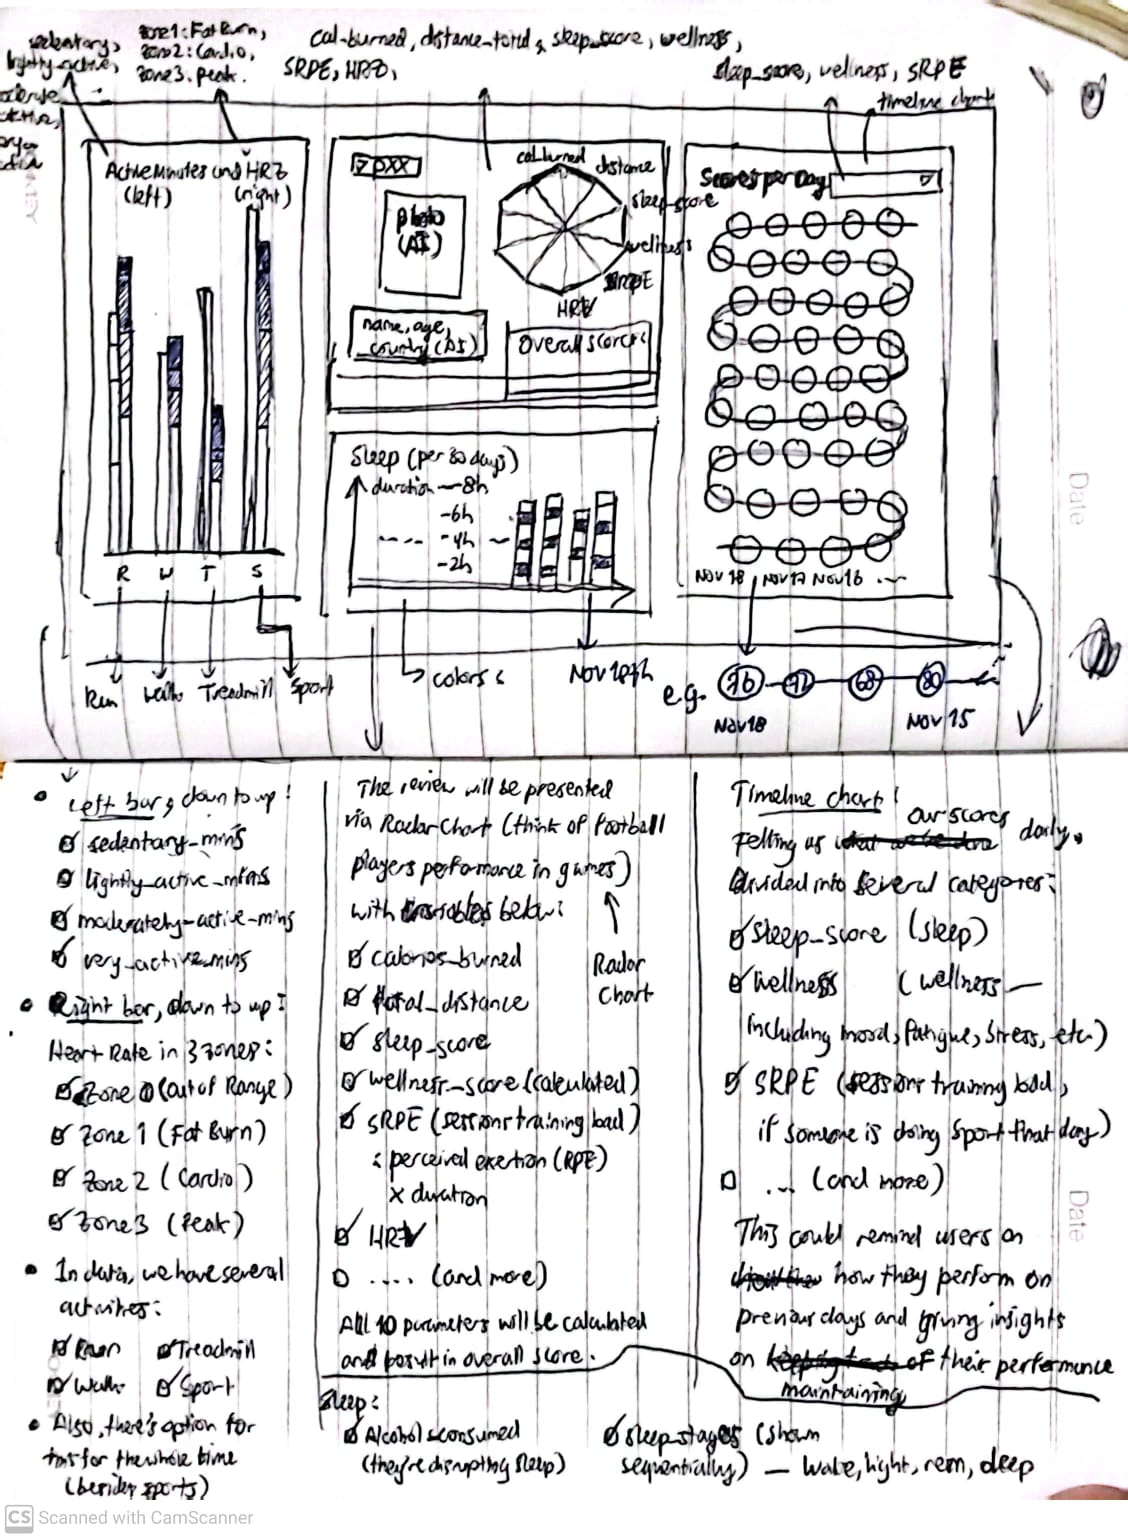

In [3]:
from IPython.display import Image
Image('dashboard_sketch.jpg')

### `calories`

In [4]:
df_calories = pd.DataFrame()

for pXX in id_players:
    
    calories_pXX = pd.read_json(f"{pXX}/fitbit/calories.json")
    calories_pXX['pXX'] = pXX
    df_calories = pd.concat([df_calories, calories_pXX])

In [5]:
df_calories

dateTime  value  pXX
0      2019-11-01 00:00:00   1.39  p01
1      2019-11-01 00:01:00   1.39  p01
2      2019-11-01 00:02:00   1.39  p01
3      2019-11-01 00:03:00   1.39  p01
4      2019-11-01 00:04:00   1.39  p01
...                    ...    ...  ...
218875 2020-03-31 23:55:00   1.17  p16
218876 2020-03-31 23:56:00   1.17  p16
218877 2020-03-31 23:57:00   1.17  p16
218878 2020-03-31 23:58:00   1.17  p16
218879 2020-03-31 23:59:00   1.28  p16

[3377529 rows x 3 columns]

In [6]:
df_calories['date']  = df_calories['dateTime'].dt.date
df_calories['yearmonth'] = df_calories['dateTime'].dt.month + df_calories['dateTime'].dt.year * 100
df_calories = df_calories.rename(columns={'value': 'calories'})

In [7]:
df_calories

dateTime  calories  pXX        date  yearmonth
0      2019-11-01 00:00:00      1.39  p01  2019-11-01     201911
1      2019-11-01 00:01:00      1.39  p01  2019-11-01     201911
2      2019-11-01 00:02:00      1.39  p01  2019-11-01     201911
3      2019-11-01 00:03:00      1.39  p01  2019-11-01     201911
4      2019-11-01 00:04:00      1.39  p01  2019-11-01     201911
...                    ...       ...  ...         ...        ...
218875 2020-03-31 23:55:00      1.17  p16  2020-03-31     202003
218876 2020-03-31 23:56:00      1.17  p16  2020-03-31     202003
218877 2020-03-31 23:57:00      1.17  p16  2020-03-31     202003
218878 2020-03-31 23:58:00      1.17  p16  2020-03-31     202003
218879 2020-03-31 23:59:00      1.28  p16  2020-03-31     202003

[3377529 rows x 5 columns]

In [8]:
df_cals = df_calories.groupby(['pXX', 'yearmonth'])['calories'].sum().reset_index()
df_cals['yearmonth'] = pd.to_datetime(df_cals['yearmonth'], format="%Y%m")
df_cals

pXX  yearmonth   calories
0   p01 2019-11-01  111362.50
1   p01 2019-12-01  115786.34
2   p01 2020-01-01  111865.62
3   p01 2020-02-01  107020.17
4   p01 2020-03-01  102322.52
..  ...        ...        ...
74  p16 2019-11-01   60487.52
75  p16 2019-12-01   64432.29
76  p16 2020-01-01   61279.76
77  p16 2020-02-01   57676.82
78  p16 2020-03-01   61361.71

[79 rows x 3 columns]

In [9]:
def clean_data_calories():

    df_calories = pd.DataFrame()

    for pXX in id_players:

        calories_pXX = pd.read_json(f"{pXX}/fitbit/calories.json")
        calories_pXX['pXX'] = pXX
        df_calories = pd.concat([df_calories, calories_pXX])

    df_calories['date']  = df_calories['dateTime'].dt.date
    df_calories['yearmonth'] = df_calories['dateTime'].dt.month + df_calories['dateTime'].dt.year * 100
    df_calories = df_calories.rename(columns={'value': 'calories'})

    df_cals = df_calories.groupby(['pXX', 'yearmonth'])['calories'].sum().reset_index()
    df_cals['yearmonth'] = pd.to_datetime(df_cals['yearmonth'], format="%Y%m")

    return df_cals

In [10]:
df_cals = clean_data_calories()

In [11]:
def calories_bar_chart_per_player(player):
    
    sns.catplot(data=df_cals.loc[df_cals['pXX'] == player], 
    x='pXX', y='calories', hue='yearmonth', kind='bar', 
    height=8.27, aspect=5.4/8.27)
    plt.grid(alpha=0.4)

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


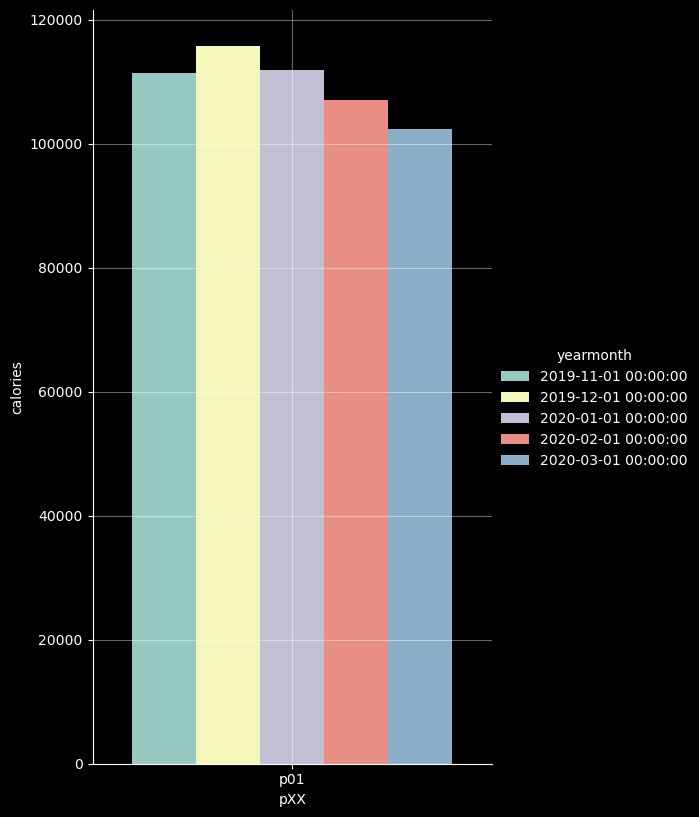

In [12]:
calories_bar_chart_per_player('p01')

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


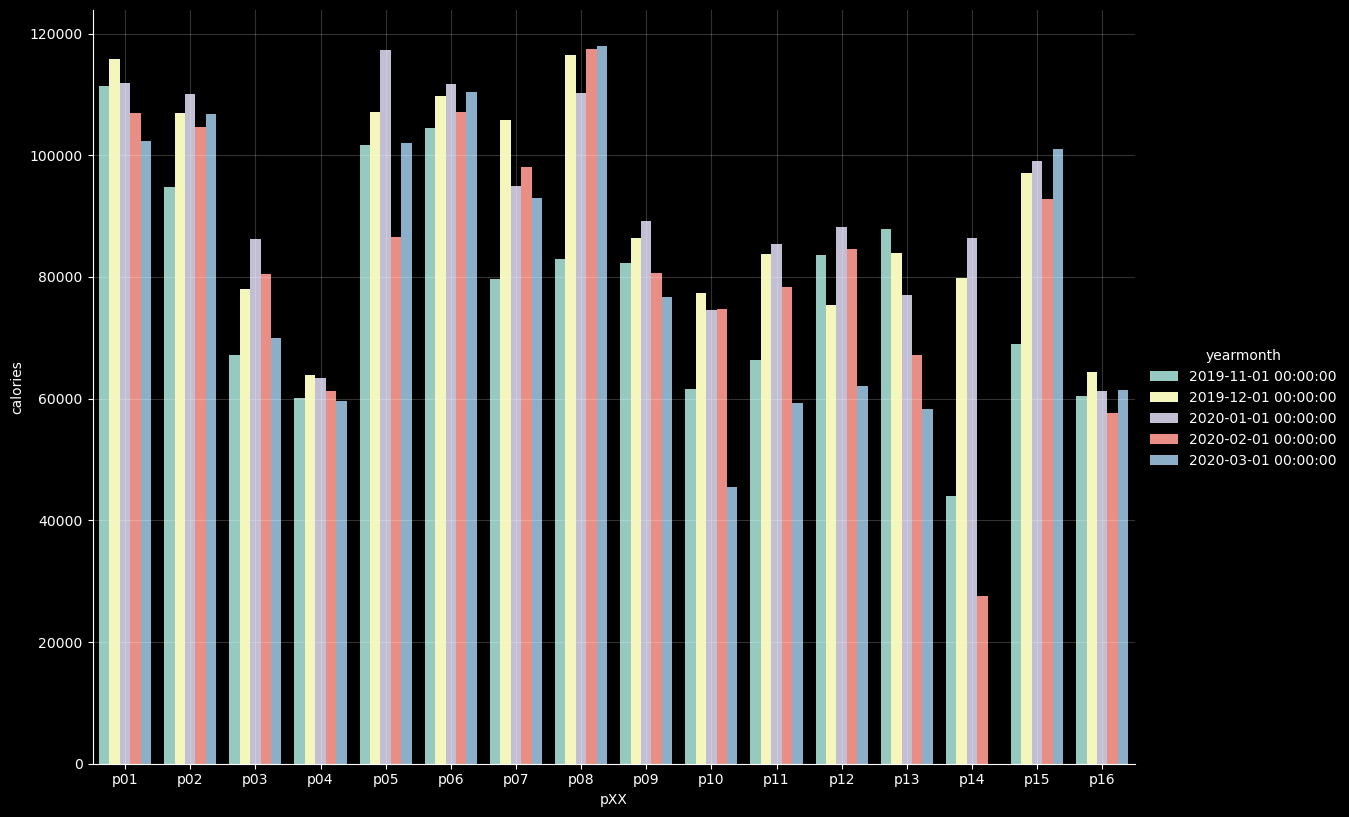

In [13]:
## Keep in mind: Violin plot, so that
# you could know if one player is active all the time
# or they would rather work it only at several days only

# (+) We could know the average calories they burn, and also the outliers.

sns.catplot(data=df_cals, x='pXX', y='calories', hue='yearmonth', 
    kind='bar', height=8.27, aspect=11.7/8.27)
plt.grid(alpha=0.2)

In [14]:
## Check for missing values:
df_cals_pivot = df_cals.pivot(values='calories', 
    index='yearmonth', columns='pXX').reset_index()
df_cals_pivot

pXX  yearmonth        p01        p02       p03       p04        p05  \
0   2019-11-01  111362.50   94857.00  67181.75  60044.86  101696.33   
1   2019-12-01  115786.34  106874.00  77989.39  63911.44  107031.85   
2   2020-01-01  111865.62  110051.68  86206.50  63377.76  117349.85   
3   2020-02-01  107020.17  104604.26  80566.04  61309.16   86551.62   
4   2020-03-01  102322.52  106852.69  69982.39  59623.47  101948.05   

pXX        p06        p07        p08       p09       p10       p11       p12  \
0    104474.14   79702.47   83015.33  82312.92  61513.43  66397.63  83580.48   
1    109808.67  105853.71  116469.73  86425.11  77380.77  83745.35  75394.59   
2    111655.44   95028.76  110181.77  89213.68  74571.57  85377.65  88150.26   
3    107090.91   98009.16  117494.27  80583.11  74745.39  78421.90  84640.57   
4    110325.18   93028.28  117979.12  76751.38  45532.80  59274.88  62062.76   

pXX       p13       p14        p15       p16  
0    87831.47  44071.51   69039.01  60487.52  
1    84005.37  79880.34   97132.85  64432.29  
2    77055.94  86378.60   99141.77  61279.76  
3    67238.09  27607.43   92813.48  57676.82  
4    58233.63       NaN  101067.90  61361.71

In [15]:
## Player 14 recorded only 4 month of data. Recheck:
df_calories.loc[df_calories['pXX'] == 'p14']

dateTime  calories  pXX        date  yearmonth
0      2019-11-13 00:00:00      1.13  p14  2019-11-13     201911
1      2019-11-13 00:01:00      1.13  p14  2019-11-13     201911
2      2019-11-13 00:02:00      1.13  p14  2019-11-13     201911
3      2019-11-13 00:03:00      1.13  p14  2019-11-13     201911
4      2019-11-13 00:04:00      1.13  p14  2019-11-13     201911
...                    ...       ...  ...         ...        ...
129595 2020-02-10 23:55:00      1.13  p14  2020-02-10     202002
129596 2020-02-10 23:56:00      1.13  p14  2020-02-10     202002
129597 2020-02-10 23:57:00      1.13  p14  2020-02-10     202002
129598 2020-02-10 23:58:00      1.13  p14  2020-02-10     202002
129599 2020-02-10 23:59:00      1.13  p14  2020-02-10     202002

[129600 rows x 5 columns]

### **`distance`**

In [16]:
df_distances = pd.DataFrame()

for pXX in id_players:
    
    distance = pd.read_json(f"{pXX}/fitbit/distance.json")
    distance['pXX'] = pXX
    df_distances = pd.concat([df_distances, distance])
    
df_distances['yearmonth'] = df_distances['dateTime'].dt.month + df_distances['dateTime'].dt.year * 100
df_distances = df_distances.rename(columns={'value': 'distances'})
df_distances['distances'] /= 100000 # Convert distances from cm to km

In [17]:
df_distances

dateTime  distances  pXX  yearmonth
0     2019-11-01 00:00:00     0.0000  p01     201911
1     2019-11-01 00:01:00     0.0000  p01     201911
2     2019-11-01 00:02:00     0.0000  p01     201911
3     2019-11-01 00:03:00     0.0000  p01     201911
4     2019-11-01 00:04:00     0.0000  p01     201911
...                   ...        ...  ...        ...
78567 2020-03-31 23:51:00     0.0000  p16     202003
78568 2020-03-31 23:52:00     0.0105  p16     202003
78569 2020-03-31 23:53:00     0.0000  p16     202003
78570 2020-03-31 23:55:00     0.0000  p16     202003
78571 2020-03-31 23:58:00     0.0000  p16     202003

[1534705 rows x 4 columns]

In [18]:
df_dists = df_distances.groupby(['pXX', 'yearmonth'])['distances'].sum().reset_index()
df_dists['yearmonth'] = pd.to_datetime(df_dists['yearmonth'], format="%Y%m")
df_dists

pXX  yearmonth  distances
0   p01 2019-11-01  336.24688
1   p01 2019-12-01  347.80994
2   p01 2020-01-01  323.88826
3   p01 2020-02-01  301.99334
4   p01 2020-03-01  253.67848
..  ...        ...        ...
74  p16 2019-11-01   56.01110
75  p16 2019-12-01   56.63860
76  p16 2020-01-01   36.37770
77  p16 2020-02-01   30.84900
78  p16 2020-03-01   31.75970

[79 rows x 3 columns]

In [19]:
def distance_bar_chart_per_player(player):
    
    sns.catplot(data=df_dists.loc[df_dists['pXX'] == player], 
    x='pXX', y='distances', hue='yearmonth', kind='bar', 
    height=8.27, aspect=5.85/8.27)
    plt.grid(alpha=0.4)

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


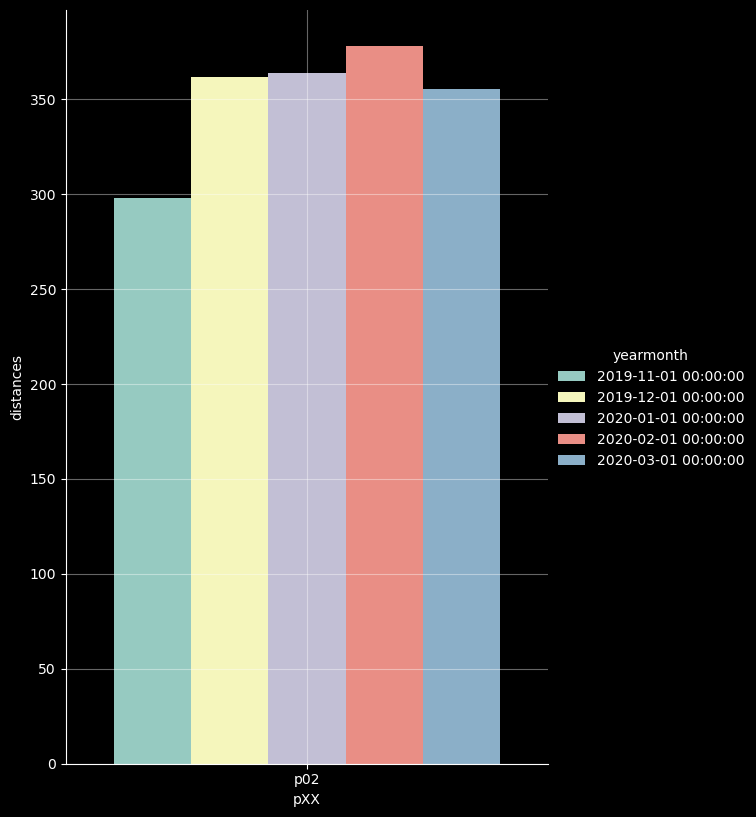

In [20]:
distance_bar_chart_per_player('p02')

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


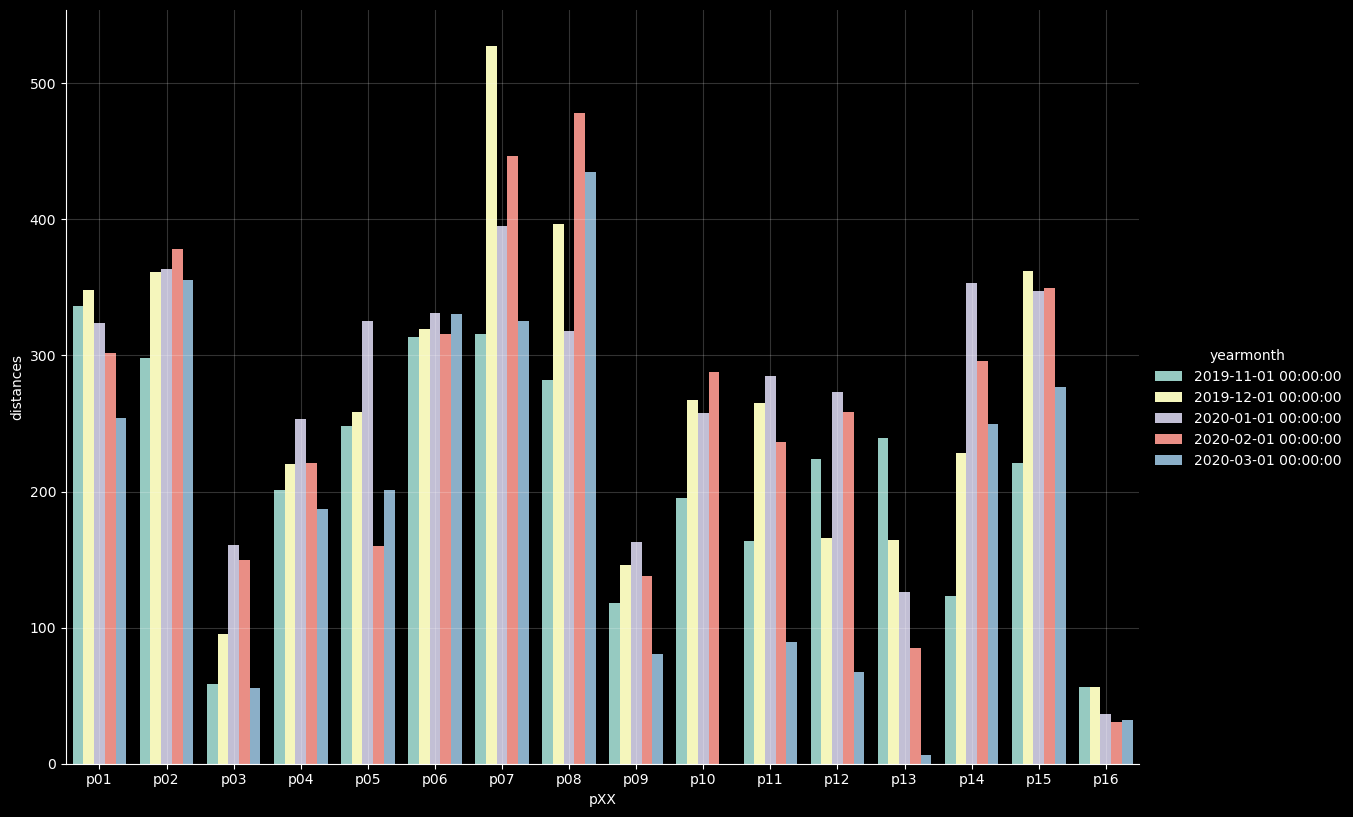

In [21]:
sns.catplot(data=df_dists, x='pXX', y='distances', hue='yearmonth', 
    kind='bar', height=8.27, aspect=11.7/8.27) #._legend.remove()
plt.grid(alpha=0.2)

In [22]:
## Check for missing values:
df_dists_pivot = df_dists.pivot(values='distances', 
    index='yearmonth', columns='pXX').reset_index()
df_dists_pivot

pXX  yearmonth        p01        p02       p03        p04       p05       p06  \
0   2019-11-01  336.24688  298.24610   58.6183  201.37430  248.2763  313.7028   
1   2019-12-01  347.80994  361.46199   95.6567  220.06422  258.5762  319.7245   
2   2020-01-01  323.88826  363.84560  160.7410  253.11360  325.0883  330.8352   
3   2020-02-01  301.99334  378.10780  150.0325  220.70790  160.1816  315.9721   
4   2020-03-01  253.67848  355.34470   55.2747  186.97610  201.4354  330.5386   

pXX       p07       p08       p09       p10       p11       p12       p13  \
0    315.8475  281.6714  118.0547  195.5849  163.8833  224.0086  239.2025   
1    527.4277  396.7740  146.2941  266.9120  265.3034  165.6635  164.2211   
2    395.4368  318.0130  163.0870  257.9754  284.7697  273.4066  125.8124   
3    446.2351  477.8101  138.2549  287.9133  236.2023  258.3557   85.3033   
4    325.4313  434.7906   80.7644       NaN   89.0742   67.4493    6.1815   

pXX       p14       p15      p16  
0    123.3968  220.9263  56.0111  
1    228.2940  362.2134  56.6386  
2    353.1566  347.6322  36.3777  
3    296.0242  349.5944  30.8490  
4    249.7185  276.9907  31.7597

### **`exercise`**

#### Sample: `p01`

In [23]:
exercises = pd.read_json("p01/fitbit/exercise.json")
pd.options.display.max_columns  = 50
pd.options.display.max_colwidth = 1500

In [24]:
exercises.head()

logId activityName  activityTypeId  \
0  26451905128         Walk           90013   
1  26455950499         Walk           90013   
2  26467488515         Walk           90013   
3  26520401069         Walk           90013   
4  26538035127         Walk           90013   

                                                                                                                                  activityLevel  \
0   [{'minutes': 0, 'name': 'sedentary'}, {'minutes': 0, 'name': 'lightly'}, {'minutes': 8, 'name': 'fairly'}, {'minutes': 14, 'name': 'very'}]   
1  [{'minutes': 0, 'name': 'sedentary'}, {'minutes': 1, 'name': 'lightly'}, {'minutes': 12, 'name': 'fairly'}, {'minutes': 23, 'name': 'very'}]   
2  [{'minutes': 0, 'name': 'sedentary'}, {'minutes': 0, 'name': 'lightly'}, {'minutes': 11, 'name': 'fairly'}, {'minutes': 30, 'name': 'very'}]   
3    [{'minutes': 0, 'name': 'sedentary'}, {'minutes': 1, 'name': 'lightly'}, {'minutes': 7, 'name': 'fairly'}, {'minutes': 9, 'name': 'very'}]   
4   [{'minutes': 3, 'name': 'sedentary'}, {'minutes': 13, 'name': 'lightly'}, {'minutes': 0, 'name': 'fairly'}, {'minutes': 0, 'name': 'very'}]   

   averageHeartRate  calories  duration  activeDuration  steps        logType  \
0                94       192   1331000         1331000   1878  auto_detected   
1                94       302   2202000         2202000   2786  auto_detected   
2                98       354   2458000         2458000   3035  auto_detected   
3                97       145   1024000         1024000   1284  auto_detected   
4                93       121    973000          973000   1065  auto_detected   

                                    manualValuesSpecified  \
0  {'calories': False, 'distance': False, 'steps': False}   
1  {'calories': False, 'distance': False, 'steps': False}   
2  {'calories': False, 'distance': False, 'steps': False}   
3  {'calories': False, 'distance': False, 'steps': False}   
4  {'calories': False, 'distance': False, 'steps': False}   

                                                                                                                                                                                                                                 heartRateZones  \
0  [{'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 1}, {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 20}, {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}, {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}]   
1  [{'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 4}, {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 32}, {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}, {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}]   
2  [{'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 0}, {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 41}, {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}, {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}]   
3  [{'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 1}, {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 16}, {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}, {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}]   
4  [{'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 3}, {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 13}, {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}, {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}]   

        lastModified            startTime  originalStartTime  \
0  11/01/19 15:29:27  2019-11-01 14:56:32  11/01/19 14:56:32   
1  11/01/19 19:53:36  2019-11-01 19:03:11  11/01/19 19:03:11   
2  11/02/19 14:31:32  2019-11-02 13:26:38  11/02/19 13:26:38   
3  11/04/19 21:56:40  2019-11-04 21:22:08  11/04/19 21:22:08   
4  11/05/19 19:57:44  2019-11-05 19:27:25  11/05/19 19:27:25   

   originalDuration  elevationGain  hasGps  shouldFetchDetails  distance  \
0           1331000         24.384   False               False       

In [25]:
exercises.isna().sum()

logId                      0
activityName               0
activityTypeId             0
activityLevel              0
averageHeartRate           0
calories                   0
duration                   0
activeDuration             0
steps                      0
logType                    0
manualValuesSpecified      0
heartRateZones             0
lastModified               0
startTime                  0
originalStartTime          0
originalDuration           0
elevationGain             15
hasGps                     0
shouldFetchDetails         0
distance                 165
distanceUnit             165
source                   165
tcxLink                  178
speed                    165
pace                     177
vo2Max                   179
dtype: int64

In [26]:
## Flattening activityLevel
act_level = pd.json_normalize(exercises['activityLevel'])
act_level

0                                   1  \
0    {'minutes': 0, 'name': 'sedentary'}   {'minutes': 0, 'name': 'lightly'}   
1    {'minutes': 0, 'name': 'sedentary'}   {'minutes': 1, 'name': 'lightly'}   
2    {'minutes': 0, 'name': 'sedentary'}   {'minutes': 0, 'name': 'lightly'}   
3    {'minutes': 0, 'name': 'sedentary'}   {'minutes': 1, 'name': 'lightly'}   
4    {'minutes': 3, 'name': 'sedentary'}  {'minutes': 13, 'name': 'lightly'}   
..                                   ...                                 ...   
185  {'minutes': 0, 'name': 'sedentary'}   {'minutes': 0, 'name': 'lightly'}   
186  {'minutes': 0, 'name': 'sedentary'}   {'minutes': 4, 'name': 'lightly'}   
187  {'minutes': 3, 'name': 'sedentary'}   {'minutes': 3, 'name': 'lightly'}   
188  {'minutes': 0, 'name': 'sedentary'}   {'minutes': 2, 'name': 'lightly'}   
189  {'minutes': 0, 'name': 'sedentary'}   {'minutes': 0, 'name': 'lightly'}   

                                     2                                3  
0     {'minutes': 8, 'name': 'fairly'}  {'minutes': 14, 'name': 'very'}  
1    {'minutes': 12, 'name': 'fairly'}  {'minutes': 23, 'name': 'very'}  
2    {'minutes': 11, 'name': 'fairly'}  {'minutes': 30, 'name': 'very'}  
3     {'minutes': 7, 'name': 'fairly'}   {'minutes': 9, 'name': 'very'}  
4     {'minutes': 0, 'name': 'fairly'}   {'minutes': 0, 'name': 'very'}  
..                                 ...                              ...  
185   {'minutes': 6, 'name': 'fairly'}  {'minutes': 12, 'name': 'very'}  
186   {'minutes': 8, 'name': 'fairly'}  {'minutes': 36, 'name': 'very'}  
187  {'minutes': 22, 'name': 'fairly'}  {'minutes': 65, 'name': 'very'}  
188   {'minutes': 5, 'name': 'fairly'}  {'minutes': 11, 'name': 'very'}  
189  {'minutes': 11, 'name': 'fairly'}  {'minutes': 35, 'name': 'very'}  

[190 rows x 4 columns]

In [27]:
## Column names following formats in `XX_minutes.json`
act_level_prefixes = [
    'sedentary_', 'lightly_active_', 
    'moderately_active_', 'very_active_']

for i in range(4):
    act_level = (act_level.join(
            pd.json_normalize(act_level[i])
              .drop('name', axis=1)
              .add_prefix(f'{act_level_prefixes[i]}')
          )).drop(columns=[i])

In [28]:
act_level

sedentary_minutes  lightly_active_minutes  moderately_active_minutes  \
0                    0                       0                          8   
1                    0                       1                         12   
2                    0                       0                         11   
3                    0                       1                          7   
4                    3                      13                          0   
..                 ...                     ...                        ...   
185                  0                       0                          6   
186                  0                       4                          8   
187                  3                       3                         22   
188                  0                       2                          5   
189                  0                       0                         11   

     very_active_minutes  
0                     14  
1                     23  
2                     30  
3                      9  
4                      0  
..                   ...  
185                   12  
186                   36  
187                   65  
188                   11  
189                   35  

[190 rows x 4 columns]

In [29]:
## Flattening `manualValuesSpecified`
manual_values_check = pd.json_normalize(exercises['manualValuesSpecified'])
manual_values_check = manual_values_check.add_prefix('manual_check_')
manual_values_check

manual_check_calories  manual_check_distance  manual_check_steps
0                    False                  False               False
1                    False                  False               False
2                    False                  False               False
3                    False                  False               False
4                    False                  False               False
..                     ...                    ...                 ...
185                  False                  False               False
186                  False                  False               False
187                  False                  False               False
188                  False                  False               False
189                  False                  False               False

[190 rows x 3 columns]

In [30]:
manual_values_check.value_counts()

manual_check_calories  manual_check_distance  manual_check_steps
False                  False                  False                 188
                       True                   False                   2
Name: count, dtype: int64

In [31]:
hrz = pd.json_normalize(exercises['heartRateZones'])
hrz

0  \
0     {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 1}   
1     {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 4}   
2     {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 0}   
3     {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 1}   
4     {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 3}   
..                                                             ...   
185   {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 1}   
186   {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 5}   
187  {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 12}   
188   {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 3}   
189   {'name': 'Out of Range', 'min': 30, 'max': 86, 'minutes': 0}   

                                                              1  \
0    {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 20}   
1    {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 32}   
2    {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 41}   
3    {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 16}   
4    {'name': 'Fat Burn', 'min': 86, 'max': 121, 'minutes': 13}   
..                                                          ...   
185  {'name': 'Fat Burn', 'min': 86, 'max': 120, 'minutes': 16}   
186  {'name': 'Fat Burn', 'min': 86, 'max': 120, 'minutes': 42}   
187  {'name': 'Fat Burn', 'min': 86, 'max': 120, 'minutes': 77}   
188  {'name': 'Fat Burn', 'min': 86, 'max': 120, 'minutes': 15}   
189  {'name': 'Fat Burn', 'min': 86, 'max': 120, 'minutes': 41}   

                                                            2  \
0    {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}   
1    {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}   
2    {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}   
3    {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}   
4    {'name': 'Cardio', 'min': 121, 'max': 147, 'minutes': 0}   
..                                                        ...   
185  {'name': 'Cardio', 'min': 120, 'max': 146, 'minutes': 1}   
186  {'name': 'Cardio', 'min': 120, 'max': 146, 'minutes': 2}   
187  {'name': 'Cardio', 'min': 120, 'max': 146, 'minutes': 2}   
188  {'name': 'Cardio', 'min': 120, 'max': 146, 'minutes': 0}   
189  {'name': 'Cardio', 'min': 120, 'max': 146, 'minutes': 4}   

                                                          3  
0    {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}  
1    {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}  
2    {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}  
3    {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}  
4    {'name': 'Peak', 'min': 147, 'max': 220, 'minutes': 0}  
..                                                      ...  
185  {'name': 'Peak', 'min': 146, 'max': 220, 'minutes': 0}  
186  {'name': 'Peak', 'min': 146, 'max': 220, 'minutes': 0}  
187  {'name': 'Peak', 'min': 146, 'max': 220, 'minutes': 0}  
188  {'name': 'Peak', 'min': 146, 'max': 220, 'minutes': 0}  
189  {'name': 'Peak', 'min': 146, 'max': 220, 'minutes': 0}  

[190 rows x 4 columns]

In [32]:
hrz_prefixes = ['oor', 'fb', 'cardio', 'peak']

for i in range(4):
    hrz = (hrz.join(
            pd.json_normalize(hrz[i])
              .drop('name', axis=1)
              .add_prefix(f'{hrz_prefixes[i]}_HR_')
          )).drop(columns=[i])

In [33]:
hrz

oor_HR_min  oor_HR_max  oor_HR_minutes  fb_HR_min  fb_HR_max  \
0            30          86               1         86        121   
1            30          86               4         86        121   
2            30          86               0         86        121   
3            30          86               1         86        121   
4            30          86               3         86        121   
..          ...         ...             ...        ...        ...   
185          30          86               1         86        120   
186          30          86               5         86        120   
187          30          86              12         86        120   
188          30          86               3         86        120   
189          30          86               0         86        120   

     fb_HR_minutes  cardio_HR_min  cardio_HR_max  cardio_HR_minutes  \
0               20            121            147                  0   
1               32            121            147                  0   
2               41            121            147                  0   
3               16            121            147                  0   
4               13            121            147                  0   
..             ...            ...            ...                ...   
185             16            120            146                  1   
186             42            120            146                  2   
187             77            120            146                  2   
188             15            120            146                  0   
189             41            120            146                  4   

     peak_HR_min  peak_HR_max  peak_HR_minutes  
0            147          220                0  
1            147          220                0  
2            147          220                0  
3            147          220                0  
4            147          220                0  
..           ...          ...              ...  
185          146          220                0  
186          146          220                0  
187          146          220                0  
188          146          220                0  
189          146          220                0  

[190 rows x 12 columns]

In [34]:
exercises.columns

Index(['logId', 'activityName', 'activityTypeId', 'activityLevel',
       'averageHeartRate', 'calories', 'duration', 'activeDuration', 'steps',
       'logType', 'manualValuesSpecified', 'heartRateZones', 'lastModified',
       'startTime', 'originalStartTime', 'originalDuration', 'elevationGain',
       'hasGps', 'shouldFetchDetails', 'distance', 'distanceUnit', 'source',
       'tcxLink', 'speed', 'pace', 'vo2Max'],
      dtype='object')

In [35]:
col_sequences = (
    list(exercises.columns[0:2]) + 
    list(act_level.columns) + 
    list(exercises.columns[4:9]) + 
    list(manual_values_check.columns) +
    list(hrz.columns) +
    list(exercises.columns[12:]))

In [36]:
col_sequences

['logId',
 'activityName',
 'sedentary_minutes',
 'lightly_active_minutes',
 'moderately_active_minutes',
 'very_active_minutes',
 'averageHeartRate',
 'calories',
 'duration',
 'activeDuration',
 'steps',
 'manual_check_calories',
 'manual_check_distance',
 'manual_check_steps',
 'oor_HR_min',
 'oor_HR_max',
 'oor_HR_minutes',
 'fb_HR_min',
 'fb_HR_max',
 'fb_HR_minutes',
 'cardio_HR_min',
 'cardio_HR_max',
 'cardio_HR_minutes',
 'peak_HR_min',
 'peak_HR_max',
 'peak_HR_minutes',
 'lastModified',
 'startTime',
 'originalStartTime',
 'originalDuration',
 'elevationGain',
 'hasGps',
 'shouldFetchDetails',
 'distance',
 'distanceUnit',
 'source',
 'tcxLink',
 'speed',
 'pace',
 'vo2Max']

In [37]:
## Combining flattened columns
exercises = (exercises
    .join([act_level, manual_values_check, hrz]))

exercises = exercises.drop(
    ['activityLevel', 'manualValuesSpecified', 'heartRateZones'], axis=1)
exercises = exercises.reindex(columns = col_sequences)

exercises

logId activityName  sedentary_minutes  lightly_active_minutes  \
0    26451905128         Walk                  0                       0   
1    26455950499         Walk                  0                       1   
2    26467488515         Walk                  0                       0   
3    26520401069         Walk                  0                       1   
4    26538035127         Walk                  3                      13   
..           ...          ...                ...                     ...   
185  29950369280         Walk                  0                       0   
186  29954913982         Walk                  0                       4   
187  29967089605         Walk                  3                       3   
188  29983197395         Walk                  0                       2   
189  30028464188         Walk                  0                       0   

     moderately_active_minutes  very_active_minutes  averageHeartRate  \
0                            8                   14                94   
1                           12                   23                94   
2                           11                   30                98   
3                            7                    9                97   
4                            0                    0                93   
..                         ...                  ...               ...   
185                          6                   12               102   
186                          8                   36                99   
187                         22                   65               100   
188                          5                   11                96   
189                         11                   35               108   

     calories  duration  activeDuration  steps  manual_check_calories  \
0         192   1331000         1331000   1878                  False   
1         302   2202000         2202000   2786                  False   
2         354   2458000         2458000   3035                  False   
3         145   1024000         1024000   1284                  False   
4         121    973000          973000   1065                  False   
..        ...       ...             ...    ...                    ...   
185       168   1076000         1076000   1203                  False   
186       452   2918000         2918000   3909                  False   
187       846   5581000         5581000   7599                  False   
188       151   1076000         1076000   1279                  False   
189       459   2764000         2764000   3846                  False   

     manual_check_distance  manual_check_steps  oor_HR_min  oor_HR_max  \
0                    False               False          30          86   
1                    False               False          30          86   
2                    False               False          30          86   
3                    False               False          30          86   
4                    False               False          30          86   
..                     ...                 ...         ...         ...   
185                  False               False          30          86   
186                  False               False          30          86   
187                  False               False          30          86   
188                  False               False          30          86   
189                  False               False          30          86   

     oor_HR_minutes  fb_HR_min  fb_HR_max  fb_HR_minutes  cardio_HR_min  \
0                 1         86        121             20            121   
1                 4         86        121             32            121   
2                 0         86        121             41            121   
3                 1         86        121             16            121   
4                 3         86        121             13            121   
..   

In [38]:
exercises['dateTime'] = pd.to_datetime(pd.to_datetime(exercises['startTime']).dt.date)

In [39]:
exercises['activityName'].value_counts()

activityName
Walk         150
Sport         15
Run           14
Treadmill     11
Name: count, dtype: int64

In [40]:
selected_cols = (['dateTime'] +
    list(exercises.columns[1:6]) +
    list(exercises.columns[
      exercises.columns.str
        .endswith('_HR_minutes')])
)
selected_cols

['dateTime',
 'activityName',
 'sedentary_minutes',
 'lightly_active_minutes',
 'moderately_active_minutes',
 'very_active_minutes',
 'oor_HR_minutes',
 'fb_HR_minutes',
 'cardio_HR_minutes',
 'peak_HR_minutes']

In [41]:
e_stats = exercises.loc[:, selected_cols]
e_stats['yearmonth'] = pd.to_datetime(
    e_stats['dateTime'].dt.year * 100 + e_stats['dateTime'].dt.month, format="%Y%m")
e_stats

dateTime activityName  sedentary_minutes  lightly_active_minutes  \
0   2019-11-01         Walk                  0                       0   
1   2019-11-01         Walk                  0                       1   
2   2019-11-02         Walk                  0                       0   
3   2019-11-04         Walk                  0                       1   
4   2019-11-05         Walk                  3                      13   
..         ...          ...                ...                     ...   
185 2020-03-27         Walk                  0                       0   
186 2020-03-27         Walk                  0                       4   
187 2020-03-28         Walk                  3                       3   
188 2020-03-29         Walk                  0                       2   
189 2020-03-31         Walk                  0                       0   

     moderately_active_minutes  very_active_minutes  oor_HR_minutes  \
0                            8                   14               1   
1                           12                   23               4   
2                           11                   30               0   
3                            7                    9               1   
4                            0                    0               3   
..                         ...                  ...             ...   
185                          6                   12               1   
186                          8                   36               5   
187                         22                   65              12   
188                          5                   11               3   
189                         11                   35               0   

     fb_HR_minutes  cardio_HR_minutes  peak_HR_minutes  yearmonth  
0               20                  0                0 2019-11-01  
1               32                  0                0 2019-11-01  
2               41                  0                0 2019-11-01  
3               16                  0                0 2019-11-01  
4               13                  0                0 2019-11-01  
..             ...                ...              ...        ...  
185             16                  1                0 2020-03-01  
186             42                  2                0 2020-03-01  
187             77                  2                0 2020-03-01  
188             15                  0                0 2020-03-01  
189             41                  4                0 2020-03-01  

[190 rows x 11 columns]

In [42]:
# Data for hierarchical/stacked pie chart, suggestions: pivot_table()
e_total = e_stats.drop('dateTime', axis=1).groupby(['activityName', 'yearmonth']).agg('sum').reset_index()
e_total

activityName  yearmonth  sedentary_minutes  lightly_active_minutes  \
0           Run 2019-11-01                  0                       0   
1           Run 2019-12-01                  0                       0   
2           Run 2020-01-01                  0                       0   
3           Run 2020-02-01                  0                       1   
4           Run 2020-03-01                  0                       0   
5         Sport 2019-11-01                  0                       8   
6         Sport 2019-12-01                  6                      29   
7         Sport 2020-01-01                  3                       6   
8         Sport 2020-02-01                  8                      29   
9         Sport 2020-03-01                  0                       1   
10    Treadmill 2019-11-01                 11                       1   
11    Treadmill 2019-12-01                  0                       0   
12    Treadmill 2020-01-01                  0                       0   
13    Treadmill 2020-02-01                  2                       2   
14    Treadmill 2020-03-01                  0                       0   
15         Walk 2019-11-01                 13                      84   
16         Walk 2019-12-01                 22                     121   
17         Walk 2020-01-01                 27                      81   
18         Walk 2020-02-01                  8                      48   
19         Walk 2020-03-01                 12                      96   

    moderately_active_minutes  very_active_minutes  oor_HR_minutes  \
0                           2                   74               0   
1                           0                   24               0   
2                           0                  138               0   
3                           0                   96               1   
4                           0                   54               0   
5                          38                  194               5   
6                           6                   50              15   
7                          33                  195               6   
8                          15                  159              18   
9                           3                   68               0   
10                          0                   77              12   
11                          0                   40               0   
12                          0                   91               0   
13                          1                   95               3   
14                          0                   37               0   
15                        225                  593              96   
16                        208                  732             149   
17                        233                  678             192   
18                         81                  270              59   
19                        217                  532             137   

    fb_HR_minutes  cardio_HR_minutes  peak_HR_minutes  
0               7                 25               43  
1               0                  1               23  
2               8                 43               87  
3              12                 25               60  
4               1                 13               39  
5             132                 86               14  
6              50                 23                4  
7             135                 78               17  
8              79                 85               25  
9              24                 34               12  
10              3                 31               43  
11              8                 15               17  
12              6                 28               57  
13             19                 27               51  
14              4                 15               18  
15            784                 24                2  
16            902                 17          

In [43]:
## Reverse the order
active_mins_cols = list(e_total.columns[2:6])
HR_zones_cols    = list(e_total.columns[6:])

In [44]:
## Possible figures

In [45]:
active_mins_cols

['sedentary_minutes',
 'lightly_active_minutes',
 'moderately_active_minutes',
 'very_active_minutes']

In [46]:
# ## Check for missing values:
# df_cals_pivot = df_cals.pivot(values='calories', 
#     index='yearmonth', columns='pXX').reset_index()
# df_cals_pivot

#### Attempts on Visuals

In [47]:
e_stats.value_counts('activityName')

activityName
Walk         150
Sport         15
Run           14
Treadmill     11
Name: count, dtype: int64

In [48]:
e_total_indexed = e_stats.drop('dateTime', axis=1).groupby(['activityName', 'yearmonth']).agg('sum')
e_total_indexed

sedentary_minutes  lightly_active_minutes  \
activityName yearmonth                                               
Run          2019-11-01                  0                       0   
             2019-12-01                  0                       0   
             2020-01-01                  0                       0   
             2020-02-01                  0                       1   
             2020-03-01                  0                       0   
Sport        2019-11-01                  0                       8   
             2019-12-01                  6                      29   
             2020-01-01                  3                       6   
             2020-02-01                  8                      29   
             2020-03-01                  0                       1   
Treadmill    2019-11-01                 11                       1   
             2019-12-01                  0                       0   
             2020-01-01                  0                       0   
             2020-02-01                  2                       2   
             2020-03-01                  0                       0   
Walk         2019-11-01                 13                      84   
             2019-12-01                 22                     121   
             2020-01-01                 27                      81   
             2020-02-01                  8                      48   
             2020-03-01                 12                      96   

                         moderately_active_minutes  very_active_minutes  \
activityName yearmonth                                                    
Run          2019-11-01                          2                   74   
             2019-12-01                          0                   24   
             2020-01-01                          0                  138   
             2020-02-01                          0                   96   
             2020-03-01                          0                   54   
Sport        2019-11-01                         38                  194   
             2019-12-01                          6                   50   
             2020-01-01                         33                  195   
             2020-02-01                         15                  159   
             2020-03-01                          3                   68   
Treadmill    2019-11-01                          0                   77   
             2019-12-01                          0                   40   
             2020-01-01                          0                   91   
             2020-02-01                          1                   95   
             2020-03-01                          0                   37   
Walk         2019-11-01                        225                  593   
             2019-12-01                        208                  732   
             2020-01-01                        233                  678   
             2020-02-01                         81                  270   
             2020-03-01                        217                  532   

                         oor_HR_minutes  fb_HR_minutes  cardio_HR_minutes  \
activityName yearmonth                                                      
Run          2019-11-01               0              7                 25   
             2019-12-01               0              0                  1   
             2020-01-01               0              8                 43   
             2020-02-01               1             12                 25   
             2020-03-01               0              1                 13   
Sport        2019-11-01               5            132                 86   
             2019-12-01              15             50                 23   
             2020-01-01               6            135                 78   
             2020-02-01              18             79         

In [49]:
active_mins_color = ['lightseagreen', 'mediumseagreen', 'seagreen', 'darkgreen']
HR_zones_color    = ['lightsalmon', 'orangered', 'red', 'darkred']

<Axes: xlabel='activityName,yearmonth'>

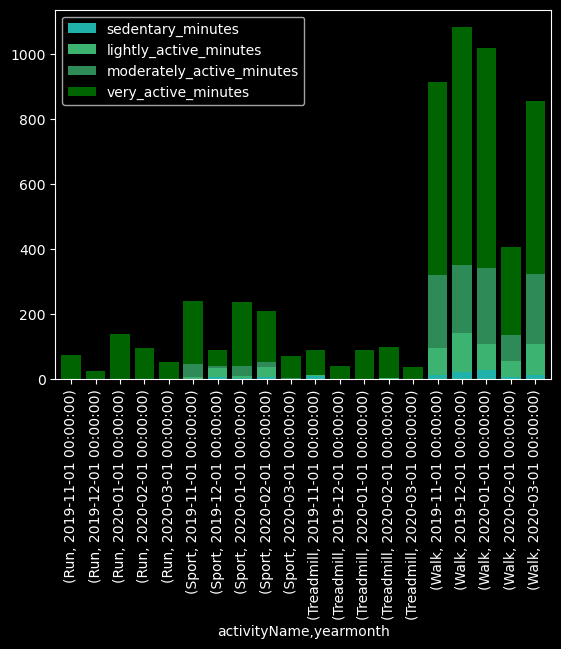

In [50]:
## Experiment 4, looks good!

fig, ax = plt.subplots()

e_total_indexed[active_mins_cols].plot(
    kind='bar', stacked=True, width=0.8, ax=ax,
    color=active_mins_color)

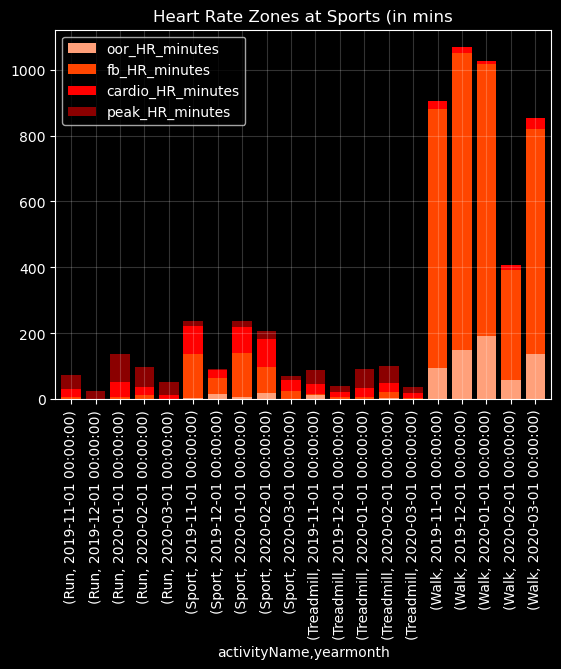

In [51]:
fig, ax = plt.subplots()

# ax = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax = plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

e_total_indexed[HR_zones_cols].plot(
    kind='bar', stacked=True, width=0.8, 
    color=HR_zones_color, ax=ax)
plt.title('Heart Rate Zones at Sports (in mins')
plt.grid(alpha=0.2)
# plt.xticks(rotation=45)

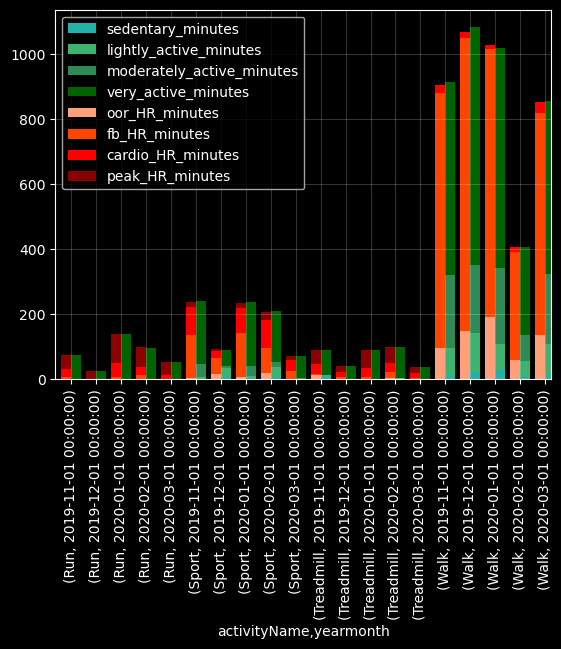

In [52]:
## Testing if we could cram the 2 charts. Would rather separate.

fig, ax = plt.subplots()

e_total_indexed[active_mins_cols].plot(
    kind='bar', stacked=True, width=0.4, ax=ax,
    color=active_mins_color, position=0)
e_total_indexed[HR_zones_cols].plot(
    kind='bar', stacked=True, width=0.4, ax=ax,
    color=HR_zones_color, position=1)
plt.grid(alpha=0.2)

#### Whole: `pXX`

In [53]:
def clean_data_exercise():

    df_exercises = pd.DataFrame()

    for pXX in id_players:
        exercises_team = pd.read_json(f"{pXX}/fitbit/exercise.json")
        exercises_team['pXX'] = pXX
        df_exercises = pd.concat([df_exercises, exercises_team])
        
    act_level = pd.json_normalize(df_exercises['activityLevel'])    

    act_level_prefixes = [
        'sedentary_', 'lightly_active_', 
        'moderately_active_', 'very_active_']

    for i in range(4):
        act_level = (act_level.join(
                pd.json_normalize(act_level[i])
                  .drop('name', axis=1)
                  .add_prefix(f'{act_level_prefixes[i]}')
              )).drop(columns=[i])

    ## Flattening `manualValuesSpecified`
    manual_values_check = pd.json_normalize(df_exercises['manualValuesSpecified'])
    manual_values_check = manual_values_check.add_prefix('manual_check_')

    hrz = pd.json_normalize(df_exercises['heartRateZones'])

    hrz_prefixes = ['oor', 'fb', 'cardio', 'peak']

    for i in range(4):
        hrz = (hrz.join(
                pd.json_normalize(hrz[i])
                  .drop('name', axis=1)
                  .add_prefix(f'{hrz_prefixes[i]}_HR_')
              )).drop(columns=[i])

    col_sequences = (
        list(df_exercises.columns[0:2]) + 
        list(act_level.columns) + 
        list(df_exercises.columns[4:9]) + 
        list(manual_values_check.columns) +
        list(hrz.columns) +
        list(df_exercises.columns[12:]))

    ## Combining flattened columns
    df_exercises = (df_exercises
        .join([act_level, manual_values_check, hrz]))

    df_exercises = df_exercises.drop(
        ['activityLevel', 'manualValuesSpecified', 'heartRateZones'], axis=1)
    df_exercises = df_exercises.reindex(columns = col_sequences)

    df_exercises['dateTime'] = pd.to_datetime(pd.to_datetime(df_exercises['startTime']).dt.date)
        
    return df_exercises

In [54]:
df_exercises = clean_data_exercise()

In [55]:
df_exercises.head(2)

logId activityName  sedentary_minutes  lightly_active_minutes  \
0  26451905128         Walk                  0                       0   
0  26555895608         Walk                  0                       0   

   moderately_active_minutes  very_active_minutes  averageHeartRate  calories  \
0                          8                   14              94.0       192   
0                          8                   14             108.0       105   

   duration  activeDuration   steps  manual_check_calories  \
0   1331000         1331000  1878.0                  False   
0    922000          922000  1139.0                  False   

   manual_check_distance  manual_check_steps  oor_HR_min  oor_HR_max  \
0                  False               False        30.0        86.0   
0                  False               False        30.0        86.0   

   oor_HR_minutes  fb_HR_min  fb_HR_max  fb_HR_minutes  cardio_HR_min  \
0             1.0       86.0      121.0           20.0          121.0   
0             1.0       86.0      121.0           20.0          121.0   

   cardio_HR_max  cardio_HR_minutes  peak_HR_min  peak_HR_max  \
0          147.0                0.0        147.0        220.0   
0          147.0                0.0        147.0        220.0   

   peak_HR_minutes       lastModified            startTime  originalStartTime  \
0              0.0  11/01/19 15:29:27  2019-11-01 14:56:32  11/01/19 14:56:32   
0              0.0  11/06/19 18:25:09  2019-11-06 15:10:31  11/06/19 15:10:31   

   originalDuration  elevationGain  hasGps  shouldFetchDetails  distance  \
0           1331000         24.384   False               False       NaN   
0            922000         21.336   False               False       NaN   

  distanceUnit source tcxLink  speed  pace vo2Max  pXX  swimLengths  \
0          NaN    NaN     NaN    NaN   NaN    NaN  p01          NaN   
0          NaN    NaN     NaN    NaN   NaN    NaN  p02          NaN   

   poolLength poolLengthUnit customHeartRateZones   dateTime  
0         NaN            NaN                  NaN 2019-11-01  
0         NaN            NaN                  NaN 2019-11-06

In [56]:
## New kid on the block: Players who swims
df_exercises[df_exercises['swimLengths'].notna()].head(2)

logId activityName  sedentary_minutes  lightly_active_minutes  \
58  27713040995         Swim                  0                       3   
96  27586388138         Swim                  0                       0   

    moderately_active_minutes  very_active_minutes  averageHeartRate  \
58                          5                   19               NaN   
96                          5                   21               NaN   

    calories  duration  activeDuration  steps  manual_check_calories  \
58       178   3687000         3687000    NaN                  False   
96       112    922000          922000    NaN                  False   

    manual_check_distance  manual_check_steps  oor_HR_min  oor_HR_max  \
58                  False               False        30.0        86.0   
96                  False               False        30.0        86.0   

    oor_HR_minutes  fb_HR_min  fb_HR_max  fb_HR_minutes  cardio_HR_min  \
58             5.0       86.0      121.0           21.0          121.0   
96             0.0       86.0      120.0           26.0          120.0   

    cardio_HR_max  cardio_HR_minutes  peak_HR_min  peak_HR_max  \
58          147.0                1.0        147.0        220.0   
96          146.0                1.0        146.0        220.0   

    peak_HR_minutes       lastModified            startTime  \
58              0.0  12/31/19 13:06:38  2019-12-31 11:31:23   
96              0.0  12/24/19 10:04:18  2019-12-24 09:34:14   

    originalStartTime  originalDuration  elevationGain  hasGps  \
58  12/31/19 11:31:23           3687000            NaN   False   
96  12/24/19 09:34:14            922000            NaN   False   

    shouldFetchDetails  distance distanceUnit source tcxLink     speed  \
58               False     0.775    Kilometer    NaN     NaN  0.756713   
96               False     0.575    Kilometer    NaN     NaN  2.245119   

           pace vo2Max  pXX  swimLengths  poolLength poolLengthUnit  \
58  4757.419355    NaN  p10         31.0        25.0          Meter   
96  1603.478261    NaN  p08         23.0        25.0          Meter   

   customHeartRateZones   dateTime  
58                  NaN 2019-12-31  
96                  NaN 2019-12-24

In [57]:
df_exercises[df_exercises['pace'].notna()].sample(2)

logId activityName  sedentary_minutes  lightly_active_minutes  \
36   27279896314          Run                  0                       2   
114  28145914694          Run                  0                       0   

     moderately_active_minutes  very_active_minutes  averageHeartRate  \
36                           9                    6             161.0   
114                          0                   48             139.0   

     calories  duration  activeDuration   steps  manual_check_calories  \
36        346   2470000         2279000  5564.0                  False   
114       752   3167000         2881000  7150.0                  False   

     manual_check_distance  manual_check_steps  oor_HR_min  oor_HR_max  \
36                   False               False        30.0        86.0   
114                  False               False        30.0        86.0   

     oor_HR_minutes  fb_HR_min  fb_HR_max  fb_HR_minutes  cardio_HR_min  \
36              8.0       86.0      121.0            9.0          121.0   
114             0.0       86.0      120.0            4.0          120.0   

     cardio_HR_max  cardio_HR_minutes  peak_HR_min  peak_HR_max  \
36           147.0                0.0        147.0        220.0   
114          146.0               25.0        146.0        220.0   

     peak_HR_minutes       lastModified            startTime  \
36               0.0  12/10/19 14:24:00  2019-12-10 13:30:44   
114             19.0  01/18/20 08:03:39  2020-01-18 07:02:02   

     originalStartTime  originalDuration  elevationGain  hasGps  \
36   12/10/19 13:30:44           2470000        243.230    True   
114  01/18/20 07:02:02           3167000        132.588    True   

     shouldFetchDetails  distance distanceUnit  \
36                 True  1.160765    Kilometer   
114                True  7.073632    Kilometer   

                                                                                                                                                                                                    source  \
36   {'type': 'tracker', 'name': 'Versa 2', 'id': '147848006', 'url': 'https://www.fitbit.com/', 'trackerFeatures': ['ELEVATION', 'GPS', 'DISTANCE', 'HEARTRATE', 'STEPS', 'PACE', 'CALORIES', 'VO2_MAX']}   
114  {'type': 'tracker', 'name': 'Versa 2', 'id': '149197665', 'url': 'https://www.fitbit.com/', 'trackerFeatures': ['HEARTRATE', 'VO2_MAX', 'PACE', 'CALORIES', 'DISTANCE', 'ELEVATION', 'GPS', 'STEPS']}   

                                                               tcxLink  \
36   https://www.fitbit.com/activities/exercise/27279896314?export=tcx   
114  https://www.fitbit.com/activities/exercise/28145914694?export=tcx   

        speed         pace                vo2Max  pXX  swimLengths  \
36   1.796983  2003.357976                   NaN  p04          NaN   
114  8.701229   413.734670  {'vo2Max': 48.72086}  p01          NaN   

     poolLength poolLengthUnit customHeartRateZones   dateTime  
36          NaN            NaN                  NaN 2019-12-10  
114         NaN            NaN                  NaN 2020-01-18

In [58]:
pd.DataFrame(
    df_exercises.value_counts(['activityName'])
).reset_index()['activityName'].nunique()

21

In [59]:
## Sequence colors from dataframe, mapped by Sports

# explode = (0, 0.1, 0.15)
sa_colors = {
    'Walk': '#32CD32', 
    'Run': '#FF4500', 
    'Treadmill': '#FFA500',
    'Outdoor Bike': '#1E90FF', 
    'Sport': '#FFD700',
    'Weights': '#8B4513', 
    'Workout': '#FF69B4', 
    'Aerobic Workout': '#EE82EE', 
    'Hike': '#228B22',
    'Bike': '#87CEEB',
    'Spinning': '#6A5ACD',
    'Elliptical': '#4682B4',
    'Cross Country Skiing': '#B0E0E6',
    'Swim': '#40E0D0',
    'Circuit Training': '#FFDAB9',
    'Interval Workout': '#FF6347',
    'Yoga': '#800080',
    'Hockey': '#A9A9A9',
    'Skiing': '#F0F8FF',
    'Tennis': '#FFFF00',
    'Dancing': '#FF1493'
}

sports_activities = pd.DataFrame()

def pie_chart_sport_activities_pXX(player='all'):

    fig, ax = plt.subplots(figsize=(12, 8))
    autopct = lambda v: f'{v:.2f}%' if v > 3 else None
    n_sports = 0
    
    if player == 'all':
        title = 'Sport Activities, the Whole Team'
        sports_activities = pd.DataFrame(df_exercises
            .value_counts(['activityName'])).reset_index()
        n_sports = sports_activities['activityName'].nunique()
    else:
        title = f'Sport Activities, Player {player}'
        sports_activities = pd.DataFrame(
            df_exercises.loc[df_exercises['pXX'] == player]
            .value_counts(['activityName'])).reset_index()
        n_sports = sports_activities['activityName'].nunique()

    ax.pie(sports_activities['count'], pctdistance=0.55,
        textprops={'fontsize': 16}, autopct=autopct, 
        startangle=-112.5, colors=[sa_colors[key] for key in 
           sports_activities['activityName']])
    ax.axis('equal')
    
    # legend_settings = (
    #     {loc: 'upper right'} if n_sports <= 3
    #     else {bbox_to_anchor: (0.825, 1.025)})
    
    ax.set_title(title, fontsize=20)
    ax.legend(sports_activities['activityName'], 
        bbox_to_anchor=(0.825, 1.025))#, loc='center right')

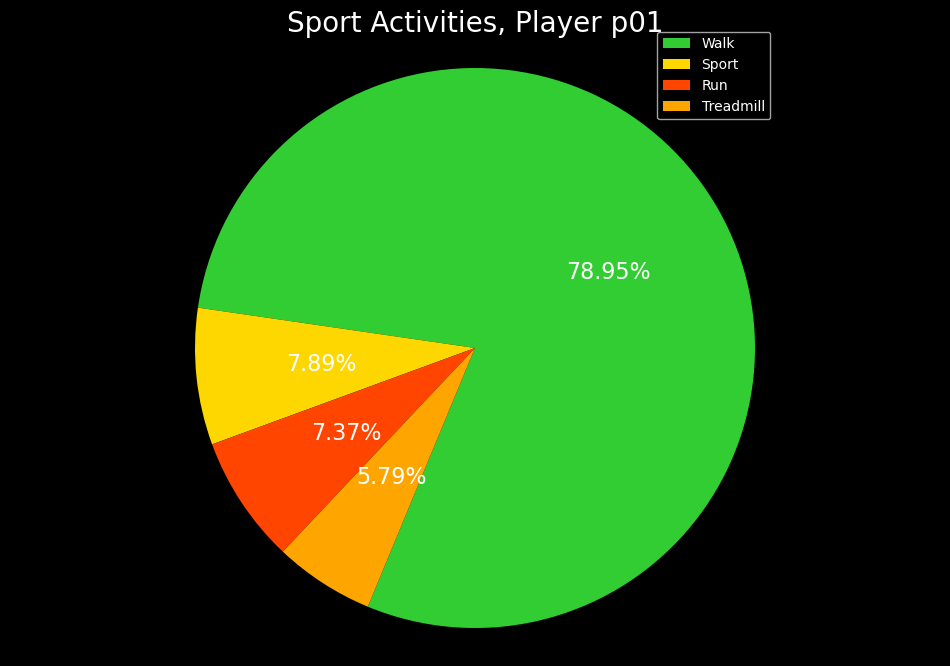

In [60]:
pie_chart_sport_activities_pXX('p01')

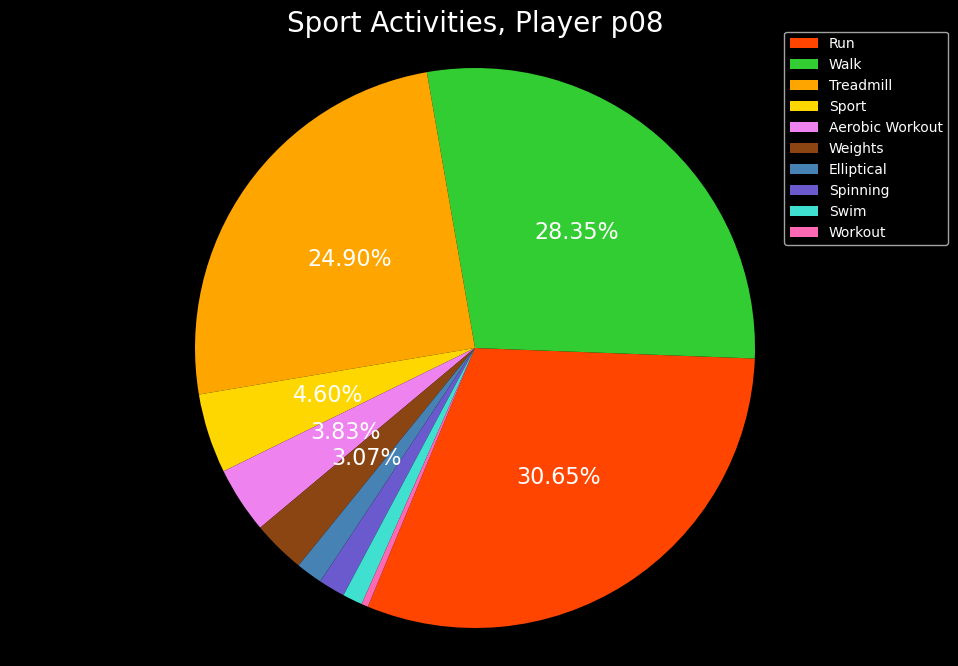

In [61]:
pie_chart_sport_activities_pXX('p08')

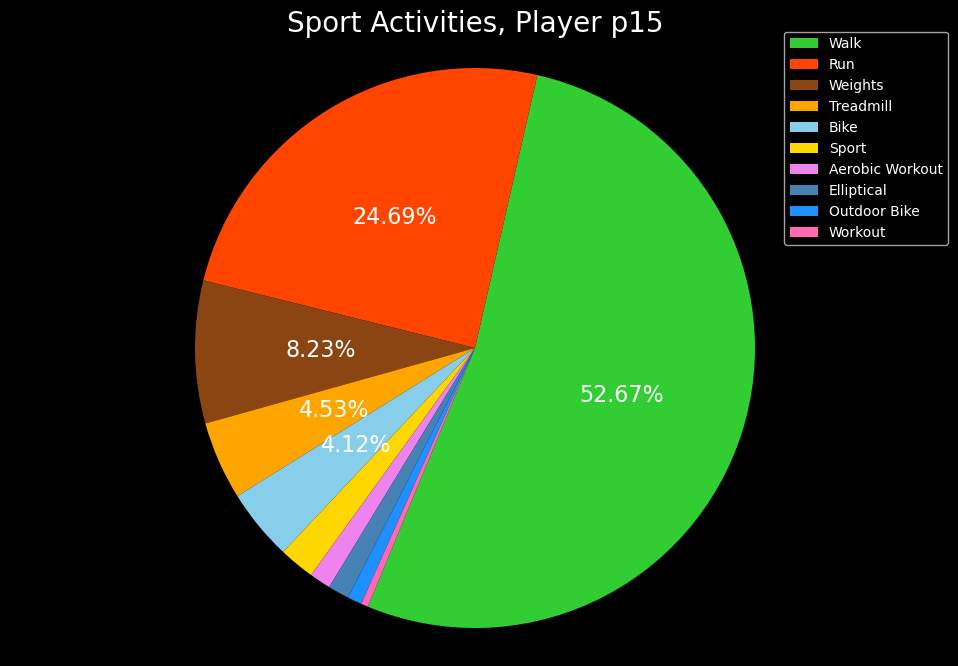

In [62]:
pie_chart_sport_activities_pXX('p15')

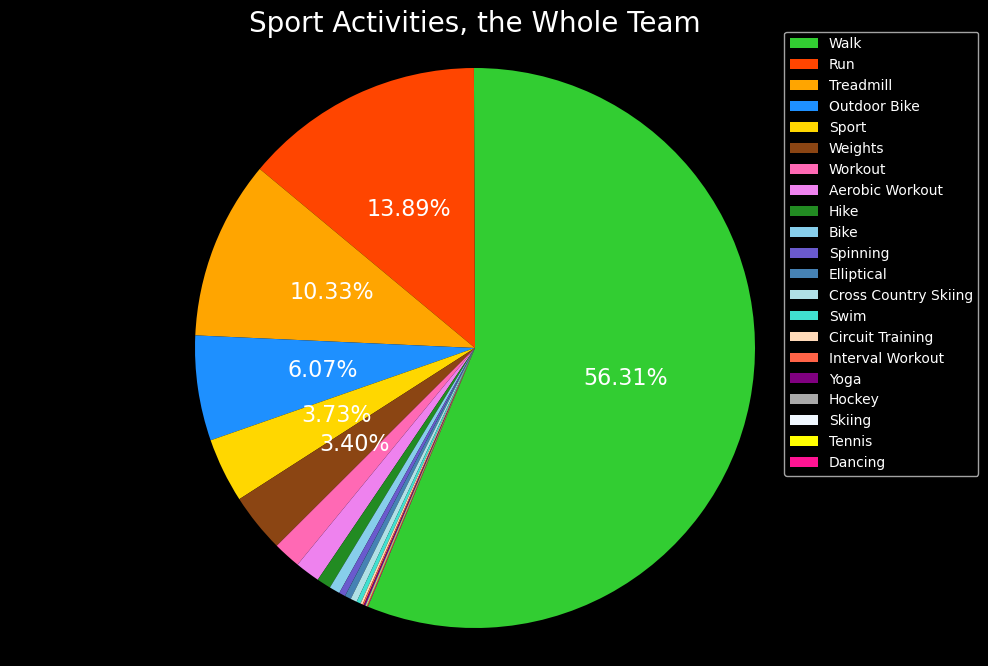

In [63]:
pie_chart_sport_activities_pXX('all')

In [64]:
col_sequences = (['pXX'] +
    list(df_exercises.columns[0:2]) + 
    list(act_level.columns) + 
    list(df_exercises.columns[4:9]) + 
    list(manual_values_check.columns) +
    list(hrz.columns) +
    list(df_exercises.columns[12:]))

df_exercises_selected_cols = (
    ['pXX', 'dateTime', 'activityName'] +
    list(df_exercises.columns[
      df_exercises.columns.str
        .endswith('_minutes')])
)

df_e_stats = df_exercises.loc[:, df_exercises_selected_cols]
df_e_stats['yearmonth'] = pd.to_datetime(
    df_e_stats['dateTime'].dt.year * 100 + 
    df_e_stats['dateTime'].dt.month, format="%Y%m")

In [65]:
df_e_stats

pXX   dateTime  activityName  sedentary_minutes  lightly_active_minutes  \
0    p01 2019-11-01          Walk                  0                       0   
0    p02 2019-11-06          Walk                  0                       0   
0    p03 2019-11-01          Walk                  0                       0   
0    p04 2019-11-05        Hockey                  0                       0   
0    p05 2019-11-01          Walk                  0                       0   
..   ...        ...           ...                ...                     ...   
319  p02 2020-03-30         Sport                  0                       0   
320  p02 2020-03-30          Walk                  0                       0   
321  p02 2020-03-31  Outdoor Bike                  0                      10   
322  p02 2020-03-31         Sport                  0                       5   
323  p02 2020-03-31  Outdoor Bike                  0                       2   

     moderately_active_minutes  very_active_minutes  oor_HR_minutes  \
0                            8                   14             1.0   
0                            8                   14             1.0   
0                            8                   14             1.0   
0                            8                   14             1.0   
0                            8                   14             1.0   
..                         ...                  ...             ...   
319                          2                   47             2.0   
320                          0                   30             1.0   
321                          1                   12            11.0   
322                          0                   83             0.0   
323                         12                   55            21.0   

     fb_HR_minutes  cardio_HR_minutes  peak_HR_minutes  yearmonth  
0             20.0                0.0              0.0 2019-11-01  
0             20.0                0.0              0.0 2019-11-01  
0             20.0                0.0              0.0 2019-11-01  
0             20.0                0.0              0.0 2019-11-01  
0             20.0                0.0              0.0 2019-11-01  
..             ...                ...              ...        ...  
319           14.0               23.0              0.0 2020-03-01  
320            0.0                2.0              5.0 2020-03-01  
321            3.0                0.0              0.0 2020-03-01  
322           47.0               12.0              0.0 2020-03-01  
323           47.0                0.0              0.0 2020-03-01  

[2440 rows x 12 columns]

In [66]:
df_active_mins_cols = list(df_e_stats.columns[3:7])
df_HR_zones_cols    = list(df_e_stats.columns[7:11])

In [67]:
df_active_mins_cols

['sedentary_minutes',
 'lightly_active_minutes',
 'moderately_active_minutes',
 'very_active_minutes']

In [68]:
df_HR_zones_cols

['oor_HR_minutes', 'fb_HR_minutes', 'cardio_HR_minutes', 'peak_HR_minutes']

In [69]:
(df_e_stats[df_e_stats['pXX'] == 'p02']
     .drop(['pXX', 'dateTime'], axis=1))

activityName  sedentary_minutes  lightly_active_minutes  \
0            Walk                  0                       0   
1             Run                  0                       1   
2            Walk                  0                       0   
3           Sport                  0                       1   
4            Walk                  3                      13   
..            ...                ...                     ...   
319         Sport                  0                       0   
320          Walk                  0                       0   
321  Outdoor Bike                  0                      10   
322         Sport                  0                       5   
323  Outdoor Bike                  0                       2   

     moderately_active_minutes  very_active_minutes  oor_HR_minutes  \
0                            8                   14             1.0   
1                           12                   23             4.0   
2                           11                   30             0.0   
3                            7                    9             1.0   
4                            0                    0             3.0   
..                         ...                  ...             ...   
319                          2                   47             2.0   
320                          0                   30             1.0   
321                          1                   12            11.0   
322                          0                   83             0.0   
323                         12                   55            21.0   

     fb_HR_minutes  cardio_HR_minutes  peak_HR_minutes  yearmonth  
0             20.0                0.0              0.0 2019-11-01  
1             32.0                0.0              0.0 2019-11-01  
2             41.0                0.0              0.0 2019-11-01  
3             16.0                0.0              0.0 2019-11-01  
4             13.0                0.0              0.0 2019-11-01  
..             ...                ...              ...        ...  
319           14.0               23.0              0.0 2020-03-01  
320            0.0                2.0              5.0 2020-03-01  
321            3.0                0.0              0.0 2020-03-01  
322           47.0               12.0              0.0 2020-03-01  
323           47.0                0.0              0.0 2020-03-01  

[324 rows x 10 columns]

In [70]:
metrics_p02 = (df_e_stats[df_e_stats['pXX'] == 'p02']
     .drop(['pXX', 'dateTime'], axis=1)
     .groupby(['yearmonth', 'activityName']).agg('sum')
).reset_index().set_index('yearmonth')
metrics_p02

activityName  sedentary_minutes  lightly_active_minutes  \
yearmonth                                                                     
2019-11-01       Aerobic Workout                 11                       1   
2019-11-01                   Run                  0                      12   
2019-11-01                 Sport                  0                       1   
2019-11-01                  Walk                 25                      96   
2019-11-01               Weights                  0                      10   
2019-12-01       Aerobic Workout                  0                      14   
2019-12-01                   Run                  3                      24   
2019-12-01                 Sport                  1                      12   
2019-12-01             Treadmill                  2                       5   
2019-12-01                  Walk                 26                     110   
2019-12-01               Weights                  8                      14   
2020-01-01       Aerobic Workout                  0                       3   
2020-01-01                  Bike                  1                       2   
2020-01-01                   Run                  4                      33   
2020-01-01                 Sport                  1                      13   
2020-01-01                  Walk                 28                     142   
2020-01-01               Weights                  2                      17   
2020-02-01       Aerobic Workout                  1                       0   
2020-02-01                   Run                  4                      16   
2020-02-01                 Sport                  3                      10   
2020-02-01                  Swim                  0                       0   
2020-02-01                  Walk                 63                      69   
2020-02-01               Weights                  3                       3   
2020-03-01       Aerobic Workout                  2                       1   
2020-03-01  Cross Country Skiing                  0                       1   
2020-03-01          Outdoor Bike                  0                      12   
2020-03-01                   Run                  4                      14   
2020-03-01                 Sport                  1                       9   
2020-03-01                  Walk                 86                      95   
2020-03-01               Weights                  3                       5   

            moderately_active_minutes  very_active_minutes  oor_HR_minutes  \
yearmonth                                                                    
2019-11-01                          0                   40            12.0   
2019-11-01                         45                  126            22.0   
2019-11-01                          7                    9             1.0   
2019-11-01                        192                  726            98.0   
2019-11-01                         48                  200            12.0   
2019-12-01                         12                   19            14.0   
2019-12-01                         71                  224            37.0   
2019-12-01                         11                   47             8.0   
2019-12-01                         14                   56            10.0   
2019-12-01                        219                  869           154.0   
2019-12-01                         21                  198            41.0   
2020-01-01                          8                    6             2.0   
2020-01-01                         15                   82             8.0   
2020-01-01                         33                   99            34.0   
2020-01-01                         35                  197            17.0   
2020-01-01                        288                 1104           200.0   
2020-01-01                         54                  286            24.0   
2020-02-0

In [71]:
# fig, ax = plt.subplots(figsize=(12, 8))

# metrics_p02[HR_zones_cols].plot(kind='bar',
#     stacked=True, width=0.8, ax=ax, color=HR_zones_color)

# def label_bars(heights, rects):
#     for height, rect in zip(heights, rects):
#         ax.annotate(f'{height}',
#             xy = (rect.get_x() + rect.get_width() / 2, height),
#             xytext=(0, 4), # 4 points vertical offset.
#             textcoords = 'offset points', ha='center', va='bottom')
        
# for i 

<Axes: xlabel='yearmonth,activityName'>

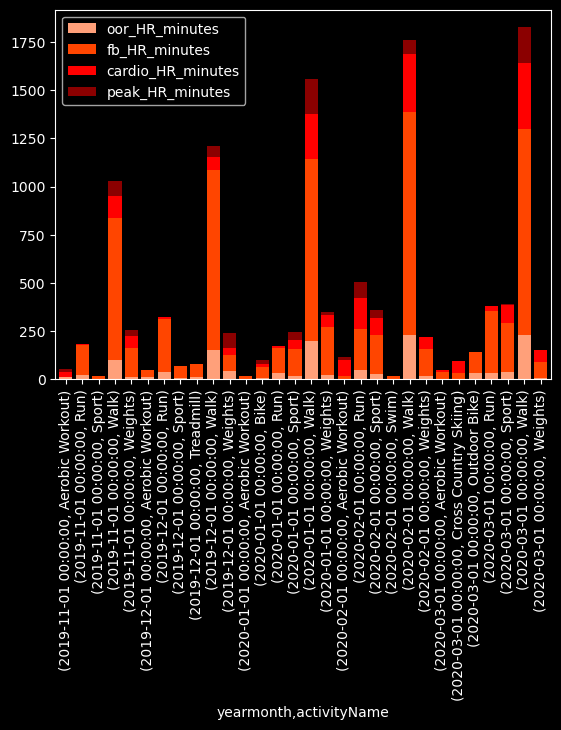

In [72]:
(df_e_stats[df_e_stats['pXX'] == 'p02'].drop(
    ['pXX', 'dateTime'], axis=1).groupby(
    ['yearmonth', 'activityName']).agg('sum')[HR_zones_cols]
).plot(kind='bar', stacked='True', 
       color=HR_zones_color, width=0.8)

<Axes: xlabel='yearmonth,activityName'>

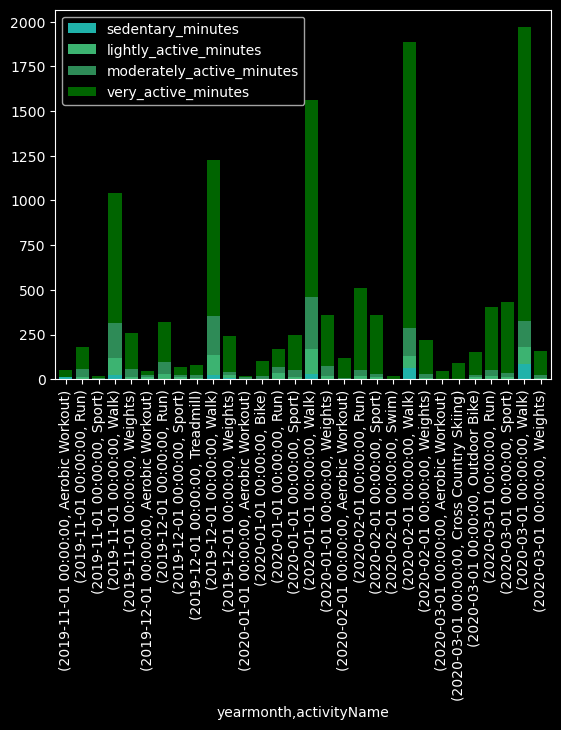

In [73]:
(df_e_stats[df_e_stats['pXX'] == 'p02'].drop(
    ['pXX', 'dateTime'], axis=1).groupby(
    ['yearmonth', 'activityName']).agg('sum')[active_mins_cols]
).plot(kind='bar', stacked='True', 
    width=0.8, color=active_mins_color)
# plt.xticks(rotation=45, ha='right')

In [74]:
def active_metrics_per_sport_pXX(player):
    
    col_sequences = (['pXX'] +
        list(df_exercises.columns[0:2]) + 
        list(act_level.columns) + 
        list(df_exercises.columns[4:9]) + 
        list(manual_values_check.columns) +
        list(hrz.columns) +
        list(df_exercises.columns[12:]))

    df_exercises_selected_cols = (
        ['pXX', 'dateTime', 'activityName'] +
        list(df_exercises.columns[
          df_exercises.columns.str
            .endswith('_minutes')])
    )

    df_e_stats = df_exercises.loc[:, df_exercises_selected_cols]
    df_e_stats['yearmonth'] = pd.to_datetime(
        df_e_stats['dateTime'].dt.year * 100 + 
        df_e_stats['dateTime'].dt.month, format="%Y%m")

    df_active_mins_cols = list(df_e_stats.columns[3:7])
    df_HR_zones_cols    = list(df_e_stats.columns[7:11])
    
    active_metrics_pXX = (
        df_e_stats[df_e_stats['pXX'] == player].drop(
            ['pXX', 'dateTime'], axis=1).groupby(
            ['yearmonth', 'activityName']).agg('sum'))
    
    active_metrics_pXX[HR_zones_cols].plot(
        kind='bar', stacked='True',
        width=0.8, color=HR_zones_color)
    
    active_metrics_pXX[active_mins_cols].plot(
        kind='bar', stacked='True', 
        width=0.8, color=active_mins_color)

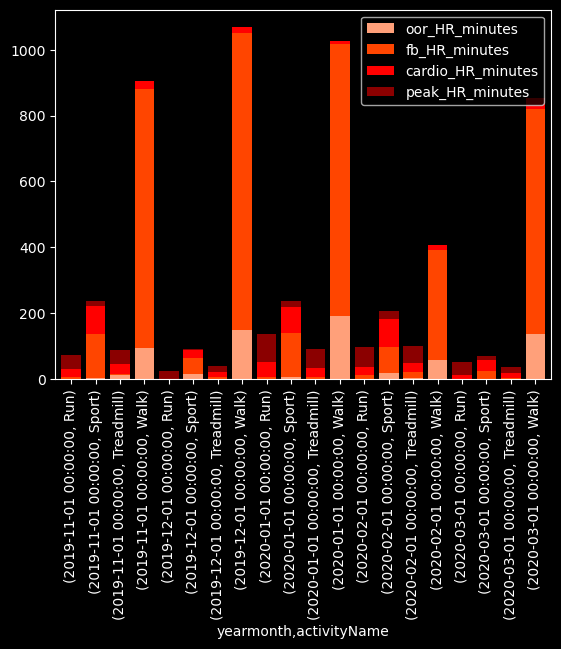

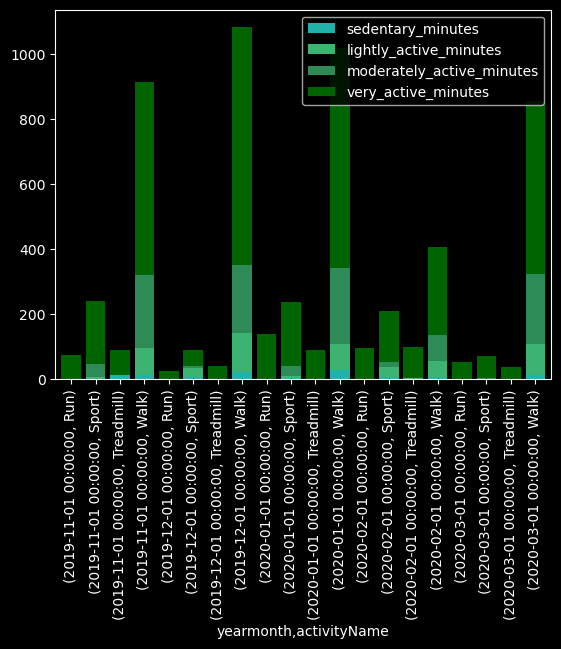

In [75]:
active_metrics_per_sport_pXX('p01')

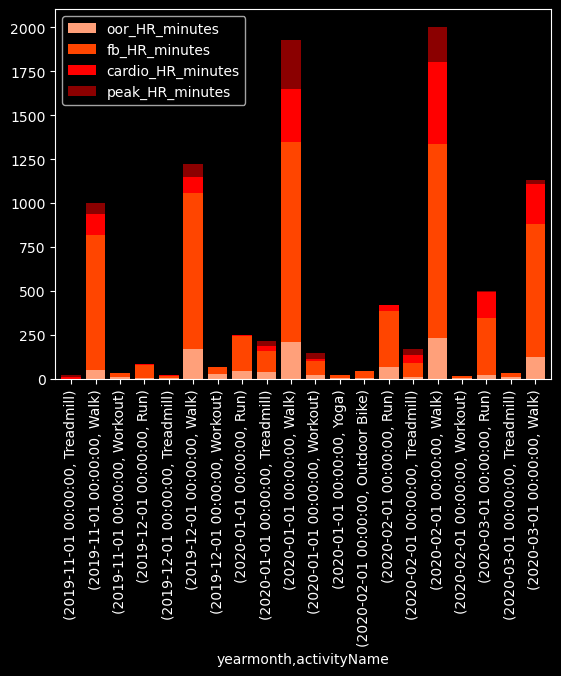

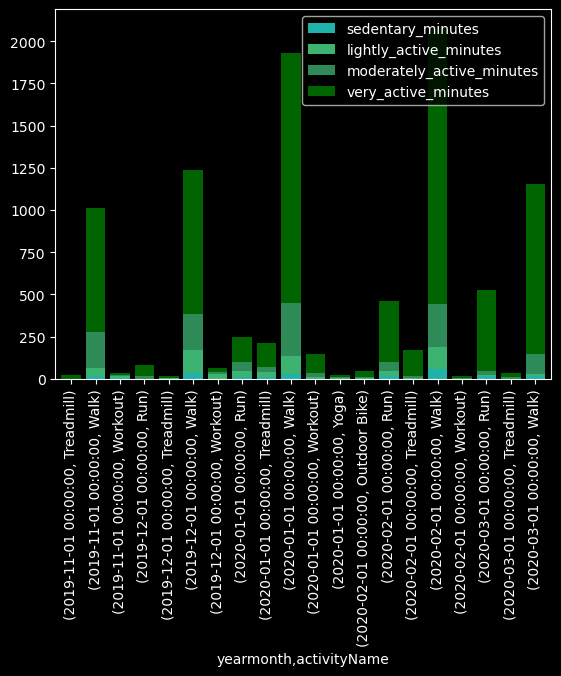

In [76]:
active_metrics_per_sport_pXX('p14')

In [77]:
act_level_prefixes

['sedentary_', 'lightly_active_', 'moderately_active_', 'very_active_']

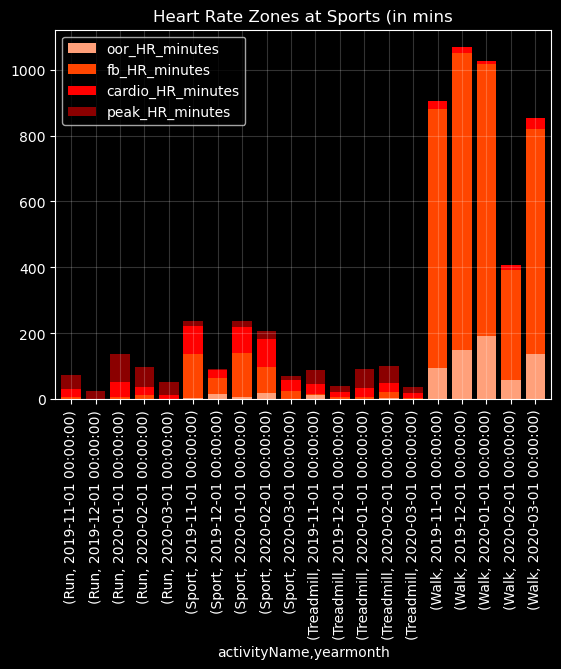

In [78]:
fig, ax = plt.subplots()

# ax = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax = plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

e_total_indexed[HR_zones_cols].plot(
    kind='bar', stacked=True, width=0.8, 
    color=HR_zones_color, ax=ax)
plt.title('Heart Rate Zones at Sports (in mins')
plt.grid(alpha=0.2)
# plt.xticks(rotation=45)

#### `time_in_heart_rate_zones`

#### Sample: `p01`

In [79]:
hrz_in_mins = pd.read_json("p01/fitbit/time_in_heart_rate_zones.json")
hrz_in_mins

dateTime  \
0   2019-11-01   
1   2019-11-02   
2   2019-11-03   
3   2019-11-04   
4   2019-11-05   
..         ...   
147 2020-03-27   
148 2020-03-28   
149 2020-03-29   
150 2020-03-30   
151 2020-03-31   

                                                                                                                                   value  
0    {'valuesInZones': {'BELOW_DEFAULT_ZONE_1': 1254.0, 'IN_DEFAULT_ZONE_1': 164.0, 'IN_DEFAULT_ZONE_3': 0.0, 'IN_DEFAULT_ZONE_2': 3.0}}  
1    {'valuesInZones': {'IN_DEFAULT_ZONE_2': 0.0, 'IN_DEFAULT_ZONE_3': 0.0, 'IN_DEFAULT_ZONE_1': 137.0, 'BELOW_DEFAULT_ZONE_1': 1262.0}}  
2    {'valuesInZones': {'IN_DEFAULT_ZONE_3': 0.0, 'IN_DEFAULT_ZONE_1': 141.0, 'IN_DEFAULT_ZONE_2': 0.0, 'BELOW_DEFAULT_ZONE_1': 1218.0}}  
3    {'valuesInZones': {'IN_DEFAULT_ZONE_1': 100.0, 'BELOW_DEFAULT_ZONE_1': 1315.0, 'IN_DEFAULT_ZONE_3': 0.0, 'IN_DEFAULT_ZONE_2': 0.0}}  
4    {'valuesInZones': {'IN_DEFAULT_ZONE_2': 7.0, 'IN_DEFAULT_ZONE_3': 12.0, 'IN_DEFAULT_ZONE_1': 94.0, 'BELOW_DEFAULT_ZONE_1': 1300.0}}  
..                                                                                                                                   ...  
147   {'valuesInZones': {'BELOW_DEFAULT_ZONE_1': 1347.0, 'IN_DEFAULT_ZONE_2': 3.0, 'IN_DEFAULT_ZONE_1': 82.0, 'IN_DEFAULT_ZONE_3': 0.0}}  
148  {'valuesInZones': {'BELOW_DEFAULT_ZONE_1': 1232.0, 'IN_DEFAULT_ZONE_1': 173.0, 'IN_DEFAULT_ZONE_2': 5.0, 'IN_DEFAULT_ZONE_3': 0.0}}  
149   {'valuesInZones': {'BELOW_DEFAULT_ZONE_1': 1319.0, 'IN_DEFAULT_ZONE_1': 49.0, 'IN_DEFAULT_ZONE_2': 0.0, 'IN_DEFAULT_ZONE_3': 0.0}}  
150   {'valuesInZones': {'BELOW_DEFAULT_ZONE_1': 1384.0, 'IN_DEFAULT_ZONE_2': 2.0, 'IN_DEFAULT_ZONE_1': 23.0, 'IN_DEFAULT_ZONE_3': 0.0}}  
151   {'valuesInZones': {'IN_DEFAULT_ZONE_3': 0.0, 'BELOW_DEFAULT_ZONE_1': 1233.0, 'IN_DEFAULT_ZONE_2': 8.0, 'IN_DEFAULT_ZONE_1': 73.0}}  

[152 rows x 2 columns]

In [80]:
## Column names following the sequence
col_names = ['dateTime', 
    'HRZ_oor_in_minutes', 'HRZ_fb_in_minutes', 
    'HRZ_cardio_in_minutes', 'HRZ_peak_in_minutes']

hrz_in_mins = (hrz_in_mins
   .join(pd.json_normalize(hrz_in_mins['value']))
   .drop('value', axis=1)).sort_index(axis=1)
hrz_in_mins.columns = col_names

# hrz_in_mins = hrz_in_mins.set_index('dateTime')
hrz_in_mins

dateTime  HRZ_oor_in_minutes  HRZ_fb_in_minutes  HRZ_cardio_in_minutes  \
0   2019-11-01              1254.0              164.0                    3.0   
1   2019-11-02              1262.0              137.0                    0.0   
2   2019-11-03              1218.0              141.0                    0.0   
3   2019-11-04              1315.0              100.0                    0.0   
4   2019-11-05              1300.0               94.0                    7.0   
..         ...                 ...                ...                    ...   
147 2020-03-27              1347.0               82.0                    3.0   
148 2020-03-28              1232.0              173.0                    5.0   
149 2020-03-29              1319.0               49.0                    0.0   
150 2020-03-30              1384.0               23.0                    2.0   
151 2020-03-31              1233.0               73.0                    8.0   

     HRZ_peak_in_minutes  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                   12.0  
..                   ...  
147                  0.0  
148                  0.0  
149                  0.0  
150                  0.0  
151                  0.0  

[152 rows x 5 columns]

#### Attempts on Visuals

<Axes: xlabel='dateTime'>

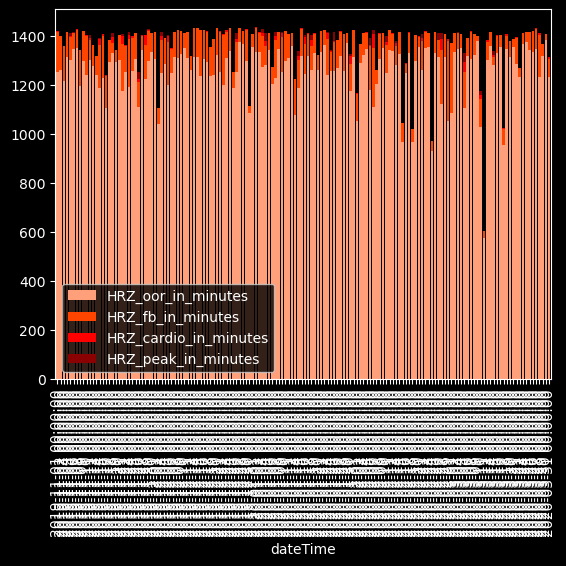

In [81]:
## Experiment 1: Visuals by day, multiple stacked chart.

## Result: Would rather group it by each week;
##   it'd be more neat and intuitive if a user
##   would trace back their days.

fig, ax = plt.subplots()

hrz_in_mins.set_index('dateTime').plot(
    kind='bar', stacked=True, width=0.8, ax=ax, color=HR_zones_color)

In [82]:
hrz_in_mins.dtypes

dateTime                 datetime64[ns]
HRZ_oor_in_minutes              float64
HRZ_fb_in_minutes               float64
HRZ_cardio_in_minutes           float64
HRZ_peak_in_minutes             float64
dtype: object

In [83]:
# The data starts on Friday. To include the whole week,
# Data are grouped weekly starting on Thursday. So 'W-THU'

hrz_weekly = hrz_in_mins.groupby([pd.Grouper
        (key='dateTime', freq='W-Thu')]).agg('sum')

In [84]:
hrz_weekly

HRZ_oor_in_minutes  HRZ_fb_in_minutes  HRZ_cardio_in_minutes  \
dateTime                                                                   
2019-11-07              9049.0              771.0                   14.0   
2019-11-14              8738.0              847.0                   45.0   
2019-11-21              8730.0              773.0                   72.0   
2019-11-28              8687.0              842.0                   76.0   
2019-12-05              8709.0              795.0                   51.0   
2019-12-12              9124.0              629.0                    5.0   
2019-12-19              8941.0              931.0                    4.0   
2019-12-26              8860.0              867.0                   31.0   
2020-01-02              9150.0              499.0                    7.0   
2020-01-09              8924.0              715.0                   65.0   
2020-01-16              8793.0              766.0                   47.0   
2020-01-23              9112.0              610.0                   63.0   
2020-01-30              8900.0              717.0                   41.0   
2020-02-06              8611.0              877.0                   70.0   
2020-02-13              9071.0              562.0                   36.0   
2020-02-20              8497.0              483.0                   10.0   
2020-02-27              8659.0              667.0                   62.0   
2020-03-05              8589.0             1049.0                   57.0   
2020-03-12              8227.0              509.0                   30.0   
2020-03-19              8937.0              393.0                   27.0   
2020-03-26              9294.0              414.0                    9.0   
2020-04-02              6515.0              400.0                   18.0   

            HRZ_peak_in_minutes  
dateTime                         
2019-11-07                 18.0  
2019-11-14                 18.0  
2019-11-21                 26.0  
2019-11-28                 41.0  
2019-12-05                 22.0  
2019-12-12                  0.0  
2019-12-19                  0.0  
2019-12-26                 24.0  
2020-01-02                  0.0  
2020-01-09                 70.0  
2020-01-16                 28.0  
2020-01-23                 25.0  
2020-01-30                 47.0  
2020-02-06                 45.0  
2020-02-13                 29.0  
2020-02-20                  0.0  
2020-02-27                 63.0  
2020-03-05                 39.0  
2020-03-12                 18.0  
2020-03-19                 15.0  
2020-03-26                  0.0  
2020-04-02                  0.0

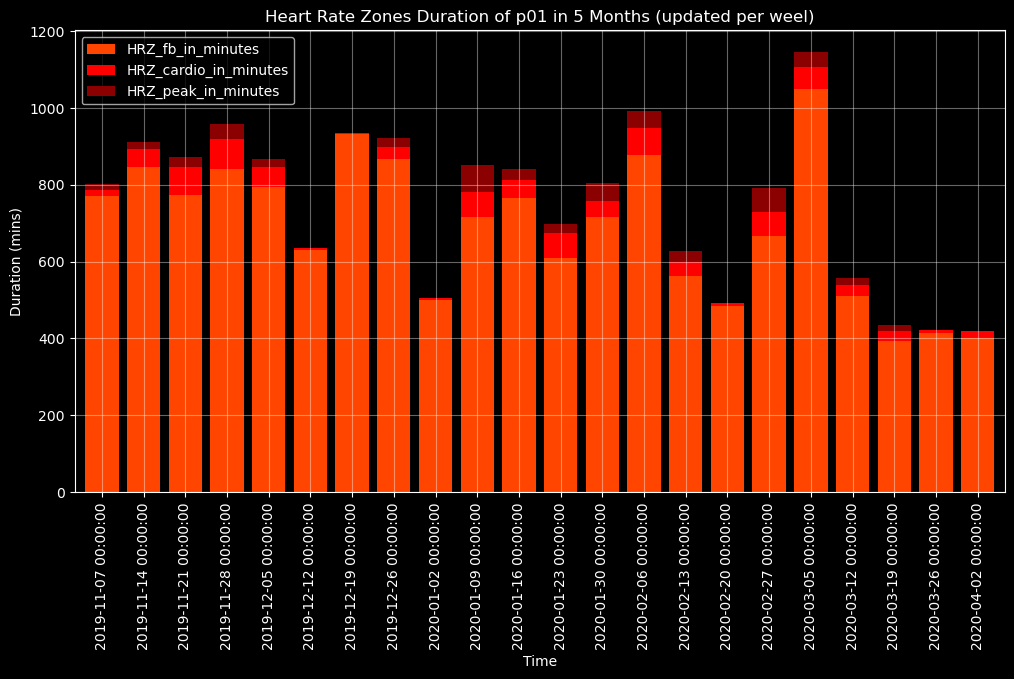

In [85]:
## Experiment 2: Chart by weekly, no OOR
## looking good, intuitive insights!

fig, ax = plt.subplots(figsize=(12, 6))

hrz_weekly.drop('HRZ_oor_in_minutes', axis=1).plot(
    kind='bar', stacked=True, width=0.8, ax=ax, color=HR_zones_color[1:])
ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration (mins)')
ax.grid(alpha=0.4)

# ax.figure.autofmt_xdate(rotation=45, ha='center')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))


In [86]:
HR_zones_color_update = ['#FFFF7D', '#FF9D1C', '#FF6D1C', '#FE251B']

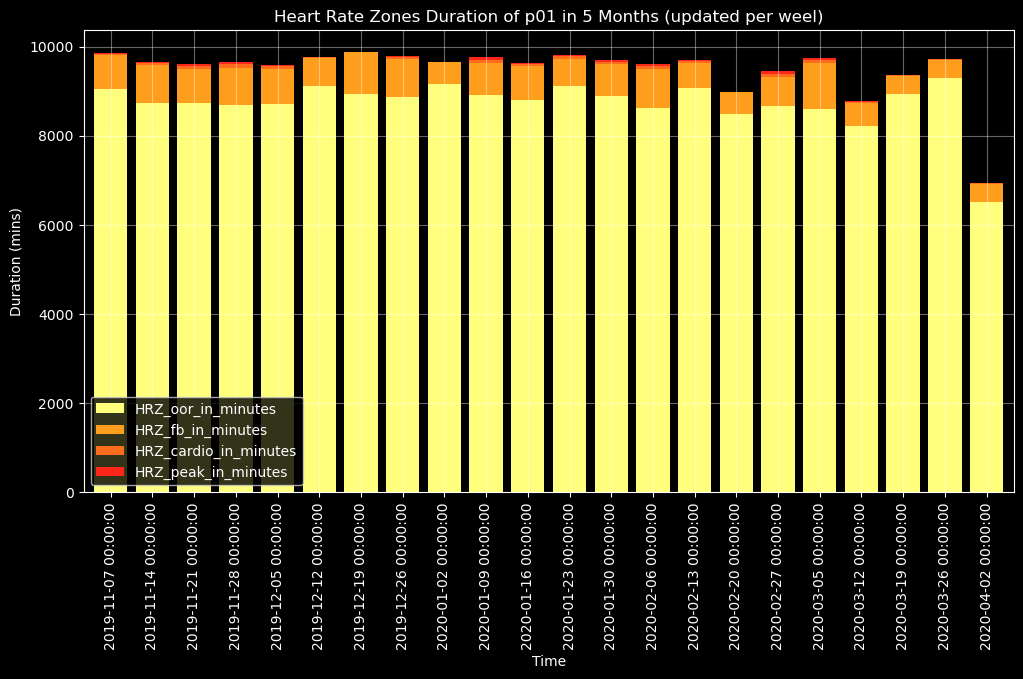

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))

hrz_weekly.plot(kind='bar', stacked=True, 
                width=0.8, ax=ax, color=HR_zones_color_update)
ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration (mins)')
ax.grid(alpha=0.4)

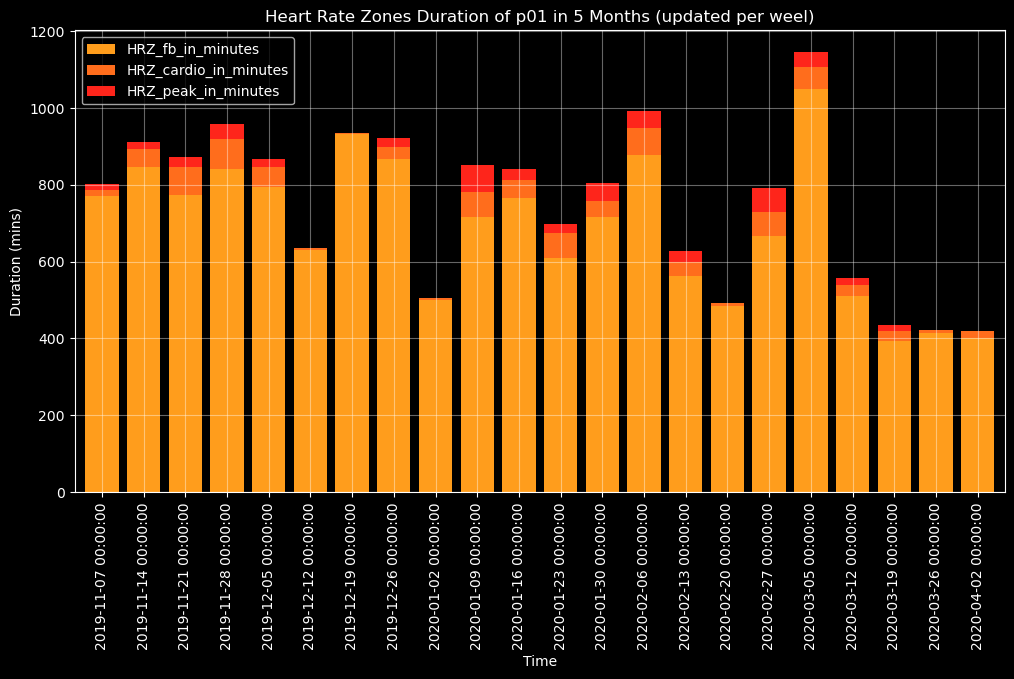

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))

hrz_weekly.drop('HRZ_oor_in_minutes', axis=1).plot(
    kind='bar', stacked=True, width=0.8, ax=ax, color=HR_zones_color_update[1:])
ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration (mins)')
ax.grid(alpha=0.4)

#### Whole: `pXX`

In [89]:
df_hrz_in_mins = pd.DataFrame()

for pXX in id_players:
    hrz_in_mins_pXX = pd.read_json(f"{pXX}/fitbit/time_in_heart_rate_zones.json")
    hrz_in_mins_pXX['pXX'] = pXX
    df_hrz_in_mins = pd.concat(
        [df_hrz_in_mins, hrz_in_mins_pXX])

## Column names following the sequence
df_hrz_col_names = ['dateTime', 'pXX',
    'HRZ_oor_in_minutes', 'HRZ_fb_in_minutes', 
    'HRZ_cardio_in_minutes', 'HRZ_peak_in_minutes']

df_hrz_in_mins = (df_hrz_in_mins.join
   (pd.json_normalize(df_hrz_in_mins['value']))
   .drop('value', axis=1).sort_index(axis=1))

# New kid on the block: _CUSTOM_ZONE
df_hrz_in_mins.head()

dateTime  pXX  valuesInZones.ABOVE_CUSTOM_ZONE  \
0 2019-11-01  p01                              NaN   
0 2019-11-05  p02                              NaN   
0 2019-11-01  p03                              NaN   
0 2019-11-06  p04                              NaN   
0 2019-11-01  p05                              NaN   

   valuesInZones.BELOW_CUSTOM_ZONE  valuesInZones.BELOW_DEFAULT_ZONE_1  \
0                              NaN                              1254.0   
0                              NaN                              1254.0   
0                              NaN                              1254.0   
0                              NaN                              1254.0   
0                              NaN                              1254.0   

   valuesInZones.IN_CUSTOM_ZONE  valuesInZones.IN_DEFAULT_ZONE_1  \
0                           NaN                            164.0   
0                           NaN                            164.0   
0                           NaN                            164.0   
0                           NaN                            164.0   
0                           NaN                            164.0   

   valuesInZones.IN_DEFAULT_ZONE_2  valuesInZones.IN_DEFAULT_ZONE_3  
0                              3.0                              0.0  
0                              3.0                              0.0  
0                              3.0                              0.0  
0                              3.0                              0.0  
0                              3.0                              0.0

In [90]:
df_hrz_in_mins[df_hrz_in_mins['valuesInZones.ABOVE_CUSTOM_ZONE'].notna()]

Empty DataFrame
Columns: [dateTime, pXX, valuesInZones.ABOVE_CUSTOM_ZONE, valuesInZones.BELOW_CUSTOM_ZONE, valuesInZones.BELOW_DEFAULT_ZONE_1, valuesInZones.IN_CUSTOM_ZONE, valuesInZones.IN_DEFAULT_ZONE_1, valuesInZones.IN_DEFAULT_ZONE_2, valuesInZones.IN_DEFAULT_ZONE_3]
Index: []

In [91]:
def clean_data_hrz():

    df_hrz_in_mins = pd.DataFrame()

    for pXX in id_players:
        hrz_in_mins_pXX = pd.read_json(f"{pXX}/fitbit/time_in_heart_rate_zones.json")
        hrz_in_mins_pXX['pXX'] = pXX
        df_hrz_in_mins = pd.concat(
            [df_hrz_in_mins, hrz_in_mins_pXX])
        
    ## Column names following the sequence
    df_hrz_col_names = ['dateTime', 'pXX',
        'HRZ_oor_in_minutes', 'HRZ_fb_in_minutes', 
        'HRZ_cardio_in_minutes', 'HRZ_peak_in_minutes']
    
    ## Dropping new columns on the block
    df_hrz_cols_to_drop = ['value',
        'valuesInZones.ABOVE_CUSTOM_ZONE',
        'valuesInZones.BELOW_CUSTOM_ZONE',
        'valuesInZones.IN_CUSTOM_ZONE']
    
    df_hrz_in_mins = df_hrz_in_mins.join(
        pd.json_normalize(df_hrz_in_mins['value']))
       
    df_hrz_in_mins = df_hrz_in_mins.drop(
        df_hrz_cols_to_drop, axis=1).sort_index(axis=1)
    df_hrz_in_mins.columns = df_hrz_col_names

    # df_hrz_in_mins = df_hrz_in_mins.set_index('dateTime')
    return df_hrz_in_mins

In [92]:
df_hrz_in_mins = clean_data_hrz()

In [93]:
df_hrz_in_mins.sample(5)

dateTime  pXX  HRZ_oor_in_minutes  HRZ_fb_in_minutes  \
33 2019-12-08  p02              1284.0              107.0   
64 2020-01-04  p01              1283.0               77.0   
87 2020-02-01  p07              1318.0              100.0   
30 2019-12-06  p04              1306.0              111.0   
70 2020-01-15  p07              1297.0              124.0   

    HRZ_cardio_in_minutes  HRZ_peak_in_minutes  
33                    2.0                  0.0  
64                   21.0                 31.0  
87                    2.0                  0.0  
30                    0.0                  0.0  
70                    1.0                  0.0

In [94]:
def hrz_chart_per_player(player, startfromzone=0):
    
    ''' Options of 'startfromzone': 
           0: 'oor', 1: 'fb', 2: 'cardio', 3: 'peak' '''
    
    hrz_weekly_pXX = (df_hrz_in_mins[
        df_hrz_in_mins['pXX'] == player].groupby([pd.Grouper
        (key='dateTime', freq='W-Thu')]).agg('sum'))
    
    HR_zones_color_update = [
        '#FFFF7D', '#FF9D1C', '#FF6D1C', '#FE251B']
    
    fig, ax = plt.subplots(figsize=(12, 6))

    hrz_cols_to_drop = (['pXX'] + hrz_weekly_pXX.columns
                        .to_list()[:startfromzone+1])
    
    hrz_weekly_pXX.drop(hrz_cols_to_drop, axis=1).plot(
        kind='bar', stacked=True, width=0.8, ax=ax, 
        color=HR_zones_color_update[startfromzone:])
    ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Duration (mins)')
    ax.grid(alpha=0.4)

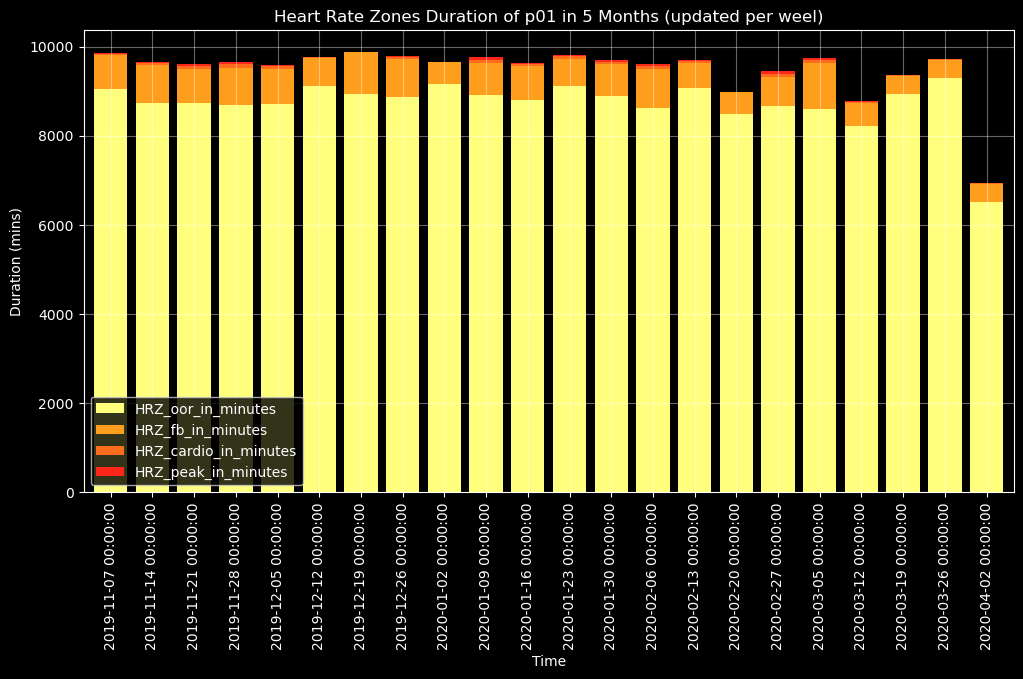

In [95]:
hrz_chart_per_player('p01')

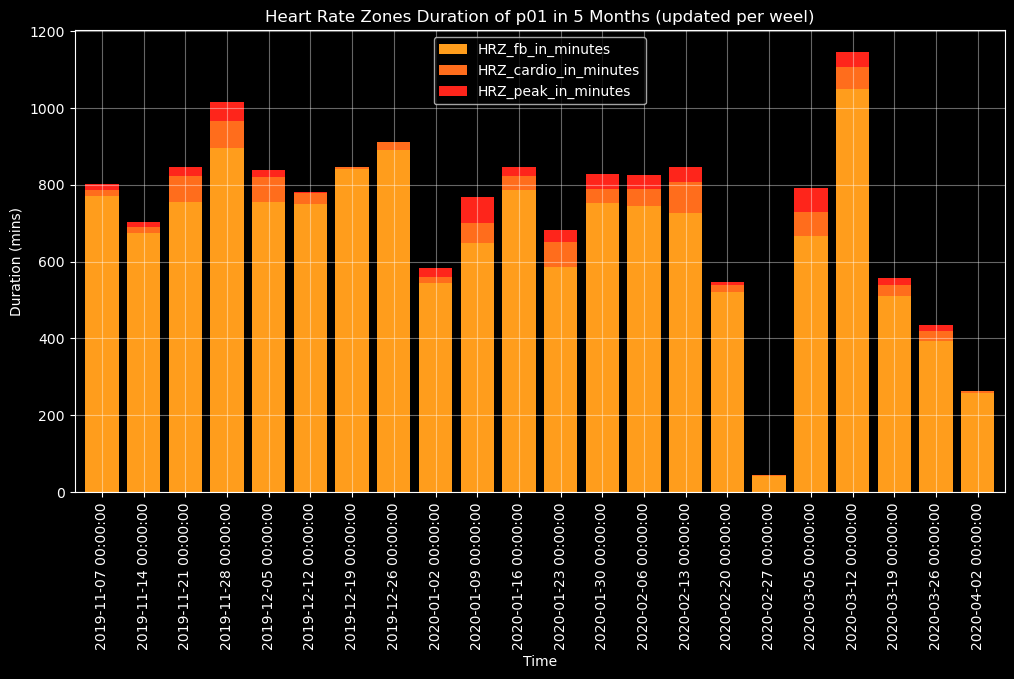

In [96]:
hrz_chart_per_player('p05', startfromzone=1)

### **`XX_minutes`**

#### `sedentary_minutes`

In [97]:
sms = pd.read_json("p01/fitbit/sedentary_minutes.json")
sms = sms.rename(columns={'value': 'sedentary_minutes'})
sms

dateTime  sedentary_minutes
0   2019-11-01                636
1   2019-11-02                709
2   2019-11-03                648
3   2019-11-04                760
4   2019-11-05                737
..         ...                ...
147 2020-03-27                821
148 2020-03-28                679
149 2020-03-29                840
150 2020-03-30                842
151 2020-03-31                837

[152 rows x 2 columns]

#### `lightly_active_minutes`

In [98]:
lams = pd.read_json("p01/fitbit/lightly_active_minutes.json")
lams = lams.rename(columns={'value': 'lightly_active_minutes'})
lams

dateTime  lightly_active_minutes
0   2019-11-01                     245
1   2019-11-02                     202
2   2019-11-03                     262
3   2019-11-04                     230
4   2019-11-05                     263
..         ...                     ...
147 2020-03-27                     181
148 2020-03-28                     207
149 2020-03-29                     145
150 2020-03-30                     161
151 2020-03-31                     155

[152 rows x 2 columns]

#### `moderately_active_minutes`

In [99]:
mams = pd.read_json("p01/fitbit/moderately_active_minutes.json")
mams = mams.rename(columns={'value': 'moderately_active_minutes'})
mams

dateTime  moderately_active_minutes
0   2019-11-01                         58
1   2019-11-02                         43
2   2019-11-03                         63
3   2019-11-04                         23
4   2019-11-05                         22
..         ...                        ...
147 2020-03-27                         28
148 2020-03-28                         69
149 2020-03-29                         19
150 2020-03-30                          6
151 2020-03-31                         23

[152 rows x 2 columns]

#### `very_active_minutes`

In [100]:
vams = pd.read_json("p01/fitbit/very_active_minutes.json")
vams = vams.rename(columns={'value': 'very_active_minutes'})
vams

dateTime  very_active_minutes
0   2019-11-01                   72
1   2019-11-02                   56
2   2019-11-03                   45
3   2019-11-04                   28
4   2019-11-05                   56
..         ...                  ...
147 2020-03-27                   65
148 2020-03-28                   83
149 2020-03-29                   22
150 2020-03-30                    8
151 2020-03-31                   44

[152 rows x 2 columns]

### `steps`

In [101]:
steps = pd.read_json("p01/fitbit/steps.json")
steps['date'] = steps['dateTime'].dt.date
steps

dateTime  value        date
0      2019-11-01 00:00:00      0  2019-11-01
1      2019-11-01 00:01:00      0  2019-11-01
2      2019-11-01 00:02:00      0  2019-11-01
3      2019-11-01 00:03:00      0  2019-11-01
4      2019-11-01 00:04:00      0  2019-11-01
...                    ...    ...         ...
218831 2020-03-31 23:55:00      0  2020-03-31
218832 2020-03-31 23:56:00      0  2020-03-31
218833 2020-03-31 23:57:00      0  2020-03-31
218834 2020-03-31 23:58:00      0  2020-03-31
218835 2020-03-31 23:59:00      0  2020-03-31

[218836 rows x 3 columns]

In [102]:
steps_per_day = (steps.drop('dateTime', axis=1)
    .groupby('date').agg('sum').reset_index()
    .rename(columns={'date': 'dateTime', 'value':'num_steps'})
)
steps_per_day

dateTime  num_steps
0    2019-11-01      17873
1    2019-11-02      13118
2    2019-11-03      14312
3    2019-11-04      10970
4    2019-11-05      16186
..          ...        ...
147  2020-03-27      11532
148  2020-03-28      16448
149  2020-03-29       6698
150  2020-03-30       4761
151  2020-03-31       9351

[152 rows x 2 columns]

### `active_steps`

In [103]:
active_dfs = [steps_per_day, sms, lams, mams, vams]

active_steps = pd.concat(active_dfs, join='outer', axis=1)
active_steps = active_steps.loc[:, ~active_steps.columns.duplicated()]
active_steps['dateTime'] = pd.to_datetime(active_steps['dateTime'])
active_steps

dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
0   2019-11-01      17873                636                     245   
1   2019-11-02      13118                709                     202   
2   2019-11-03      14312                648                     262   
3   2019-11-04      10970                760                     230   
4   2019-11-05      16186                737                     263   
..         ...        ...                ...                     ...   
147 2020-03-27      11532                821                     181   
148 2020-03-28      16448                679                     207   
149 2020-03-29       6698                840                     145   
150 2020-03-30       4761                842                     161   
151 2020-03-31       9351                837                     155   

     moderately_active_minutes  very_active_minutes  
0                           58                   72  
1                           43                   56  
2                           63                   45  
3                           23                   28  
4                           22                   56  
..                         ...                  ...  
147                         28                   65  
148                         69                   83  
149                         19                   22  
150                          6                    8  
151                         23                   44  

[152 rows x 6 columns]

In [104]:
active_steps.dtypes

dateTime                     datetime64[ns]
num_steps                             int64
sedentary_minutes                     int64
lightly_active_minutes                int64
moderately_active_minutes             int64
very_active_minutes                   int64
dtype: object

In [105]:
# The data starts on Friday. To include the whole week,
# Data are grouped weekly starting on Thursday. So 'W-THU'

active_mins_weekly = active_steps.groupby([pd.Grouper
        (key='dateTime', freq='W-Thu')]).agg('sum').reset_index()
active_mins_weekly

dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
0  2019-11-07      89358               5205                    1590   
1  2019-11-14     100497               5097                    1626   
2  2019-11-21      90718               5284                    1488   
3  2019-11-28     105159               4957                    1586   
4  2019-12-05     101072               5146                    1741   
5  2019-12-12      80618               5175                    1753   
6  2019-12-19     109215               4780                    1984   
7  2019-12-26     108278               4236                    2130   
8  2020-01-02      80175               4488                    2097   
9  2020-01-09      95324               5111                    1359   
10 2020-01-16      90609               5125                    1366   
11 2020-01-23      83743               5359                    1527   
12 2020-01-30      90020               4953                    1763   
13 2020-02-06     101475               4461                    2328   
14 2020-02-13      81332               4911                    2033   
15 2020-02-20      71107               5262                    1798   
16 2020-02-27      93046               4994                    2113   
17 2020-03-05     110729               4069                    2572   
18 2020-03-12      75652               5721                    1590   
19 2020-03-19      57332               5504                    1171   
20 2020-03-26      54429               5482                    1201   
21 2020-04-02      48790               4019                     849   

    moderately_active_minutes  very_active_minutes  
0                         230                  283  
1                         209                  436  
2                         222                  439  
3                         231                  497  
4                         235                  411  
5                         168                  249  
6                         239                  413  
7                         288                  455  
8                         129                  207  
9                         180                  515  
10                        230                  427  
11                        172                  345  
12                        214                  365  
13                        231                  405  
14                        125                  242  
15                         90                  185  
16                        192                  250  
17                        380                  350  
18                        140                  227  
19                        130                  219  
20                        113                  240  
21                        145                  222

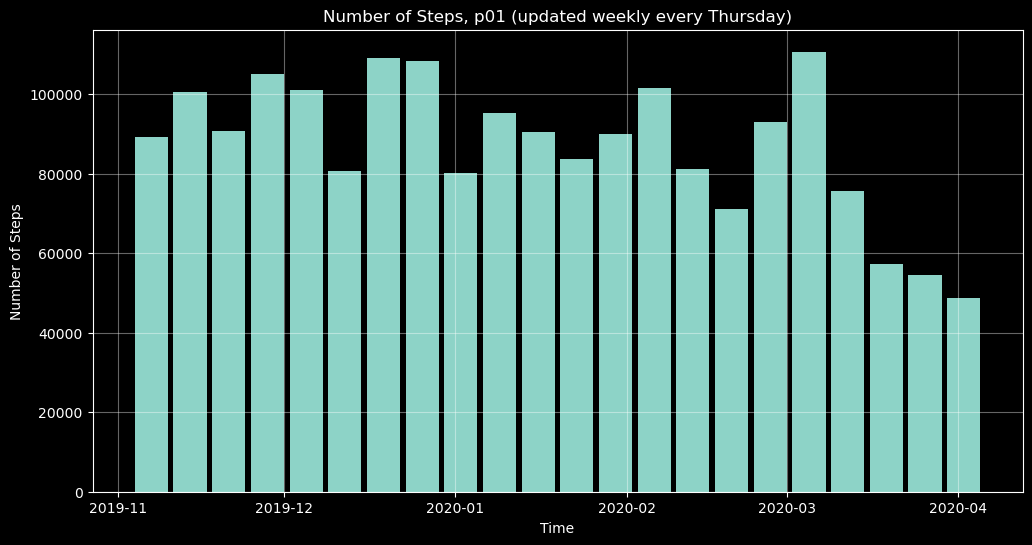

In [106]:
## Suggestion: Make a threshold -- up: red, down: blue

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(active_mins_weekly['dateTime'], 
       active_mins_weekly['num_steps'], width=6)
ax.set_title('Number of Steps, p01 (updated weekly every Thursday)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Steps')
ax.grid(alpha=0.4)

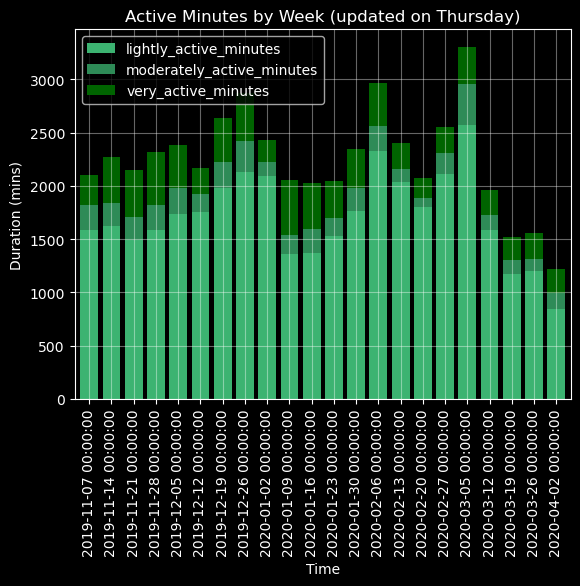

In [107]:
fig, ax = plt.subplots()

active_mins_weekly.drop(['num_steps', 'sedentary_minutes'], axis=1).plot('dateTime',
    kind='bar', stacked=True, width=0.8, ax=ax, color=active_mins_color[1:])
ax.set_title('Active Minutes by Week (updated on Thursday)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration (mins)')
ax.grid(alpha=0.4)

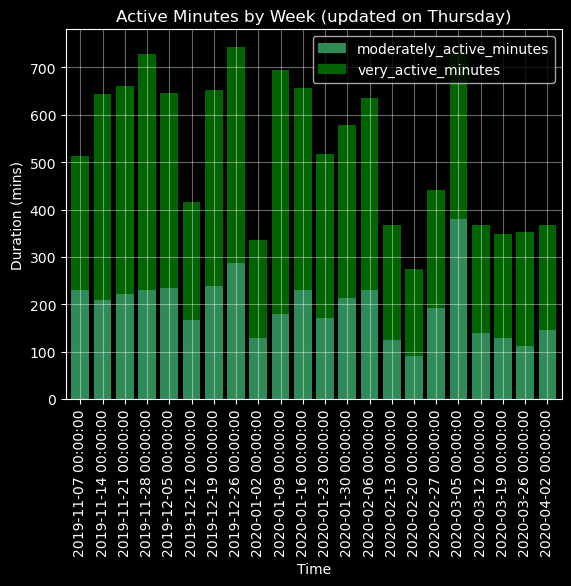

In [108]:
fig, ax = plt.subplots()

active_mins_weekly.drop(
    ['num_steps', 'sedentary_minutes', 'lightly_active_minutes'], axis=1).plot('dateTime',
    kind='bar', stacked=True, width=0.8, ax=ax, color=active_mins_color[2:])
ax.set_title('Active Minutes by Week (updated on Thursday)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration (mins)')
ax.grid(alpha=0.4)

**Whole: `pXX`**

In [109]:
id_players

['p01',
 'p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p07',
 'p08',
 'p09',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16']

In [110]:
df_active_steps_pXX = pd.DataFrame()

df_sms = pd.DataFrame()
df_lams = pd.DataFrame()
df_mams = pd.DataFrame()
df_vams = pd.DataFrame()
df_steps = pd.DataFrame()
df_steps_per_day = pd.DataFrame()

for pXX in id_players:

    try:
        sms_pXX = pd.read_json(f"{pXX}/fitbit/sedentary_minutes.json")
        sms_pXX = sms.rename(columns={'value': 'sedentary_minutes'})
        sms_pXX['pXX'] = pXX
        df_sms = pd.concat([df_sms, sms_pXX])
    except FileNotFoundError as e:
        print(f"File not found: {pXX}/fitbit/sedentary_minutes.json -- Skipping...")

    try:
        lams_pXX = pd.read_json(f"{pXX}/fitbit/lightly_active_minutes.json")
        lams_pXX = lams_pXX.rename(columns={'value': 'lightly_active_minutes'})
        lams_pXX['pXX'] = pXX
        df_lams = pd.concat([df_lams, lams_pXX])
    except FileNotFoundError as e:
        print(f"File not found: {pXX}/fitbit/lightly_active_minutes.json -- Skipping...")

    try:
        mams_pXX = pd.read_json(f"{pXX}/fitbit/moderately_active_minutes.json")
        mams_pXX = mams_pXX.rename(columns={'value': 'moderately_active_minutes'})
        mams_pXX['pXX'] = pXX
        df_mams = pd.concat([df_mams, mams_pXX])
    except FileNotFoundError as e:
        print(f"File not found: {pXX}/fitbit/moderately_active_minutes.json -- Skipping...")

    try:
        vams_pXX = pd.read_json(f"{pXX}/fitbit/very_active_minutes.json")
        vams_pXX = vams_pXX.rename(columns={'value': 'very_active_minutes'})
        vams_pXX['pXX'] = pXX
        df_vams = pd.concat([df_vams, vams_pXX])
    except FileNotFoundError as e:
        print(f"File not found: {pXX}/fitbit/very_active_minutes.json -- Skipping...")

    try:
        steps_pXX = pd.read_json(f"{pXX}/fitbit/steps.json")
        steps_pXX['date'] = steps_pXX['dateTime'].dt.date
        steps_pXX['pXX'] = pXX
        df_steps = pd.concat([df_steps, steps_pXX])
    except FileNotFoundError as e:
        print(f"{pXX}/fitbit/steps.json -- Skipping...")

File not found: p12/fitbit/lightly_active_minutes.json -- Skipping...


In [111]:
df_steps_per_day = (df_steps.drop('dateTime', axis=1)
    .groupby(['pXX', 'date']).agg('sum').reset_index()
    .rename(columns={'date': 'dateTime', 'value':'num_steps'})
)

active_dfs_pXX = [df_steps_per_day, 
      df_sms, df_lams, df_mams, df_vams]

for active_df in active_dfs_pXX:
    # Changing columns of dateTime to str so we can go for pd.merge.
    # Since there are chances a file is missing, doing pd.concat
    # would not put the missing files at place (NaN)
    active_df['dateTime'] = active_df['dateTime'].astype('str')
    
df_active_steps_pXX = reduce(
    lambda left, right: pd.merge(left, right, how='outer',
        on=['pXX', 'dateTime']), active_dfs_pXX)

df_active_steps_pXX = df_active_steps_pXX.sort_values(['pXX', 'dateTime'])

In [112]:
df_steps_per_day

pXX    dateTime  num_steps
0     p01  2019-11-01      17873
1     p01  2019-11-02      13118
2     p01  2019-11-03      14312
3     p01  2019-11-04      10970
4     p01  2019-11-05      16186
...   ...         ...        ...
2173  p16  2020-03-27       2070
2174  p16  2020-03-28        589
2175  p16  2020-03-29       1714
2176  p16  2020-03-30       1773
2177  p16  2020-03-31        777

[2178 rows x 3 columns]

In [113]:
df_active_steps_pXX

pXX    dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
0     p01  2019-11-01    17873.0                636                   245.0   
1     p01  2019-11-02    13118.0                709                   202.0   
2     p01  2019-11-03    14312.0                648                   262.0   
3     p01  2019-11-04    10970.0                760                   230.0   
4     p01  2019-11-05    16186.0                737                   263.0   
...   ...         ...        ...                ...                     ...   
2173  p16  2020-03-27     2070.0                821                    93.0   
2174  p16  2020-03-28      589.0                679                    52.0   
2175  p16  2020-03-29     1714.0                840                    90.0   
2176  p16  2020-03-30     1773.0                842                    69.0   
2177  p16  2020-03-31      777.0                837                    67.0   

      moderately_active_minutes  very_active_minutes  
0                          58.0                 72.0  
1                          43.0                 56.0  
2                          63.0                 45.0  
3                          23.0                 28.0  
4                          22.0                 56.0  
...                         ...                  ...  
2173                        4.0                  5.0  
2174                        0.0                  0.0  
2175                        0.0                  0.0  
2176                        9.0                  4.0  
2177                        0.0                  0.0  

[2432 rows x 7 columns]

In [114]:
df_active_isna_count = pd.DataFrame()
df_active_isna_count['pXX'] = id_players

for col in df_active_steps_pXX.columns[2:]:
    df_active_isna = pd.DataFrame(
        df_active_steps_pXX.loc[
            df_active_steps_pXX[col].isna(), 'pXX']
    .value_counts()).reset_index()
    if df_active_isna.empty:
        df_active_isna_count[col] = 0
    else:
        df_active_isna = df_active_isna.rename(columns={'count': col})
        df_active_isna_count = pd.merge(
            df_active_isna_count, df_active_isna, 
            on='pXX', how='left')

df_active_isna_count = df_active_isna_count.fillna(0)
df_active_isna_count[df_active_isna_count.columns[1:]] = (
    df_active_isna_count[df_active_isna_count.columns[1:]].astype('int'))

def style_negative(v, props = ''):
    return props if v >= 30 else None

df_active_isna_count.set_index('pXX').style.applymap(
    style_negative, props='color:red').applymap(
        lambda v: 'opacity: 20%;' if (v == 0) else None)

In [115]:
df_active_steps_pXX.sort_values(['pXX', 'dateTime'])

pXX    dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
0     p01  2019-11-01    17873.0                636                   245.0   
1     p01  2019-11-02    13118.0                709                   202.0   
2     p01  2019-11-03    14312.0                648                   262.0   
3     p01  2019-11-04    10970.0                760                   230.0   
4     p01  2019-11-05    16186.0                737                   263.0   
...   ...         ...        ...                ...                     ...   
2173  p16  2020-03-27     2070.0                821                    93.0   
2174  p16  2020-03-28      589.0                679                    52.0   
2175  p16  2020-03-29     1714.0                840                    90.0   
2176  p16  2020-03-30     1773.0                842                    69.0   
2177  p16  2020-03-31      777.0                837                    67.0   

      moderately_active_minutes  very_active_minutes  
0                          58.0                 72.0  
1                          43.0                 56.0  
2                          63.0                 45.0  
3                          23.0                 28.0  
4                          22.0                 56.0  
...                         ...                  ...  
2173                        4.0                  5.0  
2174                        0.0                  0.0  
2175                        0.0                  0.0  
2176                        9.0                  4.0  
2177                        0.0                  0.0  

[2432 rows x 7 columns]

In [116]:
## Checking for any missing dates on 
df_active_steps_pXX[df_active_steps_pXX['pXX'] == 'p07'].sort_values('dateTime')

pXX    dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
2225  p07  2019-11-01        NaN                636                     NaN   
2226  p07  2019-11-02        NaN                709                     NaN   
2227  p07  2019-11-03        NaN                648                     NaN   
2228  p07  2019-11-04        NaN                760                     NaN   
2229  p07  2019-11-05        NaN                737                     0.0   
...   ...         ...        ...                ...                     ...   
1007  p07  2020-03-27    20674.0                821                   575.0   
1008  p07  2020-03-28    11656.0                679                   465.0   
1009  p07  2020-03-29     1720.0                840                   115.0   
1010  p07  2020-03-30     8806.0                842                   296.0   
1011  p07  2020-03-31    13805.0                837                   170.0   

      moderately_active_minutes  very_active_minutes  
2225                        NaN                  NaN  
2226                        NaN                  NaN  
2227                        NaN                  NaN  
2228                        NaN                  NaN  
2229                        0.0                  0.0  
...                         ...                  ...  
1007                       73.0                 15.0  
1008                        4.0                  9.0  
1009                        0.0                  0.0  
1010                       42.0                 15.0  
1011                        2.0                 67.0  

[152 rows x 7 columns]

In [117]:
## Problem: You've managed to complete the function.
## But whenever you execute it, you're left with nothing. at all.
### FIGURE OUT WHY, so you can proceed to visualization.

In [118]:
def clean_data_active_minutes_pXX():
    
    df_sms = pd.DataFrame()
    df_lams = pd.DataFrame()
    df_mams = pd.DataFrame()
    df_vams = pd.DataFrame()
    df_steps = pd.DataFrame()
    df_steps_per_day = pd.DataFrame()
    
    df_active_steps_pXX = pd.DataFrame()

    for pXX in id_players:

        try:
            sms_pXX = pd.read_json(f"{pXX}/fitbit/sedentary_minutes.json")
            sms_pXX = sms.rename(columns={'value': 'sedentary_minutes'})
            sms_pXX['pXX'] = pXX
            df_sms = pd.concat([df_sms, sms_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/sedentary_minutes.json -- Skipping...")

        try:
            lams_pXX = pd.read_json(f"{pXX}/fitbit/lightly_active_minutes.json")
            lams_pXX = lams_pXX.rename(columns={'value': 'lightly_active_minutes'})
            lams_pXX['pXX'] = pXX
            df_lams = pd.concat([df_lams, lams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/lightly_active_minutes.json -- Skipping...")

        try:
            mams_pXX = pd.read_json(f"{pXX}/fitbit/moderately_active_minutes.json")
            mams_pXX = mams_pXX.rename(columns={'value': 'moderately_active_minutes'})
            mams_pXX['pXX'] = pXX
            df_mams = pd.concat([df_mams, mams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/moderately_active_minutes.json -- Skipping...")

        try:
            vams_pXX = pd.read_json(f"{pXX}/fitbit/very_active_minutes.json")
            vams_pXX = vams_pXX.rename(columns={'value': 'very_active_minutes'})
            vams_pXX['pXX'] = pXX
            df_vams = pd.concat([df_vams, vams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/very_active_minutes.json -- Skipping...")

        try:
            steps_pXX = pd.read_json(f"{pXX}/fitbit/steps.json")
            steps_pXX['date'] = steps_pXX['dateTime'].dt.date
            steps_pXX['pXX'] = pXX
            df_steps = pd.concat([df_steps, steps_pXX])
        except FileNotFoundError as e:
            print(f"{pXX}/fitbit/steps.json -- Skipping...")
            
    df_steps_per_day = (df_steps.drop('dateTime', axis=1)
    .groupby(['pXX', 'date']).agg('sum').reset_index()
    .rename(columns={'date': 'dateTime', 'value':'num_steps'})
    )

    active_dfs_pXX = [df_steps_per_day, 
          df_sms, df_lams, df_mams, df_vams]

    for active_df in active_dfs_pXX:
        # Changing columns of dateTime to str so we can go for pd.merge.
        # Since there are chances a file is missing, doing pd.concat
        # would not put the missing files at place (NaN)
        active_df['dateTime'] = active_df['dateTime'].astype('str')

    df_active_steps_pXX = reduce(
        lambda left, right: pd.merge(left, right, how='outer',
            on=['pXX', 'dateTime']), active_dfs_pXX)
    
    df_active_steps_pXX = df_active_steps_pXX.sort_values(['pXX', 'dateTime'])
    df_active_steps_pXX['dateTime'] = pd.to_datetime(df_active_steps_pXX['dateTime'])
    
    return df_active_steps_pXX

In [119]:
df_active_steps_pXX = clean_data_active_minutes_pXX()

File not found: p12/fitbit/lightly_active_minutes.json -- Skipping...


In [120]:
df_active_steps_pXX

pXX   dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
0     p01 2019-11-01    17873.0                636                   245.0   
1     p01 2019-11-02    13118.0                709                   202.0   
2     p01 2019-11-03    14312.0                648                   262.0   
3     p01 2019-11-04    10970.0                760                   230.0   
4     p01 2019-11-05    16186.0                737                   263.0   
...   ...        ...        ...                ...                     ...   
2173  p16 2020-03-27     2070.0                821                    93.0   
2174  p16 2020-03-28      589.0                679                    52.0   
2175  p16 2020-03-29     1714.0                840                    90.0   
2176  p16 2020-03-30     1773.0                842                    69.0   
2177  p16 2020-03-31      777.0                837                    67.0   

      moderately_active_minutes  very_active_minutes  
0                          58.0                 72.0  
1                          43.0                 56.0  
2                          63.0                 45.0  
3                          23.0                 28.0  
4                          22.0                 56.0  
...                         ...                  ...  
2173                        4.0                  5.0  
2174                        0.0                  0.0  
2175                        0.0                  0.0  
2176                        9.0                  4.0  
2177                        0.0                  0.0  

[2432 rows x 7 columns]

In [121]:
def count_isna_data_XX_minutes(dataframe):
    
    df_active_isna_count = pd.DataFrame()
    df_active_isna_count['pXX'] = id_players

    for col in dataframe.columns[2:]:
        df_active_isna = pd.DataFrame(
            dataframe.loc[dataframe[col].isna(), 'pXX']
        .value_counts()).reset_index()
        if df_active_isna.empty:
            df_active_isna_count[col] = 0
        else:
            df_active_isna = df_active_isna.rename(columns={'count': col})
            df_active_isna_count = pd.merge(
                df_active_isna_count, df_active_isna, 
                on='pXX', how='left')

    df_active_isna_count = df_active_isna_count.fillna(0)
    df_active_isna_count[df_active_isna_count.columns[1:]] = (
        df_active_isna_count[df_active_isna_count.columns[1:]].astype('int'))

    def style_negative(v, props = ''):
        return props if v >= 30 else None

    df_active_isna_count = (df_active_isna_count
        .set_index('pXX').style.applymap(
        style_negative, props='color:red').applymap(
        lambda v: 'opacity: 20%;' if (v == 0) else None))
    
    return df_active_isna_count

In [122]:
df_active_isna_count = count_isna_data_XX_minutes(df_active_steps_pXX)

In [123]:
df_active_isna_count

In [124]:
df_active_steps_pXX.sample(3)

pXX   dateTime  num_steps  sedentary_minutes  lightly_active_minutes  \
2421  p14 2019-12-01        NaN                630                     0.0   
2157  p16 2020-03-11     2144.0               1225                    95.0   
1632  p12 2020-02-13     9259.0                670                     NaN   

      moderately_active_minutes  very_active_minutes  
2421                        0.0                  0.0  
2157                        0.0                  0.0  
1632                       25.0                 16.0

In [125]:
## I'm trying to do the same thing of pd.Grouper. However,
## seeing that we have 'pXX' into account, we need to 
## convert the dates separately using pd.Series.dt.to_period()

df_active_steps_pXX['dateTime'].dt.to_period("W-THU").dt.end_time.dt.date

0       2019-11-07
1       2019-11-07
2       2019-11-07
3       2019-11-07
4       2019-11-07
           ...    
2173    2020-04-02
2174    2020-04-02
2175    2020-04-02
2176    2020-04-02
2177    2020-04-02
Name: dateTime, Length: 2432, dtype: object

In [126]:
# # The data starts on Friday. To include the whole week,
# # Data are grouped weekly starting on Thursday. So 'W-THU'
# df_active_mins_weekly_pXX = df_active_steps_pXX.groupby(
#     ['pXX', 'dateTime']).agg('sum').reset_index()

In [127]:
# def hrz_chart_per_player(player, startfromzone=0):
    
#     ''' Options of 'startfromzone': 
#            0: 'oor', 1: 'fb', 2: 'cardio', 3: 'peak' '''
    
#     hrz_weekly_pXX = (df_hrz_in_mins[
#         df_hrz_in_mins['pXX'] == player].groupby([pd.Grouper
#         (key='dateTime', freq='W-Thu')]).agg('sum'))
    
#     HR_zones_color_update = [
#         '#FFFF7D', '#FF9D1C', '#FF6D1C', '#FE251B']
    
#     fig, ax = plt.subplots(figsize=(12, 6))

#     hrz_cols_to_drop = (['pXX'] + hrz_weekly_pXX.columns
#                         .to_list()[:startfromzone+1])
    
#     hrz_weekly_pXX.drop(hrz_cols_to_drop, axis=1).plot(
#         kind='bar', stacked=True, width=0.8, ax=ax, 
#         color=HR_zones_color_update[startfromzone:])
#     ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Duration (mins)')
#     ax.grid(alpha=0.4)

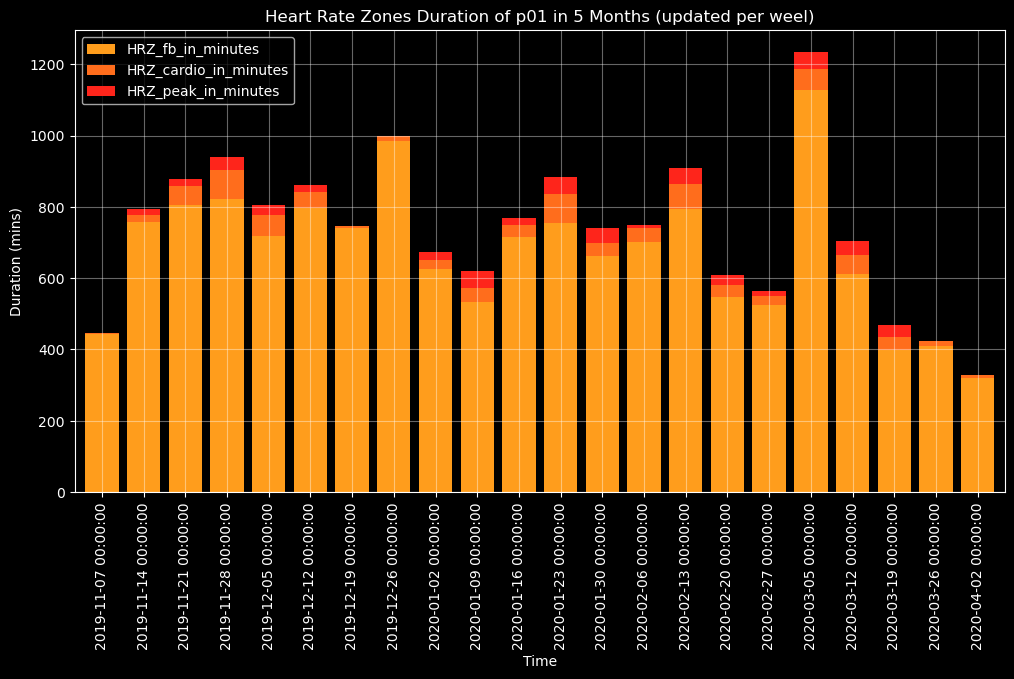

In [128]:
hrz_chart_per_player('p02', startfromzone=1)

In [129]:
startfromzone = 1
active_legends = 'lower right' if startfromzone == 0 else 'best'
active_legends

'best'

In [130]:
def active_mins_chart_per_player(player, num_steps=True, startfromzone=0):

    '''
    Parameters:
    - player: Number of player
    - withstep: Displaying charts: number_of_step
    - startfromzone: [0, 1, 2, 3] as in sequence of:
        [sedentary_minutes, lightly_active_minutes,
         moderately_active_minutes, very_active_minutes]
    '''
    
    df_active_per_player = df_active_steps_pXX.loc[
        df_active_steps_pXX['pXX'] == player].copy()
    
    # The data starts on Friday. To include the whole week,
    # Data are grouped weekly starting on Thursday. So 'W-THU'
    
    ## I'm trying to do the same thing of pd.Grouper. However,
    ## seeing that we have 'pXX' into account, we need to 
    ## convert the dates separately using pd.Series.dt.to_period()
    
    df_active_per_player['dateTime'] = (
        df_active_per_player['dateTime']
            .dt.to_period("W-THU").dt.end_time.dt.date)
    
    df_active_mins_weekly_pXX = df_active_per_player.groupby(
            ['pXX', 'dateTime']).agg('sum')
    
    # We're dropping num_steps (first col) + column of 
    # non-preference, looking at parameter of `startfromzone`
    active_cols_to_drop = (df_active_mins_weekly_pXX.columns
                           .to_list()[:startfromzone+1])
    active_mins_color = ['lightseagreen', 'mediumseagreen', 'seagreen', 'darkgreen']

    if num_steps:
    
        fig, ax = plt.subplots(figsize=(12, 6))

        df_active_mins_weekly_pXX['num_steps'].plot(
            kind='bar', width=0.8, ax=ax)
        ax.set_title('Active Minutes by Week (updated on Thursday)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Duration (mins)')
        ax.legend(loc='best')
        ax.grid(alpha=0.4)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    active_legends = 'lower right' if startfromzone == 0 else 'best'
        
    df_active_mins_weekly_pXX.drop(active_cols_to_drop, axis=1).plot(
        kind='bar', stacked=True, width=0.8, ax=ax, 
        color=active_mins_color[startfromzone:])
    ax.set_title('Active Minutes by Week (updated on Thursday)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Duration (mins)')
    ax.legend(loc=active_legends)
    ax.grid(alpha=0.4)

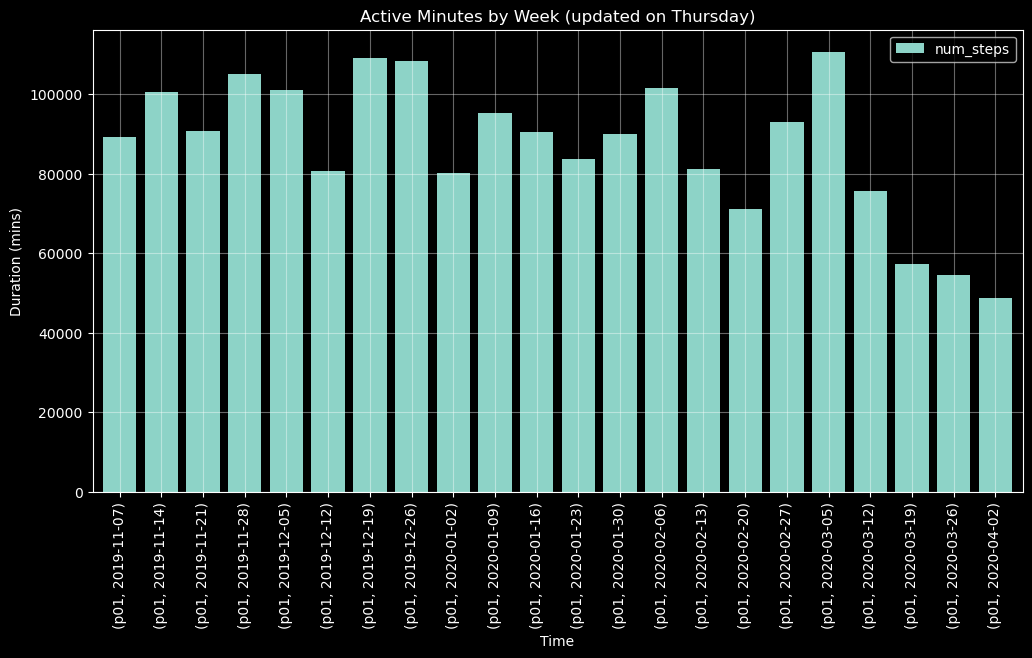

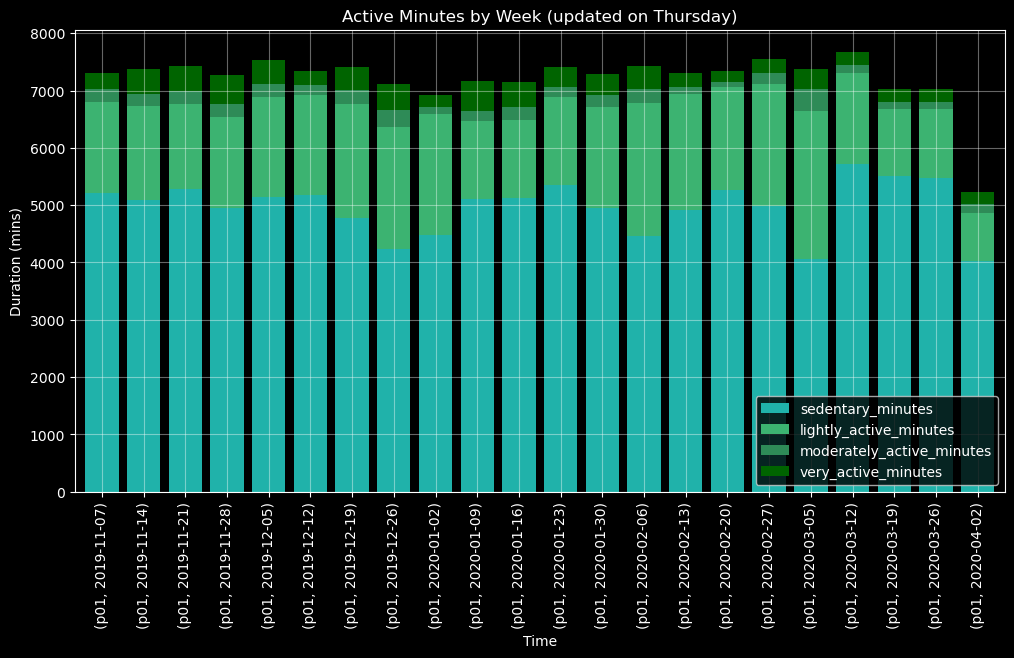

In [131]:
active_mins_chart_per_player('p01')

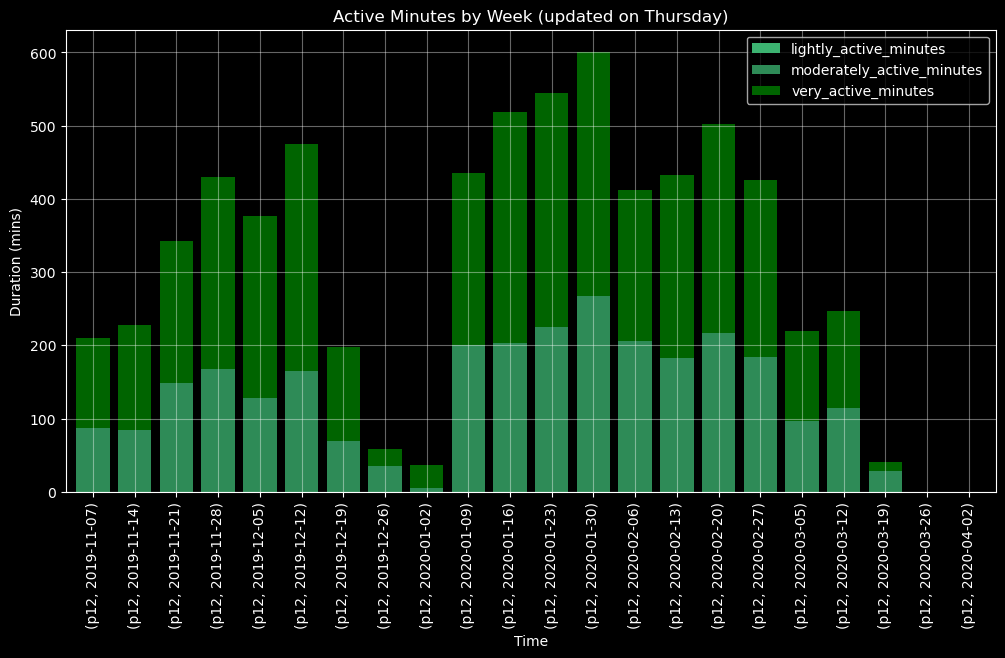

In [132]:
# Check p12, he's missing lightly_active_minutes.
# Therefore the datq should not be in the visuals.
active_mins_chart_per_player('p12', num_steps=False, startfromzone=1)

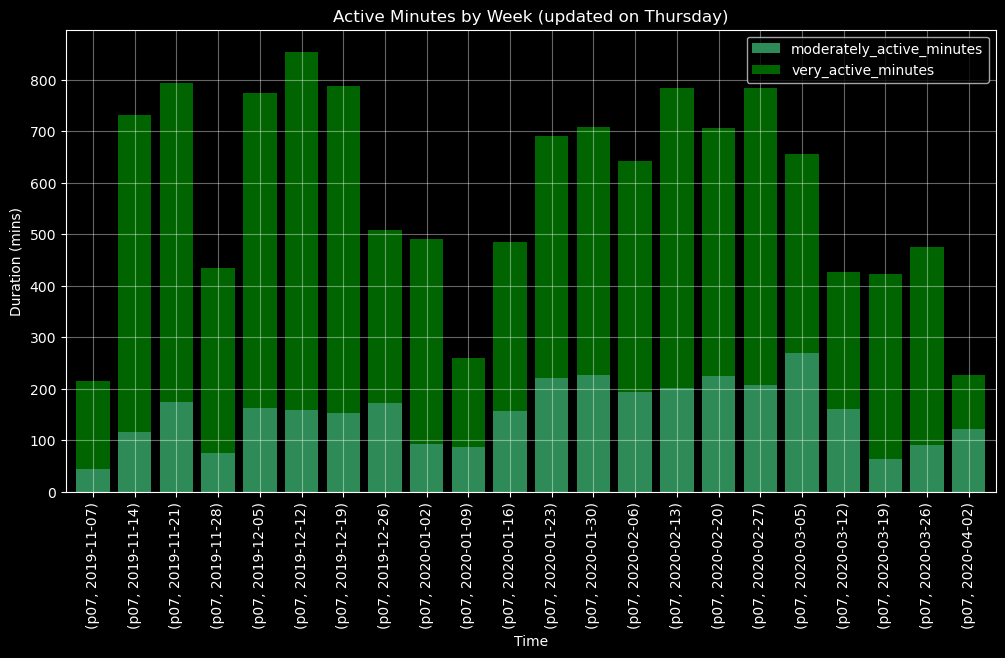

In [133]:
active_mins_chart_per_player('p07', num_steps=False, startfromzone=2)

In [134]:
## CHECKPOINT

### Heart Rates

#### `heart_rate`

In [135]:
HR = pd.read_json("p01/fitbit/heart_rate.json")
HR

dateTime                         value
0       2019-11-01 00:00:05  {'bpm': 54, 'confidence': 3}
1       2019-11-01 00:00:10  {'bpm': 52, 'confidence': 3}
2       2019-11-01 00:00:20  {'bpm': 51, 'confidence': 3}
3       2019-11-01 00:00:25  {'bpm': 52, 'confidence': 3}
4       2019-11-01 00:00:30  {'bpm': 51, 'confidence': 3}
...                     ...                           ...
1573160 2020-03-31 23:59:18  {'bpm': 55, 'confidence': 3}
1573161 2020-03-31 23:59:23  {'bpm': 54, 'confidence': 3}
1573162 2020-03-31 23:59:33  {'bpm': 56, 'confidence': 3}
1573163 2020-03-31 23:59:48  {'bpm': 56, 'confidence': 3}
1573164 2020-03-31 23:59:58  {'bpm': 55, 'confidence': 3}

[1573165 rows x 2 columns]

In [136]:
HR = (HR.join(pd.json_normalize(HR['value']))
        .drop('value', axis=1)
        .rename(columns={'bpm':'hr_bpm'}))
HR

dateTime  hr_bpm  confidence
0       2019-11-01 00:00:05      54           3
1       2019-11-01 00:00:10      52           3
2       2019-11-01 00:00:20      51           3
3       2019-11-01 00:00:25      52           3
4       2019-11-01 00:00:30      51           3
...                     ...     ...         ...
1573160 2020-03-31 23:59:18      55           3
1573161 2020-03-31 23:59:23      54           3
1573162 2020-03-31 23:59:33      56           3
1573163 2020-03-31 23:59:48      56           3
1573164 2020-03-31 23:59:58      55           3

[1573165 rows x 3 columns]

In [137]:
HR[:17]

dateTime  hr_bpm  confidence
0  2019-11-01 00:00:05      54           3
1  2019-11-01 00:00:10      52           3
2  2019-11-01 00:00:20      51           3
3  2019-11-01 00:00:25      52           3
4  2019-11-01 00:00:30      51           3
5  2019-11-01 00:00:35      52           3
6  2019-11-01 00:00:45      53           3
7  2019-11-01 00:00:50      56           3
8  2019-11-01 00:00:55      54           3
9  2019-11-01 00:01:00      53           3
10 2019-11-01 00:01:15      52           3
11 2019-11-01 00:01:25      53           3
12 2019-11-01 00:01:30      54           3
13 2019-11-01 00:01:35      53           3
14 2019-11-01 00:01:45      58           3
15 2019-11-01 00:01:50      57           3
16 2019-11-01 00:01:55      52           3

In [138]:
HR.dtypes

dateTime      datetime64[ns]
hr_bpm                 int64
confidence             int64
dtype: object

In [139]:
## Chunking data into bits of 6-hours x 4 in one day,
## making a total data of 

HR_per_six_hour = HR.groupby(
    [pd.Grouper(key='dateTime', freq='6h')]).agg(
        ['mean', 'max', 'min']).reset_index()
# HR_per_six_hour['confidence'] = np.round(HR_per_six_hour['confidence'], 0)
HR_per_six_hour

dateTime     hr_bpm          confidence        
                              mean  max min       mean max min
0   2019-11-01 00:00:00  57.352319  121  47   2.770545   3   0
1   2019-11-01 06:00:00  66.877109  101  53   1.896185   3   1
2   2019-11-01 12:00:00  73.846928  140  47   1.800069   3   0
3   2019-11-01 18:00:00  65.141109  110  46   2.043212   3   0
4   2019-11-02 00:00:00  51.235637   80  46   2.919643   3   1
..                  ...        ...  ...  ..        ...  ..  ..
603 2020-03-30 18:00:00  57.494318   91  47   1.523864   3   1
604 2020-03-31 00:00:00  54.344924   91  47   2.470424   3   0
605 2020-03-31 06:00:00  63.810317  128  47   1.139172   3   0
606 2020-03-31 12:00:00  73.035879  140  52   1.099467   3   0
607 2020-03-31 18:00:00  58.663110   96  45   1.720274   3   1

[608 rows x 7 columns]

In [140]:
new_cols = ['datetime'] + ['_'.join(pair) for pair in HR_per_six_hour.columns[1:]]
HR_per_six_hour.columns = HR_per_six_hour.columns.droplevel(0)
HR_per_six_hour.columns = new_cols

HR_per_six_hour

datetime  hr_bpm_mean  hr_bpm_max  hr_bpm_min  confidence_mean  \
0   2019-11-01 00:00:00    57.352319         121          47         2.770545   
1   2019-11-01 06:00:00    66.877109         101          53         1.896185   
2   2019-11-01 12:00:00    73.846928         140          47         1.800069   
3   2019-11-01 18:00:00    65.141109         110          46         2.043212   
4   2019-11-02 00:00:00    51.235637          80          46         2.919643   
..                  ...          ...         ...         ...              ...   
603 2020-03-30 18:00:00    57.494318          91          47         1.523864   
604 2020-03-31 00:00:00    54.344924          91          47         2.470424   
605 2020-03-31 06:00:00    63.810317         128          47         1.139172   
606 2020-03-31 12:00:00    73.035879         140          52         1.099467   
607 2020-03-31 18:00:00    58.663110          96          45         1.720274   

     confidence_max  confidence_min  
0                 3               0  
1                 3               1  
2                 3               0  
3                 3               0  
4                 3               1  
..              ...             ...  
603               3               1  
604               3               0  
605               3               0  
606               3               0  
607               3               1  

[608 rows x 7 columns]

In [141]:
HR_per_six_hour = HR_per_six_hour.drop(['confidence_max', 'confidence_min'], axis=1)
HR_per_six_hour['confidence_mean'] = np.rint(HR_per_six_hour['confidence_mean'])
HR_per_six_hour

datetime  hr_bpm_mean  hr_bpm_max  hr_bpm_min  confidence_mean
0   2019-11-01 00:00:00    57.352319         121          47              3.0
1   2019-11-01 06:00:00    66.877109         101          53              2.0
2   2019-11-01 12:00:00    73.846928         140          47              2.0
3   2019-11-01 18:00:00    65.141109         110          46              2.0
4   2019-11-02 00:00:00    51.235637          80          46              3.0
..                  ...          ...         ...         ...              ...
603 2020-03-30 18:00:00    57.494318          91          47              2.0
604 2020-03-31 00:00:00    54.344924          91          47              2.0
605 2020-03-31 06:00:00    63.810317         128          47              1.0
606 2020-03-31 12:00:00    73.035879         140          52              1.0
607 2020-03-31 18:00:00    58.663110          96          45              2.0

[608 rows x 5 columns]

In [142]:
HR_per_six_hour.sort_values('confidence_mean')

datetime  hr_bpm_mean  hr_bpm_max  hr_bpm_min  confidence_mean
483 2020-02-29 18:00:00    73.970054         139          52              1.0
461 2020-02-24 06:00:00    67.959024         121          52              1.0
462 2020-02-24 12:00:00    73.666964         110          56              1.0
463 2020-02-24 18:00:00    60.577999         119          47              1.0
465 2020-02-25 06:00:00    69.226976         115          50              1.0
..                  ...          ...         ...         ...              ...
204 2019-12-22 00:00:00    50.269829          73          45              3.0
480 2020-02-29 00:00:00    57.687896          79          50              3.0
336 2020-01-24 00:00:00    54.238206         100          45              3.0
516 2020-03-09 00:00:00    52.059984         101          33              3.0
0   2019-11-01 00:00:00    57.352319         121          47              3.0

[608 rows x 5 columns]

#### Attempts on Visuals

In [143]:
## Experiment 1:
## In mind: bar-chart, min to max. Line plot, mean. 
## Confidence, color. 3: green, 2: gray, 1: red

In [144]:
conf_colors = {3: 'green', 2: 'gray', 1: 'red'}
bar_diffs   = HR_per_six_hour['hr_bpm_max'] - HR_per_six_hour['hr_bpm_min']
bar_colors  = HR_per_six_hour['confidence_mean'].map(conf_colors)

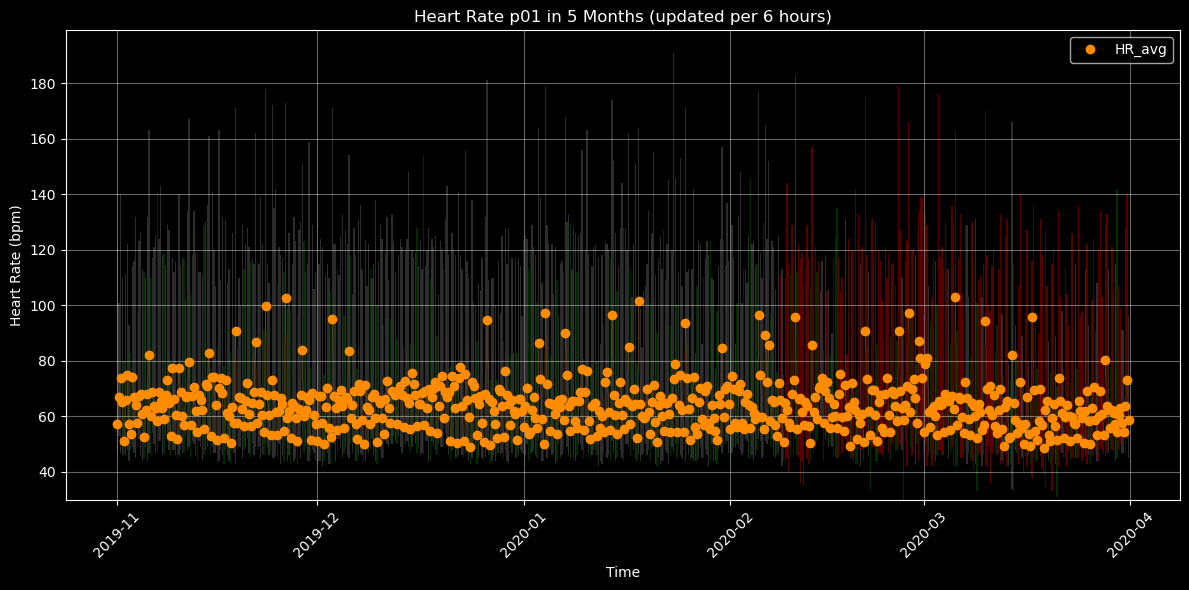

In [145]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(HR_per_six_hour['datetime'], bar_diffs,
    bottom = HR_per_six_hour['hr_bpm_min'], 
    color = bar_colors, alpha = 0.35, width = 0.2)

ax.plot(HR_per_six_hour['datetime'], HR_per_six_hour['hr_bpm_mean'],
    color = 'darkorange', linewidth = 0.1, marker = 'o', label = 'HR_avg')

ax.set_title('Heart Rate p01 in 5 Months (updated per 6 hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Heart Rate (bpm)')
ax.grid(alpha=0.4)
ax.legend(['HR_avg'], loc='best')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:
HR_per_six_hour.dtypes

datetime           datetime64[ns]
hr_bpm_mean               float64
hr_bpm_max                  int64
hr_bpm_min                  int64
confidence_mean           float64
dtype: object

In [147]:
## Experiment 1.1: Make it the latest 30 days (so last 120 rows)
## Code above are made into function for convenience.

from matplotlib.patches import Patch

def heart_rate_chart(days):

    fig, ax = plt.subplots(figsize=(12, 6))
    i_start = -1 * (4 * days + 1)
    # Add by one since last day only display 3 rows, not 4.
    
    ax.bar(HR_per_six_hour['datetime'][i_start:], bar_diffs[i_start:],
        bottom = HR_per_six_hour['hr_bpm_min'][i_start:], 
        color = bar_colors[i_start:], alpha = 0.6, width = 0.2)

    ax.plot(
        HR_per_six_hour['datetime'][i_start:], 
        HR_per_six_hour['hr_bpm_mean'][i_start:],
        color = 'white', linewidth = 1, 
        marker = 'o', label = 'HR_avg')

    ax.set_title(f'Heart Rate p01 in latest {days} days (updated per 6 hours)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Heart Rate (bpm)')
    ax.grid(alpha=0.4)
    
    legend_elements = [
        Patch(facecolor=conf_colors[3], edgecolor='none', alpha=0.5, label='Confidence = 3'),
        Patch(facecolor=conf_colors[2], edgecolor='none', alpha=0.5, label='Confidence = 2'),
        Patch(facecolor=conf_colors[1], edgecolor='none', alpha=0.5, label='Confidence = 1')
    ]
    
    ax.legend(handles = legend_elements + 
        [Patch(color='white', label='HR_avg')], loc='best')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

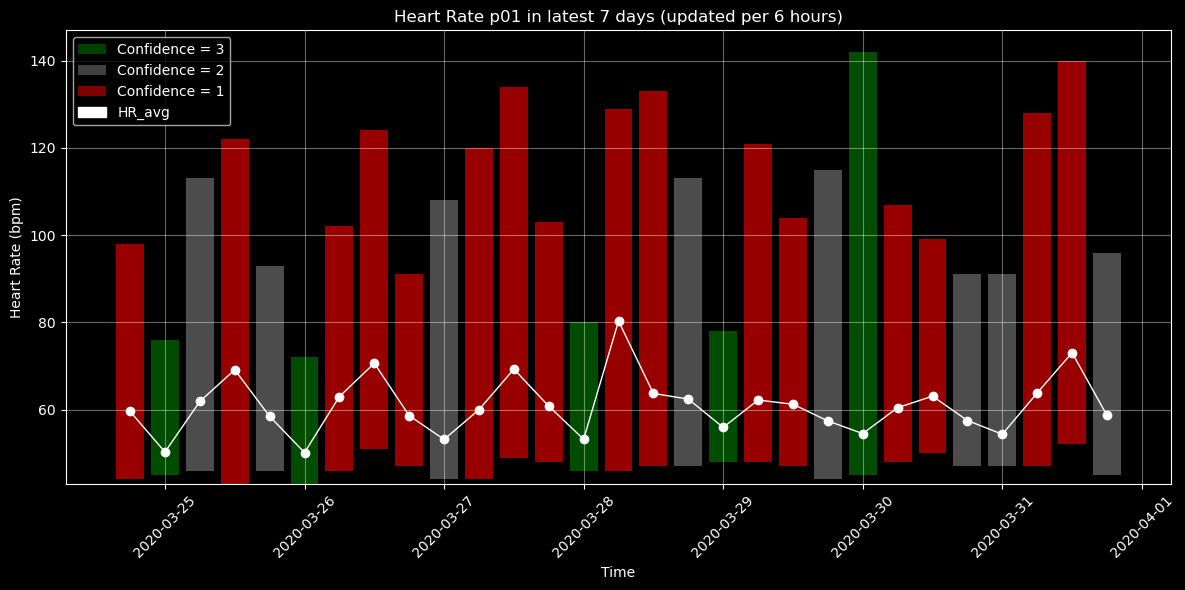

In [148]:
heart_rate_chart(7)

In [149]:
# Experiment 1.2:
# The measurement's correct, but since it's grouped
# from real-time to each 6 hours, HR fluctuates in active hours.

# Displaying three different colors would create misunderstandings,
# let's change colors to make grounds of confidence. Light to darker.

# conf_colors = {3: '#A7F25C', 2: '#5C7AF2', 1: '#F27E5C'}
# conf_colors = {3: '#B0FF61', 2: '#6181FF', 1: '#FF8561'}
# conf_colors = {3: '#A7F25C', 2: '#879D70', 1: '#3F4836'}
conf_colors = {3: '#91FF61', 2: '#88AA79', 1: '#465540'}

bar_colors  = HR_per_six_hour['confidence_mean'].map(conf_colors)

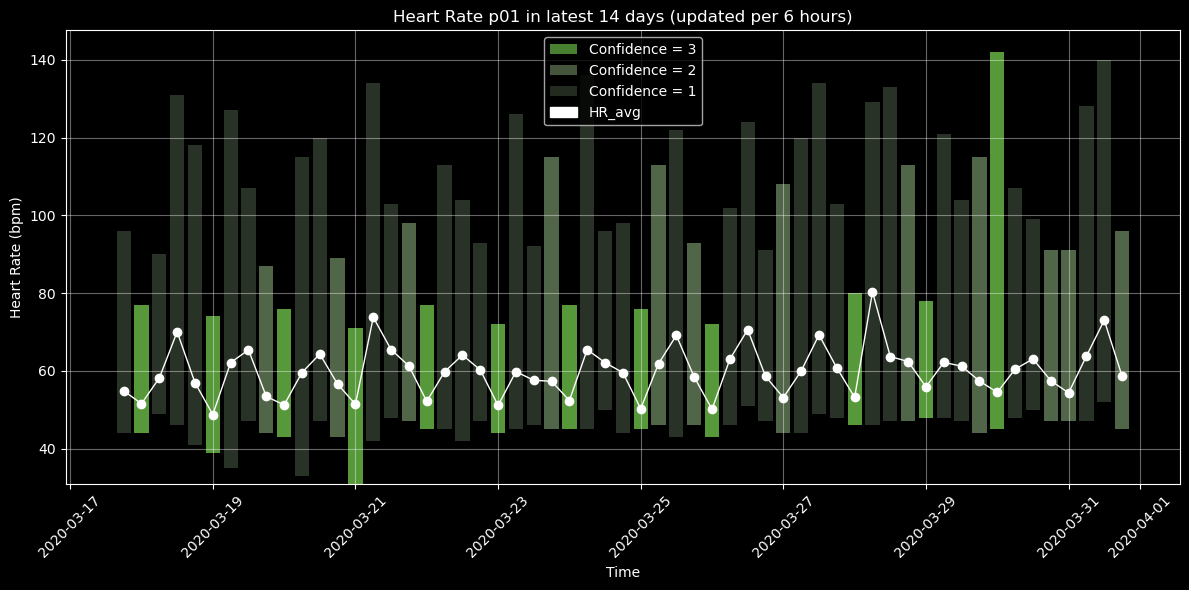

In [150]:
plt.style.use('dark_background')

heart_rate_chart(14)

#### **Whole: `pXX`**

Since we're dealing with almost 1,5 million data per player, we're going to clean the data not as a whole, but as one player, defined at the first function.

This way the time of execution will be way faster than collecting and grouping 24 millions of data at once.

In [151]:
# # IMPORTANT:
# ## How to aggregate both `pXX` and dateTime per 6h?
# df_HR_per_six_hour = HR.groupby(
#     [pd.Grouper(key='dateTime', freq='6h')]).agg(
#         ['mean', 'max', 'min']).reset_index()

# new_cols = ['datetime'] + ['_'.join(pair) for pair in HR_per_six_hour.columns[1:]]
# HR_per_six_hour.columns = HR_per_six_hour.columns.droplevel(0)
# HR_per_six_hour.columns = new_cols

# HR_per_six_hour = HR_per_six_hour.drop(['confidence_max', 'confidence_min'], axis=1)
# HR_per_six_hour['confidence_mean'] = np.rint(HR_per_six_hour['confidence_mean'])

In [152]:
## CHECKPOINT 20241216
## What's left: `sleep`, `googledocs`, `heartrate`
##   And then we can move onto polishing the vizzes

In [153]:
HR_pXX = pd.read_json(f"p02/fitbit/heart_rate.json")
HR_pXX = (HR_pXX.join(pd.json_normalize(HR_pXX['value']))
        .drop('value', axis=1).rename(columns={'bpm':'hr_bpm'}))
HR_pXX

dateTime  hr_bpm  confidence
0       2019-11-05 21:11:40      70           1
1       2019-11-05 21:11:45      67           1
2       2019-11-05 21:12:05      67           1
3       2019-11-05 21:12:20      66           1
4       2019-11-05 21:40:01      68           0
...                     ...     ...         ...
1472624 2020-03-31 21:59:39      54           2
1472625 2020-03-31 21:59:44      55           2
1472626 2020-03-31 21:59:49      54           2
1472627 2020-03-31 21:59:54      53           2
1472628 2020-03-31 21:59:59      48           2

[1472629 rows x 3 columns]

In [154]:
HR_pXX['dateTime'] = HR_pXX['dateTime'].dt.floor('6h')
HR_pXX_per_six_hour = HR_pXX.groupby('dateTime').agg(
    ['mean', 'max', 'min'])
HR_pXX_per_six_hour

hr_bpm          confidence        
                          mean  max min       mean max min
dateTime                                                  
2019-11-05 18:00:00  51.381818  104  40   2.345455   3   0
2019-11-06 00:00:00  43.506557   71  40   2.738251   3   0
2019-11-06 06:00:00  72.650781  113  41   1.366064   3   0
2019-11-06 12:00:00  95.971930  182  44   1.727485   3   0
2019-11-06 18:00:00  73.067459  152  46   2.241089   3   0
...                        ...  ...  ..        ...  ..  ..
2020-03-30 18:00:00  49.139680   83  39   1.980101   3   0
2020-03-31 00:00:00  42.707746   82  37   2.606954   3   0
2020-03-31 06:00:00  72.727673  116  39   1.453586   3   0
2020-03-31 12:00:00  61.863816  114  40   1.737926   3   0
2020-03-31 18:00:00  53.416966   83  44   1.757009   3   0

[580 rows x 6 columns]

In [155]:
new_cols = ['dateTime'] + ['_'.join(pair) 
    for pair in HR_pXX_per_six_hour.columns[1:]]
HR_pXX_per_six_hour.columns = HR_pXX_per_six_hour.columns.droplevel(0)
HR_pXX_per_six_hour.columns = new_cols

HR_pXX_per_six_hour

dateTime  hr_bpm_max  hr_bpm_min  confidence_mean  \
dateTime                                                                  
2019-11-05 18:00:00  51.381818         104          40         2.345455   
2019-11-06 00:00:00  43.506557          71          40         2.738251   
2019-11-06 06:00:00  72.650781         113          41         1.366064   
2019-11-06 12:00:00  95.971930         182          44         1.727485   
2019-11-06 18:00:00  73.067459         152          46         2.241089   
...                        ...         ...         ...              ...   
2020-03-30 18:00:00  49.139680          83          39         1.980101   
2020-03-31 00:00:00  42.707746          82          37         2.606954   
2020-03-31 06:00:00  72.727673         116          39         1.453586   
2020-03-31 12:00:00  61.863816         114          40         1.737926   
2020-03-31 18:00:00  53.416966          83          44         1.757009   

                     confidence_max  confidence_min  
dateTime                                             
2019-11-05 18:00:00               3               0  
2019-11-06 00:00:00               3               0  
2019-11-06 06:00:00               3               0  
2019-11-06 12:00:00               3               0  
2019-11-06 18:00:00               3               0  
...                             ...             ...  
2020-03-30 18:00:00               3               0  
2020-03-31 00:00:00               3               0  
2020-03-31 06:00:00               3               0  
2020-03-31 12:00:00               3               0  
2020-03-31 18:00:00               3               0  

[580 rows x 6 columns]

In [156]:
HR_pXX_per_six_hour = HR_pXX_per_six_hour.drop(
    ['confidence_max', 'confidence_min'], axis=1)
HR_pXX_per_six_hour['confidence_mean'] = np.rint(
    HR_pXX_per_six_hour['confidence_mean'])

HR_pXX_per_six_hour

dateTime  hr_bpm_max  hr_bpm_min  confidence_mean
dateTime                                                               
2019-11-05 18:00:00  51.381818         104          40              2.0
2019-11-06 00:00:00  43.506557          71          40              3.0
2019-11-06 06:00:00  72.650781         113          41              1.0
2019-11-06 12:00:00  95.971930         182          44              2.0
2019-11-06 18:00:00  73.067459         152          46              2.0
...                        ...         ...         ...              ...
2020-03-30 18:00:00  49.139680          83          39              2.0
2020-03-31 00:00:00  42.707746          82          37              3.0
2020-03-31 06:00:00  72.727673         116          39              1.0
2020-03-31 12:00:00  61.863816         114          40              2.0
2020-03-31 18:00:00  53.416966          83          44              2.0

[580 rows x 4 columns]

In [157]:
def clean_data_heart_rate_pXX(player):
    
    HR_pXX = pd.read_json(f"{player}/fitbit/heart_rate.json")

    HR_pXX = (HR_pXX.join(pd.json_normalize(HR_pXX['value']))
        .drop('value', axis=1).rename(columns={'bpm':'hr_bpm'}))

    HR_pXX['dateTime'] = HR_pXX['dateTime'].dt.floor('6h')
    HR_pXX_per_six_hour = HR_pXX.groupby('dateTime').agg(
        ['mean', 'max', 'min']).reset_index()

    new_cols = ['datetime'] + ['_'.join(pair) 
        for pair in HR_pXX_per_six_hour.columns[1:]]
    HR_pXX_per_six_hour.columns = HR_pXX_per_six_hour.columns.droplevel(0)
    HR_pXX_per_six_hour.columns = new_cols
    
    HR_pXX_per_six_hour = HR_pXX_per_six_hour.drop(
        ['confidence_max', 'confidence_min'], axis=1)
    HR_pXX_per_six_hour['confidence_mean'] = np.rint(
        HR_pXX_per_six_hour['confidence_mean'])
    
    HR_pXX_per_six_hour['pXX'] = player
    
    return HR_pXX_per_six_hour

In [158]:
HR_p05_per_six_hour = clean_data_heart_rate_pXX('p05')

In [159]:
HR_p05_per_six_hour

datetime  hr_bpm_mean  hr_bpm_max  hr_bpm_min  confidence_mean  \
0   2019-11-01 00:00:00    57.143453          80          49              3.0   
1   2019-11-01 06:00:00    79.336644         117          63              2.0   
2   2019-11-01 12:00:00    86.958374         135          69              2.0   
3   2019-11-01 18:00:00    77.575385         112          59              2.0   
4   2019-11-02 00:00:00    65.462061          90          51              3.0   
..                  ...          ...         ...         ...              ...   
562 2020-03-30 00:00:00    58.096488          94          45              2.0   
563 2020-03-30 06:00:00    77.142805         116          59              1.0   
564 2020-03-30 12:00:00    80.321681         109          65              2.0   
565 2020-03-30 18:00:00    72.724412         114          56              2.0   
566 2020-03-31 00:00:00    64.686747         112          53              2.0   

     pXX  
0    p05  
1    p05  
2    p05  
3    p05  
4    p05  
..   ...  
562  p05  
563  p05  
564  p05  
565  p05  
566  p05  

[567 rows x 6 columns]

In [160]:
HR_p05_per_six_hour['pXX'][0]

'p05'

In [161]:
## Modify the previous data-viz function,
## only by adding the dataframe and changing colors

from matplotlib.patches import Patch

def heart_rate_chart_pXX(df: pd.DataFrame, days):

    conf_colors = {3: '#91FF61', 2: '#88AA79', 1: '#465540'}
    bar_diffs   = df['hr_bpm_max'] - df['hr_bpm_min']
    bar_colors  = df['confidence_mean'].map(conf_colors)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    i_start = -1 * (4 * days + 1)
    # Add by one since last day only display 3 rows, not 4.
    
    ax.bar(df['datetime'][i_start:], bar_diffs[i_start:],
        bottom = df['hr_bpm_min'][i_start:], 
        color = bar_colors[i_start:], alpha = 0.6, width = 0.2)

    ax.plot(df['datetime'][i_start:], df['hr_bpm_mean'][i_start:],
        color = 'white', linewidth = 1, marker = 'o', label = 'HR_avg')
    
    player = df['pXX'][0]

    ax.set_title(f'Heart Rate {player} in latest {days} days (updated per 6 hours)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Heart Rate (bpm)')
    ax.grid(alpha=0.4)
    
    legend_elements = [
        Patch(facecolor=conf_colors[3], edgecolor='none', alpha=0.5, label='Confidence = 3'),
        Patch(facecolor=conf_colors[2], edgecolor='none', alpha=0.5, label='Confidence = 2'),
        Patch(facecolor=conf_colors[1], edgecolor='none', alpha=0.5, label='Confidence = 1')
    ]
    
    ax.legend(handles = legend_elements + 
        [Patch(color='white', label='HR_avg')], loc='best')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

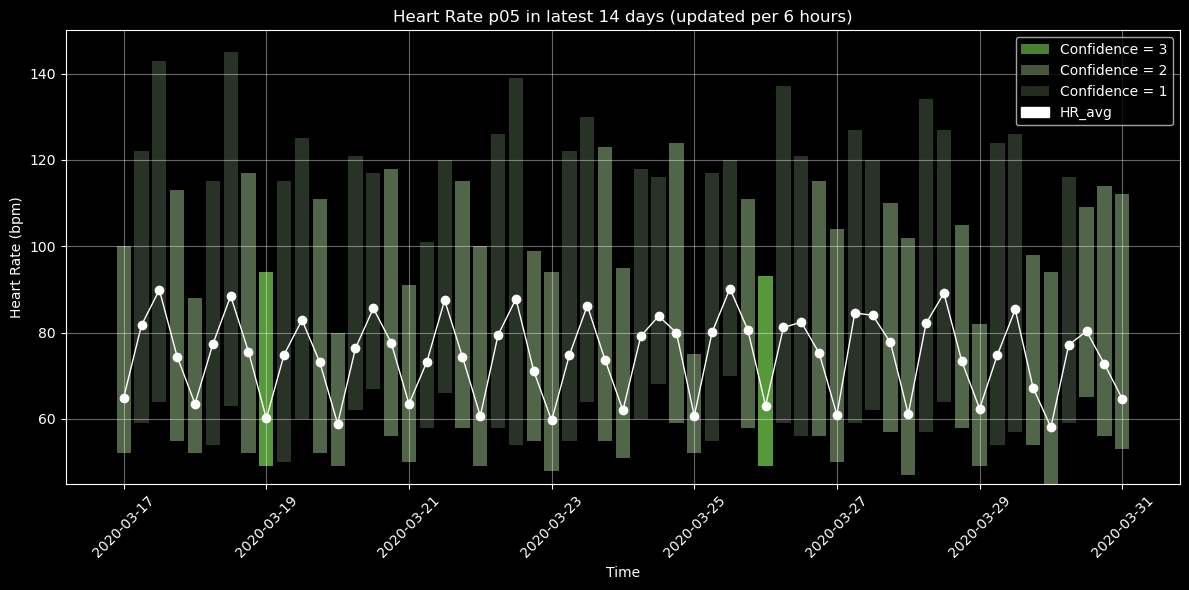

In [162]:
heart_rate_chart_pXX(HR_p05_per_six_hour, 14)

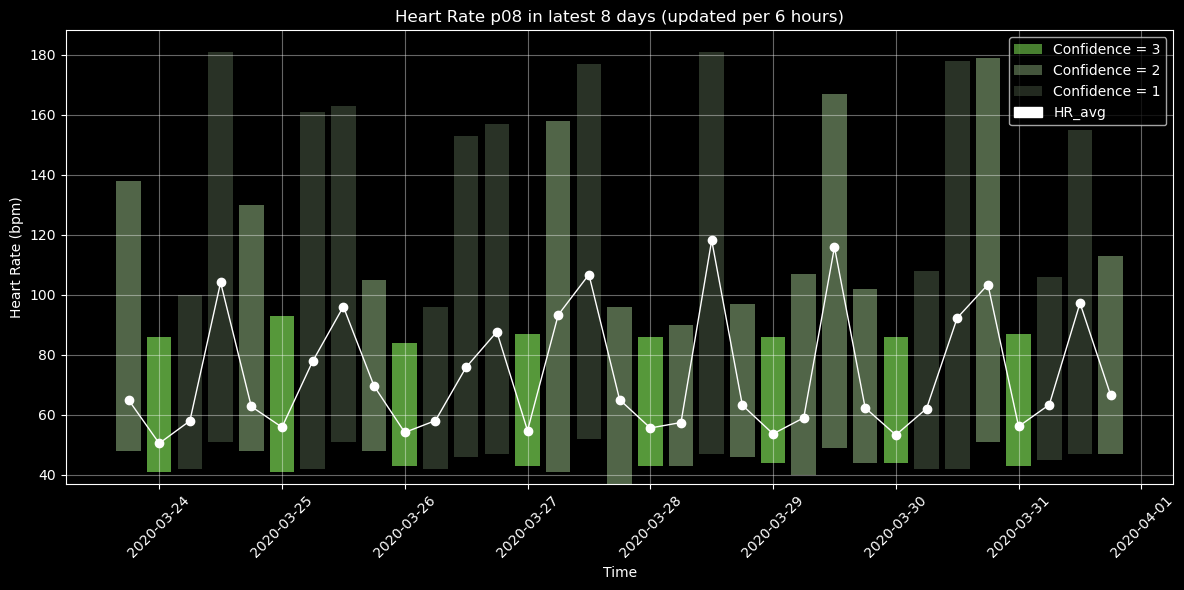

In [163]:
heart_rate_chart_pXX(clean_data_heart_rate_pXX('p08'), 8)

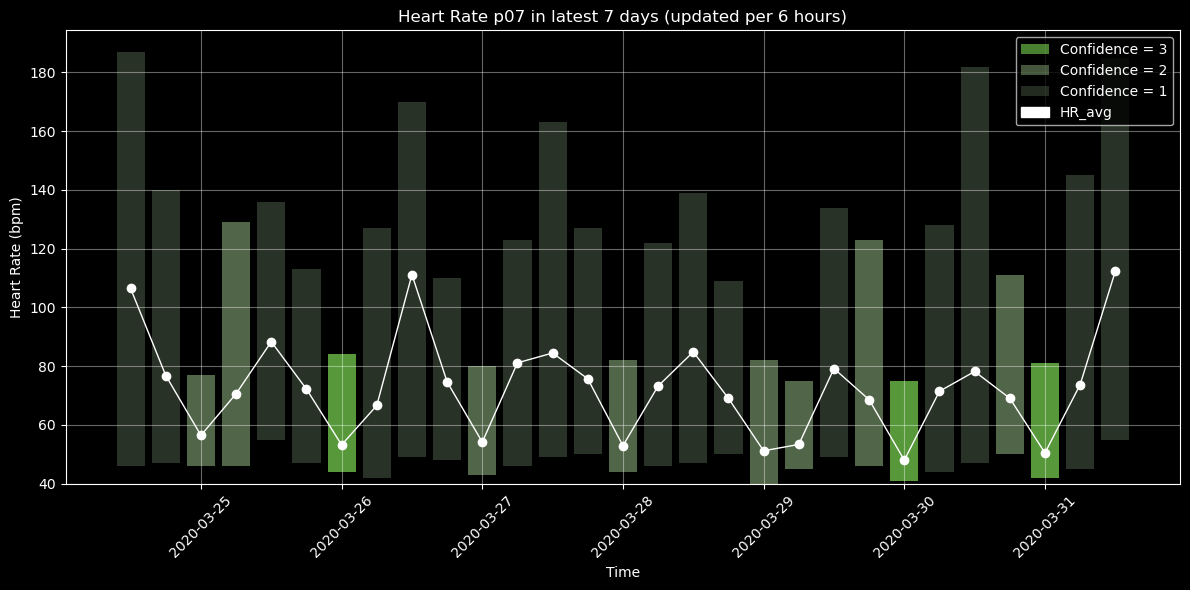

In [164]:
heart_rate_chart_pXX(clean_data_heart_rate_pXX('p07'), 7)

#### `resting_heart_rate`

In [165]:
RHR = pd.read_json("p01/fitbit/resting_heart_rate.json")
RHR = RHR.rename(columns={"value": "rhr"})

In [166]:
RHR

dateTime  \
0   2019-11-01   
1   2019-11-02   
2   2019-11-03   
3   2019-11-04   
4   2019-11-05   
..         ...   
147 2020-03-27   
148 2020-03-28   
149 2020-03-29   
150 2020-03-30   
151 2020-03-31   

                                                                               rhr  
0    {'date': '11/01/19', 'value': 53.74107360839844, 'error': 6.7911224365234375}  
1    {'date': '11/02/19', 'value': 52.881497383117676, 'error': 6.788424491882324}  
2     {'date': '11/03/19', 'value': 53.22202396392822, 'error': 6.787530899047852}  
3     {'date': '11/04/19', 'value': 54.31114101409912, 'error': 6.787234306335449}  
4     {'date': '11/05/19', 'value': 52.25911045074463, 'error': 6.787136077880859}  
..                                                                             ...  
147   {'date': '03/27/20', 'value': 50.23250770568848, 'error': 6.787087440490723}  
148  {'date': '03/28/20', 'value': 51.125173568725586, 'error': 6.787087440490723}  
149   {'date': '03/29/20', 'value': 53.07050037384033, 'error': 6.787087440490723}  
150   {'date': '03/30/20', 'value': 52.17508316040039, 'error': 6.787087440490723}  
151  {'date': '03/31/20', 'value': 52.556668281555176, 'error': 6.787087440490723}  

[152 rows x 2 columns]

In [167]:
RHR = (RHR.join(pd.json_normalize(RHR['rhr']))
          .drop(["rhr", "date"], axis=1)
          .rename(columns={
              "value": "resting_hr",
              "error": "error_std"}))

RHR

dateTime  resting_hr  error_std
0   2019-11-01   53.741074   6.791122
1   2019-11-02   52.881497   6.788424
2   2019-11-03   53.222024   6.787531
3   2019-11-04   54.311141   6.787234
4   2019-11-05   52.259110   6.787136
..         ...         ...        ...
147 2020-03-27   50.232508   6.787087
148 2020-03-28   51.125174   6.787087
149 2020-03-29   53.070500   6.787087
150 2020-03-30   52.175083   6.787087
151 2020-03-31   52.556668   6.787087

[152 rows x 3 columns]

In [168]:
RHR.sort_values('error_std', ascending=False)

dateTime  resting_hr  error_std
32  2019-12-03   50.809428  14.019183
53  2019-12-24   52.049365  10.997471
31  2019-12-02   50.645761  10.946383
63  2020-01-03   51.822971  10.699983
26  2019-11-27   51.493073  10.699845
..         ...         ...        ...
104 2020-02-13   51.069740   6.787087
103 2020-02-12   53.021011   6.787087
102 2020-02-11   52.532438   6.787087
101 2020-02-10   51.683936   6.787087
151 2020-03-31   52.556668   6.787087

[152 rows x 3 columns]

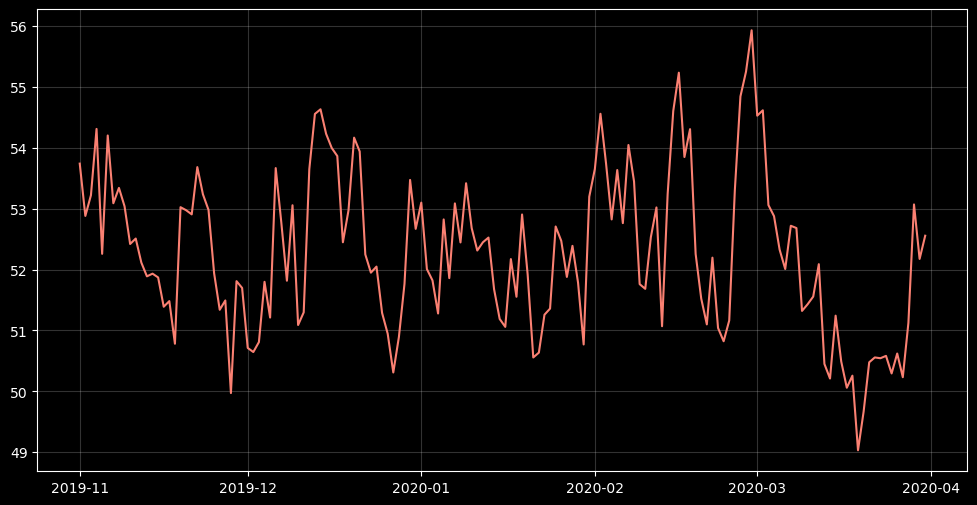

In [169]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(RHR['dateTime'], RHR['resting_hr'], color='salmon')
ax.grid(alpha=0.2)

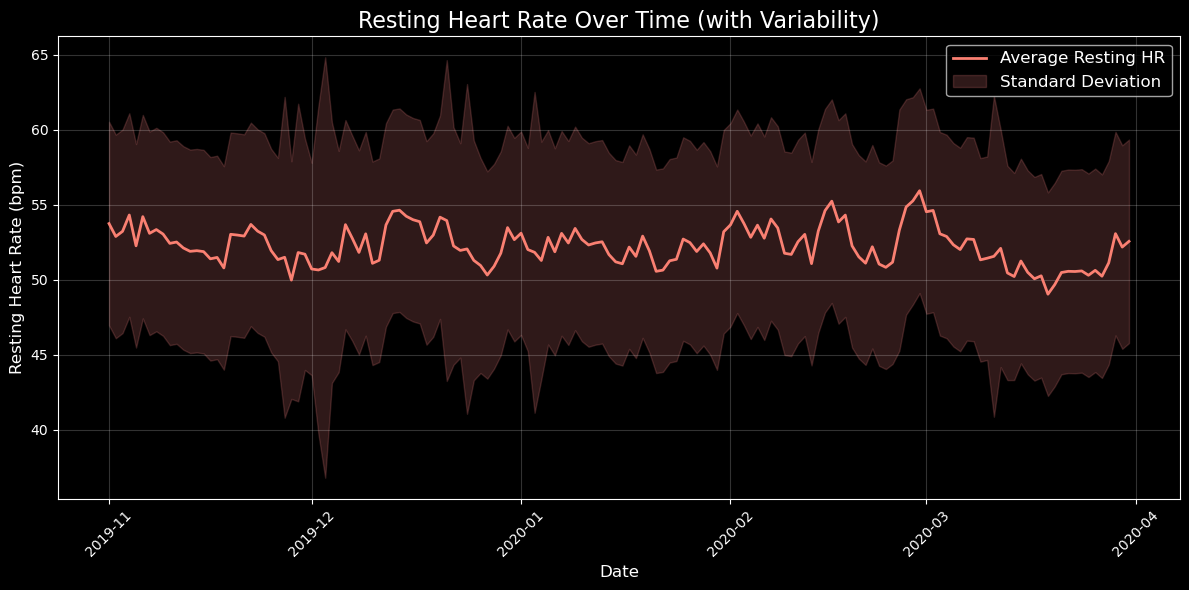

In [170]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(RHR['dateTime'], RHR['resting_hr'], 
    label='Average Resting HR', color='salmon', linewidth=2)
ax.fill_between(RHR['dateTime'],
    RHR['resting_hr'] - RHR['error_std'],
    RHR['resting_hr'] + RHR['error_std'],
    color='lightcoral', alpha=0.2, label='Standard Deviation')

ax.set_title('Resting Heart Rate Over Time (with Variability)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Resting Heart Rate (bpm)', fontsize=12)
ax.grid(alpha=0.2)
ax.legend(loc='best', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Whole: `pXX`**

In [171]:
def clean_data_resting_heart_rate():
    '''
    Note: Several players had a late start and
          missing values, visualized by value of 0
    '''
    
    
    df_RHR = pd.DataFrame()
    
    for pXX in id_players:
        try:        
            
            RHR_pXX = pd.read_json(f"{pXX}/fitbit/resting_heart_rate.json")
            RHR_pXX = RHR_pXX.rename(columns={"value": "rhr"})

            RHR_pXX = (RHR_pXX.join(pd.json_normalize(RHR_pXX['rhr']))
              .drop(["rhr", "date"], axis=1).rename(columns={
                  "value": "resting_hr","error": "error_std"}))
            RHR_pXX['pXX'] = pXX

            df_RHR = pd.concat([df_RHR, RHR_pXX])
            
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/resting_heart_rate.json -- Skipping...")
    
    return df_RHR

In [172]:
df_RHR = clean_data_resting_heart_rate()

File not found: p12/fitbit/resting_heart_rate.json -- Skipping...
File not found: p13/fitbit/resting_heart_rate.json -- Skipping...


In [173]:
df_RHR

dateTime  resting_hr  error_std  pXX
0   2019-11-01   53.741074   6.791122  p01
1   2019-11-02   52.881497   6.788424  p01
2   2019-11-03   53.222024   6.787531  p01
3   2019-11-04   54.311141   6.787234  p01
4   2019-11-05   52.259110   6.787136  p01
..         ...         ...        ...  ...
147 2020-03-27   68.890767   6.787089  p16
148 2020-03-28   68.036634   6.787087  p16
149 2020-03-29   66.626012   6.787087  p16
150 2020-03-30   65.947171   6.787087  p16
151 2020-03-31   65.907543   6.787087  p16

[1803 rows x 4 columns]

In [174]:
df_RHR.value_counts('pXX').sort_index()

pXX
p01    152
p02     91
p03    152
p04     35
p05     95
p06    152
p07    148
p08    143
p09    152
p10    148
p11     98
p14    140
p15    145
p16    152
Name: count, dtype: int64

In [175]:
df_RHR[df_RHR['pXX'] == 'p02']

dateTime  resting_hr  error_std  pXX
0  2020-01-01    0.000000   0.000000  p02
1  2020-01-02   45.674418  12.494967  p02
2  2020-01-03   47.867121   8.357060  p02
3  2020-01-04   46.339462   7.279780  p02
4  2020-01-05   45.647818   6.947596  p02
..        ...         ...        ...  ...
86 2020-03-27   47.367889   6.793286  p02
87 2020-03-28   49.407214   6.789142  p02
88 2020-03-29   51.050967   6.787768  p02
89 2020-03-30   48.865365   7.902889  p02
90 2020-03-31   46.396874   7.142754  p02

[91 rows x 4 columns]

In [176]:
def resting_heart_rate_chart_pXX(player):

    if player == 'p12' or player == 'p13':
        print(f"Resting heart rate data for {player} is not found.")
    
    else:
        fig, ax = plt.subplots(figsize=(12, 6))

        RHR_pXX = df_RHR.loc[df_RHR['pXX'] == player]

        ax.plot(RHR_pXX['dateTime'], RHR_pXX['resting_hr'], 
            label='Average Resting HR', 
            color='salmon', linewidth=2)
        ax.fill_between(RHR_pXX['dateTime'],
            RHR_pXX['resting_hr'] - RHR_pXX['error_std'],
            RHR_pXX['resting_hr'] + RHR_pXX['error_std'],
            color='lightcoral', alpha=0.2, label='Standard Deviation')

        ax.set_title(f'Resting Heart Rate, {player}', fontsize=16)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Resting Heart Rate (bpm)', fontsize=12)
        ax.grid(alpha=0.2)
        ax.legend(loc='best', fontsize=12)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

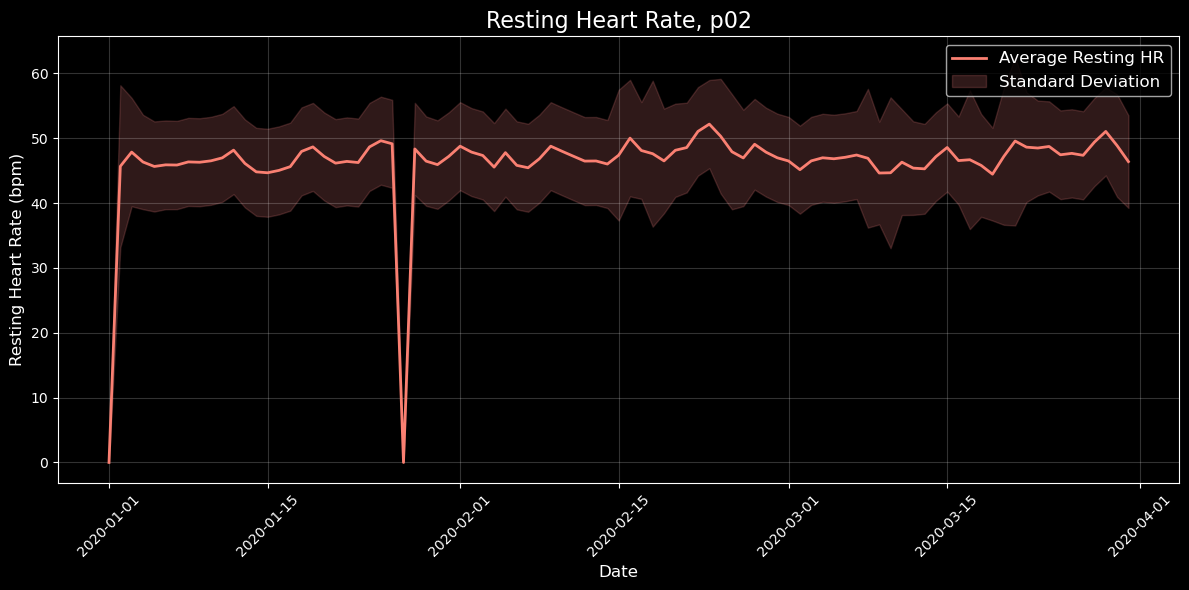

In [177]:
resting_heart_rate_chart_pXX('p02')

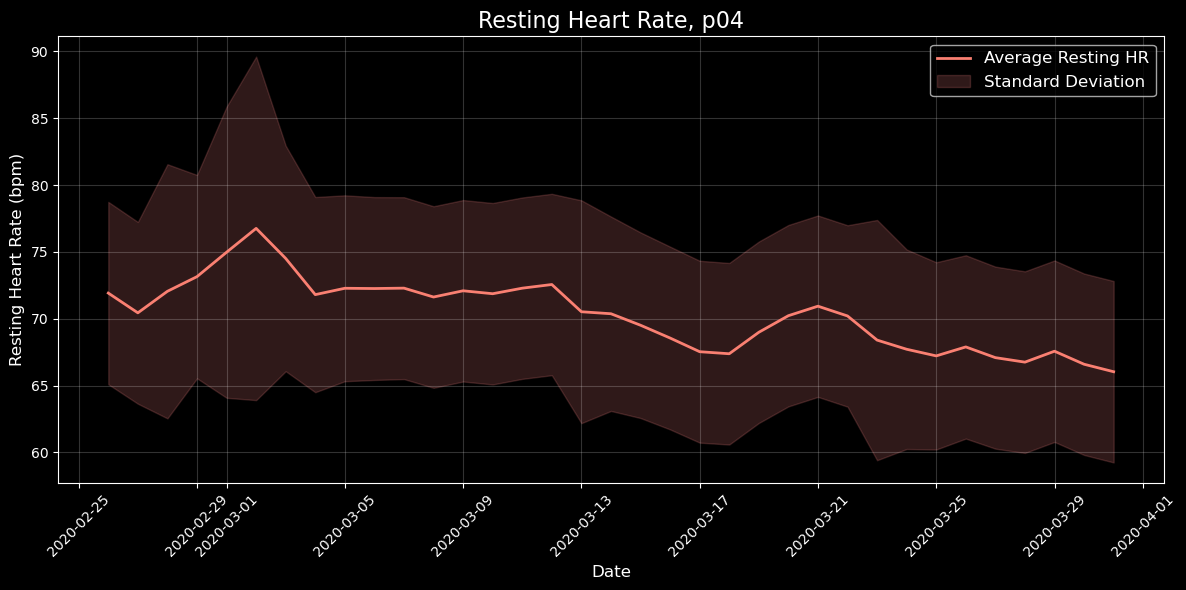

In [178]:
resting_heart_rate_chart_pXX('p04')

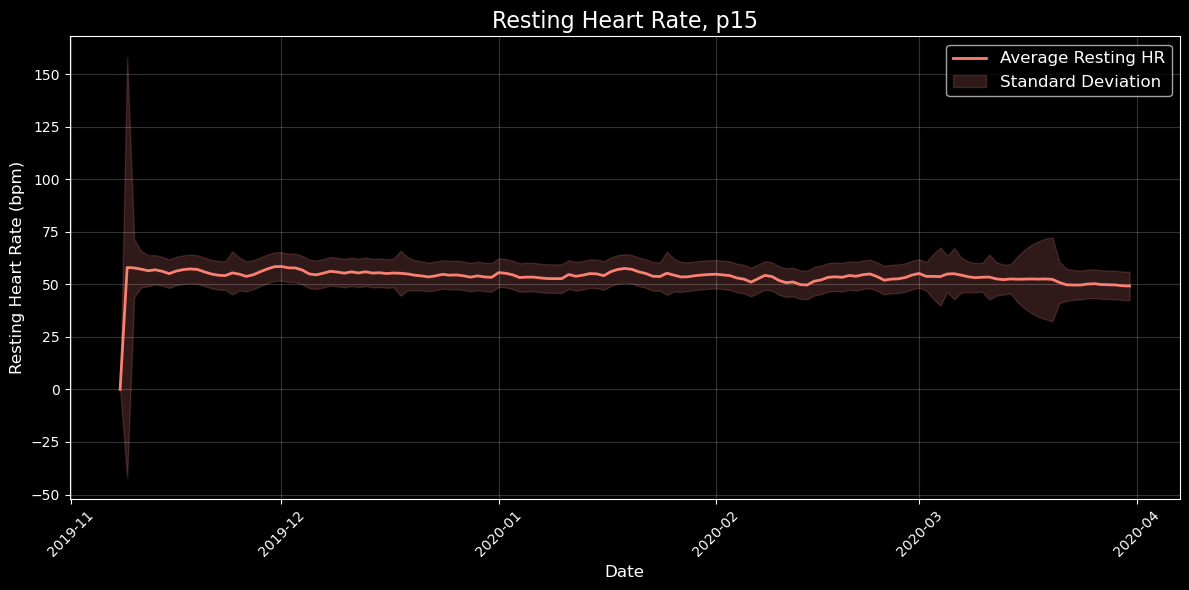

In [179]:
resting_heart_rate_chart_pXX('p15')

### `sleep`

In [180]:
sleep = pd.read_json("p01/fitbit/sleep.json")

In [181]:
sleep.shape

(155, 15)

In [182]:
sleep.head(1)

logId dateOfSleep            startTime                  endTime  \
0  24486013387  2019-11-02  2019-11-02 00:09:30  2019-11-02T07:19:30.000   

   duration  minutesToFallAsleep  minutesAsleep  minutesAwake  \
0  25800000                    0            378            52   

   minutesAfterWakeup  timeInBed  efficiency    type  infoCode  \
0                   0        430          97  stages         0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        levels  \
0  {'summary': {'deep': {'count': 2, 'minutes': 36, 'thirtyDayAvgMinutes': 40}, 'wake': {'count': 26, 'minutes': 52, 'thirtyDayAvgMinutes': 42}, 'light': {'count': 30, 'minutes': 259, 'thirtyDayAvgMinutes': 249}, 'rem': {'count': 4, 'minutes': 83, 'thirtyDayAvgMinutes': 55}}, 'data': [{'dateTime': '2019-11-02T00:09:30.000', 'level': 'wake', 'seconds': 30}, {'dateTime': '2019-11-02T00:10:00.000', 'level': 'light', 'seconds': 3570}, {'dateTime': '2019-11-02T01:09:30.000', 'level': 'deep', 'seconds': 1140}, {'dateTime': '2019-11-02T01:28:30.000', 'level': 'light', 'seconds': 210}, {'dateTime': '2019-11-02T01:32:00.000', 'level': 'rem', 'seconds': 930}, {'dateTime': '2019-11-02T01:47:30.000', 'level': 'light', 'seconds': 2580}, {'dateTime': '2019-11-02T02:30:30.000', 'level': 'rem', 'seconds': 1350}, {'dateTime': '2019-11-02T02:53:00.000', 'level': 'light', 'seconds': 720}, {'dateTime': '2019-11-02T03:05:00.000', 'level': 'rem', 'seconds': 1200}, {'dateTime': '2019-11-02T03:25:00.000', 'level': 'light', 'seconds': 2580}, {'dateTime': '2019-11-02T04:08:00.000', 'level': 'wake', 'seconds': 510}, {'dateTime': '2019-11-02T04:16:30.000', 'level': 'light', 'seconds': 2250}, {'dateTime': '2019-11-02T04:54:00.000', 'level': 'wake', 'seconds': 240}, {'dateTime': '2019-11-02T04:58:00.000', 'level': 'light', 'seconds': 2970}, {'dateTime': '2019-11-02T05:47:30.000', 'level': 'rem', 'seconds': 1500}, {'dateTime': '2019-11-02T06:12:30.000', 'level': 'light', 'seconds': 1350}, {'dateTime': '20...   

   mainSleep  
0       True

In [183]:
sleep = sleep.join(
    pd.json_normalize(sleep['levels'])
).drop(['levels', 'shortData'], axis=1)

date_cols = ['dateOfSleep', 'startTime', 'endTime']

for col in date_cols:
    sleep[col] = pd.to_datetime(sleep[col])

sleep.head(1)

logId dateOfSleep           startTime             endTime  duration  \
0  24486013387  2019-11-02 2019-11-02 00:09:30 2019-11-02 07:19:30  25800000   

   minutesToFallAsleep  minutesAsleep  minutesAwake  minutesAfterWakeup  \
0                    0            378            52                   0   

   timeInBed  efficiency    type  infoCode  mainSleep  \
0        430          97  stages         0       True   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             data  \
0  [{'dateTime': '2019-11-02T00:09:30.000', 'level': 'wake', 'seconds': 30}, {'dateTime': '2019-11-02T00:10:00.000', 'level': 'light', 'seconds': 3570}, {'dateTime': '2019-11-02T01:09:30.000', 'level': 'deep', 'seconds': 1140}, {'dateTime': '2019-11-02T01:28:30.000', 'level': 'light', 'seconds': 210}, {'dateTime': '2019-11-02T01:32:00.000', 'level': 'rem', 'seconds': 930}, {'dateTime': '2019-11-02T01:47:30.000', 'level': 'light', 'seconds': 2580}, {'dateTime': '2019-11-02T02:30:30.000', 'level': 'rem', 'seconds': 1350}, {'dateTime': '2019-11-02T02:53:00.000', 'level': 'light', 'seconds': 720}, {'dateTime': '2019-11-02T03:05:00.000', 'level': 'rem', 'seconds': 1200}, {'dateTime': '2019-11-02T03:25:00.000', 'level': 'light', 'seconds': 2580}, {'dateTime': '2019-11-02T04:08:00.000', 'level': 'wake', 'seconds': 510}, {'dateTime': '2019-11-02T04:16:30.000', 'level': 'light', 'seconds': 2250}, {'dateTime': '2019-11-02T04:54:00.000', 'level': 'wake', 'seconds': 240}, {'dateTime': '2019-11-02T04:58:00.000', 'level': 'light', 'seconds': 2970}, {'dateTime': '2019-11-02T05:47:30.000', 'level': 'rem', 'seconds': 1500}, {'dateTime': '2019-11-02T06:12:30.000', 'level': 'light', 'seconds': 1350}, {'dateTime': '2019-11-02T06:35:00.000', 'level': 'deep', 'seconds': 1140}, {'dateTime': '2019-11-02T06:54:00.000', 'level': 'light', 'seconds': 1080}, {'dateTime': '2019-11-02T07:12:00.000', 'level': 'wake', 'seconds': 450}]   

   summary.deep.count  summary.deep.minutes  summary.deep.thirtyDayAvgMinutes  \
0                   2                    36                                40   

   summary.wake.count  summary.wake.minutes  summary.wake.thirtyDayAvgMinutes  \
0                  26                    52                                42   

   summary.light.count  summary.light.minutes  \
0                   30                    259   

   summary.light.thirtyDayAvgMinutes  summary.rem.count  summary.rem.minutes  \
0                                249                  4                   83   

   summary.rem.thirtyDayAvgMinutes  
0                               55

In [184]:
sleep['mainSleep'].value_counts()

mainSleep
True    155
Name: count, dtype: int64

In [185]:
sleep.shape

(155, 27)

In [186]:
pd.json_normalize(sleep['data'])

0   \
0       {'dateTime': '2019-11-02T00:09:30.000', 'level': 'wake', 'seconds': 30}   
1     {'dateTime': '2019-11-03T00:32:00.000', 'level': 'light', 'seconds': 450}   
2     {'dateTime': '2019-11-03T23:55:30.000', 'level': 'light', 'seconds': 690}   
3       {'dateTime': '2019-11-05T00:22:30.000', 'level': 'wake', 'seconds': 30}   
4      {'dateTime': '2019-11-06T00:25:30.000', 'level': 'wake', 'seconds': 150}   
..                                                                          ...   
150  {'dateTime': '2020-03-27T02:27:00.000', 'level': 'light', 'seconds': 4290}   
151    {'dateTime': '2020-03-28T01:03:30.000', 'level': 'wake', 'seconds': 420}   
152    {'dateTime': '2020-03-29T00:46:30.000', 'level': 'wake', 'seconds': 450}   
153  {'dateTime': '2020-03-30T00:17:00.000', 'level': 'light', 'seconds': 5460}   
154     {'dateTime': '2020-03-31T00:44:30.000', 'level': 'wake', 'seconds': 30}   

                                                                             1   \
0    {'dateTime': '2019-11-02T00:10:00.000', 'level': 'light', 'seconds': 3570}   
1      {'dateTime': '2019-11-03T00:39:30.000', 'level': 'wake', 'seconds': 390}   
2     {'dateTime': '2019-11-04T00:07:00.000', 'level': 'deep', 'seconds': 1950}   
3    {'dateTime': '2019-11-05T00:23:00.000', 'level': 'light', 'seconds': 1710}   
4      {'dateTime': '2019-11-06T00:28:00.000', 'level': 'light', 'seconds': 30}   
..                                                                          ...   
150   {'dateTime': '2020-03-27T03:38:30.000', 'level': 'deep', 'seconds': 1800}   
151  {'dateTime': '2020-03-28T01:10:30.000', 'level': 'light', 'seconds': 1920}   
152   {'dateTime': '2020-03-29T00:54:00.000', 'level': 'light', 'seconds': 510}   
153   {'dateTime': '2020-03-30T01:48:00.000', 'level': 'deep', 'seconds': 1770}   
154  {'dateTime': '2020-03-31T00:45:00.000', 'level': 'light', 'seconds': 1170}   

                                                                             2   \
0     {'dateTime': '2019-11-02T01:09:30.000', 'level': 'deep', 'seconds': 1140}   
1     {'dateTime': '2019-11-03T00:46:00.000', 'level': 'light', 'seconds': 930}   
2     {'dateTime': '2019-11-04T00:39:30.000', 'level': 'light', 'seconds': 120}   
3      {'dateTime': '2019-11-05T00:51:30.000', 'level': 'rem', 'seconds': 1140}   
4     {'dateTime': '2019-11-06T00:28:30.000', 'level': 'deep', 'seconds': 3150}   
..                                                                          ...   
150    {'dateTime': '2020-03-27T04:08:30.000', 'level': 'rem', 'seconds': 1170}   
151    {'dateTime': '2020-03-28T01:42:30.000', 'level': 'rem', 'seconds': 1890}   
152    {'dateTime': '2020-03-29T01:02:30.000', 'level': 'wake', 'seconds': 450}   
153  {'dateTime': '2020-03-30T02:17:30.000', 'level': 'light', 'seconds': 4890}   
154    {'dateTime': '2020-03-31T01:04:30.000', 'level': 'deep', 'seconds': 390}   

                                                                             3   \
0     {'dateTime': '2019-11-02T01:28:30.000', 'level': 'light', 'seconds': 210}   
1      {'dateTime': '2019-11-03T01:01:30.000', 'level': 'wake', 'seconds': 780}   
2      {'dateTime': '2019-11-04T00:41:30.000', 'level': 'wake', 'seconds': 210}   
3     {'dateTime': '2019-11-05T01:10:30.000', 'level': 'light', 'seconds': 540}   
4    {'dateTime': '2019-11-06T01:21:00.000', 'level': 'light', 'seconds': 2220}   
..                                                                          ...   
150   {'dateTime': '2020-03-27T04:28:00.000', 'level': 'wake', 'seconds': 1380}   
151  {'dateTime': '2020-03-28T02:14:00.000', 'level': 'light', 'seconds': 3870}   
152  {'dateTime': '2020-03-29T01:10:00.000', 'level': 'light', 'seconds': 2070}   
153    {'dateTime': '2020-03-30T03:39:00.000', 'level': 'rem', 'seconds': 2220}   
154  {'dateTime': '2020-03-31T01:11:00.000', 'level': 'light', 'seconds': 1260}   

                                                                             4   \
0     

In [187]:
## How to:
# (1) Make each `data` to_dict of list,
# (2) and by chance get that format into Tableau

In [188]:
pd.DataFrame(sleep['data'].explode('data'))

data
0        {'dateTime': '2019-11-02T00:09:30.000', 'level': 'wake', 'seconds': 30}
1     {'dateTime': '2019-11-02T00:10:00.000', 'level': 'light', 'seconds': 3570}
2      {'dateTime': '2019-11-02T01:09:30.000', 'level': 'deep', 'seconds': 1140}
3      {'dateTime': '2019-11-02T01:28:30.000', 'level': 'light', 'seconds': 210}
4        {'dateTime': '2019-11-02T01:32:00.000', 'level': 'rem', 'seconds': 930}
...                                                                          ...
2941  {'dateTime': '2020-03-31T05:56:00.000', 'level': 'light', 'seconds': 2100}
2942     {'dateTime': '2020-03-31T06:31:00.000', 'level': 'rem', 'seconds': 270}
2943   {'dateTime': '2020-03-31T06:35:30.000', 'level': 'light', 'seconds': 450}
2944     {'dateTime': '2020-03-31T06:43:00.000', 'level': 'rem', 'seconds': 420}
2945   {'dateTime': '2020-03-31T06:50:00.000', 'level': 'light', 'seconds': 960}

[2946 rows x 1 columns]

In [189]:
sleep_chr = pd.DataFrame(sleep['data'].explode('data'))

sleep_chr = (sleep_chr
    .merge(pd.json_normalize(sleep_chr['data']), 
           left_index=True, right_index=True)
    .drop('data', axis=1))

sleep_chr['dateTime'] = pd.to_datetime(sleep_chr['dateTime'])
sleep_chr

## We've done the parsing, at least for one row.
## Now what to do from here? How can we make it
## readable in Tableau while preserving the
## DataFrame as a whole row?

dateTime  level  seconds
0    2019-11-02 00:09:30   wake       30
1    2019-11-02 00:10:00  light     3570
2    2019-11-02 01:09:30   deep     1140
3    2019-11-02 01:28:30  light      210
4    2019-11-02 01:32:00    rem      930
...                  ...    ...      ...
2941 2020-03-31 05:56:00  light     2100
2942 2020-03-31 06:31:00    rem      270
2943 2020-03-31 06:35:30  light      450
2944 2020-03-31 06:43:00    rem      420
2945 2020-03-31 06:50:00  light      960

[2946 rows x 3 columns]

In [190]:
sleep[['logId', 'startTime']]

logId           startTime
0    24486013387 2019-11-02 00:09:30
1    24497341340 2019-11-03 00:32:00
2    24507914069 2019-11-03 23:55:30
3    24521896102 2019-11-05 00:22:30
4    24534036899 2019-11-06 00:25:30
..           ...                 ...
150  26491780871 2020-03-27 02:27:00
151  26502379603 2020-03-28 01:03:30
152  26516647751 2020-03-29 00:46:30
153  26528257996 2020-03-30 00:17:00
154  26540075740 2020-03-31 00:44:30

[155 rows x 2 columns]

In [191]:
sleep_chr = sleep_chr.merge(sleep[['logId', 'startTime']], how='left',
         left_on='dateTime', right_on='startTime').drop('startTime', axis=1).ffill()
sleep_chr

dateTime  level  seconds         logId
0    2019-11-02 00:09:30   wake       30  2.448601e+10
1    2019-11-02 00:10:00  light     3570  2.448601e+10
2    2019-11-02 01:09:30   deep     1140  2.448601e+10
3    2019-11-02 01:28:30  light      210  2.448601e+10
4    2019-11-02 01:32:00    rem      930  2.448601e+10
...                  ...    ...      ...           ...
2951 2020-03-31 05:56:00  light     2100  2.654008e+10
2952 2020-03-31 06:31:00    rem      270  2.654008e+10
2953 2020-03-31 06:35:30  light      450  2.654008e+10
2954 2020-03-31 06:43:00    rem      420  2.654008e+10
2955 2020-03-31 06:50:00  light      960  2.654008e+10

[2956 rows x 4 columns]

In [192]:
sleep_grouped = sleep_chr.groupby(['logId', 'level']).agg(
    date = ('dateTime', lambda x: x.max() - pd.Timedelta(days=1)),
    duration = ('seconds', 'sum')
).reset_index()

sleep_grouped['logId'] = sleep_grouped['logId'].astype('int64')
sleep_grouped

logId  level                date  duration
0    24486013387   deep 2019-11-01 06:35:00      2280
1    24486013387  light 2019-11-01 06:54:00     17310
2    24486013387    rem 2019-11-01 05:47:30      4980
3    24486013387   wake 2019-11-01 07:12:00      1230
4    24497341340   deep 2019-11-02 05:17:30      2340
..           ...    ...                 ...       ...
594  26528257996   wake 2020-03-29 07:11:30      1500
595  26540075740   deep 2020-03-30 04:47:30      2730
596  26540075740  light 2020-03-30 06:50:00     14940
597  26540075740    rem 2020-03-30 06:43:00      4320
598  26540075740   wake 2020-03-30 05:46:30       900

[599 rows x 4 columns]

In [193]:
sleep_stages = sleep_chr.groupby(['logId', 'level']).agg(
    date = ('dateTime', lambda x: x.max() - pd.Timedelta(days=1)),
    duration = ('seconds', 'sum')
).reset_index()

sleep_stages['logId'] = sleep_stages['logId'].astype('int64')
sleep_stages['date']  = sleep_stages['date'].dt.date
sleep_stages = sleep_stages.sort_values(['logId', 'date'])
sleep_stages

logId  level        date  duration
0    24486013387   deep  2019-11-01      2280
1    24486013387  light  2019-11-01     17310
2    24486013387    rem  2019-11-01      4980
3    24486013387   wake  2019-11-01      1230
4    24497341340   deep  2019-11-02      2340
..           ...    ...         ...       ...
594  26528257996   wake  2020-03-29      1500
595  26540075740   deep  2020-03-30      2730
596  26540075740  light  2020-03-30     14940
597  26540075740    rem  2020-03-30      4320
598  26540075740   wake  2020-03-30       900

[599 rows x 4 columns]

In [194]:
sleep_stages.value_counts('level')

level
light      150
rem        150
wake       150
deep       148
unknown      1
Name: count, dtype: int64

In [195]:
sleep_stages.value_counts('date')

date
2020-01-14    5
2020-03-28    5
2020-02-11    4
2020-02-04    4
2020-02-05    4
             ..
2019-12-12    4
2019-12-11    4
2020-02-20    3
2020-01-10    3
2020-01-15    3
Name: count, Length: 150, dtype: int64

In [196]:
sleep_stages[-15:]

logId    level        date  duration
584  26502379603      rem  2020-03-27      3570
585  26502379603     wake  2020-03-27      2190
586  26516647751     deep  2020-03-28      3450
587  26516647751    light  2020-03-28     16020
588  26516647751      rem  2020-03-28      2370
589  26516647751  unknown  2020-03-28      3600
590  26516647751     wake  2020-03-28      3000
591  26528257996     deep  2020-03-29      2100
592  26528257996    light  2020-03-29     17490
593  26528257996      rem  2020-03-29      4290
594  26528257996     wake  2020-03-29      1500
595  26540075740     deep  2020-03-30      2730
596  26540075740    light  2020-03-30     14940
597  26540075740      rem  2020-03-30      4320
598  26540075740     wake  2020-03-30       900

In [197]:
# There's only one unknown. We'll change it to `wake` for efficiency.
## Add the duration into 'wake' stages, and delete the 'unknown'

sleep_stages.loc[sleep_stages.index == 590, 'duration'] += 3600
sleep_stages = sleep_stages.drop(index=589)

In [198]:
sleep_stages.value_counts('level')

level
light    150
rem      150
wake     150
deep     148
Name: count, dtype: int64

In [199]:
# Check records with no 'deep' stages
sleep_stages[275:285]

logId  level        date  duration
275  25356549170   wake  2020-01-08      1890
276  25371920891   deep  2020-01-09      2670
277  25371920891  light  2020-01-09     15090
278  25371920891    rem  2020-01-09      3840
279  25371920891   wake  2020-01-09      1470
280  25385814738  light  2020-01-10     23070
281  25385814738    rem  2020-01-10      6870
282  25385814738   wake  2020-01-10      2220
283  25399900721   deep  2020-01-11      1140
284  25399900721  light  2020-01-11     22440

In [200]:
# Check records with no 'deep' stages
sleep_stages[440:450]

logId  level        date  duration
440  25980514519  light  2020-02-19     14340
441  25980514519    rem  2020-02-19      4140
442  25980514519   wake  2020-02-19        30
443  26002023337  light  2020-02-20     15300
444  26002023337    rem  2020-02-20      1530
445  26002023337   wake  2020-02-20      1560
446  26015459375   deep  2020-02-21      2130
447  26015459375  light  2020-02-21     17940
448  26015459375    rem  2020-02-21      4200
449  26015459375   wake  2020-02-21       810

In [201]:
sleep_stages[295:305]

logId  level        date  duration
295  25446511879   deep  2020-01-14      2040
296  25446511879  light  2020-01-14     19380
297  25446511879    rem  2020-01-14      2400
298  25446511879   wake  2020-01-14      2100
302  25459709394   wake  2020-01-14      1260
299  25459709394   deep  2020-01-15      2190
300  25459709394  light  2020-01-15     16920
301  25459709394    rem  2020-01-15      3210
303  25476657499   deep  2020-01-16      4530
304  25476657499  light  2020-01-16     11640

In [202]:
## Deduction: 
# 2 days lack deep sleep, check.
# 1 day has unknown stage, cleaned.
# 1 day has 5, 1 day has 3, 
# with date close to one another.
## One stage may end up max on previous date.

## Check the latest time
sleep_grouped[295:305]

logId  level                date  duration
295  25446511879   deep 2020-01-14 01:22:30      2040
296  25446511879  light 2020-01-14 04:15:00     19380
297  25446511879    rem 2020-01-14 04:09:30      2400
298  25446511879   wake 2020-01-14 05:52:00      2100
299  25459709394   deep 2020-01-15 05:15:00      2190
300  25459709394  light 2020-01-15 05:29:30     16920
301  25459709394    rem 2020-01-15 05:43:00      3210
302  25459709394   wake 2020-01-14 23:36:00      1260
303  25476657499   deep 2020-01-16 01:39:00      4530
304  25476657499  light 2020-01-16 05:48:00     11640

In [203]:
# Latest 'wake' time on logId = 25459709394 was on previous day.
# One logId should've had the same date. With that, we're
# changing all dates on the 'logId' to the majority, '2020-01-15'
sleep_stages.loc[sleep_stages['logId'] == 25459709394, 'date'] = '2020-01-15'

In [204]:
sleep_stages[295:305]

logId  level        date  duration
295  25446511879   deep  2020-01-14      2040
296  25446511879  light  2020-01-14     19380
297  25446511879    rem  2020-01-14      2400
298  25446511879   wake  2020-01-14      2100
302  25459709394   wake  2020-01-15      1260
299  25459709394   deep  2020-01-15      2190
300  25459709394  light  2020-01-15     16920
301  25459709394    rem  2020-01-15      3210
303  25476657499   deep  2020-01-16      4530
304  25476657499  light  2020-01-16     11640

In [205]:
sleep_stages.value_counts('date')

date
2019-11-01    4
2020-02-04    4
2020-02-06    4
2020-02-07    4
2020-02-08    4
             ..
2019-12-22    4
2019-12-23    4
2020-01-15    4
2020-01-10    3
2020-02-20    3
Name: count, Length: 150, dtype: int64

#### Attempts on Visuals

In [206]:
sleep_stages.dtypes

logId        int64
level       object
date        object
duration     int64
dtype: object

In [207]:
sleep_stages['date'] = pd.to_datetime(sleep_stages['date'])
sleep_stages

logId  level       date  duration
0    24486013387   deep 2019-11-01      2280
1    24486013387  light 2019-11-01     17310
2    24486013387    rem 2019-11-01      4980
3    24486013387   wake 2019-11-01      1230
4    24497341340   deep 2019-11-02      2340
..           ...    ...        ...       ...
594  26528257996   wake 2020-03-29      1500
595  26540075740   deep 2020-03-30      2730
596  26540075740  light 2020-03-30     14940
597  26540075740    rem 2020-03-30      4320
598  26540075740   wake 2020-03-30       900

[598 rows x 4 columns]

In [208]:
sleep_stages_pivot = sleep_stages.drop('logId', axis=1).pivot(
    columns='level', index='date', values='duration')
sleep_stages_pivot

level         deep    light     rem    wake
date                                       
2019-11-01  2280.0  17310.0  4980.0  1230.0
2019-11-02  2340.0  18450.0  3090.0  1470.0
2019-11-03  2310.0  18480.0  2130.0  1050.0
2019-11-04  1590.0  16740.0  2490.0   930.0
2019-11-05  3990.0  15390.0  2310.0   150.0
...            ...      ...     ...     ...
2020-03-26  3630.0  12570.0  3150.0  1380.0
2020-03-27   330.0  18060.0  3570.0  2190.0
2020-03-28  3450.0  16020.0  2370.0  6600.0
2020-03-29  2100.0  17490.0  4290.0  1500.0
2020-03-30  2730.0  14940.0  4320.0   900.0

[150 rows x 4 columns]

In [209]:
# Check the 2 records lack of deep sleep
sleep_stages_pivot.isna().sum()

level
deep     2
light    0
rem      0
wake     0
dtype: int64

In [210]:
sleep_stages_pivot = sleep_stages_pivot.fillna(0)
sleep_stages_pivot.isna().sum()

level
deep     0
light    0
rem      0
wake     0
dtype: int64

<Axes: xlabel='date'>

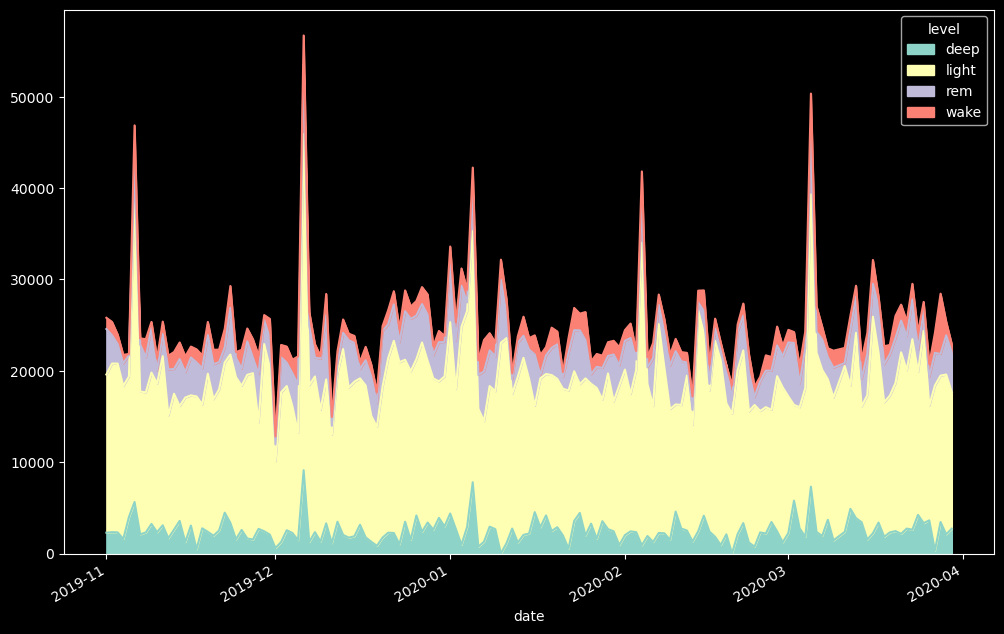

In [211]:
# Experiment 1: Stacked area chart, a regular one
fig, ax = plt.subplots(figsize=(12, 8))

sleep_stages_pivot.plot.area(stacked=True, ax=ax)

In [212]:
sleep.shape

(155, 27)

In [213]:
sleep.loc[sleep['mainSleep'] != True, :]

Empty DataFrame
Columns: [logId, dateOfSleep, startTime, endTime, duration, minutesToFallAsleep, minutesAsleep, minutesAwake, minutesAfterWakeup, timeInBed, efficiency, type, infoCode, mainSleep, data, summary.deep.count, summary.deep.minutes, summary.deep.thirtyDayAvgMinutes, summary.wake.count, summary.wake.minutes, summary.wake.thirtyDayAvgMinutes, summary.light.count, summary.light.minutes, summary.light.thirtyDayAvgMinutes, summary.rem.count, summary.rem.minutes, summary.rem.thirtyDayAvgMinutes]
Index: []

In [214]:
# Colors inspired by deep ocean blue--the deeper the darker, much like our sleep.
# Color sequence: deep-rem-light-wake
deep_stages_colors = ['#0F3E58', '#015482', '#4AA6D7', '#82D3FF']

In [215]:
## Findings: If you may notice, there are 155 records of 
##    original data 'sleep', but you see the data is recorded for 150 days. 
## There are times the person decided to add another sleep, hence the spikes.

# Experiment 1.2: What if we limit it only to recent X days only?
#    We could change the color too--the darker the deeper

## Streamline the process from the sleep_chr DF, put it all into one function.

def total_sleep_stages_chart(days):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Now we have 4 records in pivoted data, 
    # we no longer need to match the dates   
    sleep_stages_pivot[-days:].plot.area(ax=ax,
        color=deep_stages_colors)
    
    ax.set_title(f'Sleep Stages of p01 in latest {days} days')
    ax.set_xlabel('Date')
    ax.set_ylabel('Duration')
    ax.grid(alpha=0.4)
    ax.legend(title='Sleep Stages', fontsize=12, loc='best')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

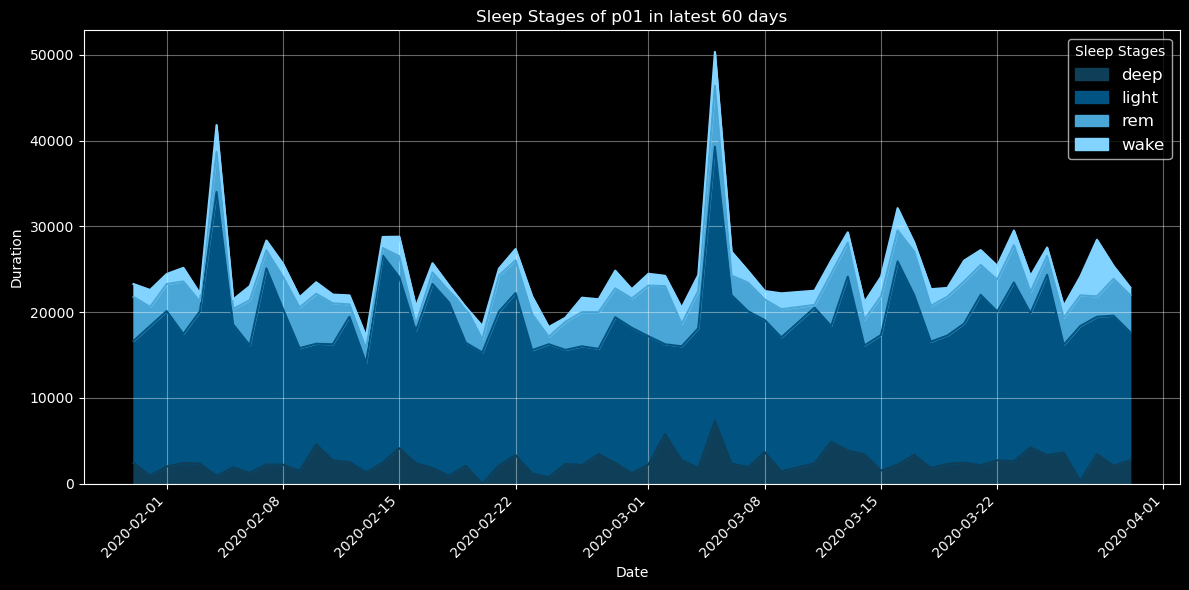

In [216]:
total_sleep_stages_chart(60)

In [217]:
## Experiment 2: Visualizing changes in deep stages at sleep
sleep_chr

dateTime  level  seconds         logId
0    2019-11-02 00:09:30   wake       30  2.448601e+10
1    2019-11-02 00:10:00  light     3570  2.448601e+10
2    2019-11-02 01:09:30   deep     1140  2.448601e+10
3    2019-11-02 01:28:30  light      210  2.448601e+10
4    2019-11-02 01:32:00    rem      930  2.448601e+10
...                  ...    ...      ...           ...
2951 2020-03-31 05:56:00  light     2100  2.654008e+10
2952 2020-03-31 06:31:00    rem      270  2.654008e+10
2953 2020-03-31 06:35:30  light      450  2.654008e+10
2954 2020-03-31 06:43:00    rem      420  2.654008e+10
2955 2020-03-31 06:50:00  light      960  2.654008e+10

[2956 rows x 4 columns]

In [218]:
sleep_chr.loc[sleep_chr['level'] == 'unknown', :]

dateTime    level  seconds         logId
2913 2020-03-29 07:40:30  unknown     3600  2.651665e+10

In [219]:
sleep_chr['logId'] = sleep_chr['logId'].astype('int64')
sleep_chr.loc[sleep_chr['level'] == 'unknown', 'level'] = 'wake'
sleep_chr

dateTime  level  seconds        logId
0    2019-11-02 00:09:30   wake       30  24486013387
1    2019-11-02 00:10:00  light     3570  24486013387
2    2019-11-02 01:09:30   deep     1140  24486013387
3    2019-11-02 01:28:30  light      210  24486013387
4    2019-11-02 01:32:00    rem      930  24486013387
...                  ...    ...      ...          ...
2951 2020-03-31 05:56:00  light     2100  26540075740
2952 2020-03-31 06:31:00    rem      270  26540075740
2953 2020-03-31 06:35:30  light      450  26540075740
2954 2020-03-31 06:43:00    rem      420  26540075740
2955 2020-03-31 06:50:00  light      960  26540075740

[2956 rows x 4 columns]

In [220]:
stage_order = ['deep', 'rem', 'light', 'wake']

sleep_chr['level'] = pd.Categorical(sleep_chr['level'],
    categories=stage_order, ordered=True)
sleep_chr['level_num'] = sleep_chr['level'].cat.codes
sleep_chr

dateTime  level  seconds        logId  level_num
0    2019-11-02 00:09:30   wake       30  24486013387          3
1    2019-11-02 00:10:00  light     3570  24486013387          2
2    2019-11-02 01:09:30   deep     1140  24486013387          0
3    2019-11-02 01:28:30  light      210  24486013387          2
4    2019-11-02 01:32:00    rem      930  24486013387          1
...                  ...    ...      ...          ...        ...
2951 2020-03-31 05:56:00  light     2100  26540075740          2
2952 2020-03-31 06:31:00    rem      270  26540075740          1
2953 2020-03-31 06:35:30  light      450  26540075740          2
2954 2020-03-31 06:43:00    rem      420  26540075740          1
2955 2020-03-31 06:50:00  light      960  26540075740          2

[2956 rows x 5 columns]

In [221]:
sleep_chr.dtypes

dateTime     datetime64[ns]
level              category
seconds               int64
logId                 int64
level_num              int8
dtype: object

In [222]:
# Taking sample of first data: 2019-11-01, taken in 
# the midnight where the date has changed.
sleep_chr_test = sleep_chr.loc[sleep_chr['logId'] == 24486013387, :]
sleep_chr_test

dateTime  level  seconds        logId  level_num
0  2019-11-02 00:09:30   wake       30  24486013387          3
1  2019-11-02 00:10:00  light     3570  24486013387          2
2  2019-11-02 01:09:30   deep     1140  24486013387          0
3  2019-11-02 01:28:30  light      210  24486013387          2
4  2019-11-02 01:32:00    rem      930  24486013387          1
5  2019-11-02 01:47:30  light     2580  24486013387          2
6  2019-11-02 02:30:30    rem     1350  24486013387          1
7  2019-11-02 02:53:00  light      720  24486013387          2
8  2019-11-02 03:05:00    rem     1200  24486013387          1
9  2019-11-02 03:25:00  light     2580  24486013387          2
10 2019-11-02 04:08:00   wake      510  24486013387          3
11 2019-11-02 04:16:30  light     2250  24486013387          2
12 2019-11-02 04:54:00   wake      240  24486013387          3
13 2019-11-02 04:58:00  light     2970  24486013387          2
14 2019-11-02 05:47:30    rem     1500  24486013387          1
15 2019-11-02 06:12:30  light     1350  24486013387          2
16 2019-11-02 06:35:00   deep     1140  24486013387          0
17 2019-11-02 06:54:00  light     1080  24486013387          2
18 2019-11-02 07:12:00   wake      450  24486013387          3

In [223]:
## You want tomake the date added by 1. Options: Timedelta, but not effective
## And then compare it by doing boolean indexing. But it's a bit convoluted.

test_date = '2019-11-01'
date_formatted = pd.to_datetime(test_date) + pd.Timedelta(days=1)

sleep_chr.loc[sleep_chr['dateTime'].dt.date == date_formatted, :]

Empty DataFrame
Columns: [dateTime, level, seconds, logId, level_num]
Index: []

In [224]:
stage_order = ['deep', 'rem', 'light', 'wake']

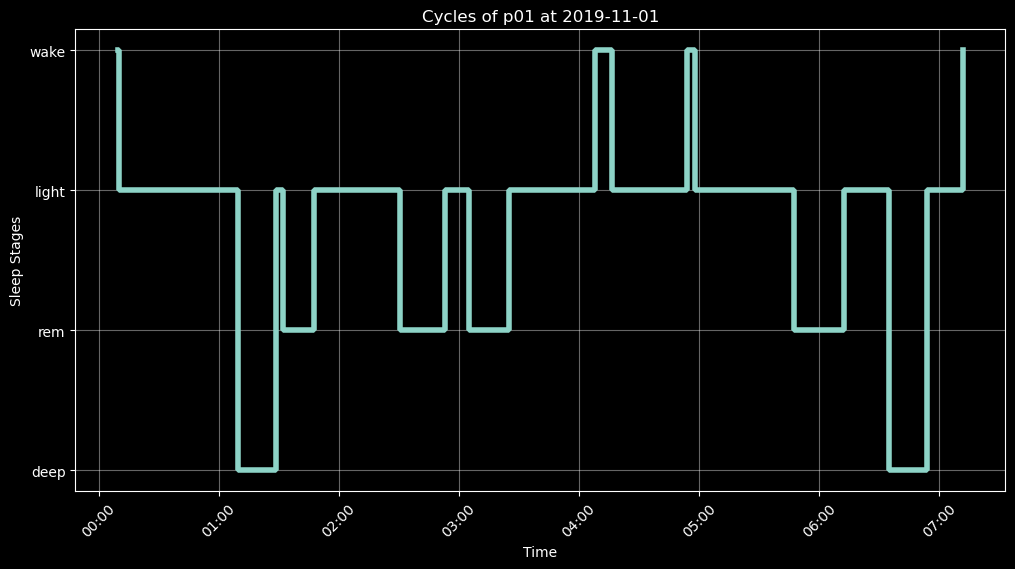

In [225]:
## How to sort the y-order to match `stage_order`?

stage_labels = sleep_chr['level'].cat.categories
stage_values = range(len(stage_labels))

fig, ax = plt.subplots(figsize=(12, 6))

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

ax.step(
    sleep_chr_test['dateTime'], 
    sleep_chr_test['level'].cat.codes, where='post', 
    linewidth=4, solid_joinstyle='bevel')
ax.set_title('Cycles of p01 at 2019-11-01')
ax.set_xlabel('Time')
ax.set_ylabel('Sleep Stages')

ax.set_yticks(stage_values)
ax.set_yticklabels(stage_labels)

ax.grid(alpha=0.4)

In [226]:
def sleep_stages_by_day_chart(date):
    
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)

    ax.step(
        sleep_chr_test['dateTime'], 
        sleep_chr_test['level'], where='post', 
        linewidth=4, solid_joinstyle='bevel')
    ax.set_title('Cycles of p01 at 2019-11-01')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sleep Stages')

    ax.grid(alpha=0.4)

#### **Whole: `pXX`**

In [227]:
df_sleep = pd.DataFrame()

for pXX in id_players:

    sleep_pXX = pd.read_json(f"{pXX}/fitbit/sleep.json")
    sleep_pXX['pXX'] = pXX
    df_sleep  = pd.concat([df_sleep, sleep_pXX], ignore_index=True)
    
df_sleep = df_sleep.join(
    pd.json_normalize(df_sleep['levels'])
).drop(['levels', 'shortData'], axis=1)

date_cols = ['dateOfSleep', 'startTime', 'endTime']

for col in date_cols:
    df_sleep[col] = pd.to_datetime(df_sleep[col])

In [228]:
df_sleep.loc[df_sleep.index == 169]

logId dateOfSleep           startTime             endTime  \
169  24698821500  2019-11-19 2019-11-18 23:16:30 2019-11-19 06:27:00   

     duration  minutesToFallAsleep  minutesAsleep  minutesAwake  \
169  25800000                    0            393            37   

     minutesAfterWakeup  timeInBed  efficiency    type  infoCode  mainSleep  \
169                   5        430          96  stages         0       True   

     pXX  \
169  p02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               data  \
169  [{'dateTime': '2019-11-18T23:16:30.000', 'level': 'wake', 'seconds': 30}, {'dateTime': '2019-11-18T23:17:00.000', 'level': 'light', 'seconds': 2160}, {'dateTime': '2019-11-18T23:53:00.000', 'level': 'deep', 'seconds': 990}, {'dateTime': '2019-11-19T00:09:30.000', 'level': 'light', 'seconds': 1230}, {'dateTime': '2019-11-19T00:30:00.000', 'level': 'rem', 'seconds': 360}, {'dateTime': '2019-11-19T00:36:00.000', 'level': 'wake', 'seconds': 210}, {'dateTime': '2019-11-19T00:39:30.000', 'level': 'light', 'seconds': 5130}, {'dateTime': '2019-11-19T02:05:00.000', 'level': 'wake', 'seconds': 390}, {'dateTime': '2019-11-19T02:11:30.000', 'level': 'rem', 'seconds': 600}, {'dateTime': '2019-11-19T02:21:30.000', 'level': 'light', 'seconds': 3540}, {'dateTime': '2019-11-19T03:20:30.000', 'level': 'rem', 'seconds': 2610}, {'dateTime': '2019-11-19T04:04:00.000', 'level': 'light', 'seconds': 1740}, {'dateTime': '2019-11-19T04:33:00.000', 'level': 'deep', 'seconds': 480}, {'dateTime': '2019-11-19T04:41:00.000', 'level': 'light', 'seconds': 390}, {'dateTime': '2019-11-19T04:47:30.000', 'level': 'deep', 'seconds': 720}, {'dateTime': '2019-11-19T04:59:30.000', 'level': 'rem', 'seconds': 1380}, {'dateTime': '2019-11-19T05:22:30.000', 'level': 'light', 'seconds': 3330}, {'dateTime': '2019-11-19T06:18:00.000', 'level': 'wake', 'seconds': 540}]   

     summary.deep.count  summary.deep.minutes  \
169                 3.0                  36.0   

     summary.deep.thirtyDayAvgMinutes  summary.wake.count  \
169                              51.0                23.0   

     summary.wake.minutes  summary.wake.thirtyDayAvgMinutes  \
169                  37.0                              58.0   

     summary.light.count  summary.light.minutes  \
169                 22.0                  276.0   

     summary.light.thirtyDayAvgMinutes  summary.rem.count  \
169                              222.0                7.0   

     summary.rem.minutes  summary.rem.thirtyDayAvgMinutes  \
169                 81.0                             79.0   

     summary.restless.count  summary.restless.minutes  summary.awake.count  \
169                     NaN                       NaN               

In [229]:
df_sleep_chr = pd.DataFrame(
    df_sleep[['pXX','data', 'dateOfSleep']]
        .explode('data', ignore_index=True)
) 

df_sleep_chr = df_sleep_chr.merge(
    pd.json_normalize(df_sleep_chr['data']), 
        left_index=True, right_index=True
).drop('data', axis=1)

# Complexity in defining date:
## In most occassions, sleep stages start
## before midnight and end after midnight, 
###    which means we can't just change the date.
# df_sleep_chr['date'] = 

df_sleep_chr

pXX dateOfSleep                 dateTime  level  seconds
0      p01  2019-11-02  2019-11-02T00:09:30.000   wake       30
1      p01  2019-11-02  2019-11-02T00:10:00.000  light     3570
2      p01  2019-11-02  2019-11-02T01:09:30.000   deep     1140
3      p01  2019-11-02  2019-11-02T01:28:30.000  light      210
4      p01  2019-11-02  2019-11-02T01:32:00.000    rem      930
...    ...         ...                      ...    ...      ...
49102  p16  2020-03-31  2020-03-31T11:59:00.000   wake      450
49103  p16  2020-03-31  2020-03-31T12:06:30.000  light     2160
49104  p16  2020-03-31  2020-03-31T12:42:30.000   wake      270
49105  p16  2020-03-31  2020-03-31T12:47:00.000  light      210
49106  p16  2020-03-31  2020-03-31T12:50:30.000    rem     1710

[49107 rows x 5 columns]

In [230]:
## New kid on the block: 'asleep', 'restless', 'awake'
df_sleep_chr.value_counts('level')

level
light       22102
wake         9484
rem          8923
deep         7396
asleep        576
restless      522
awake          95
unknown         9
Name: count, dtype: int64

In [231]:
df_sleep_chr.loc[df_sleep_chr['level'].isin(
    ['asleep', 'restless', 'awake', 'unknown'])
]

pXX dateOfSleep                 dateTime     level  seconds
2903   p01  2020-03-29  2020-03-29T07:40:30.000   unknown     3600
3112   p02  2019-11-12  2019-11-12T05:00:00.000  restless       60
3113   p02  2019-11-12  2019-11-12T05:01:00.000    asleep      540
3114   p02  2019-11-12  2019-11-12T05:10:00.000  restless      240
3115   p02  2019-11-12  2019-11-12T05:14:00.000    asleep      600
...    ...         ...                      ...       ...      ...
44412  p15  2020-03-11  2020-03-11T00:10:00.000    asleep     1620
44904  p15  2020-03-29  2020-03-29T08:30:30.000   unknown     3600
48392  p16  2020-03-07  2020-03-07T04:10:30.000    asleep     6840
48393  p16  2020-03-07  2020-03-07T06:04:30.000  restless      120
48394  p16  2020-03-07  2020-03-07T06:06:30.000    asleep      900

[1202 rows x 5 columns]

In [232]:
## Check the distribution of new variables across players:

df_sleep_chr.loc[df_sleep_chr['level'].isin(
    ['asleep', 'restless', 'awake', 'unknown'])
].value_counts('pXX').sort_index()

pXX
p01      1
p02    111
p03     58
p04    191
p05     76
p06     68
p07    117
p08     51
p09    209
p10     16
p11     44
p12     32
p13     65
p14    147
p15     13
p16      3
Name: count, dtype: int64

In [233]:
pd.DataFrame(df_sleep_chr.loc[df_sleep_chr['level'].isin(
    ['asleep', 'restless', 'awake', 'unknown'])
].value_counts(['pXX', 'dateOfSleep'])).reset_index()

pXX dateOfSleep  count
0    p09  2019-12-30     48
1    p09  2019-12-07     45
2    p13  2019-11-12     40
3    p02  2020-03-20     38
4    p09  2020-03-03     32
..   ...         ...    ...
143  p04  2020-02-01      1
144  p04  2020-03-29      1
145  p05  2020-03-29      1
146  p12  2019-11-11      1
147  p01  2020-03-29      1

[148 rows x 3 columns]

In [234]:
## Diving in several cases:

df_sleep_chr.loc[
    df_sleep_chr['pXX'] == 'p13'].loc[
        df_sleep_chr['level'].isin(
            ['asleep', 'restless', 'awake', 'unknown'])
][-20:]

pXX dateOfSleep                 dateTime     level  seconds
36106  p13  2019-12-11  2019-12-11T07:42:00.000    asleep     1860
36215  p13  2019-12-15  2019-12-15T21:05:30.000    asleep     5220
36216  p13  2019-12-15  2019-12-15T22:32:30.000  restless      180
36217  p13  2019-12-15  2019-12-15T22:35:30.000    asleep      180
36218  p13  2019-12-15  2019-12-15T22:38:30.000  restless      120
36219  p13  2019-12-15  2019-12-15T22:40:30.000    asleep     1980
36286  p13  2019-12-19  2019-12-19T12:49:00.000  restless      300
36287  p13  2019-12-19  2019-12-19T12:54:00.000    asleep      960
36288  p13  2019-12-19  2019-12-19T13:10:00.000  restless      120
36289  p13  2019-12-19  2019-12-19T13:12:00.000    asleep     1680
36290  p13  2019-12-19  2019-12-19T13:40:00.000  restless      120
36291  p13  2019-12-19  2019-12-19T13:42:00.000     awake      180
36292  p13  2019-12-19  2019-12-19T13:45:00.000    asleep      240
36293  p13  2019-12-19  2019-12-19T13:49:00.000  restless      120
36294  p13  2019-12-19  2019-12-19T13:51:00.000    asleep       60
36605  p13  2020-01-06  2020-01-06T09:55:00.000     awake       60
36606  p13  2020-01-06  2020-01-06T09:56:00.000  restless      240
36607  p13  2020-01-06  2020-01-06T10:00:00.000     awake      180
36608  p13  2020-01-06  2020-01-06T10:03:00.000  restless      180
36609  p13  2020-01-06  2020-01-06T10:06:00.000    asleep     6600

There are new kids on the block in the whole DataFrame: sleep stages of `['awake', 'restless', 'asleep']`. 

After further exploration, there are two measurements of sleep stages in FitBit: **Normal** and **Sensitive**. 

* **Sensitive** maps sleep stages into `['wake', 'light', 'rem', 'deep']`, while
* **Normal** maps sleep stages into `['awake', 'restless', 'asleep']`.

The measurements are changed to normal due to several reasons:
* Positions of tracker in wrist, 
* battery almost empty going to bed (less than 25%), 
* sleeping less than 3 hours (this includes nap), and more. 

Check the discussion for more details [here](https://community.fitbit.com/t5/Versa-4/Two-Different-Formats-on-New-Sleep-Timeline-Versa-4-amp-Android/td-p/5593986) and [here](https://community.fitbit.com/t5/Android-App/Why-my-sleep-tracker-doesn-t-track-deep-light-and-rem/td-p/2203449).

That being said, this distribution of measurements in players are mixed, meaning one day their sleep stages are in **Normal** mode, and another are in **Sensitive** mode--creating confusion in visualizing the data.

Before we go further, let's try utilizing other columns of original data to get further insights of what we're dealing with.

In [235]:
df_sleep_chr = pd.DataFrame(
    df_sleep[['pXX','data', 'dateOfSleep', 'type', 'mainSleep']]
        .explode('data', ignore_index=True)
) 

df_sleep_chr = df_sleep_chr.merge(
    pd.json_normalize(df_sleep_chr['data']), 
        left_index=True, right_index=True
).drop('data', axis=1)

# Complexity in defining date:
## In most occassions, sleep stages start
## before midnight and end after midnight, 
###    which means we can't just change the date.
# df_sleep_chr['date'] = 

df_sleep_chr

pXX dateOfSleep    type  mainSleep                 dateTime  level  \
0      p01  2019-11-02  stages       True  2019-11-02T00:09:30.000   wake   
1      p01  2019-11-02  stages       True  2019-11-02T00:10:00.000  light   
2      p01  2019-11-02  stages       True  2019-11-02T01:09:30.000   deep   
3      p01  2019-11-02  stages       True  2019-11-02T01:28:30.000  light   
4      p01  2019-11-02  stages       True  2019-11-02T01:32:00.000    rem   
...    ...         ...     ...        ...                      ...    ...   
49102  p16  2020-03-31  stages       True  2020-03-31T11:59:00.000   wake   
49103  p16  2020-03-31  stages       True  2020-03-31T12:06:30.000  light   
49104  p16  2020-03-31  stages       True  2020-03-31T12:42:30.000   wake   
49105  p16  2020-03-31  stages       True  2020-03-31T12:47:00.000  light   
49106  p16  2020-03-31  stages       True  2020-03-31T12:50:30.000    rem   

       seconds  
0           30  
1         3570  
2         1140  
3          210  
4          930  
...        ...  
49102      450  
49103     2160  
49104      270  
49105      210  
49106     1710  

[49107 rows x 7 columns]

In [236]:
df_sleep_chr.loc[df_sleep_chr['type'] != 'stages']

pXX dateOfSleep     type  mainSleep                 dateTime     level  \
3112   p02  2019-11-12  classic      False  2019-11-12T05:00:00.000  restless   
3113   p02  2019-11-12  classic      False  2019-11-12T05:01:00.000    asleep   
3114   p02  2019-11-12  classic      False  2019-11-12T05:10:00.000  restless   
3115   p02  2019-11-12  classic      False  2019-11-12T05:14:00.000    asleep   
3116   p02  2019-11-12  classic      False  2019-11-12T05:24:00.000  restless   
...    ...         ...      ...        ...                      ...       ...   
44411  p15  2020-03-11  classic       True  2020-03-11T00:08:00.000     awake   
44412  p15  2020-03-11  classic       True  2020-03-11T00:10:00.000    asleep   
48392  p16  2020-03-07  classic       True  2020-03-07T04:10:30.000    asleep   
48393  p16  2020-03-07  classic       True  2020-03-07T06:04:30.000  restless   
48394  p16  2020-03-07  classic       True  2020-03-07T06:06:30.000    asleep   

       seconds  
3112        60  
3113       540  
3114       240  
3115       600  
3116        60  
...        ...  
44411      120  
44412     1620  
48392     6840  
48393      120  
48394      900  

[1193 rows x 7 columns]

In [237]:
df_sleep_chr.loc[df_sleep_chr['type'] != 'stages'].value_counts('type')

type
classic    1193
Name: count, dtype: int64

In [238]:
df_sleep_chr.loc[df_sleep_chr['type'] != 'stages'].loc[
    df_sleep_chr['level'].isin(
        ['asleep', 'restless', 'awake', 'unknown'])
].value_counts('level')

level
asleep      576
restless    522
awake        95
Name: count, dtype: int64

With another columns, we have information that there are main sleep and not main or supporting sleep. We'll take the former to visualize into step charts, with some changes adjusted to the measurement modes.

In [404]:
## Check for highest records of classic sleep stages
pd.DataFrame(df_sleep_chr.loc[
    (df_sleep_chr['level'].isin(
        ['asleep', 'restless', 'awake', 'unknown'])) &
    (df_sleep_chr['mainSleep'] == True)
]).value_counts(['pXX', 'dateOfSleep']).reset_index()[:10]

pXX dateOfSleep  count
0  p09  2019-12-30     48
1  p09  2019-12-07     45
2  p13  2019-11-12     40
3  p09  2020-03-03     32
4  p09  2019-11-15     30
5  p02  2020-03-20     27
6  p09  2020-01-28     23
7  p14  2020-02-05     22
8  p09  2020-02-04     21
9  p14  2020-01-31     14

In [484]:
df_sleep_main_pXX = df_sleep_chr.loc[
        (df_sleep_chr['pXX'] == 'p09') &
        (df_sleep_chr['mainSleep'] == True) &
        (df_sleep_chr['dateOfSleep'] == '2019-12-30')].copy()

df_sleep_main_pXX['dateTime'] = pd.to_datetime(
    df_sleep_main_pXX['dateTime'])

df_sleep_main_pXX.head()

pXX dateOfSleep     type  mainSleep            dateTime     level  \
27618  p09  2019-12-30  classic       True 2019-12-30 01:17:00     awake   
27619  p09  2019-12-30  classic       True 2019-12-30 01:20:00    asleep   
27620  p09  2019-12-30  classic       True 2019-12-30 04:12:00  restless   
27621  p09  2019-12-30  classic       True 2019-12-30 04:16:00     awake   
27622  p09  2019-12-30  classic       True 2019-12-30 04:17:00  restless   

       seconds  
27618      180  
27619    10320  
27620      240  
27621       60  
27622      480

In [454]:
measure_type = df_sleep_main_pXX['type'].max()

df_stage_order = []
if measure_type == 'classic':
    df_stage_order = ['asleep', 'restless', 'awake'] 
else:
    df_stage_order = ['deep', 'rem', 'light', 'wake']

df_stage_order

['asleep', 'restless', 'awake']

In [486]:
df_sleep_main_pXX['level'] = pd.Categorical(
    df_sleep_main_pXX['level'],
    categories=df_stage_order)

df_sleep_main_pXX['level'].cat.codes

27618    2
27619    0
27620    1
27621    2
27622    1
27623    0
27624    1
27625    0
27626    1
27627    0
27628    1
27629    0
27630    1
27631    0
27632    1
27633    0
27634    1
27635    0
27636    1
27637    0
27638    1
27639    0
27640    1
27641    0
27642    1
27643    0
27644    1
27645    0
27646    1
27647    0
27648    1
27649    0
27650    1
27651    0
27652    1
27653    0
27654    1
27655    0
27656    1
27657    0
27658    1
27659    2
27660    1
27661    0
27662    1
27663    2
27664    1
27665    0
dtype: int8

In [497]:
def sleep_stages_by_day_chart_pXX(player, date):
    
    df_sleep_main_pXX = df_sleep_chr.loc[
        (df_sleep_chr['pXX'] == player) &
        (df_sleep_chr['mainSleep'] == True) &
        (df_sleep_chr['dateOfSleep'] == date)].copy()
    
    df_sleep_main_pXX['dateTime'] = pd.to_datetime(
        df_sleep_main_pXX['dateTime'])
        
    measure_type = df_sleep_main_pXX['type'].max()
    
    df_stage_order = []
    if measure_type == 'classic':
        df_stage_order = ['asleep', 'restless', 'awake'] 
    else:
        df_stage_order = ['deep', 'rem', 'light', 'wake']
    
    df_sleep_main_pXX['level'] = pd.Categorical(
        df_sleep_main_pXX['level'],
        categories=df_stage_order)
    
    df_sleep_main_pXX['level_num'] = df_sleep_main_pXX['level'].cat.codes
    
    stage_labels = df_sleep_main_pXX['level'].cat.categories
    stage_values = range(len(stage_labels))
    
    ## Setting line width according to minimum duration
    min_duration = df_sleep_main_pXX['seconds'].min()
    lw_settings  = (2 if min_duration < 300 else 4)    
    
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    ax.step(
        df_sleep_main_pXX['dateTime'], 
        df_sleep_main_pXX['level'].cat.codes, where='post', 
        linewidth=lw_settings, solid_joinstyle='bevel')
    ax.set_title(f'Cycles of {player} at {date}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sleep Stages')
    # ax.set_yticklabels(stage_labels)

    ax.grid(alpha=0.4)

In [495]:
## CHECKPOINT 20241912

# df_sleep_main_pXX['type'].max()

C:\Users\acer\AppData\Local\Temp\ipykernel_6896\1270742870.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(stage_labels)


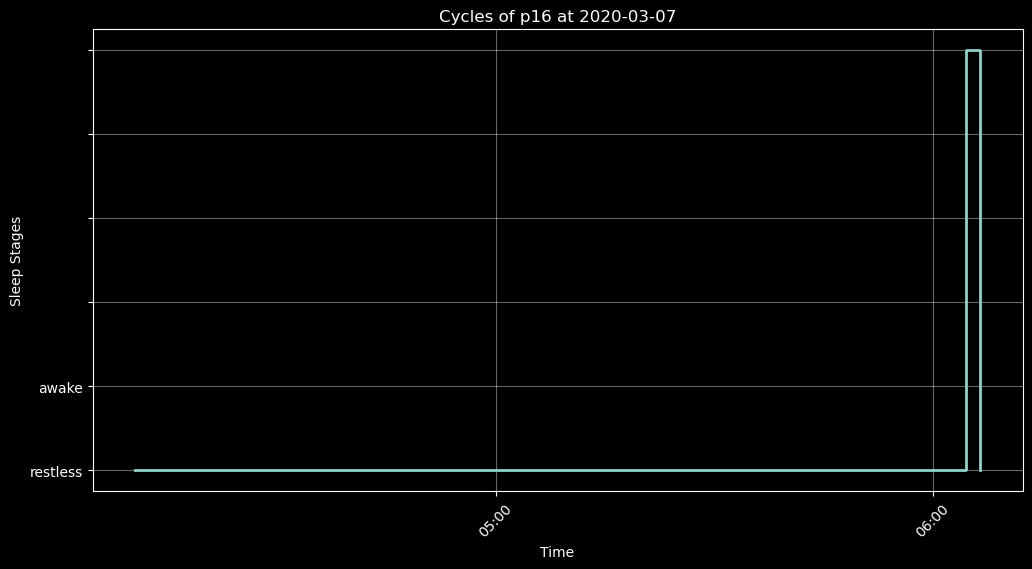

In [496]:
sleep_stages_by_day_chart_pXX('p16', '2020-03-07')

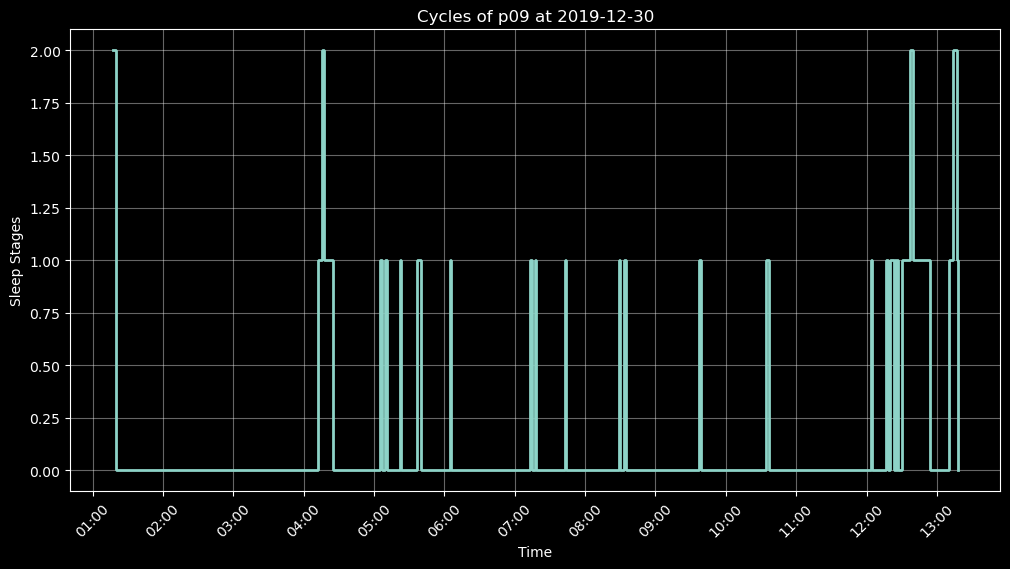

In [490]:
sleep_stages_by_day_chart_pXX('p09', '2019-12-30')

### `sleep_score`

In [244]:
sleep_score = pd.read_csv("p01/fitbit/sleep_score.csv")

In [245]:
sleep_score

timestamp  sleep_log_entry_id  overall_score  \
0    2019-11-01T06:29:30Z         24472394143             76   
1    2019-11-02T07:19:30Z         24486013387             79   
2    2019-11-03T07:34:30Z         24497341340             71   
3    2019-11-04T06:35:00Z         24507914069             68   
4    2019-11-05T06:25:00Z         24521896102             73   
..                    ...                 ...            ...   
145  2020-03-26T07:52:00Z         26479066869             76   
146  2020-03-27T08:12:30Z         26491780871             72   
147  2020-03-28T07:46:00Z         26502379603             67   
148  2020-03-29T08:40:30Z         26516647751             62   
149  2020-03-30T07:20:00Z         26528257996             78   

     composition_score  revitalization_score  duration_score  \
0                   18                    20              38   
1                   20                    22              37   
2                   16                    17              38   
3                   15                    15              38   
4                   15                    22              36   
..                 ...                   ...             ...   
145                 16                    20              40   
146                 19                    20              33   
147                 16                    14              37   
148                 16                    14              32   
149                 19                    20              39   

     deep_sleep_in_minutes  resting_heart_rate  restlessness  
0                       27                  53      0.053635  
1                       36                  53      0.078978  
2                       38                  52      0.093491  
3                       37                  53      0.064851  
4                       26                  54      0.093185  
..                     ...                 ...           ...  
145                     54                  50      0.058306  
146                     59                  50      0.096961  
147                      5                  50      0.087126  
148                     55                  51      0.056962  
149                     34                  53      0.136473  

[150 rows x 9 columns]

In [246]:
sleep_score.describe()

sleep_log_entry_id  overall_score  composition_score  \
count        1.500000e+02     150.000000         150.000000   
mean         2.546667e+10      71.633333          17.266667   
std          6.112299e+08       5.634763           2.350687   
min          2.447239e+10      53.000000          12.000000   
25%          2.493150e+10      68.000000          15.000000   
50%          2.543836e+10      72.000000          17.000000   
75%          2.599665e+10      75.000000          19.000000   
max          2.652826e+10      88.000000          22.000000   

       revitalization_score  duration_score  deep_sleep_in_minutes  \
count            150.000000      150.000000             150.000000   
mean              17.706667       36.660000              38.780000   
std                2.997867        3.268376              17.297581   
min               10.000000       25.000000               0.000000   
25%               15.000000       35.000000              27.250000   
50%               18.000000       37.000000              37.500000   
75%               20.000000       38.750000              48.750000   
max               23.000000       46.000000              93.000000   

       resting_heart_rate  restlessness  
count          150.000000    150.000000  
mean            51.800000      0.086812  
std              1.336127      0.029666  
min             49.000000      0.039437  
25%             51.000000      0.065046  
50%             52.000000      0.081021  
75%             53.000000      0.101530  
max             55.000000      0.199021

In [247]:
## After more exploring, the typical ranges include:
## Excellent: 90-100, Good: 80-89, Fair: 60-79, Poor: <60
## Most users on average score between 72 and 83.

conditions = [(sleep_score['overall_score'] >= 90), 
    (sleep_score['overall_score']  < 90) & (sleep_score['overall_score'] >= 80),
    (sleep_score['overall_score']  < 80) & (sleep_score['overall_score'] >= 60),
    (sleep_score['overall_score']  < 60)]

choices = ['Excellent', 'Good', 'Fair', 'Poor']

In [248]:
%timeit np.select(conditions, choices, default=0)

109 μs ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [249]:
sleep_score['sleep_quality'] = np.select(conditions, choices, default=0)

In [250]:
sleep_score

timestamp  sleep_log_entry_id  overall_score  \
0    2019-11-01T06:29:30Z         24472394143             76   
1    2019-11-02T07:19:30Z         24486013387             79   
2    2019-11-03T07:34:30Z         24497341340             71   
3    2019-11-04T06:35:00Z         24507914069             68   
4    2019-11-05T06:25:00Z         24521896102             73   
..                    ...                 ...            ...   
145  2020-03-26T07:52:00Z         26479066869             76   
146  2020-03-27T08:12:30Z         26491780871             72   
147  2020-03-28T07:46:00Z         26502379603             67   
148  2020-03-29T08:40:30Z         26516647751             62   
149  2020-03-30T07:20:00Z         26528257996             78   

     composition_score  revitalization_score  duration_score  \
0                   18                    20              38   
1                   20                    22              37   
2                   16                    17              38   
3                   15                    15              38   
4                   15                    22              36   
..                 ...                   ...             ...   
145                 16                    20              40   
146                 19                    20              33   
147                 16                    14              37   
148                 16                    14              32   
149                 19                    20              39   

     deep_sleep_in_minutes  resting_heart_rate  restlessness sleep_quality  
0                       27                  53      0.053635          Fair  
1                       36                  53      0.078978          Fair  
2                       38                  52      0.093491          Fair  
3                       37                  53      0.064851          Fair  
4                       26                  54      0.093185          Fair  
..                     ...                 ...           ...           ...  
145                     54                  50      0.058306          Fair  
146                     59                  50      0.096961          Fair  
147                      5                  50      0.087126          Fair  
148                     55                  51      0.056962          Fair  
149                     34                  53      0.136473          Fair  

[150 rows x 10 columns]

In [251]:
sleep_quality_grouped = pd.DataFrame(sleep_score.value_counts('sleep_quality')).reset_index()
sleep_quality_grouped

sleep_quality  count
0          Fair    134
1          Good     11
2          Poor      5

Text(0.5, 1.0, 'Sleep Quality of p01')

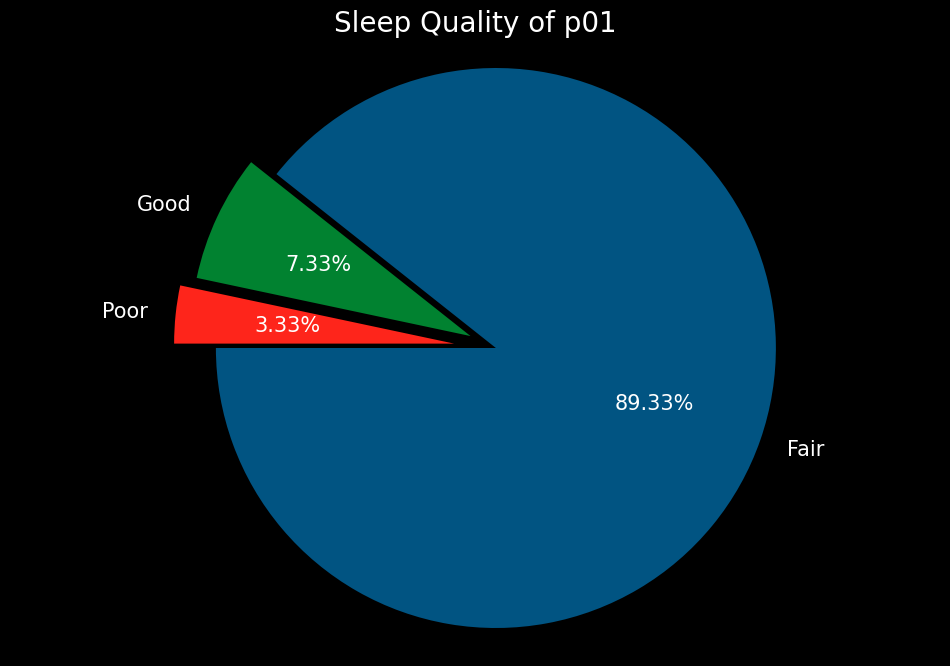

In [252]:
## Sequence from dataframe: Fair-Good-Poor; 2-3-1

explode = (0, 0.1, 0.15)
sq_colors = {'Fair': '#015482', 
             'Good': '#018230', 
             'Poor': '#FE251B'}

fig, ax = plt.subplots(figsize=(12, 8))

ax.pie(sleep_quality_grouped['count'], explode=explode,
    labels=sleep_quality_grouped['sleep_quality'], 
    textprops={'fontsize': 15}, autopct='%1.2f%%', 
    startangle=180, colors=[sq_colors[key] for key in 
           sleep_quality_grouped['sleep_quality']])

ax.axis('equal')
ax.set_title('Sleep Quality of p01', fontsize=20)

**Whole: `pXX`**

In [253]:
def clean_data_sleep_score():
    
    df_sleep_score = pd.DataFrame()
    
    for pXX in id_players:
        sleep_score_pXX = pd.read_csv(f"{pXX}/fitbit/sleep_score.csv")
        sleep_score_pXX['pXX'] = pXX
        df_sleep_score = pd.concat([df_sleep_score, sleep_score_pXX])
    
    ## After more exploring, the typical ranges of sleep quality include:
    ## Excellent: 90-100, Good: 80-89, Fair: 60-79, Poor: <60
    ## Most users on average score between 72 and 83.

    conditions = [(df_sleep_score['overall_score'] >= 90), 
        (df_sleep_score['overall_score']  < 90) & (df_sleep_score['overall_score'] >= 80),
        (df_sleep_score['overall_score']  < 80) & (df_sleep_score['overall_score'] >= 60),
        (df_sleep_score['overall_score']  < 60)]

    choices = ['Excellent', 'Good', 'Fair', 'Poor']
    
    df_sleep_score['sleep_quality'] = np.select(conditions, choices)
    
    return df_sleep_score

In [254]:
df_sleep_score = clean_data_sleep_score()

In [255]:
df_sleep_score.sample(5)

timestamp  sleep_log_entry_id  overall_score  \
116  2020-03-12T12:29:00Z         26294259490             72   
76   2020-02-04T07:37:30Z         25751043192             88   
93   2020-02-19T07:25:30Z         25964757873             69   
90   2020-02-10T08:02:30Z         25840570771             59   
102  2020-02-25T08:55:30Z         26060648639             78   

     composition_score  revitalization_score  duration_score  \
116                 16                    20              36   
76                  21                    21              46   
93                  15                    19              35   
90                  15                    20              24   
102                 20                    21              37   

     deep_sleep_in_minutes  resting_heart_rate  restlessness  pXX  \
116                     87                  61      0.142461  p09   
76                      59                  65      0.096896  p10   
93                      49                  59      0.086867  p08   
90                      57                  56      0.105413  p09   
102                    109                  59      0.091979  p09   

    sleep_quality  
116          Fair  
76           Good  
93           Fair  
90           Poor  
102          Fair

In [256]:
pd.DataFrame(
    df_sleep_score[df_sleep_score['pXX'] == 'p04']
    .value_counts('sleep_quality')).reset_index()


sleep_quality  count
0          Fair     71
1          Good     63
2     Excellent      4
3          Poor      2

In [257]:
def sleep_quality_pie_chart(player):
    
    sleep_quality_grouped_pXX = pd.DataFrame(
        df_sleep_score[df_sleep_score['pXX'] == player]
        .value_counts('sleep_quality')).reset_index()
    
    explode = (0, 0.05, 0.1, 0.15)
    sq_colors = {'Excellent': '#FFC000', 
                 'Good': '#018230',
                 'Fair': '#015482',  
                 'Poor': '#FE251B'}

    fig, ax = plt.subplots(figsize=(12, 8))
    n_sq = sleep_quality_grouped_pXX.shape[0]

    ax.pie(sleep_quality_grouped_pXX['count'], explode=explode[:n_sq],
        labels=sleep_quality_grouped_pXX['sleep_quality'], 
        textprops={'fontsize': 15}, autopct='%1.2f%%', 
        startangle=-135, colors=[sq_colors[key] for key in 
               sleep_quality_grouped_pXX['sleep_quality']])

    ax.axis('equal')
    ax.set_title(f'Sleep Quality of {player}', fontsize=20)

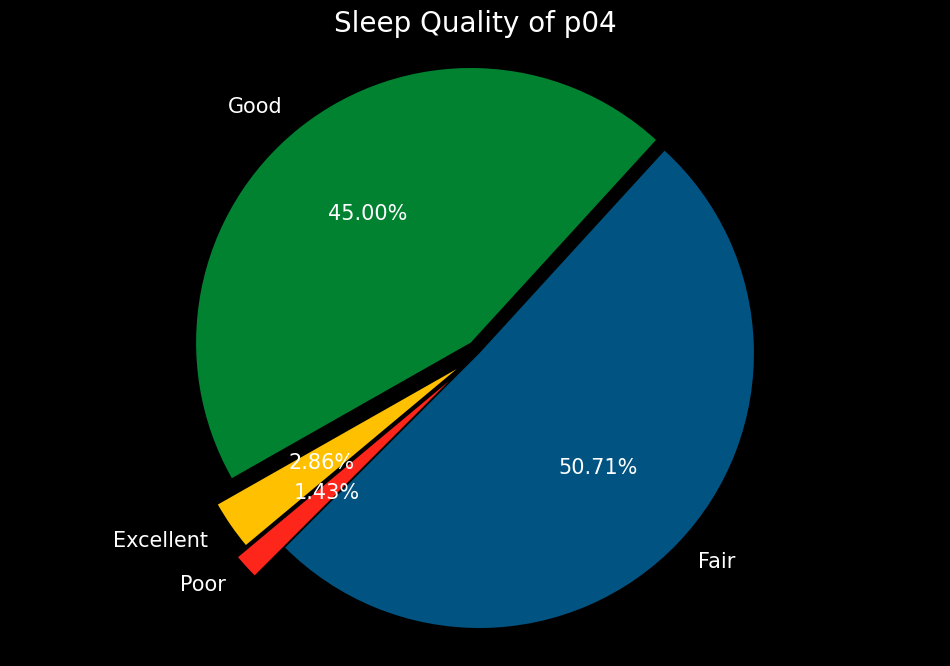

In [258]:
sleep_quality_pie_chart('p04')

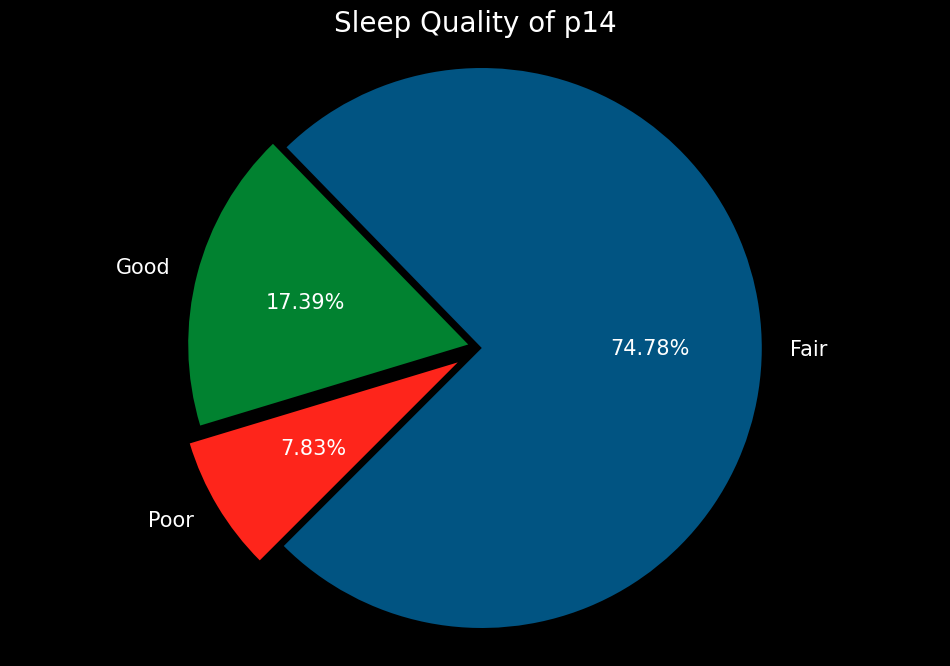

In [259]:
sleep_quality_pie_chart('p14')

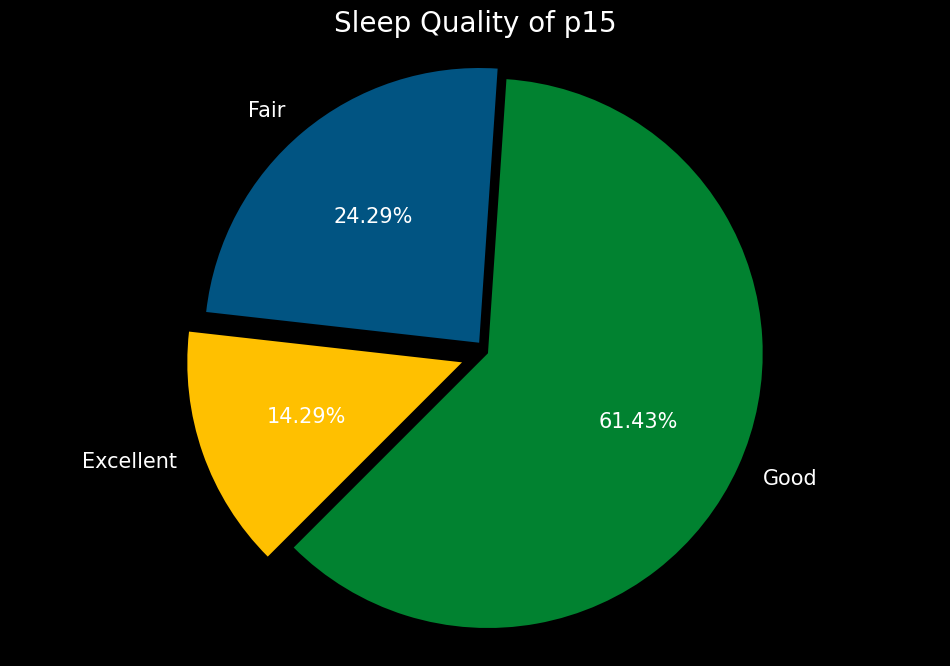

In [260]:
sleep_quality_pie_chart('p15')

## `googledocs`

### `reporting`

In [261]:
reporting = pd.read_csv("p01/googledocs/reporting.csv")

In [262]:
## One thing to notice, there are duplicate

reporting

date            timestamp                       meals  weight  \
0    06/11/2019  06/12/2019 21:58:30           Breakfast, Dinner   100.0   
1    09/11/2019  09/12/2019 21:17:02          Breakfast, Evening   100.0   
2    10/11/2019  10/12/2019 21:52:58    Breakfast, Lunch, Dinner   100.0   
3    11/11/2019  11/11/2019 22:36:30           Breakfast, Dinner   100.0   
4    12/11/2019  13/11/2019 00:15:47    Breakfast, Lunch, Dinner   100.0   
..          ...                  ...                         ...     ...   
104  27/03/2020  28/03/2020 00:52:18           Breakfast, Dinner     NaN   
105  28/03/2020  29/03/2020 00:33:43           Breakfast, Dinner     NaN   
106  29/03/2020  01/03/2020 23:13:54    Breakfast, Lunch, Dinner     NaN   
107  29/03/2020  30/03/2020 09:23:46  Breakfast, Dinner, Evening     NaN   
108  30/03/2020  31/03/2020 00:37:46    Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  
0                   7               No  
1                   6               No  
2                   9               No  
3                   5               No  
4                   7               No  
..                ...              ...  
104                 8               No  
105                 8               No  
106                 8               No  
107                 7               No  
108                 7               No  

[109 rows x 6 columns]

In [263]:
reporting['date']      = pd.to_datetime(reporting['date'], dayfirst=True)
reporting['timestamp'] = pd.to_datetime(reporting['timestamp'], dayfirst=True)
reporting

date           timestamp                       meals  weight  \
0   2019-11-06 2019-12-06 21:58:30           Breakfast, Dinner   100.0   
1   2019-11-09 2019-12-09 21:17:02          Breakfast, Evening   100.0   
2   2019-11-10 2019-12-10 21:52:58    Breakfast, Lunch, Dinner   100.0   
3   2019-11-11 2019-11-11 22:36:30           Breakfast, Dinner   100.0   
4   2019-11-12 2019-11-13 00:15:47    Breakfast, Lunch, Dinner   100.0   
..         ...                 ...                         ...     ...   
104 2020-03-27 2020-03-28 00:52:18           Breakfast, Dinner     NaN   
105 2020-03-28 2020-03-29 00:33:43           Breakfast, Dinner     NaN   
106 2020-03-29 2020-03-01 23:13:54    Breakfast, Lunch, Dinner     NaN   
107 2020-03-29 2020-03-30 09:23:46  Breakfast, Dinner, Evening     NaN   
108 2020-03-30 2020-03-31 00:37:46    Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  
0                   7               No  
1                   6               No  
2                   9               No  
3                   5               No  
4                   7               No  
..                ...              ...  
104                 8               No  
105                 8               No  
106                 8               No  
107                 7               No  
108                 7               No  

[109 rows x 6 columns]

In [264]:
reporting.sort_values('timestamp')[30:60]

date           timestamp                              meals  weight  \
11 2019-11-17 2019-12-17 21:21:57           Breakfast, Lunch, Dinner   101.0   
13 2019-11-18 2019-12-19 00:53:22           Breakfast, Lunch, Dinner   101.0   
16 2019-11-21 2019-12-22 08:09:49                  Breakfast, Dinner   100.0   
18 2019-11-22 2019-12-23 09:30:56                  Breakfast, Dinner   100.0   
34 2019-12-25 2019-12-25 21:16:05                  Breakfast, Dinner   101.0   
35 2019-12-27 2019-12-27 21:41:03                  Breakfast, Dinner   101.0   
36 2019-12-28 2019-12-28 23:26:17                  Breakfast, Dinner   101.0   
37 2019-12-29 2019-12-29 21:01:11                  Breakfast, Dinner   101.0   
38 2020-01-01 2020-01-02 09:11:37                  Breakfast, Dinner   101.0   
39 2020-01-05 2020-01-06 06:25:13                  Breakfast, Dinner   100.0   
40 2020-01-07 2020-01-07 23:28:23                  Breakfast, Dinner   101.0   
41 2020-01-10 2020-01-10 22:55:08           Breakfast, Lunch, Dinner   101.0   
42 2020-01-11 2020-01-11 22:50:11           Breakfast, Lunch, Dinner   101.0   
43 2020-01-14 2020-01-14 22:43:37          Breakfast, Lunch, Evening   101.0   
44 2020-01-15 2020-01-15 21:37:02           Breakfast, Lunch, Dinner   100.0   
45 2020-01-17 2020-01-19 00:21:57                  Breakfast, Dinner    99.0   
46 2020-01-18 2020-01-19 00:22:40         Breakfast, Dinner, Evening    99.0   
47 2020-01-20 2020-01-20 23:38:54         Breakfast, Dinner, Evening   101.0   
48 2020-01-24 2020-01-24 22:39:54                      Lunch, Dinner   100.0   
49 2020-01-28 2020-01-29 12:39:17                  Breakfast, Dinner   100.0   
50 2020-01-29 2020-01-29 18:53:24           Breakfast, Lunch, Dinner   100.0   
51 2020-01-30 2020-01-31 00:00:06                   Breakfast, Lunch   100.0   
52 2020-01-31 2020-02-01 11:03:14                  Breakfast, Dinner   100.0   
53 2020-02-01 2020-02-01 20:59:08                  Breakfast, Dinner   100.0   
54 2020-02-02 2020-02-02 23:01:27  Breakfast, Lunch, Dinner, Evening   102.0   
55 2020-02-03 2020-02-03 23:57:39  Breakfast, Lunch, Dinner, Evening   101.0   
56 2020-02-04 2020-02-04 21:49:23          Breakfast, Lunch, Evening   101.0   
57 2020-02-05 2020-02-05 21:58:34           Breakfast, Lunch, Dinner   101.0   
58 2020-02-06 2020-02-07 06:53:38  Breakfast, Lunch, Dinner, Evening   100.0   
59 2020-02-07 2020-02-07 23:10:57           Breakfast, Lunch, Dinner   101.0   

    glasses_of_fluid alcohol_consumed  
11                10               No  
13                11               No  
16                11               No  
18                13               No  
34                 9               No  
35                10               No  
36                 9               No  
37                10               No  
38                 6               No  
39                 9               No  
40                 8               No  
41                 8               No  
42                10               No  
43                 9               No  
44                 7               No  
45                 8               No  
46                10               No  
47                 8               No  
48                 7               No  
49                 8               No  
50                 7               No  
51                 7               No  
52                 8               No  
53                 9               No  
54                 7               No  
55                 8               No  
56                 7               No  
57                 8               No  
58                11               No  
59                 8               No

In [265]:
reporting.loc[reporting['date'].duplicated(keep=False), :]

date           timestamp                              meals  weight  \
7   2019-11-15 2019-12-15 23:20:39           Breakfast, Lunch, Dinner   100.0   
8   2019-11-15 2019-11-15 23:38:30           Breakfast, Lunch, Dinner   100.0   
9   2019-11-16 2019-11-16 21:16:28                  Breakfast, Dinner   100.0   
10  2019-11-16 2019-12-16 22:10:40           Breakfast, Lunch, Dinner   100.0   
11  2019-11-17 2019-12-17 21:21:57           Breakfast, Lunch, Dinner   101.0   
12  2019-11-17 2019-11-17 21:44:44         Breakfast, Dinner, Evening   100.0   
13  2019-11-18 2019-12-19 00:53:22           Breakfast, Lunch, Dinner   101.0   
14  2019-11-18 2019-11-18 21:16:20           Breakfast, Lunch, Dinner   100.0   
16  2019-11-21 2019-12-22 08:09:49                  Breakfast, Dinner   100.0   
17  2019-11-21 2019-11-22 00:14:07           Breakfast, Lunch, Dinner   101.0   
18  2019-11-22 2019-12-23 09:30:56                  Breakfast, Dinner   100.0   
19  2019-11-22 2019-11-22 21:21:39         Breakfast, Dinner, Evening   100.0   
75  2020-02-24 2020-02-24 00:07:22           Breakfast, Lunch, Dinner   102.0   
76  2020-02-24 2020-02-25 00:15:28           Breakfast, Lunch, Dinner   100.0   
90  2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
91  2020-03-11 2020-03-12 00:33:38                  Breakfast, Dinner     NaN   
106 2020-03-29 2020-03-01 23:13:54           Breakfast, Lunch, Dinner     NaN   
107 2020-03-29 2020-03-30 09:23:46         Breakfast, Dinner, Evening     NaN   

     glasses_of_fluid alcohol_consumed  
7                   9               No  
8                   8               No  
9                   9               No  
10                  8               No  
11                 10               No  
12                  7               No  
13                 11               No  
14                 11               No  
16                 11               No  
17                  9               No  
18                 13               No  
19                  7               No  
75                  8               No  
76                  7               No  
90                  9               No  
91                  7               No  
106                 8               No  
107                 7               No

In [266]:
(reporting.loc[reporting['date'].duplicated(keep=False)]
    .groupby('date').agg(index = ('timestamp', lambda x: x.index.to_list())))

index
date                  
2019-11-15      [7, 8]
2019-11-16     [9, 10]
2019-11-17    [11, 12]
2019-11-18    [13, 14]
2019-11-21    [16, 17]
2019-11-22    [18, 19]
2020-02-24    [75, 76]
2020-03-11    [90, 91]
2020-03-29  [106, 107]

In [267]:
time_diffs = reporting['timestamp'] - reporting['date']
time_diffs[:10]

0   30 days 21:58:30
1   30 days 21:17:02
2   30 days 21:52:58
3    0 days 22:36:30
4    1 days 00:15:47
5    0 days 22:08:03
6    1 days 00:00:47
7   30 days 23:20:39
8    0 days 23:38:30
9    0 days 21:16:28
dtype: timedelta64[ns]

In [268]:
time_diffs.sort_values()[:10]

106   -28 days +23:13:54
90       0 days 00:01:33
75       0 days 00:07:22
50       0 days 18:53:24
53       0 days 20:59:08
37       0 days 21:01:11
27       0 days 21:16:01
34       0 days 21:16:05
14       0 days 21:16:20
9        0 days 21:16:28
dtype: timedelta64[ns]

In [269]:
time_diffs.sort_values()[-15:]

96     1 days 08:13:29
38     1 days 09:11:37
107    1 days 09:23:46
52     1 days 11:03:14
49     1 days 12:39:17
45     2 days 00:21:57
1     30 days 21:17:02
11    30 days 21:21:57
2     30 days 21:52:58
0     30 days 21:58:30
10    30 days 22:10:40
7     30 days 23:20:39
13    31 days 00:53:22
16    31 days 08:09:49
18    31 days 09:30:56
dtype: timedelta64[ns]

In [270]:
# Case 1 -- Filtering total seconds less than 14400s, or within 4 hours.
reporting.loc[(time_diffs.dt.days == 0) & 
    (time_diffs.dt.total_seconds() < 14400)]

date           timestamp                              meals  weight  \
75 2020-02-24 2020-02-24 00:07:22           Breakfast, Lunch, Dinner   102.0   
90 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

    glasses_of_fluid alcohol_consumed  
75                 8               No  
90                 9               No

In [271]:
case_1_index =  reporting.loc[(time_diffs.dt.days == 0) & 
    (time_diffs.dt.total_seconds() < 14400)].index
case_1_index

Index([75, 90], dtype='int64')

In [272]:
## Case 2 -- Input date within a month before/after
reporting.loc[(time_diffs.dt.days >= 3) | (time_diffs.dt.days < 0)]

date           timestamp                     meals  weight  \
0   2019-11-06 2019-12-06 21:58:30         Breakfast, Dinner   100.0   
1   2019-11-09 2019-12-09 21:17:02        Breakfast, Evening   100.0   
2   2019-11-10 2019-12-10 21:52:58  Breakfast, Lunch, Dinner   100.0   
7   2019-11-15 2019-12-15 23:20:39  Breakfast, Lunch, Dinner   100.0   
10  2019-11-16 2019-12-16 22:10:40  Breakfast, Lunch, Dinner   100.0   
11  2019-11-17 2019-12-17 21:21:57  Breakfast, Lunch, Dinner   101.0   
13  2019-11-18 2019-12-19 00:53:22  Breakfast, Lunch, Dinner   101.0   
16  2019-11-21 2019-12-22 08:09:49         Breakfast, Dinner   100.0   
18  2019-11-22 2019-12-23 09:30:56         Breakfast, Dinner   100.0   
106 2020-03-29 2020-03-01 23:13:54  Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  
0                   7               No  
1                   6               No  
2                   9               No  
7                   9               No  
10                  8               No  
11                 10               No  
13                 11               No  
16                 11               No  
18                 13               No  
106                 8               No

In [273]:
case_2_index = reporting.loc[(time_diffs.dt.days >= 3) | 
    (time_diffs.dt.days < 0)].index
case_2_index

Index([0, 1, 2, 7, 10, 11, 13, 16, 18, 106], dtype='int64')

Here we'll put assumption that players would fill the data ideally within 1-3 days. After further inspection, there are two occurences of `date` duplicates:

* The player at times input data at midnight, where the date changes. Yet the player inputs the `date` the same as `timestamp`--it should've been different. For this, we're changing the `date` into the previous day.
* There are few dates inputted with `timestamp` difference a month before and a month after. We'll assume the `date` is invalid on this one, so we'll change it referring to the ones in `timestamp`.

In [274]:
reporting.loc[reporting.index.isin(case_1_index), 'date'] = (
    reporting.loc[reporting.index.isin(case_1_index), 'date'] -
    pd.Timedelta(days=1))

reporting.loc[reporting.index.isin(case_1_index)]

date           timestamp                              meals  weight  \
75 2020-02-23 2020-02-24 00:07:22           Breakfast, Lunch, Dinner   102.0   
90 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

    glasses_of_fluid alcohol_consumed  
75                 8               No  
90                 9               No

In [275]:
reporting.loc[reporting.index.isin(case_2_index), 'date'] = (
reporting.loc[reporting.index.isin(case_2_index), 'timestamp'].dt.date)

reporting.loc[reporting.index.isin(case_2_index)]

date           timestamp                     meals  weight  \
0   2019-12-06 2019-12-06 21:58:30         Breakfast, Dinner   100.0   
1   2019-12-09 2019-12-09 21:17:02        Breakfast, Evening   100.0   
2   2019-12-10 2019-12-10 21:52:58  Breakfast, Lunch, Dinner   100.0   
7   2019-12-15 2019-12-15 23:20:39  Breakfast, Lunch, Dinner   100.0   
10  2019-12-16 2019-12-16 22:10:40  Breakfast, Lunch, Dinner   100.0   
11  2019-12-17 2019-12-17 21:21:57  Breakfast, Lunch, Dinner   101.0   
13  2019-12-19 2019-12-19 00:53:22  Breakfast, Lunch, Dinner   101.0   
16  2019-12-22 2019-12-22 08:09:49         Breakfast, Dinner   100.0   
18  2019-12-23 2019-12-23 09:30:56         Breakfast, Dinner   100.0   
106 2020-03-01 2020-03-01 23:13:54  Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  
0                   7               No  
1                   6               No  
2                   9               No  
7                   9               No  
10                  8               No  
11                 10               No  
13                 11               No  
16                 11               No  
18                 13               No  
106                 8               No

In [276]:
## Check again for duplicates
reporting.loc[reporting['date'].duplicated(keep=False), :]

date           timestamp                              meals  weight  \
89 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

    glasses_of_fluid alcohol_consumed  
89                 8               No  
90                 9               No

In [277]:
reporting[87:92]

date           timestamp                              meals  weight  \
87 2020-03-07 2020-03-08 00:01:03             Lunch, Dinner, Evening     NaN   
88 2020-03-08 2020-03-09 00:07:31           Breakfast, Lunch, Dinner     NaN   
89 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
91 2020-03-11 2020-03-12 00:33:38                  Breakfast, Dinner     NaN   

    glasses_of_fluid alcohol_consumed  
87                10               No  
88                 8               No  
89                 8               No  
90                 9               No  
91                 7               No

In [278]:
## Index 89 should've been the previous date: 2020-03-09
## Assumption: The player's inputting two dates at a certain day.

## Check for 

index_dupl = (reporting.loc[reporting['date'].duplicated(keep=False), :]
    .sort_values(['date', 'timestamp']))
index_dupl

date           timestamp                              meals  weight  \
89 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

    glasses_of_fluid alcohol_consumed  
89                 8               No  
90                 9               No

In [279]:
index_dupl.dtypes

date                datetime64[ns]
timestamp           datetime64[ns]
meals                       object
weight                     float64
glasses_of_fluid             int64
alcohol_consumed            object
dtype: object

In [280]:
## for ones with same date, with several duplicates
## Cases: same timestamp of input for history of several days

dupl_shape = index_dupl.shape[0] - 1
for i in range(dupl_shape):
    index_dupl.iloc[i, index_dupl.columns.get_loc('date')] = (
        index_dupl.iloc[i]['date'] - pd.Timedelta(days=dupl_shape - i))

In [281]:
index_dupl

date           timestamp                              meals  weight  \
89 2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

    glasses_of_fluid alcohol_consumed  
89                 8               No  
90                 9               No

In [282]:
reporting.update(index_dupl)

In [283]:
reporting[reporting.index == 89]

date           timestamp                     meals  weight  \
89 2020-03-09 2020-03-11 00:00:57  Breakfast, Lunch, Dinner     NaN   

    glasses_of_fluid alcohol_consumed  
89                 8               No

In [284]:
## Check again for duplicates
reporting.loc[reporting['date'].duplicated(keep=False), :]

Empty DataFrame
Columns: [date, timestamp, meals, weight, glasses_of_fluid, alcohol_consumed]
Index: []

#### Attempts on Visuals

In [285]:
reporting.head()

date           timestamp                     meals  weight  \
0 2019-12-06 2019-12-06 21:58:30         Breakfast, Dinner   100.0   
1 2019-12-09 2019-12-09 21:17:02        Breakfast, Evening   100.0   
2 2019-12-10 2019-12-10 21:52:58  Breakfast, Lunch, Dinner   100.0   
3 2019-11-11 2019-11-11 22:36:30         Breakfast, Dinner   100.0   
4 2019-11-12 2019-11-13 00:15:47  Breakfast, Lunch, Dinner   100.0   

   glasses_of_fluid alcohol_consumed  
0                 7               No  
1                 6               No  
2                 9               No  
3                 5               No  
4                 7               No

In [286]:
reporting

date           timestamp                       meals  weight  \
0   2019-12-06 2019-12-06 21:58:30           Breakfast, Dinner   100.0   
1   2019-12-09 2019-12-09 21:17:02          Breakfast, Evening   100.0   
2   2019-12-10 2019-12-10 21:52:58    Breakfast, Lunch, Dinner   100.0   
3   2019-11-11 2019-11-11 22:36:30           Breakfast, Dinner   100.0   
4   2019-11-12 2019-11-13 00:15:47    Breakfast, Lunch, Dinner   100.0   
..         ...                 ...                         ...     ...   
104 2020-03-27 2020-03-28 00:52:18           Breakfast, Dinner     NaN   
105 2020-03-28 2020-03-29 00:33:43           Breakfast, Dinner     NaN   
106 2020-03-01 2020-03-01 23:13:54    Breakfast, Lunch, Dinner     NaN   
107 2020-03-29 2020-03-30 09:23:46  Breakfast, Dinner, Evening     NaN   
108 2020-03-30 2020-03-31 00:37:46    Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  
0                   7               No  
1                   6               No  
2                   9               No  
3                   5               No  
4                   7               No  
..                ...              ...  
104                 8               No  
105                 8               No  
106                 8               No  
107                 7               No  
108                 7               No  

[109 rows x 6 columns]

In [287]:
meals = pd.get_dummies(reporting['meals'].str.get_dummies(sep=', '))
meals.columns = meals.columns.str.lower()
meals = meals[['breakfast', 'lunch', 'evening', 'dinner']]
meals

breakfast  lunch  evening  dinner
0            1      0        0       1
1            1      0        1       0
2            1      1        0       1
3            1      0        0       1
4            1      1        0       1
..         ...    ...      ...     ...
104          1      0        0       1
105          1      0        0       1
106          1      1        0       1
107          1      0        1       1
108          1      1        0       1

[109 rows x 4 columns]

In [288]:
reporting = pd.concat([reporting, meals], axis=1)
reporting

date           timestamp                       meals  weight  \
0   2019-12-06 2019-12-06 21:58:30           Breakfast, Dinner   100.0   
1   2019-12-09 2019-12-09 21:17:02          Breakfast, Evening   100.0   
2   2019-12-10 2019-12-10 21:52:58    Breakfast, Lunch, Dinner   100.0   
3   2019-11-11 2019-11-11 22:36:30           Breakfast, Dinner   100.0   
4   2019-11-12 2019-11-13 00:15:47    Breakfast, Lunch, Dinner   100.0   
..         ...                 ...                         ...     ...   
104 2020-03-27 2020-03-28 00:52:18           Breakfast, Dinner     NaN   
105 2020-03-28 2020-03-29 00:33:43           Breakfast, Dinner     NaN   
106 2020-03-01 2020-03-01 23:13:54    Breakfast, Lunch, Dinner     NaN   
107 2020-03-29 2020-03-30 09:23:46  Breakfast, Dinner, Evening     NaN   
108 2020-03-30 2020-03-31 00:37:46    Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  breakfast  lunch  evening  dinner  
0                   7               No          1      0        0       1  
1                   6               No          1      0        1       0  
2                   9               No          1      1        0       1  
3                   5               No          1      0        0       1  
4                   7               No          1      1        0       1  
..                ...              ...        ...    ...      ...     ...  
104                 8               No          1      0        0       1  
105                 8               No          1      0        0       1  
106                 8               No          1      1        0       1  
107                 7               No          1      0        1       1  
108                 7               No          1      1        0       1  

[109 rows x 10 columns]

In [289]:
## How to make settings for residual duplicates?
## For instance: Ones above. You want to choose
## the early/late ones. Check the surroundings,
## fill dates on where it should be.

In [290]:
pd.DataFrame(reporting['glasses_of_fluid']
    .value_counts().sort_index(ascending=False)).reset_index()

glasses_of_fluid  count
0                13      2
1                11      4
2                10     10
3                 9     18
4                 8     37
5                 7     29
6                 6      8
7                 5      1

In [291]:
reporting[-30:]

date           timestamp                              meals  weight  \
79  2020-02-27 2020-02-27 23:49:08         Breakfast, Dinner, Evening   100.0   
80  2020-02-28 2020-02-29 00:47:00  Breakfast, Lunch, Dinner, Evening   100.0   
81  2020-02-29 2020-03-01 01:25:12                  Breakfast, Dinner   100.5   
82  2020-03-02 2020-03-02 23:20:23           Breakfast, Lunch, Dinner     NaN   
83  2020-03-03 2020-03-03 23:09:04         Breakfast, Dinner, Evening     NaN   
84  2020-03-04 2020-03-04 23:18:44           Breakfast, Lunch, Dinner     NaN   
85  2020-03-05 2020-03-05 23:14:16           Breakfast, Lunch, Dinner     NaN   
86  2020-03-06 2020-03-07 00:08:08           Breakfast, Lunch, Dinner     NaN   
87  2020-03-07 2020-03-08 00:01:03             Lunch, Dinner, Evening     NaN   
88  2020-03-08 2020-03-09 00:07:31           Breakfast, Lunch, Dinner     NaN   
89  2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90  2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
91  2020-03-11 2020-03-12 00:33:38                  Breakfast, Dinner     NaN   
92  2020-03-12 2020-03-12 23:09:43                      Lunch, Dinner     NaN   
93  2020-03-13 2020-03-13 23:54:13                  Breakfast, Dinner     NaN   
94  2020-03-14 2020-03-15 00:12:22          Breakfast, Lunch, Evening     NaN   
95  2020-03-15 2020-03-15 23:52:32         Breakfast, Dinner, Evening     NaN   
96  2020-03-16 2020-03-17 08:13:29         Breakfast, Dinner, Evening     NaN   
97  2020-03-17 2020-03-17 23:52:30         Breakfast, Dinner, Evening     NaN   
98  2020-03-18 2020-03-19 00:07:45                      Lunch, Dinner     NaN   
99  2020-03-20 2020-03-21 00:04:36           Breakfast, Lunch, Dinner     NaN   
100 2020-03-21 2020-03-22 00:14:23                  Breakfast, Dinner     NaN   
101 2020-03-23 2020-03-23 23:42:04                     Lunch, Evening     NaN   
102 2020-03-25 2020-03-26 00:04:21                  Breakfast, Dinner     NaN   
103 2020-03-26 2020-03-27 02:19:51                  Breakfast, Dinner     NaN   
104 2020-03-27 2020-03-28 00:52:18                  Breakfast, Dinner     NaN   
105 2020-03-28 2020-03-29 00:33:43                  Breakfast, Dinner     NaN   
106 2020-03-01 2020-03-01 23:13:54           Breakfast, Lunch, Dinner     NaN   
107 2020-03-29 2020-03-30 09:23:46         Breakfast, Dinner, Evening     NaN   
108 2020-03-30 2020-03-31 00:37:46           Breakfast, Lunch, Dinner     NaN   

     glasses_of_fluid alcohol_consumed  breakfast  lunch  evening  dinner  
79                 10               No          1      0        1       1  
80                  8               No          1      1        1       1  
81                 10               No          1      0        0       1  
82                  7               No          1      1        0       1  
83                  7               No          1      0        1       1  
84                  8               No          1      1        0       1  
85                  8               No          1      1        0       1  
86                  9               No          1      1        0       1  
87                 10               No          0      1        1       1  
88                  8               No          1      1        0       1  
89                  8               No          1      1        0       1  
90                  9               No          1      1        1       1  
91                  7               No          1      0        0       1  
92                  8               No          0      1        0       1  
93                  6               No          1      0        0       1  
94                  7               No          1      1        1       0  
95                  8               No          1      0        1       1  
96                  6               No          1      0        1       1  
97                  7               No          1     

<Axes: xlabel='date'>

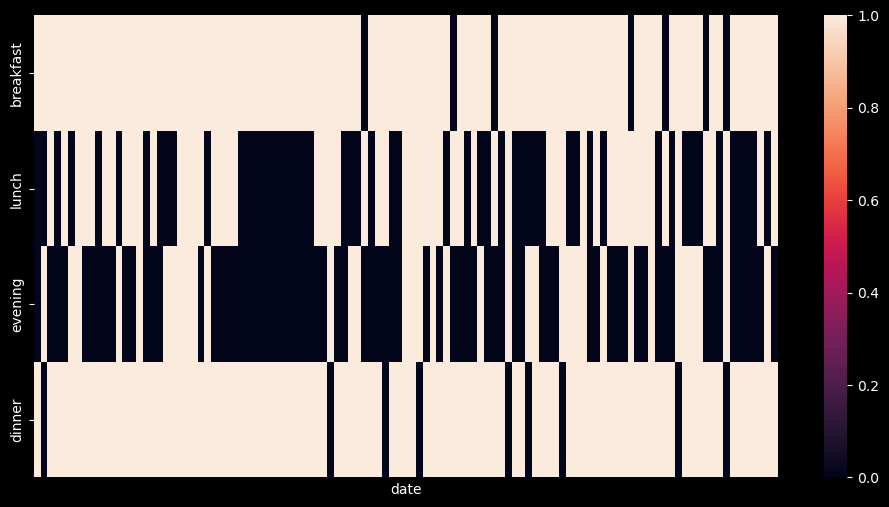

In [292]:
plt.figure(figsize=(12, 6))
sns.heatmap(reporting[['date', 'breakfast', 
    'lunch', 'evening', 'dinner']].set_index('date').T, 
    cmap='rocket', xticklabels=False)

In [293]:
## Experiment: Make it only for recent X days, and modify visuals
def meals_check_heatmap(days):

    plt.figure(figsize=(15, 6))
    sns.heatmap(reporting[['date', 'breakfast', 
        'lunch', 'evening', 'dinner']][-days:].set_index('date').T,
        cmap='rocket', xticklabels=False, linewidths=2, 
        linecolor='black', clip_on=False)

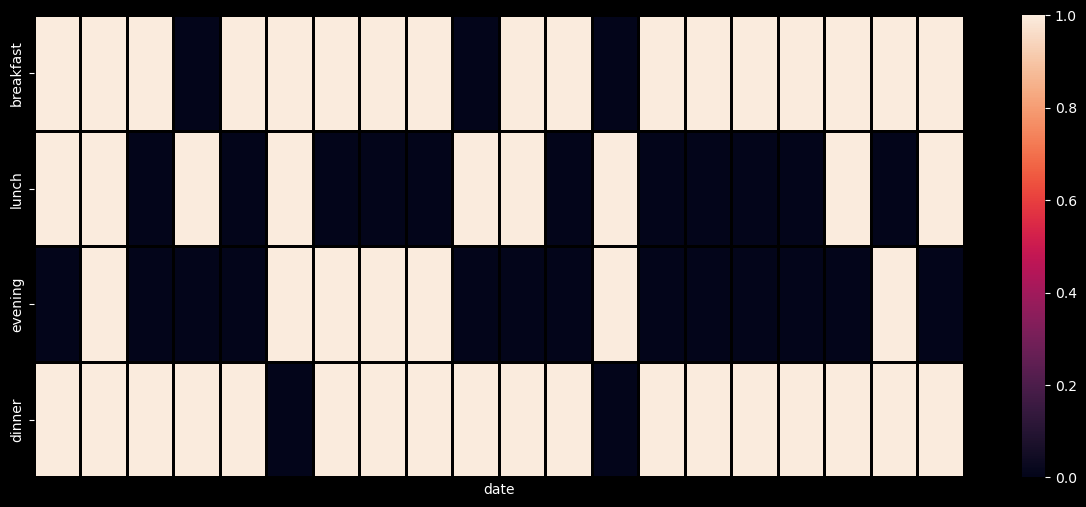

In [294]:
meals_check_heatmap(20)

**Whole: `pXX`**

In [295]:
df_reporting = pd.DataFrame()

for pXX in id_players:
    
    reporting_pXX = pd.read_csv("p01/googledocs/reporting.csv")
    reporting_pXX['pXX'] = pXX
    df_reporting = pd.concat([df_reporting, reporting_pXX], ignore_index=True)
    
df_reporting.head()

date            timestamp                     meals  weight  \
0  06/11/2019  06/12/2019 21:58:30         Breakfast, Dinner   100.0   
1  09/11/2019  09/12/2019 21:17:02        Breakfast, Evening   100.0   
2  10/11/2019  10/12/2019 21:52:58  Breakfast, Lunch, Dinner   100.0   
3  11/11/2019  11/11/2019 22:36:30         Breakfast, Dinner   100.0   
4  12/11/2019  13/11/2019 00:15:47  Breakfast, Lunch, Dinner   100.0   

   glasses_of_fluid alcohol_consumed  pXX  
0                 7               No  p01  
1                 6               No  p01  
2                 9               No  p01  
3                 5               No  p01  
4                 7               No  p01

In [296]:
df_reporting.dtypes

date                 object
timestamp            object
meals                object
weight              float64
glasses_of_fluid      int64
alcohol_consumed     object
pXX                  object
dtype: object

In [297]:
df_reporting['date']      = pd.to_datetime(
    df_reporting['date'], dayfirst=True)
df_reporting['timestamp'] = pd.to_datetime(
    df_reporting['timestamp'], dayfirst=True)

In [298]:
df_reporting['time_diffs'] = df_reporting['timestamp'] - df_reporting['date']
df_reporting.sample(5)

date           timestamp                       meals  weight  \
1158 2020-02-16 2020-02-16 21:36:00           Breakfast, Dinner   100.0   
772  2019-11-16 2019-11-16 21:16:28           Breakfast, Dinner   100.0   
1150 2020-02-08 2020-02-09 00:30:27  Breakfast, Dinner, Evening   100.0   
218  2019-11-06 2019-12-06 21:58:30           Breakfast, Dinner   100.0   
440  2019-11-12 2019-11-13 00:15:47    Breakfast, Lunch, Dinner   100.0   

      glasses_of_fluid alcohol_consumed  pXX       time_diffs  
1158                 6               No  p11  0 days 21:36:00  
772                  9               No  p08  0 days 21:16:28  
1150                 8               No  p11  1 days 00:30:27  
218                  7               No  p03 30 days 21:58:30  
440                  7               No  p05  1 days 00:15:47

In [299]:
# Case 1 -- Filtering total seconds less than 14400s, or within 4 hours.
df_filter_case_1 =  df_reporting.loc[
    (df_reporting['time_diffs'].dt.days == 0) & 
    (df_reporting['time_diffs'].dt.total_seconds() < 14400)]

In [300]:
## Case 2 -- Input date within a month before/after

df_filter_case_2 = df_reporting.loc[
    (df_reporting['time_diffs'].dt.days >= 3) | 
    (df_reporting['time_diffs'].dt.days < 0)]

In [301]:
df_filter_case_1.loc[df_filter_case_1['time_diffs'].sort_values()[:5].index]

date           timestamp                              meals  \
853  2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1616 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1507 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1398 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1289 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   

      weight  glasses_of_fluid alcohol_consumed  pXX      time_diffs  
853      NaN                 9               No  p08 0 days 00:01:33  
1616     NaN                 9               No  p15 0 days 00:01:33  
1507     NaN                 9               No  p14 0 days 00:01:33  
1398     NaN                 9               No  p13 0 days 00:01:33  
1289     NaN                 9               No  p12 0 days 00:01:33

In [302]:
df_filter_case_1.loc[df_filter_case_1['time_diffs'].sort_values()[:5].index]

date           timestamp                              meals  \
853  2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1616 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1507 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1398 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1289 2020-03-11 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   

      weight  glasses_of_fluid alcohol_consumed  pXX      time_diffs  
853      NaN                 9               No  p08 0 days 00:01:33  
1616     NaN                 9               No  p15 0 days 00:01:33  
1507     NaN                 9               No  p14 0 days 00:01:33  
1398     NaN                 9               No  p13 0 days 00:01:33  
1289     NaN                 9               No  p12 0 days 00:01:33

In [303]:
## Cleaning case 1: Subtract date by one day

df_reporting.loc[df_reporting.index.isin(
    df_filter_case_1.index), 'date'] = (

df_reporting.loc[df_reporting.index.isin(
    df_filter_case_1.index), 'date'] - pd.Timedelta(days=1))

In [304]:
df_reporting.loc[df_reporting.index.isin(df_filter_case_1.index)].sample(5)

date           timestamp                              meals  \
1056 2020-02-23 2020-02-24 00:07:22           Breakfast, Lunch, Dinner   
1180 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1601 2020-02-23 2020-02-24 00:07:22           Breakfast, Lunch, Dinner   
1398 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   
1071 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening   

      weight  glasses_of_fluid alcohol_consumed  pXX      time_diffs  
1056   102.0                 8               No  p10 0 days 00:07:22  
1180     NaN                 9               No  p11 0 days 00:01:33  
1601   102.0                 8               No  p15 0 days 00:07:22  
1398     NaN                 9               No  p13 0 days 00:01:33  
1071     NaN                 9               No  p10 0 days 00:01:33

In [305]:
## Cleaning case 2: Change `date` into date of `timestamp`

df_reporting.loc[df_reporting.index.isin(
    df_filter_case_2.index), 'date'] = (

df_reporting.loc[df_reporting.index.isin(
    df_filter_case_2.index), 'timestamp'].dt.date)

In [306]:
df_reporting.loc[df_reporting.index.isin(df_filter_case_2.index)].sample(5)

date           timestamp                     meals  weight  \
1414 2020-03-01 2020-03-01 23:13:54  Breakfast, Lunch, Dinner     NaN   
1103 2019-12-19 2019-12-19 00:53:22  Breakfast, Lunch, Dinner   101.0   
1090 2019-12-06 2019-12-06 21:58:30         Breakfast, Dinner   100.0   
997  2019-12-22 2019-12-22 08:09:49         Breakfast, Dinner   100.0   
1632 2020-03-01 2020-03-01 23:13:54  Breakfast, Lunch, Dinner     NaN   

      glasses_of_fluid alcohol_consumed  pXX         time_diffs  
1414                 8               No  p13 -28 days +23:13:54  
1103                11               No  p11   31 days 00:53:22  
1090                 7               No  p11   30 days 21:58:30  
997                 11               No  p10   31 days 08:09:49  
1632                 8               No  p15 -28 days +23:13:54

In [307]:
df_dupl = (df_reporting.loc[
    df_reporting[['pXX', 'date']].duplicated(keep=False), :]
        .sort_values(['pXX', 'date', 'timestamp']))
df_dupl.head(10)

date           timestamp                              meals  weight  \
89  2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90  2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
198 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
199 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
307 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
308 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
416 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
417 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
525 2020-03-10 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
526 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

     glasses_of_fluid alcohol_consumed  pXX      time_diffs  
89                  8               No  p01 1 days 00:00:57  
90                  9               No  p01 0 days 00:01:33  
198                 8               No  p02 1 days 00:00:57  
199                 9               No  p02 0 days 00:01:33  
307                 8               No  p03 1 days 00:00:57  
308                 9               No  p03 0 days 00:01:33  
416                 8               No  p04 1 days 00:00:57  
417                 9               No  p04 0 days 00:01:33  
525                 8               No  p05 1 days 00:00:57  
526                 9               No  p05 0 days 00:01:33

In [308]:
## Case 3: Double-input in a day, both submitted after midnight

df_dupl_cleaned = pd.DataFrame()

for pXX in id_players:

    df_dupl_pXX    = df_dupl.loc[df_dupl['pXX'] == pXX]
    dupl_shape_pXX = df_dupl_pXX.shape[0] - 1

    for i in range(dupl_shape_pXX):
        df_dupl_pXX.iloc[i, df_dupl_pXX.columns.get_loc('date')] = (
            df_dupl_pXX.iloc[i]['date'] - pd.Timedelta(days=dupl_shape_pXX - i))
        
    df_dupl_cleaned = pd.concat([df_dupl_cleaned, df_dupl_pXX])

In [309]:
df_dupl_cleaned.head(10)

date           timestamp                              meals  weight  \
89  2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
90  2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
198 2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
199 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
307 2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
308 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
416 2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
417 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   
525 2020-03-09 2020-03-11 00:00:57           Breakfast, Lunch, Dinner     NaN   
526 2020-03-10 2020-03-11 00:01:33  Breakfast, Lunch, Dinner, Evening     NaN   

     glasses_of_fluid alcohol_consumed  pXX      time_diffs  
89                  8               No  p01 1 days 00:00:57  
90                  9               No  p01 0 days 00:01:33  
198                 8               No  p02 1 days 00:00:57  
199                 9               No  p02 0 days 00:01:33  
307                 8               No  p03 1 days 00:00:57  
308                 9               No  p03 0 days 00:01:33  
416                 8               No  p04 1 days 00:00:57  
417                 9               No  p04 0 days 00:01:33  
525                 8               No  p05 1 days 00:00:57  
526                 9               No  p05 0 days 00:01:33

In [310]:
df_reporting.update(df_dupl_cleaned)

In [311]:
## Check again for duplicates
(df_reporting.loc[
    df_reporting[['pXX', 'date']].duplicated(keep=False), :]
    .sort_values(['pXX', 'date', 'timestamp']))

Empty DataFrame
Columns: [date, timestamp, meals, weight, glasses_of_fluid, alcohol_consumed, pXX, time_diffs]
Index: []

In [312]:
def clean_data_reporting_pXX():
    
    df_reporting = pd.DataFrame()

    for pXX in id_players:

        reporting_pXX = pd.read_csv("p01/googledocs/reporting.csv")
        reporting_pXX['pXX'] = pXX
        df_reporting = pd.concat([df_reporting, reporting_pXX], ignore_index=True)
    
    df_reporting['date']      = pd.to_datetime(
        df_reporting['date'], dayfirst=True)
    df_reporting['timestamp'] = pd.to_datetime(
        df_reporting['timestamp'], dayfirst=True)
    
    df_reporting['time_diffs'] = df_reporting['timestamp'] - df_reporting['date']
    
    # Case 1 -- Filtering total seconds less than 14400s, or within 4 hours.
    df_filter_case_1 =  df_reporting.loc[
        (df_reporting['time_diffs'].dt.days == 0) & 
        (df_reporting['time_diffs'].dt.total_seconds() < 14400)]
    
    ## Case 2 -- Input date within a month before/after
    df_filter_case_2 = df_reporting.loc[
        (df_reporting['time_diffs'].dt.days >= 3) | 
        (df_reporting['time_diffs'].dt.days < 0)]
    
    ## Cleaning case 1: Subtract date by one day
    df_reporting.loc[df_reporting.index.isin(
        df_filter_case_1.index), 'date'] = (

    df_reporting.loc[df_reporting.index.isin(
        df_filter_case_1.index), 'date'] - pd.Timedelta(days=1))
    
    ## Cleaning case 2: Change `date` into date of `timestamp`
    df_reporting.loc[df_reporting.index.isin(
        df_filter_case_2.index), 'date'] = (

    df_reporting.loc[df_reporting.index.isin(
        df_filter_case_2.index), 'timestamp'].dt.date)
    
    ## Cleaning duplicates
    df_dupl = (df_reporting.loc[
        df_reporting[['pXX', 'date']].duplicated(keep=False), :]
            .sort_values(['pXX', 'date', 'timestamp']))
    
    ## Case 3 (duplicates): 
    ## Double-input in a day, both submitted after midnight
    df_dupl_cleaned = pd.DataFrame()

    for pXX in id_players:

        df_dupl_pXX    = df_dupl.loc[df_dupl['pXX'] == pXX]
        dupl_shape_pXX = df_dupl_pXX.shape[0] - 1

        for i in range(dupl_shape_pXX):
            df_dupl_pXX.iloc[i, df_dupl_pXX.columns.get_loc('date')] = (
                df_dupl_pXX.iloc[i]['date'] - pd.Timedelta(days=dupl_shape_pXX - i))

        df_dupl_cleaned = pd.concat([df_dupl_cleaned, df_dupl_pXX])
    
    df_reporting.update(df_dupl_cleaned)
    
    df_reporting = df_reporting.drop('time_diffs', axis=1)
    
    ## Additional cleaning for data-viz of meals:
    
    meals = pd.get_dummies(df_reporting['meals'].str.get_dummies(sep=', '))
    meals.columns = meals.columns.str.lower()
    meals = meals[['breakfast', 'lunch', 'evening', 'dinner']]
    
    df_reporting = pd.concat([df_reporting, meals], axis=1)
    
    return df_reporting

In [313]:
df_reporting = clean_data_reporting_pXX()

In [314]:
df_reporting.head()

date           timestamp                     meals  weight  \
0 2019-12-06 2019-12-06 21:58:30         Breakfast, Dinner   100.0   
1 2019-12-09 2019-12-09 21:17:02        Breakfast, Evening   100.0   
2 2019-12-10 2019-12-10 21:52:58  Breakfast, Lunch, Dinner   100.0   
3 2019-11-11 2019-11-11 22:36:30         Breakfast, Dinner   100.0   
4 2019-11-12 2019-11-13 00:15:47  Breakfast, Lunch, Dinner   100.0   

   glasses_of_fluid alcohol_consumed  pXX  breakfast  lunch  evening  dinner  
0                 7               No  p01          1      0        0       1  
1                 6               No  p01          1      0        1       0  
2                 9               No  p01          1      1        0       1  
3                 5               No  p01          1      0        0       1  
4                 7               No  p01          1      1        0       1

In [315]:
(df_reporting.loc[
        df_reporting[['pXX', 'date']].duplicated(keep=False), :]
            .sort_values(['pXX', 'date', 'timestamp']))

Empty DataFrame
Columns: [date, timestamp, meals, weight, glasses_of_fluid, alcohol_consumed, pXX, breakfast, lunch, evening, dinner]
Index: []

In [316]:
def meals_check_heatmap_pXX(player, days):
    
    df_reporting_pXX = df_reporting.loc[df_reporting['pXX'] == player]
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(df_reporting_pXX[['date', 'breakfast', 
        'lunch', 'evening', 'dinner']][-days:].set_index('date').T,
        cmap='rocket', xticklabels=False, linewidths=2, 
        linecolor='black', clip_on=False)

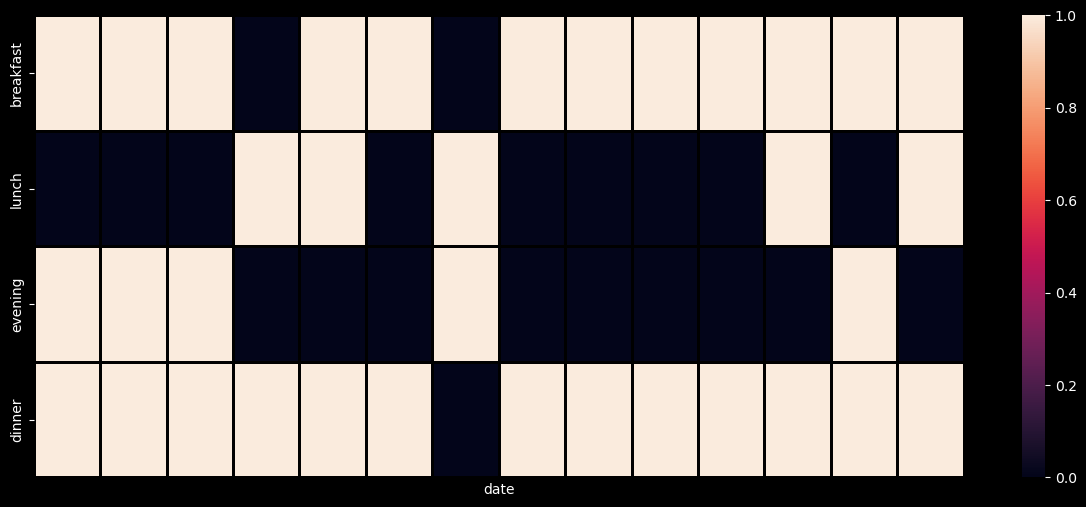

In [317]:
meals_check_heatmap_pXX('p01', 14)

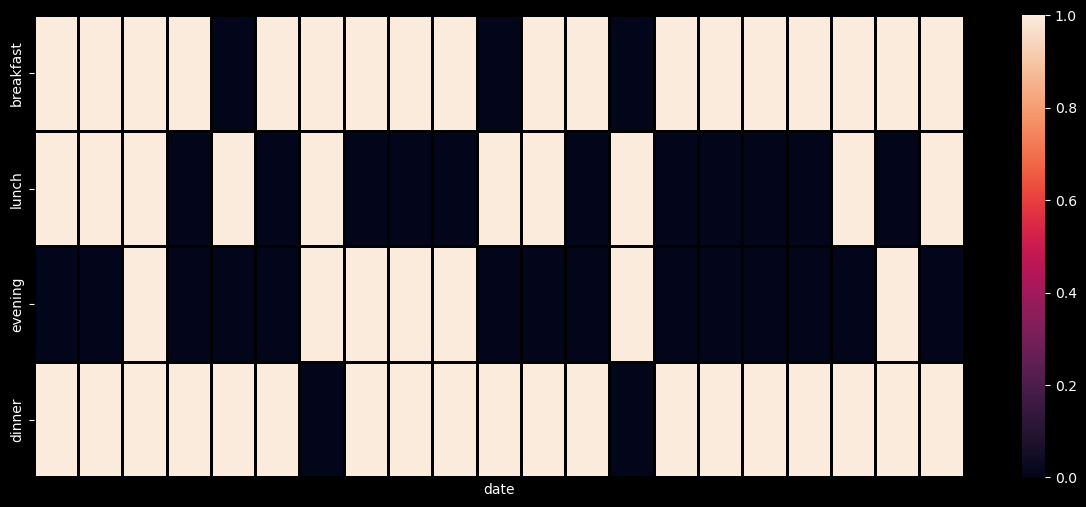

In [318]:
meals_check_heatmap_pXX('p09', 21)

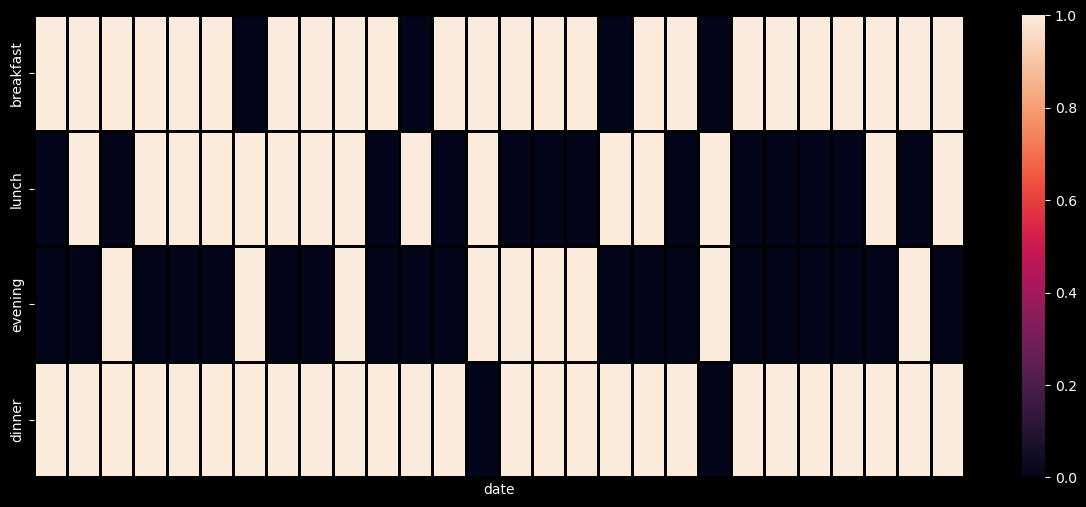

In [319]:
meals_check_heatmap_pXX('p14', 28)

## `pmsys`

### `injury`

In [320]:
injury = pd.read_csv("p01/pmsys/injury.csv")

In [321]:
injury

effective_time_frame                 injuries
0   2019-11-07T06:39:48.428Z                       {}
1   2019-11-11T13:47:05.617Z                       {}
2   2019-11-18T08:28:53.208Z                       {}
3   2019-11-25T08:10:11.478Z                       {}
4   2019-12-02T08:10:19.841Z                       {}
5   2019-12-09T08:17:02.463Z                       {}
6   2019-12-16T08:16:54.735Z                       {}
7   2019-12-25T11:04:39.750Z                       {}
8   2019-12-30T08:17:02.019Z                       {}
9   2020-01-04T16:20:58.607Z                       {}
10  2020-01-06T05:39:54.344Z                       {}
11  2020-01-07T22:33:38.989Z  {'right_hand': 'minor'}
12  2020-01-14T09:01:10.195Z                       {}
13  2020-01-23T20:53:39.290Z                       {}
14  2020-01-28T08:49:21.832Z                       {}
15  2020-02-03T08:00:17.703Z                       {}
16  2020-02-06T09:13:53.358Z                       {}
17  2020-02-12T09:40:30.464Z                       {}
18  2020-02-17T22:20:05.008Z                       {}
19  2020-02-27T09:00:44.628Z                       {}
20  2020-03-03T06:54:29.540Z                       {}
21  2020-03-12T08:06:01.300Z                       {}
22  2020-03-15T22:30:57.044Z                       {}
23  2020-03-24T17:03:33.413Z                       {}

In [322]:
# Attempts on visual: Just a table. It likely only has
# countable data in all players, so we'll just show as is
injury['effective_time_frame'] = pd.to_datetime(
    injury['effective_time_frame'])
injury.loc[injury['injuries'] != '{}']

effective_time_frame                 injuries
11 2020-01-07 22:33:38.989000+00:00  {'right_hand': 'minor'}

#### **Whole: `pXX`**

In [323]:
def clean_data_injury():

    df_injury = pd.DataFrame()

    for pXX in id_players:

        try:
            injury_pXX = pd.read_csv(f"{pXX}/pmsys/injury.csv")
            injury_pXX['pXX'] = pXX
            df_injury = pd.concat([df_injury, injury_pXX])

            df_injury['effective_time_frame'] = pd.to_datetime(
                df_injury['effective_time_frame'])
        
        except FileNotFoundError as e:
            print(f"File {pXX}/pmsys/injury.csv is not found -- Skipping..")
            
    return df_injury 

In [324]:
df_injury = clean_data_injury()

File p08/pmsys/injury.csv is not found -- Skipping..


In [325]:
df_injury

effective_time_frame injuries  pXX
0  2019-11-07 06:39:48.428000+00:00       {}  p01
1  2019-11-11 13:47:05.617000+00:00       {}  p01
2  2019-11-18 08:28:53.208000+00:00       {}  p01
3  2019-11-25 08:10:11.478000+00:00       {}  p01
4  2019-12-02 08:10:19.841000+00:00       {}  p01
..                              ...      ...  ...
6  2020-01-20 15:42:00.634000+00:00       {}  p16
7  2020-01-28 20:53:03.947000+00:00       {}  p16
8  2020-02-04 21:43:29.297000+00:00       {}  p16
9  2020-02-10 15:29:39.385000+00:00       {}  p16
10 2020-02-17 16:31:30.705000+00:00       {}  p16

[225 rows x 3 columns]

In [326]:
df_injury.loc[df_injury['injuries'] != '{}']

effective_time_frame  \
11 2020-01-07 22:33:38.989000+00:00   
0  2019-11-13 13:53:01.675000+00:00   
3  2019-11-26 06:24:57.956000+00:00   
10 2020-01-08 08:03:03.131000+00:00   
13 2020-01-26 21:34:24.956000+00:00   
..                              ...   
1  2020-02-10 08:05:01.763000+00:00   
2  2020-02-11 08:10:36.015000+00:00   
3  2020-02-13 05:46:38.880000+00:00   
4  2020-02-15 07:22:56.107000+00:00   
5  2020-02-16 06:56:53.155000+00:00   

                                              injuries  pXX  
11                             {'right_hand': 'minor'}  p01  
0   {'left_elbow': 'minor', 'right_shoulder': 'minor'}  p02  
3                               {'groin_hip': 'minor'}  p04  
10         {'left_leg': 'minor', 'right_leg': 'minor'}  p04  
13         {'left_leg': 'minor', 'right_leg': 'minor'}  p04  
..                                                 ...  ...  
1                            {'stomach_back': 'major'}  p15  
2                            {'stomach_back': 'minor'}  p15  
3                            {'stomach_back': 'major'}  p15  
4                            {'stomach_back': 'major'}  p15  
5                            {'stomach_back': 'minor'}  p15  

[77 rows x 3 columns]

In [327]:
df_injury.loc[df_injury['injuries'] != '{}'][:30]

effective_time_frame  \
11 2020-01-07 22:33:38.989000+00:00   
0  2019-11-13 13:53:01.675000+00:00   
3  2019-11-26 06:24:57.956000+00:00   
10 2020-01-08 08:03:03.131000+00:00   
13 2020-01-26 21:34:24.956000+00:00   
0  2019-11-01 06:30:35.565000+00:00   
1  2019-11-07 07:29:02.805000+00:00   
2  2020-01-30 06:38:02.691000+00:00   
3  2020-01-31 05:40:48.569000+00:00   
4  2020-02-08 04:59:19.621000+00:00   
5  2020-02-14 05:32:10.455000+00:00   
6  2020-02-29 06:26:35.754000+00:00   
7  2020-03-07 08:01:19.947000+00:00   
8  2020-03-15 06:01:04.240000+00:00   
9  2020-03-17 19:47:51.329000+00:00   
11 2020-03-01 09:04:31.906000+00:00   
13 2020-03-11 07:07:19.512000+00:00   
0  2019-11-19 13:32:43.025000+00:00   
2  2020-02-01 11:09:46.725000+00:00   
3  2020-02-01 11:10:04.572000+00:00   
0  2019-11-15 20:01:20.647000+00:00   
2  2019-11-18 04:50:00.666000+00:00   
3  2019-11-18 06:01:40.574000+00:00   
4  2019-11-18 19:26:24.936000+00:00   
5  2019-11-19 05:49:39.091000+00:00   
6  2019-11-20 05:58:09.329000+00:00   
7  2019-11-20 20:03:10.579000+00:00   
8  2019-11-21 20:59:32.959000+00:00   
9  2019-11-22 22:35:26.660000+00:00   
10 2019-11-24 10:10:14.803000+00:00   

                                                                  injuries  \
11                                                 {'right_hand': 'minor'}   
0                       {'left_elbow': 'minor', 'right_shoulder': 'minor'}   
3                                                   {'groin_hip': 'minor'}   
10                             {'left_leg': 'minor', 'right_leg': 'minor'}   
13                             {'left_leg': 'minor', 'right_leg': 'minor'}   
0                                                   {'left_foot': 'minor'}   
1                                                   {'head_neck': 'minor'}   
2                                                   {'left_foot': 'minor'}   
3                                                   {'left_foot': 'minor'}   
4                                                   {'left_foot': 'minor'}   
5                                                   {'left_foot': 'minor'}   
6                                                   {'left_foot': 'minor'}   
7                                                   {'left_foot': 'minor'}   
8                                                   {'left_foot': 'minor'}   
9                                                   {'left_foot': 'minor'}   
11                                                 {'right_foot': 'minor'}   
13                           {'groin_hip': 'minor', 'right_foot': 'minor'}   
0                                                   {'left_knee': 'minor'}   
2                                                  {'right_hand': 'minor'}   
3                            {'left_foot': 'minor', 'right_foot': 'minor'}   
0                                                  {'right_knee': 'minor'}   
2                                                  {'right_knee': 'minor'}   
3                                                  {'right_knee': 'minor'}   
4                                               {'left_shoulder': 'minor'}   
5   {'left_leg': 'minor', 'left_shoulder': 'minor', 'right_knee': 'minor'}   
6   {'left_leg': 'minor', 'left_shoulder': 'minor', 'right_knee': 'minor'}   
7                             {'left_leg': 'minor', 'right_knee': 'minor'}   
8                             {'left_leg': 'minor', 'right_knee': 'minor'}   
9                             {'left_leg': 'minor', 'right_knee': 'minor'}   
10                                                 {'right_knee': 'minor'}   

    pXX  
11  p01  
0   p02  
3   p04  
10  p04  
13  p04  
0   p05  
1   p05  
2   p05  
3   p05  
4   p05  
5   p05  
6   p05  
7   p05  
8   p05  
9   p05  
11  p07  
13  p07  
0   p11  
2   p11  
3   p11  
0   p12  
2   p12  
3   p12  
4   p12  
5   p12  
6   p12  
7   p12  
8   p12  
9   p12  
10  p12

In [328]:
df_injury.loc[df_injury['injuries'] != '{}'].value_counts('pXX')

pXX
p12    48
p05    10
p15     6
p04     3
p11     3
p14     3
p07     2
p01     1
p02     1
Name: count, dtype: int64

### `srpe`

In [329]:
srpe = pd.read_csv("p01/pmsys/srpe.csv")

In [330]:
srpe

end_date_time               activity_names  perceived_exertion  \
0   2019-11-05T22:51:54.710Z    ['individual', 'running']                   7   
1   2019-11-11T21:15:15.092Z    ['individual', 'running']                   6   
2   2019-11-14T21:00:53.000Z           ['team', 'soccer']                   7   
3   2019-11-18T21:34:44.995Z  ['individual', 'endurance']                   6   
4   2019-11-21T21:06:25.146Z           ['team', 'soccer']                   6   
5   2019-11-23T09:34:50.739Z    ['individual', 'running']                   8   
6   2019-11-26T08:03:56.794Z    ['individual', 'running']                   7   
7   2019-11-28T21:07:17.918Z           ['team', 'soccer']                   6   
8   2019-12-03T08:13:07.418Z    ['individual', 'running']                   6   
9   2019-12-05T22:00:26.647Z           ['team', 'soccer']                   6   
10  2019-12-26T13:51:11.843Z    ['individual', 'running']                   6   
11  2020-01-03T07:01:52.220Z    ['individual', 'running']                   7   
12  2020-01-04T09:15:46.446Z    ['individual', 'running']                   6   
13  2020-01-07T06:30:05.000Z    ['individual', 'running']                   6   
14  2020-01-09T21:18:09.000Z           ['team', 'soccer']                   6   
15  2020-01-14T07:00:47.513Z    ['individual', 'running']                   7   
16  2020-01-16T19:48:47.892Z           ['team', 'soccer']                   5   
17  2020-01-18T07:47:48.673Z    ['individual', 'running']                   6   
18  2020-01-23T20:51:44.108Z           ['team', 'soccer']                   6   
19  2020-01-25T11:30:34.000Z    ['individual', 'running']                   6   
20  2020-01-30T20:06:54.418Z           ['team', 'soccer']                   6   
21  2020-02-05T06:55:08.631Z    ['individual', 'running']                   7   
22  2020-02-06T07:24:58.415Z    ['individual', 'running']                   6   
23  2020-02-06T20:04:08.608Z           ['team', 'soccer']                   6   
24  2020-02-10T20:25:33.415Z    ['individual', 'running']                   7   
25  2020-02-13T06:33:07.907Z    ['individual', 'running']                   5   
26  2020-02-21T07:14:11.786Z    ['individual', 'running']                   5   
27  2020-02-21T09:42:39.000Z    ['individual', 'running']                   5   
28  2020-02-26T07:14:39.669Z    ['individual', 'running']                   5   
29  2020-02-27T20:00:31.075Z           ['team', 'soccer']                   7   
30  2020-03-05T19:47:49.316Z           ['team', 'soccer']                   6   
31  2020-03-05T21:00:22.000Z    ['individual', 'running']                   5   
32  2020-03-10T07:07:40.601Z    ['individual', 'running']                   5   
33  2020-03-14T08:45:18.557Z    ['individual', 'running']                   6   

    duration_min  
0             30  
1             30  
2             60  
3             50  
4             70  
5             30  
6             40  
7             60  
8             40  
9             60  
10            30  
11            30  
12            50  
13            30  
14            60  
15            30  
16            80  
17            50  
18            70  
19            40  
20            90  
21            40  
22            30  
23            80  
24            30  
25            30  
26            20  
27            20  
28            30  
29            80  
30            70  
31            30  
32            40  
33            30

In [331]:
srpe.dtypes

end_date_time         object
activity_names        object
perceived_exertion     int64
duration_min           int64
dtype: object

In [332]:
srpe['date'] = pd.to_datetime(srpe['end_date_time']).dt.date
srpe['srpe'] = srpe['perceived_exertion'] * srpe['duration_min']

activity = pd.DataFrame(srpe['activity_names'].str.title()
     .str.replace("\[|\]|'", "", regex=True)
     .str.split(', ', expand=True))
activity.columns = ['type_of_activity', 'activity_name']
activity

srpe = pd.concat([srpe, activity], axis=1)
srpe

end_date_time               activity_names  perceived_exertion  \
0   2019-11-05T22:51:54.710Z    ['individual', 'running']                   7   
1   2019-11-11T21:15:15.092Z    ['individual', 'running']                   6   
2   2019-11-14T21:00:53.000Z           ['team', 'soccer']                   7   
3   2019-11-18T21:34:44.995Z  ['individual', 'endurance']                   6   
4   2019-11-21T21:06:25.146Z           ['team', 'soccer']                   6   
5   2019-11-23T09:34:50.739Z    ['individual', 'running']                   8   
6   2019-11-26T08:03:56.794Z    ['individual', 'running']                   7   
7   2019-11-28T21:07:17.918Z           ['team', 'soccer']                   6   
8   2019-12-03T08:13:07.418Z    ['individual', 'running']                   6   
9   2019-12-05T22:00:26.647Z           ['team', 'soccer']                   6   
10  2019-12-26T13:51:11.843Z    ['individual', 'running']                   6   
11  2020-01-03T07:01:52.220Z    ['individual', 'running']                   7   
12  2020-01-04T09:15:46.446Z    ['individual', 'running']                   6   
13  2020-01-07T06:30:05.000Z    ['individual', 'running']                   6   
14  2020-01-09T21:18:09.000Z           ['team', 'soccer']                   6   
15  2020-01-14T07:00:47.513Z    ['individual', 'running']                   7   
16  2020-01-16T19:48:47.892Z           ['team', 'soccer']                   5   
17  2020-01-18T07:47:48.673Z    ['individual', 'running']                   6   
18  2020-01-23T20:51:44.108Z           ['team', 'soccer']                   6   
19  2020-01-25T11:30:34.000Z    ['individual', 'running']                   6   
20  2020-01-30T20:06:54.418Z           ['team', 'soccer']                   6   
21  2020-02-05T06:55:08.631Z    ['individual', 'running']                   7   
22  2020-02-06T07:24:58.415Z    ['individual', 'running']                   6   
23  2020-02-06T20:04:08.608Z           ['team', 'soccer']                   6   
24  2020-02-10T20:25:33.415Z    ['individual', 'running']                   7   
25  2020-02-13T06:33:07.907Z    ['individual', 'running']                   5   
26  2020-02-21T07:14:11.786Z    ['individual', 'running']                   5   
27  2020-02-21T09:42:39.000Z    ['individual', 'running']                   5   
28  2020-02-26T07:14:39.669Z    ['individual', 'running']                   5   
29  2020-02-27T20:00:31.075Z           ['team', 'soccer']                   7   
30  2020-03-05T19:47:49.316Z           ['team', 'soccer']                   6   
31  2020-03-05T21:00:22.000Z    ['individual', 'running']                   5   
32  2020-03-10T07:07:40.601Z    ['individual', 'running']                   5   
33  2020-03-14T08:45:18.557Z    ['individual', 'running']                   6   

    duration_min        date  srpe type_of_activity activity_name  
0             30  2019-11-05   210       Individual       Running  
1             30  2019-11-11   180       Individual       Running  
2             60  2019-11-14   420             Team        Soccer  
3             50  2019-11-18   300       Individual     Endurance  
4             70  2019-11-21   420             Team        Soccer  
5             30  2019-11-23   240       Individual       Running  
6             40  2019-11-26   280       Individual       Running  
7             60  2019-11-28   360             Team        Soccer  
8             40  2019-12-03   240       Individual       Running  
9             60  2019-12-05   360             Team        Soccer  
10            30  2019-12-26   180       Individual       Running  
11            30  2020-01-03   210       Individual       Running  
12            50  2020-01-04   300       Individual       Running  
13            30  2020-01-07   180       Individual       Running  
14            60  2020-01-09   360             Team        Soccer  
15            30  2020-01-14   210       Individual       Running  
16            80  2020-

In [333]:
srpe_cleaned = srpe[srpe.columns[-4:]]
srpe_cleaned

date  srpe type_of_activity activity_name
0   2019-11-05   210       Individual       Running
1   2019-11-11   180       Individual       Running
2   2019-11-14   420             Team        Soccer
3   2019-11-18   300       Individual     Endurance
4   2019-11-21   420             Team        Soccer
5   2019-11-23   240       Individual       Running
6   2019-11-26   280       Individual       Running
7   2019-11-28   360             Team        Soccer
8   2019-12-03   240       Individual       Running
9   2019-12-05   360             Team        Soccer
10  2019-12-26   180       Individual       Running
11  2020-01-03   210       Individual       Running
12  2020-01-04   300       Individual       Running
13  2020-01-07   180       Individual       Running
14  2020-01-09   360             Team        Soccer
15  2020-01-14   210       Individual       Running
16  2020-01-16   400             Team        Soccer
17  2020-01-18   300       Individual       Running
18  2020-01-23   420             Team        Soccer
19  2020-01-25   240       Individual       Running
20  2020-01-30   540             Team        Soccer
21  2020-02-05   280       Individual       Running
22  2020-02-06   180       Individual       Running
23  2020-02-06   480             Team        Soccer
24  2020-02-10   210       Individual       Running
25  2020-02-13   150       Individual       Running
26  2020-02-21   100       Individual       Running
27  2020-02-21   100       Individual       Running
28  2020-02-26   150       Individual       Running
29  2020-02-27   560             Team        Soccer
30  2020-03-05   420             Team        Soccer
31  2020-03-05   150       Individual       Running
32  2020-03-10   200       Individual       Running
33  2020-03-14   180       Individual       Running

#### Attempts on Visuals

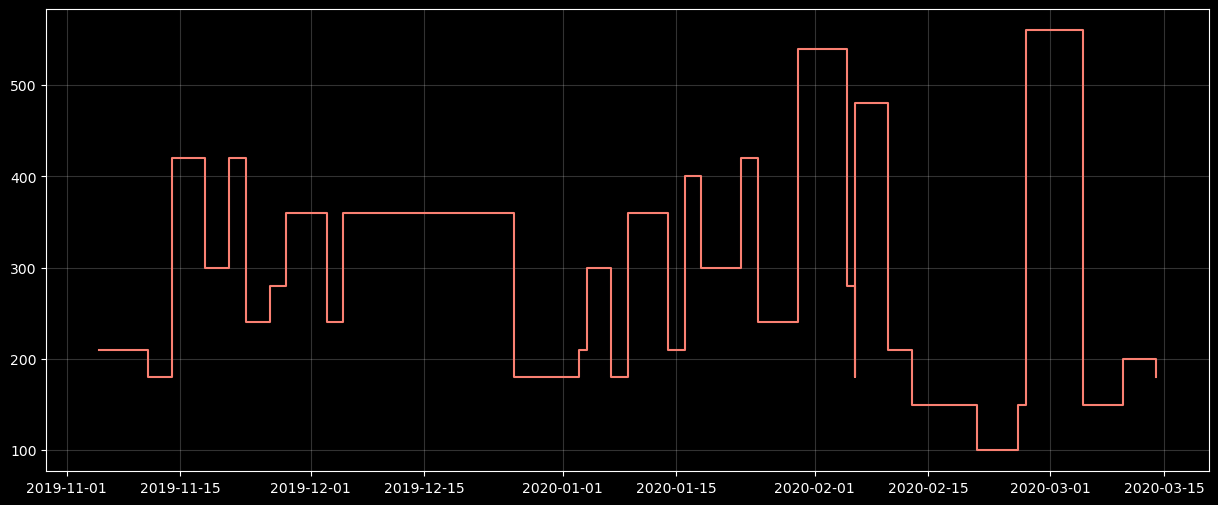

In [334]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.step(srpe_cleaned['date'], srpe_cleaned['srpe'], 
        color='salmon', where='post')
ax.grid(alpha=0.2)

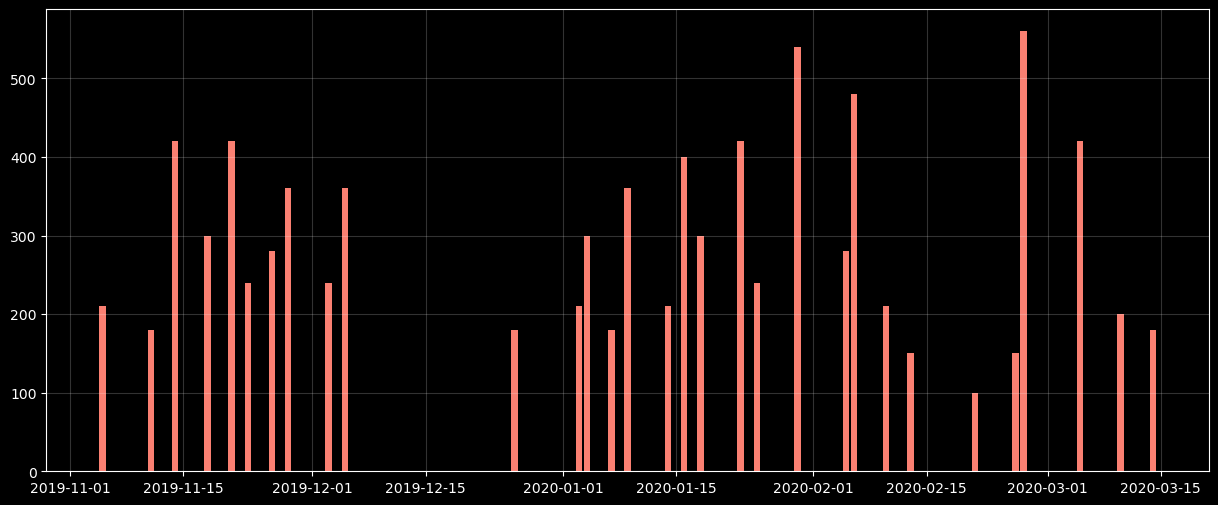

In [335]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(srpe_cleaned['date'], srpe_cleaned['srpe'], color='salmon')
ax.grid(alpha=0.2)

In [336]:
## The activities could be mainly grouped into team pr individual.
## In this player, there's only one activity of endurance,
## but there could be more in other players. 
## We'll stick to `type_of_activity` for now.

srpe_by_type = (srpe_cleaned.drop('date', axis=1)
     .groupby(['type_of_activity', 'activity_name']).describe())
srpe_by_type.columns = srpe_by_type.columns.droplevel(0)
srpe_by_type = srpe_by_type.reset_index()
srpe_by_type

type_of_activity activity_name  count        mean        std    min    25%  \
0       Individual     Endurance    1.0  300.000000        NaN  300.0  300.0   
1       Individual       Running   22.0  203.181818  56.601057  100.0  180.0   
2             Team        Soccer   11.0  430.909091  68.913648  360.0  380.0   

     50%    75%    max  
0  300.0  300.0  300.0  
1  205.0  240.0  300.0  
2  420.0  450.0  560.0

Text(0.5, 1.0, 'Boxplot by Activity')

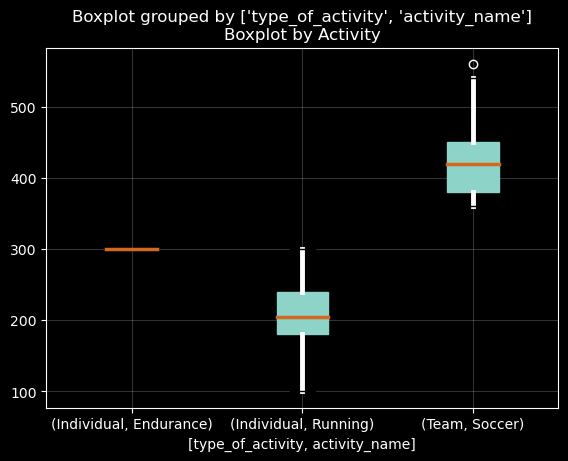

In [337]:
ax = srpe_cleaned.drop('date', axis=1).boxplot(
    column='srpe', by=['type_of_activity', 'activity_name'],
    patch_artist=True, medianprops=dict(
        linestyle='-', linewidth=2.5, color='chocolate'),
        whiskerprops=dict(linewidth=3.5))
ax.grid(alpha=0.2)
ax.set_title('Boxplot by Activity')

# ax.boxplot(srpe_cleaned.drop('date', axis=1), by=['type_of_activity'])

In [338]:
# fig, ax = plt.figure(figsize=(12, 6))

# ax.boxplot(srpe_by_type[srpe_by_type.columns[1:]],

##### **Whole: `pXX`**

In [339]:
df_srpe = pd.DataFrame()

for pXX in id_players:

    srpe_pXX = pd.read_csv(f"{pXX}/pmsys/srpe.csv")
    srpe_pXX['pXX'] = pXX
    df_srpe = pd.concat([df_srpe, srpe_pXX])
    
df_srpe

end_date_time               activity_names  perceived_exertion  \
0   2019-11-05T22:51:54.710Z    ['individual', 'running']                 7.0   
1   2019-11-11T21:15:15.092Z    ['individual', 'running']                 6.0   
2   2019-11-14T21:00:53.000Z           ['team', 'soccer']                 7.0   
3   2019-11-18T21:34:44.995Z  ['individual', 'endurance']                 6.0   
4   2019-11-21T21:06:25.146Z           ['team', 'soccer']                 6.0   
..                       ...                          ...                 ...   
6   2020-01-20T15:42:00.634Z                           {}                 NaN   
7   2020-01-28T20:53:03.947Z                           {}                 NaN   
8   2020-02-04T21:43:29.297Z                           {}                 NaN   
9   2020-02-10T15:29:39.385Z                           {}                 NaN   
10  2020-02-17T16:31:30.705Z                           {}                 NaN   

    duration_min  pXX  
0           30.0  p01  
1           30.0  p01  
2           60.0  p01  
3           50.0  p01  
4           70.0  p01  
..           ...  ...  
6            NaN  p16  
7            NaN  p16  
8            NaN  p16  
9            NaN  p16  
10           NaN  p16  

[783 rows x 5 columns]

In [340]:
## No data on p16. The player may not have a chance to input data here.
df_srpe.loc[df_srpe['pXX'] == 'p16']

end_date_time activity_names  perceived_exertion  duration_min  \
0   2019-11-18T13:34:02.327Z             {}                 NaN           NaN   
1   2019-11-25T14:25:04.577Z             {}                 NaN           NaN   
2   2019-12-09T12:32:35.414Z             {}                 NaN           NaN   
3   2019-12-23T16:12:08.718Z             {}                 NaN           NaN   
4   2019-12-30T10:29:31.987Z             {}                 NaN           NaN   
5   2020-01-13T15:37:07.243Z             {}                 NaN           NaN   
6   2020-01-20T15:42:00.634Z             {}                 NaN           NaN   
7   2020-01-28T20:53:03.947Z             {}                 NaN           NaN   
8   2020-02-04T21:43:29.297Z             {}                 NaN           NaN   
9   2020-02-10T15:29:39.385Z             {}                 NaN           NaN   
10  2020-02-17T16:31:30.705Z             {}                 NaN           NaN   

    pXX  
0   p16  
1   p16  
2   p16  
3   p16  
4   p16  
5   p16  
6   p16  
7   p16  
8   p16  
9   p16  
10  p16

In [341]:
df_srpe['activity_names'].value_counts().reset_index()

activity_names  count
0                            ['individual', 'running']    349
1                          ['individual', 'endurance']    195
2                           ['individual', 'strength']    119
3               ['individual', 'endurance', 'running']     22
4                ['individual', 'strength', 'running']     19
5              ['individual', 'strength', 'endurance']     19
6                                ['team', 'endurance']     15
7                                   ['team', 'soccer']     12
8                                                   {}     11
9                                  ['team', 'running']      8
10                                ['team', 'strength']      7
11  ['individual', 'strength', 'endurance', 'running']      4
12                   ['team', 'strength', 'endurance']      2
13                                      ['individual']      1

In [342]:
df_srpe['activity_names'].value_counts().reset_index()['activity_names'].to_list()# .apply(lambda x: x.to_list())

["['individual', 'running']",
 "['individual', 'endurance']",
 "['individual', 'strength']",
 "['individual', 'endurance', 'running']",
 "['individual', 'strength', 'running']",
 "['individual', 'strength', 'endurance']",
 "['team', 'endurance']",
 "['team', 'soccer']",
 ' {}',
 "['team', 'running']",
 "['team', 'strength']",
 "['individual', 'strength', 'endurance', 'running']",
 "['team', 'strength', 'endurance']",
 "['individual']"]

In [343]:
## CHECKPOINT 13/12/2024

In [344]:
activity = pd.DataFrame(df_srpe['activity_names']
    .str.split(', ', n=1, expand=True)
        .replace("'|\[|\]| {}", "", regex=True))
activity.columns = ['type_of_activity', 'activity_name']

for col in activity.columns:
    activity[col] = activity[col].str.title()
    
# activity.loc[activity['type_of_activity'] == ' {}']
activity

type_of_activity activity_name
0        Individual       Running
1        Individual       Running
2              Team        Soccer
3        Individual     Endurance
4              Team        Soccer
..              ...           ...
6                            None
7                            None
8                            None
9                            None
10                           None

[783 rows x 2 columns]

In [345]:
def clean_data_srpe():

    df_srpe = pd.DataFrame()

    for pXX in id_players:

        srpe_pXX = pd.read_csv(f"{pXX}/pmsys/srpe.csv")
        srpe_pXX['pXX'] = pXX
        df_srpe = pd.concat([df_srpe, srpe_pXX])

    df_srpe['date'] = pd.to_datetime(df_srpe['end_date_time']).dt.date
    df_srpe['srpe'] = df_srpe['perceived_exertion'] * df_srpe['duration_min']

    activity = pd.DataFrame(df_srpe['activity_names']
        .str.split(', ', n=1, expand=True)
            .replace("'|\[|\]| {}", "", regex=True))
    activity.columns = ['type_of_activity', 'activity_name']

    for col in activity.columns:
        activity[col] = activity[col].str.title()

    df_srpe = pd.concat([df_srpe, activity], axis=1)

    return df_srpe

In [346]:
df_srpe = clean_data_srpe()

In [347]:
df_srpe

end_date_time               activity_names  perceived_exertion  \
0   2019-11-05T22:51:54.710Z    ['individual', 'running']                 7.0   
1   2019-11-11T21:15:15.092Z    ['individual', 'running']                 6.0   
2   2019-11-14T21:00:53.000Z           ['team', 'soccer']                 7.0   
3   2019-11-18T21:34:44.995Z  ['individual', 'endurance']                 6.0   
4   2019-11-21T21:06:25.146Z           ['team', 'soccer']                 6.0   
..                       ...                          ...                 ...   
6   2020-01-20T15:42:00.634Z                           {}                 NaN   
7   2020-01-28T20:53:03.947Z                           {}                 NaN   
8   2020-02-04T21:43:29.297Z                           {}                 NaN   
9   2020-02-10T15:29:39.385Z                           {}                 NaN   
10  2020-02-17T16:31:30.705Z                           {}                 NaN   

    duration_min  pXX        date   srpe type_of_activity activity_name  
0           30.0  p01  2019-11-05  210.0       Individual       Running  
1           30.0  p01  2019-11-11  180.0       Individual       Running  
2           60.0  p01  2019-11-14  420.0             Team        Soccer  
3           50.0  p01  2019-11-18  300.0       Individual     Endurance  
4           70.0  p01  2019-11-21  420.0             Team        Soccer  
..           ...  ...         ...    ...              ...           ...  
6            NaN  p16  2020-01-20    NaN                           None  
7            NaN  p16  2020-01-28    NaN                           None  
8            NaN  p16  2020-02-04    NaN                           None  
9            NaN  p16  2020-02-10    NaN                           None  
10           NaN  p16  2020-02-17    NaN                           None  

[783 rows x 9 columns]

In [348]:
df_srpe.loc[
    df_srpe['pXX'] == 'p02', df_srpe.columns[-4:]]

date   srpe type_of_activity activity_name
0   2019-11-03  700.0       Individual      Strength
1   2019-11-03  540.0       Individual       Running
2   2019-11-06  490.0       Individual       Running
3   2019-11-08  240.0       Individual      Strength
4   2019-11-08  420.0       Individual       Running
..         ...    ...              ...           ...
92  2020-03-22  200.0       Individual      Strength
93  2020-03-23  720.0       Individual     Endurance
94  2020-03-26  160.0       Individual      Strength
95  2020-03-27  240.0       Individual       Running
96  2020-03-28  240.0       Individual      Strength

[97 rows x 4 columns]

In [349]:
## p16 has no data. We'll put notice in the data-viz function.

def boxplot_srpe_per_player(player):
    
    if player == 'p16':
        print('p16 has no data of SRPE.')
    
    else:
        df_srpe_cleaned_pXX = df_srpe.loc[
            df_srpe['pXX'] == player, df_srpe.columns[-4:]]
                
        ax = df_srpe_cleaned_pXX.drop('date', axis=1).boxplot(
            column='srpe', by=['type_of_activity', 'activity_name'],
            patch_artist=True, medianprops=dict(
                linestyle='-', linewidth=2.5, color='chocolate'),
                whiskerprops=dict(linewidth=3.5))
        
        # type_act_color = {'Individual': '#1f77b4', 'Team': '#ff7f0e'}
        
        # for patch, label in zip(ax.artists, ax.get_xticklabels()):
        #     activity_type = label.get_text().split(',')[0].strip("()'")
        #     patch.set_facecolor(type_act_color.get(activity_type, 
        #         type_act_color[activity_type]))
        
        ax.grid(alpha=0.2)
        ax.set_xticklabels(ax.get_xticklabels(),
            rotation=60, ha='right')

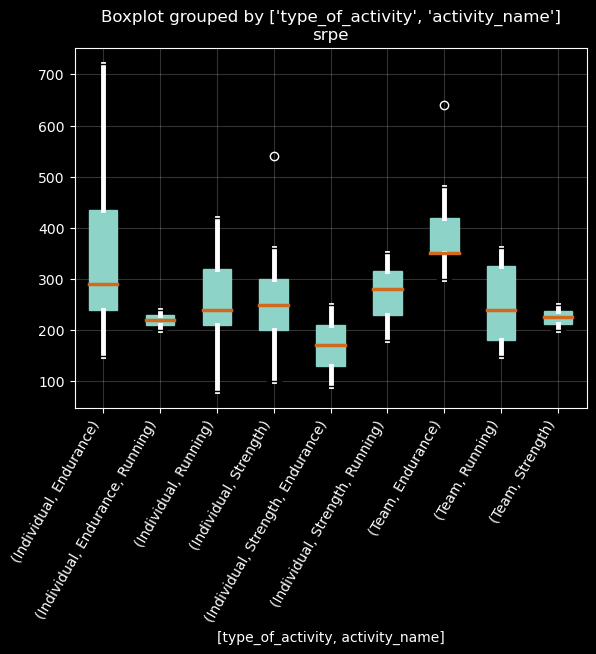

In [350]:
boxplot_srpe_per_player('p04')

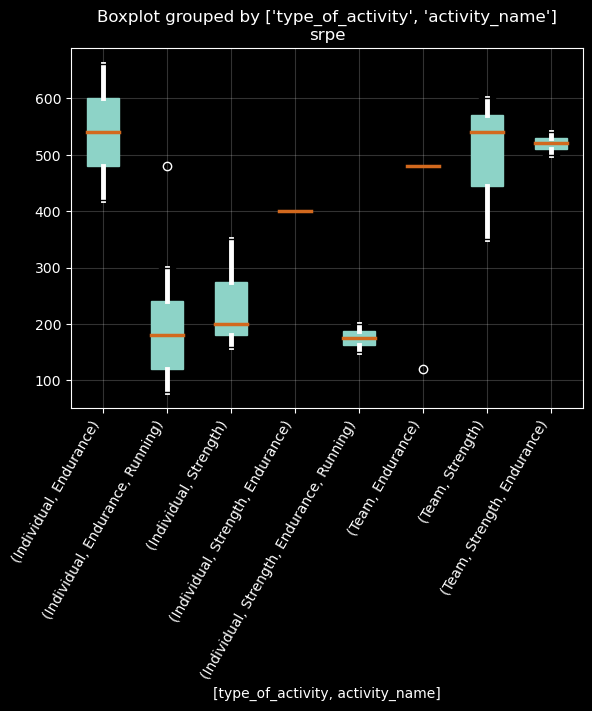

In [351]:
boxplot_srpe_per_player('p11')

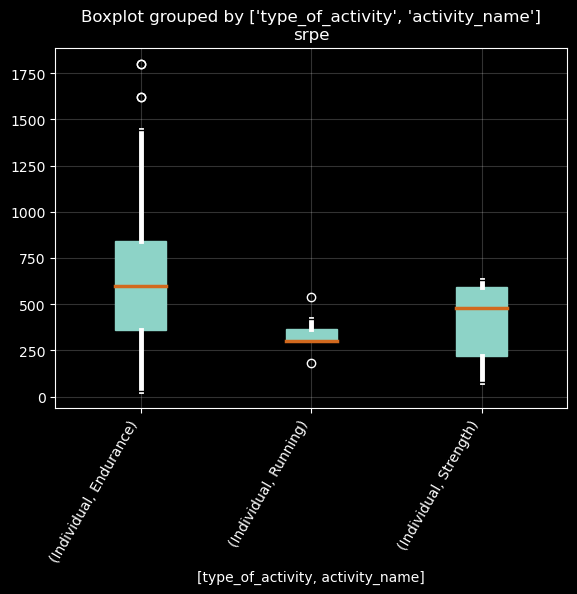

In [352]:
boxplot_srpe_per_player('p15')

### `wellness`

In [353]:
wellness = pd.read_csv("p01/pmsys/wellness.csv")

In [354]:
wellness

effective_time_frame  fatigue  mood  readiness  sleep_duration_h  \
0    2019-11-01T08:31:40.751Z        2     3          5                 6   
1    2019-11-02T10:00:01.229Z        2     3          6                 6   
2    2019-11-03T14:28:03.263Z        3     3          8                 6   
3    2019-11-04T07:05:28.429Z        3     3          8                 6   
4    2019-11-05T06:13:35.998Z        3     3          8                 5   
..                        ...      ...   ...        ...               ...   
133  2020-03-25T11:25:45.031Z        3     3          8                 5   
134  2020-03-27T21:44:34.942Z        2     2          6                 5   
135  2020-03-28T12:07:09.493Z        3     3          8                 6   
136  2020-03-29T08:02:16.282Z        3     3          8                 5   
137  2020-03-30T07:24:02.816Z        3     3          8                 6   

     sleep_quality  soreness soreness_area  stress  
0                3         2    [12921003]       3  
1                3         2    [12921003]       3  
2                3         3            []       3  
3                3         3            []       3  
4                3         3            []       3  
..             ...       ...           ...     ...  
133              2         3            []       3  
134              2         3            []       2  
135              3         3            []       3  
136              3         3            []       3  
137              3         3            []       3  

[138 rows x 9 columns]

In [355]:
wellness.value_counts('soreness_area')

## One thing to deal with this: Web scraping into the
## lookout SNOMED-CT website, if they allow it.

soreness_area
[]                                            78
[12921003]                                    23
[48979004, 32696007, 12921003]                23
[48979004, 32696007]                           9
[48979004, 32696007, 12921003, 22943007]       2
[12921003, 22943007, 368208006, 368209003]     1
[48979004, 12921003]                           1
[48979004]                                     1
Name: count, dtype: int64

The soreness area are in numbers and it's associated with [SNOMED CT-US](https://lookup.snomedtools.org/). The author would love to explore further by transforming the data. 

In fact we can transform it to the body part with a little help from a library in Python called [`Owlready2`](https://owlready2.readthedocs.io/en/latest/pymedtermino2.html#installation), particularly `PyMedTermino2`. 

However to do that we need to download the terminologies of [Unified Medical Language System (UMLS)](https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html), complete with the descriptions, attributes, parents, and direct children. This needs log-in for credentials and also would not be feasible for author's space capacity (~5.0 GB). 

Therefore the author would put this out of scope for the project.

In [356]:
wellness.columns[:-1]

Index(['effective_time_frame', 'fatigue', 'mood', 'readiness',
       'sleep_duration_h', 'sleep_quality', 'soreness', 'soreness_area'],
      dtype='object')

In [357]:
wellness['date'] = pd.to_datetime(
    wellness['effective_time_frame']).dt.floor('d')

# We'll visualize only subjective scores
wellness_cleaned = wellness.drop(['effective_time_frame', 
    'sleep_duration_h', 'soreness_area'], axis=1)
new_cols = ['date'] + wellness_cleaned.columns[:-1].to_list()
wellness_cleaned = wellness_cleaned[new_cols]

## Normalize scores--All subjective scores are within scale of 1-5,
##    with only readiness have scale of 1-10. 
wellness_cleaned['readiness'] /= 2

In [358]:
wellness_cleaned.head()

date  fatigue  mood  readiness  sleep_quality  \
0 2019-11-01 00:00:00+00:00        2     3        2.5              3   
1 2019-11-02 00:00:00+00:00        2     3        3.0              3   
2 2019-11-03 00:00:00+00:00        3     3        4.0              3   
3 2019-11-04 00:00:00+00:00        3     3        4.0              3   
4 2019-11-05 00:00:00+00:00        3     3        4.0              3   

   soreness  stress  
0         2       3  
1         2       3  
2         3       3  
3         3       3  
4         3       3

In [359]:
wellness_cleaned.dtypes

date             datetime64[ns, UTC]
fatigue                        int64
mood                           int64
readiness                    float64
sleep_quality                  int64
soreness                       int64
stress                         int64
dtype: object

In [360]:
# The data starts on Friday. To include the whole week,
# Data are grouped weekly starting on Thursday. So 'W-THU'

wellness_per_week = wellness_cleaned.groupby([pd.Grouper
        (key='date', freq='W-Thu')]).agg(['mean', 'std'])

wellness_per_week.columns = wellness_per_week.columns.map('_'.join)
# wellness_per_week = wellness_per_week.reset_index()
wellness_per_week

fatigue_mean  fatigue_std  mood_mean  mood_std  \
date                                                                        
2019-11-07 00:00:00+00:00      2.714286     0.487950   3.000000  0.000000   
2019-11-14 00:00:00+00:00      2.833333     0.408248   2.833333  0.408248   
2019-11-21 00:00:00+00:00      2.285714     0.487950   3.142857  0.377964   
2019-11-28 00:00:00+00:00      2.571429     0.534522   3.000000  0.000000   
2019-12-05 00:00:00+00:00      2.428571     0.534522   3.000000  0.000000   
2019-12-12 00:00:00+00:00      2.200000     0.447214   3.000000  0.000000   
2019-12-19 00:00:00+00:00      2.800000     0.836660   3.000000  0.000000   
2019-12-26 00:00:00+00:00      3.000000     0.000000   3.000000  0.000000   
2020-01-02 00:00:00+00:00      2.333333     0.516398   3.000000  0.000000   
2020-01-09 00:00:00+00:00      2.166667     0.408248   2.333333  0.816497   
2020-01-16 00:00:00+00:00      2.714286     0.487950   3.000000  0.000000   
2020-01-23 00:00:00+00:00      2.714286     0.487950   3.000000  0.000000   
2020-01-30 00:00:00+00:00      2.500000     0.547723   3.000000  0.000000   
2020-02-06 00:00:00+00:00      2.428571     0.786796   3.142857  0.377964   
2020-02-13 00:00:00+00:00      2.428571     0.534522   3.000000  0.000000   
2020-02-20 00:00:00+00:00      2.500000     0.836660   3.000000  0.000000   
2020-02-27 00:00:00+00:00      2.571429     0.534522   3.000000  0.000000   
2020-03-05 00:00:00+00:00      2.714286     0.487950   3.000000  0.000000   
2020-03-12 00:00:00+00:00      2.833333     0.408248   3.000000  0.000000   
2020-03-19 00:00:00+00:00      2.428571     0.534522   3.000000  0.000000   
2020-03-26 00:00:00+00:00      2.666667     0.516398   2.833333  0.408248   
2020-04-02 00:00:00+00:00      2.750000     0.500000   2.750000  0.500000   

                           readiness_mean  readiness_std  sleep_quality_mean  \
date                                                                           
2019-11-07 00:00:00+00:00        3.357143       0.690066            3.000000   
2019-11-14 00:00:00+00:00        3.333333       0.683130            3.000000   
2019-11-21 00:00:00+00:00        3.142857       0.556349            2.714286   
2019-11-28 00:00:00+00:00        3.142857       0.690066            2.714286   
2019-12-05 00:00:00+00:00        3.071429       0.672593            2.428571   
2019-12-12 00:00:00+00:00        2.300000       0.670820            2.600000   
2019-12-19 00:00:00+00:00        3.300000       0.273861            2.800000   
2019-12-26 00:00:00+00:00        3.600000       0.223607            3.000000   
2020-01-02 00:00:00+00:00        2.916667       0.584523            2.666667   
2020-01-09 00:00:00+00:00        3.000000       0.447214            2.166667   
2020-01-16 00:00:00+00:00        2.785714       0.566947            2.714286   
2020-01-23 00:00:00+00:00        2.928571       0.534522            3.000000   
2020-01-30 00:00:00+00:00        3.000000       0.836660            2.833333   
2020-02-06 00:00:00+00:00        3.000000       0.816497            2.714286   
2020-02-13 00:00:00+00:00        3.071429       0.838082            2.571429   
2020-02-20 00:00:00+00:00        2.750000       0.935414            2.833333   
2020-02-27 00:00:00+00:00        3.285714       0.566947            3.000000   
2020-03-05 00:00:00+00:00        2.714286       0.951190            2.714286   
2020-03-12 00:00:00+00:00        3.083333       1.068488            2.666667   
2020-03-19 00:00:00+00:00        3.357143       0.690066            2.428571   
2020-03-26 00:00:00+00:00        3.833333       0.258199            2.666667   
2020-04-02 00:00:00+00:00        3.750000       0.500000            2.750000   

                           sleep_quality_std  soreness_mean  soreness_std  \
date                                                                        
2019-11-07 00:00:00+00:00           0.000000       2.571429      0.534522   
2019-11-14 00:00:00+00:00 

In [361]:
data_mean_cols = wellness_per_week.columns[
    wellness_per_week.columns.str.endswith('_mean')]
data_std_cols  = wellness_per_week.columns[
    wellness_per_week.columns.str.endswith('_std')]

def radar_chart_per_week(week_n):
    
    # Normalize ranges in each line, some are different
    ranges = [
        [0, 5], [0, 5], [0, 10],
        [0, 5], [0, 5], [0, 5]
    ]
    
    # Extract row of data per week
    data_mean = np.array(
        wellness_per_week[data_mean_cols].iloc[week_n-1])
    data_std  = np.array(
        wellness_per_week[data_std_cols].iloc[week_n-1])
        
    label_loc = np.linspace(start=0, stop=2*np.pi,
        num=data_mean_cols.shape[0] + 1)
    #wellness_per_week[data_mean_cols].shape[1] + 1)
    
    viz_labels = (data_mean_cols.str.replace('_mean', '')
        .str.replace('_', ' ').str.title())
    
    date_end   = str(wellness_per_week.index[week_n-1].date())
    date_start = str((wellness_per_week.index[week_n-1] - 
                      pd.Timedelta(days=6)).date())
    
    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    plt.plot(label_loc, np.r_[data_mean, data_mean[0]], 
        label=f'Week {week_n}', linewidth=4)
    plt.fill(label_loc, np.r_[(data_mean + data_std),
        (data_mean[0] + data_std[0])], facecolor='paleturquoise', alpha=0.15)
    plt.fill(label_loc, np.r_[(data_mean - data_std),
        (data_mean[0] - data_std[0])], facecolor='black')
    plt.title(f'''Wellness Score p01, Week {week_n} -- {date_start} to {date_end}''', size=20, y=1.05)
    lines, labels = plt.thetagrids(
        np.degrees(label_loc[:-1]), labels=viz_labels)
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

In [362]:
str(wellness_per_week.index[10].date() - pd.Timedelta(days=7))

'2020-01-09'

In [363]:
pd.DataFrame(wellness_per_week[data_mean_cols].iloc[0]).T

fatigue_mean  mood_mean  readiness_mean  \
2019-11-07 00:00:00+00:00      2.714286        3.0        3.357143   

                           sleep_quality_mean  soreness_mean  stress_mean  
2019-11-07 00:00:00+00:00                 3.0       2.571429          3.0

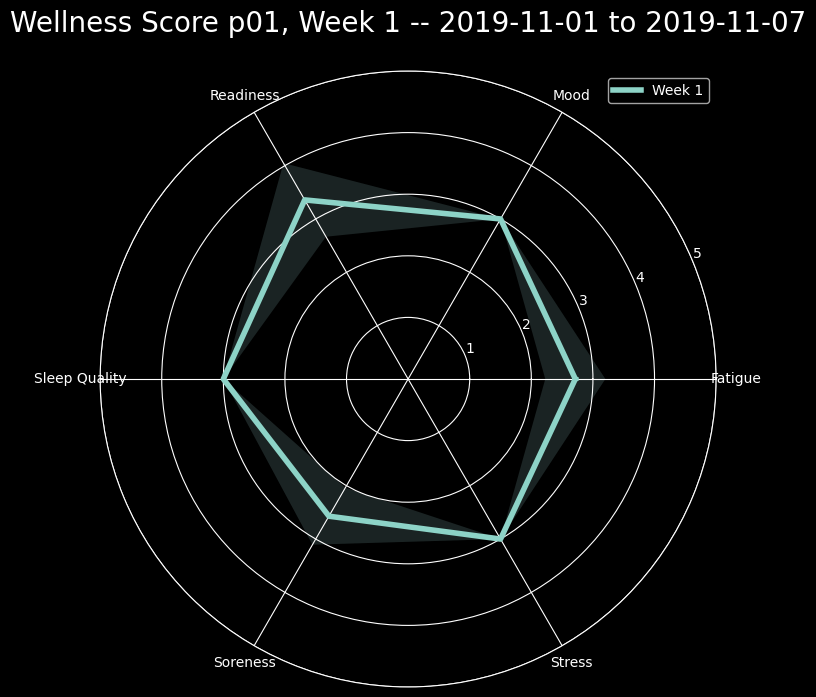

In [364]:
radar_chart_per_week(1)

#### Whole: `pXX`

In [365]:
df_wellness = pd.DataFrame()

for pXX in id_players:
    
    wellness_pXX = pd.read_csv(f"{pXX}/pmsys/wellness.csv")
    wellness_pXX['pXX'] = pXX
    df_wellness = pd.concat([df_wellness, wellness_pXX])

df_wellness

effective_time_frame  fatigue  mood  readiness  sleep_duration_h  \
0   2019-11-01T08:31:40.751Z        2     3          5                 6   
1   2019-11-02T10:00:01.229Z        2     3          6                 6   
2   2019-11-03T14:28:03.263Z        3     3          8                 6   
3   2019-11-04T07:05:28.429Z        3     3          8                 6   
4   2019-11-05T06:13:35.998Z        3     3          8                 5   
..                       ...      ...   ...        ...               ...   
77  2020-03-08T11:44:44.398Z        3     3          4                 6   
78  2020-03-11T11:33:15.168Z        2     3          4                 6   
79  2020-03-15T08:33:15.985Z        4     4          4                10   
80  2020-03-17T09:54:27.989Z        2     3          4                 5   
81  2020-03-18T09:47:19.341Z        3     4          4                 8   

    sleep_quality  soreness soreness_area  stress  pXX  
0               3         2    [12921003]       3  p01  
1               3         2    [12921003]       3  p01  
2               3         3            []       3  p01  
3               3         3            []       3  p01  
4               3         3            []       3  p01  
..            ...       ...           ...     ...  ...  
77              2         3            []       3  p16  
78              2         3            []       2  p16  
79              4         4            []       4  p16  
80              3         3            []       3  p16  
81              4         3            []       4  p16  

[1747 rows x 10 columns]

In [366]:
df_wellness['date'] = pd.to_datetime(
    df_wellness['effective_time_frame']).dt.floor('d')

df_wellness

effective_time_frame  fatigue  mood  readiness  sleep_duration_h  \
0   2019-11-01T08:31:40.751Z        2     3          5                 6   
1   2019-11-02T10:00:01.229Z        2     3          6                 6   
2   2019-11-03T14:28:03.263Z        3     3          8                 6   
3   2019-11-04T07:05:28.429Z        3     3          8                 6   
4   2019-11-05T06:13:35.998Z        3     3          8                 5   
..                       ...      ...   ...        ...               ...   
77  2020-03-08T11:44:44.398Z        3     3          4                 6   
78  2020-03-11T11:33:15.168Z        2     3          4                 6   
79  2020-03-15T08:33:15.985Z        4     4          4                10   
80  2020-03-17T09:54:27.989Z        2     3          4                 5   
81  2020-03-18T09:47:19.341Z        3     4          4                 8   

    sleep_quality  soreness soreness_area  stress  pXX  \
0               3         2    [12921003]       3  p01   
1               3         2    [12921003]       3  p01   
2               3         3            []       3  p01   
3               3         3            []       3  p01   
4               3         3            []       3  p01   
..            ...       ...           ...     ...  ...   
77              2         3            []       3  p16   
78              2         3            []       2  p16   
79              4         4            []       4  p16   
80              3         3            []       3  p16   
81              4         3            []       4  p16   

                        date  
0  2019-11-01 00:00:00+00:00  
1  2019-11-02 00:00:00+00:00  
2  2019-11-03 00:00:00+00:00  
3  2019-11-04 00:00:00+00:00  
4  2019-11-05 00:00:00+00:00  
..                       ...  
77 2020-03-08 00:00:00+00:00  
78 2020-03-11 00:00:00+00:00  
79 2020-03-15 00:00:00+00:00  
80 2020-03-17 00:00:00+00:00  
81 2020-03-18 00:00:00+00:00  

[1747 rows x 11 columns]

In [367]:
# We'll visualize only subjective scores
df_wellness_cleaned = df_wellness.drop(['effective_time_frame', 
    'sleep_duration_h', 'soreness_area'], axis=1)
new_cols = ['date', 'pXX'] + df_wellness_cleaned.columns[:-2].to_list()
df_wellness_cleaned = df_wellness_cleaned[new_cols]

## Normalize scores--All subjective scores are within scale of 1-5,
##    with only `readiness` have a scale of 1-10. 
df_wellness_cleaned['readiness'] /= 2

df_wellness_cleaned

date  pXX  fatigue  mood  readiness  sleep_quality  \
0  2019-11-01 00:00:00+00:00  p01        2     3        2.5              3   
1  2019-11-02 00:00:00+00:00  p01        2     3        3.0              3   
2  2019-11-03 00:00:00+00:00  p01        3     3        4.0              3   
3  2019-11-04 00:00:00+00:00  p01        3     3        4.0              3   
4  2019-11-05 00:00:00+00:00  p01        3     3        4.0              3   
..                       ...  ...      ...   ...        ...            ...   
77 2020-03-08 00:00:00+00:00  p16        3     3        2.0              2   
78 2020-03-11 00:00:00+00:00  p16        2     3        2.0              2   
79 2020-03-15 00:00:00+00:00  p16        4     4        2.0              4   
80 2020-03-17 00:00:00+00:00  p16        2     3        2.0              3   
81 2020-03-18 00:00:00+00:00  p16        3     4        2.0              4   

    soreness  stress  
0          2       3  
1          2       3  
2          3       3  
3          3       3  
4          3       3  
..       ...     ...  
77         3       3  
78         3       2  
79         4       4  
80         3       3  
81         3       4  

[1747 rows x 8 columns]

In [368]:
def clean_data_wellness():

    df_wellness = pd.DataFrame()

    for pXX in id_players:

        wellness_pXX = pd.read_csv(f"{pXX}/pmsys/wellness.csv")
        wellness_pXX['pXX'] = pXX
        df_wellness = pd.concat([df_wellness, wellness_pXX])

    df_wellness    

    df_wellness['date'] = pd.to_datetime(
        df_wellness['effective_time_frame']).dt.floor('d')

    # We'll visualize only subjective scores
    df_wellness_cleaned = df_wellness.drop(['effective_time_frame', 
        'sleep_duration_h', 'soreness_area'], axis=1)
    new_cols = ['date', 'pXX'] + df_wellness_cleaned.columns[:-2].to_list()
    df_wellness_cleaned = df_wellness_cleaned[new_cols]

    ## Normalize scores--All subjective scores are within scale of 1-5,
    ##    with only `readiness` have a scale of 1-10. 
    df_wellness_cleaned['readiness'] /= 2

    # The data starts on Friday. To include the whole week,
    # Data are grouped weekly starting on Thursday. So 'W-THU'

    df_wellness_per_week = df_wellness_cleaned.copy()

    df_wellness_per_week['date'] = (
        df_wellness_per_week['date']
            .dt.to_period("W-THU").dt.end_time.dt.date)

    df_wellness_per_week = df_wellness_per_week.groupby(
            ['pXX', 'date']).agg(['mean', 'std'])

    df_wellness_per_week.columns = df_wellness_per_week.columns.map('_'.join)
    # wellness_per_week = wellness_per_week.reset_index()
    df_wellness_per_week = df_wellness_per_week.reset_index()
    return df_wellness_per_week

In [369]:
df_wellness_per_week = clean_data_wellness()
df_wellness_per_week

C:\Users\acer\AppData\Local\Temp\ipykernel_6896\3023542386.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period("W-THU").dt.end_time.dt.date)


pXX        date  fatigue_mean  fatigue_std  mood_mean  mood_std  \
0    p01  2019-11-07      2.714286     0.487950   3.000000  0.000000   
1    p01  2019-11-14      2.833333     0.408248   2.833333  0.408248   
2    p01  2019-11-21      2.285714     0.487950   3.142857  0.377964   
3    p01  2019-11-28      2.571429     0.534522   3.000000  0.000000   
4    p01  2019-12-05      2.428571     0.534522   3.000000  0.000000   
..   ...         ...           ...          ...        ...       ...   
320  p16  2020-02-20      2.000000     0.816497   3.000000  0.816497   
321  p16  2020-02-27      2.000000     0.000000   3.000000  0.000000   
322  p16  2020-03-05      3.000000     0.000000   3.000000  0.000000   
323  p16  2020-03-12      2.666667     0.577350   3.000000  0.000000   
324  p16  2020-03-19      3.000000     1.000000   3.666667  0.577350   

     readiness_mean  readiness_std  sleep_quality_mean  sleep_quality_std  \
0          3.357143       0.690066            3.000000           0.000000   
1          3.333333       0.683130            3.000000           0.000000   
2          3.142857       0.556349            2.714286           0.755929   
3          3.142857       0.690066            2.714286           0.487950   
4          3.071429       0.672593            2.428571           0.534522   
..              ...            ...                 ...                ...   
320        1.875000       0.478714            2.750000           0.957427   
321        1.750000       0.353553            2.500000           0.707107   
322        2.000000       0.000000            3.000000           0.000000   
323        2.000000       0.000000            2.000000           0.000000   
324        2.000000       0.000000            3.666667           0.577350   

     soreness_mean  soreness_std  stress_mean  stress_std  
0         2.571429      0.534522     3.000000    0.000000  
1         2.833333      0.408248     2.666667    0.516398  
2         2.285714      0.487950     2.714286    0.487950  
3         2.285714      0.487950     3.000000    0.000000  
4         2.714286      0.487950     3.000000    0.000000  
..             ...           ...          ...         ...  
320       3.000000      0.000000     2.500000    0.577350  
321       3.000000      0.000000     2.500000    0.707107  
322       3.000000      0.000000     3.000000    0.000000  
323       3.000000      0.000000     2.333333    0.577350  
324       3.333333      0.577350     3.666667    0.577350  

[325 rows x 14 columns]

In [370]:
data_mean_cols = df_wellness_per_week.columns[
    df_wellness_per_week.columns.str.endswith('_mean')]

data_mean = np.array(
    df_wellness_per_week[data_mean_cols].iloc[2])
data_mean

np.array(df_wellness_per_week.loc[
    df_wellness_per_week['pXX'] == 'p01', data_mean_cols].iloc[0])

array([2.71428571, 3.        , 3.35714286, 3.        , 2.57142857,
       3.        ])

In [371]:
data_mean_cols.shape[0]

6

In [372]:
df_data_mean_cols = df_wellness_per_week.columns[
    df_wellness_per_week.columns.str.endswith('_mean')]
df_data_std_cols  = df_wellness_per_week.columns[
    df_wellness_per_week.columns.str.endswith('_std')]

def radar_chart_wellness_per_player(player, week_n):
    
    # Normalize ranges in each line, some are different
    ranges = [
        [0, 5], [0, 5], [0, 10],
        [0, 5], [0, 5], [0, 5]
    ]
    
    wellness_pXX = df_wellness_per_week.loc[
        df_wellness_per_week['pXX'] == player]
    
    # Extract row of data per week
    df_data_mean = np.array(wellness_pXX[df_data_mean_cols].iloc[week_n-1])
    df_data_std  = np.array(wellness_pXX[df_data_std_cols].iloc[week_n-1])
        
    label_loc = np.linspace(start=0, stop=2*np.pi,
        num=df_data_mean_cols.shape[0] + 1)
    
    viz_labels = (df_data_mean_cols.str.replace('_mean', '')
        .str.replace('_', ' ').str.title())
    
    date_end   = str(wellness_pXX['date'].iloc[week_n-1])
    date_start = str((wellness_pXX['date'].iloc[week_n-1] - 
                      pd.Timedelta(days=6)))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    plt.plot(label_loc, np.r_[df_data_mean, df_data_mean[0]], 
        label=f'Week {week_n}', linewidth=4)
    plt.fill(label_loc, np.r_[(df_data_mean + df_data_std),
        (df_data_mean[0] + df_data_std[0])], facecolor='paleturquoise', alpha=0.15)
    plt.fill(label_loc, np.r_[(df_data_mean - df_data_std),
        (df_data_mean[0] - df_data_std[0])], facecolor='black')
    plt.title(f'''Wellness Score {player}, Week {week_n} -- {date_start} to {date_end}''', 
              size=20, y=1.05)
    lines, labels = plt.thetagrids(
        np.degrees(label_loc[:-1]), labels=viz_labels)
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

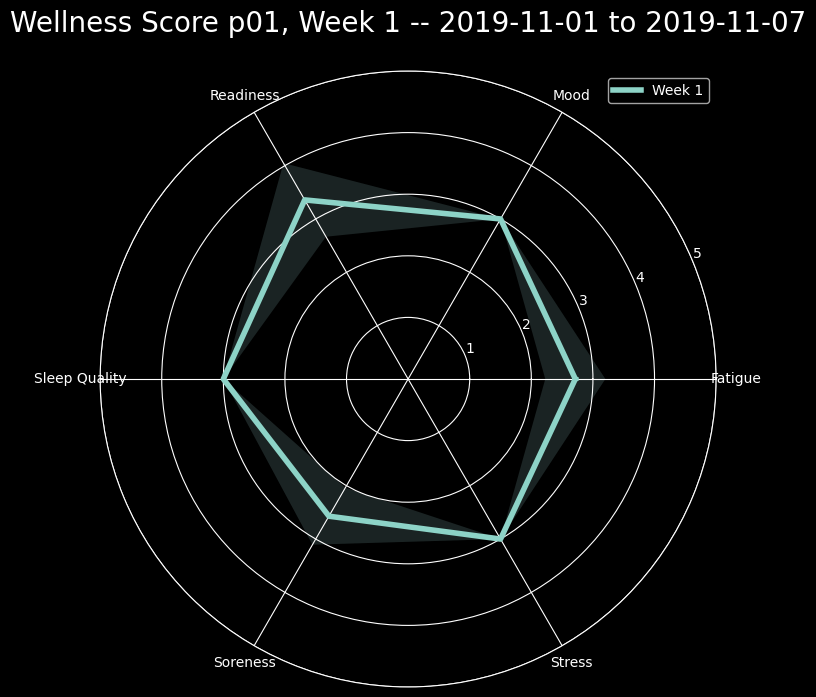

In [373]:
radar_chart_wellness_per_player('p01', week_n=1)

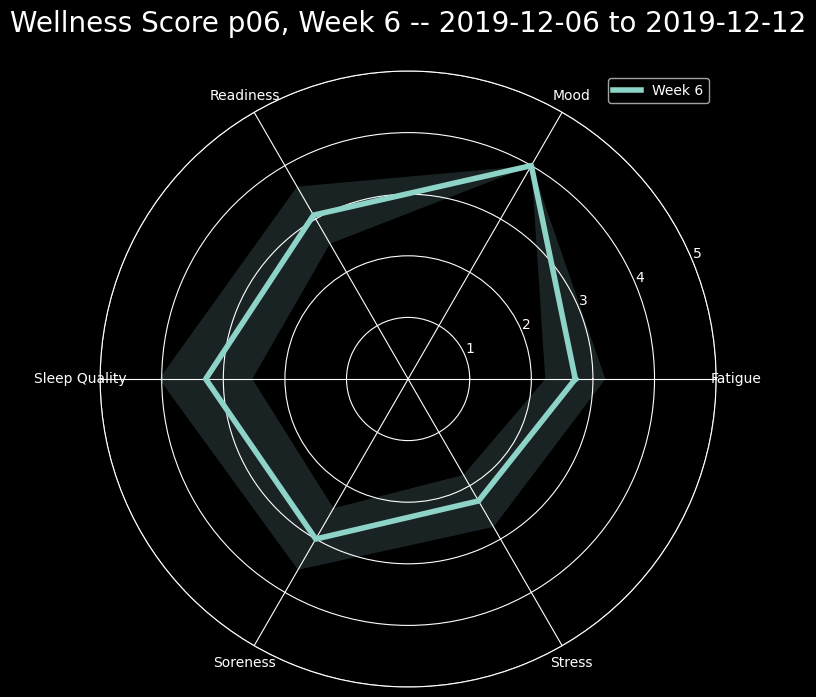

In [374]:
radar_chart_wellness_per_player('p06', week_n=6)

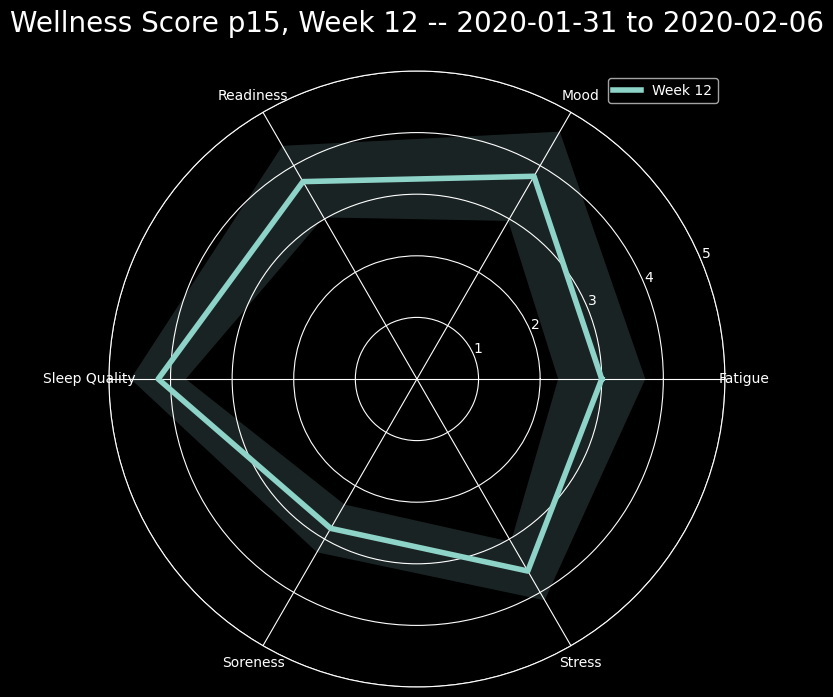

In [375]:
radar_chart_wellness_per_player('p15', week_n=12)

In [376]:
# # !pip install owlready2

# from owlready2 import *
# from owlready2.pymedtermino2 import *
# from owlready2.pymedtermino2.umls import *
# default_world.set_backend(filename = "pym.sqlite3")
# import_umls("umls-2019AA-metathesaurus.zip", terminologies = ["ICD10", "SNOMEDCT_US", "CUI"])
# default_world.save()

## All Visuals at One: Stats per Player

Let's try gathering all functions above to look for 

## Combining Data

In order to proceed into Power BI, we need to wrangle the data. Some challenges include combining data with different dimensions of datetime. We'll try 

In [377]:
# Clean

In [378]:
def calories_bar_chart_per_player(player):
    
    if player == 'all':
        sns.catplot(data=df_cals, x='pXX', y='calories', hue='yearmonth', 
        kind='bar', height=8.27, aspect=11.7/8.27) #._legend.remove()
        plt.grid(alpha=0.4)
    
    else:
        sns.catplot(data=df_cals.loc[df_cals['pXX'] == player], 
        x='pXX', y='calories', hue='yearmonth', kind='bar', 
        height=8.27, aspect=5.85/8.27)
        plt.grid(alpha=0.4)

In [379]:
# Clean

In [380]:
def distance_bar_chart_per_player(player):

    if player == 'all':
        sns.catplot(data=df_dists, x='pXX', y='distances', hue='yearmonth', 
        kind='bar', height=8.27, aspect=11.7/8.27) #._legend.remove()
        plt.grid(alpha=0.4)
    
    else:
        sns.catplot(data=df_dists.loc[df_dists['pXX'] == player], 
        x='pXX', y='distances', hue='yearmonth', kind='bar', 
        height=8.27, aspect=5.85/8.27)
        plt.grid(alpha=0.4)

In [381]:
# Clean

In [382]:
## Sequence colors from dataframe, mapped by Sports

# explode = (0, 0.1, 0.15)
sa_colors = {
    'Walk': '#32CD32', 
    'Run': '#FF4500', 
    'Treadmill': '#FFA500',
    'Outdoor Bike': '#1E90FF', 
    'Sport': '#FFD700',
    'Weights': '#8B4513', 
    'Workout': '#FF69B4', 
    'Aerobic Workout': '#EE82EE', 
    'Hike': '#228B22',
    'Bike': '#87CEEB',
    'Spinning': '#6A5ACD',
    'Elliptical': '#4682B4',
    'Cross Country Skiing': '#B0E0E6',
    'Swim': '#40E0D0',
    'Circuit Training': '#FFDAB9',
    'Interval Workout': '#FF6347',
    'Yoga': '#800080',
    'Hockey': '#A9A9A9',
    'Skiing': '#F0F8FF',
    'Tennis': '#FFFF00',
    'Dancing': '#FF1493'
}

sports_activities = pd.DataFrame()

def pie_chart_sport_activities(player='all'):

    fig, ax = plt.subplots(figsize=(12, 8))
    autopct = lambda v: f'{v:.2f}%' if v > 3 else None
    n_sports = 0
    
    if player == 'all':
        title = 'Sport Activities, the Whole Team'
        sports_activities = pd.DataFrame(df_exercises
            .value_counts(['activityName'])).reset_index()
        n_sports = sports_activities['activityName'].nunique()
    else:
        title = f'Sport Activities, Player {player}'
        sports_activities = pd.DataFrame(
            df_exercises.loc[df_exercises['pXX'] == player]
            .value_counts(['activityName'])).reset_index()
        n_sports = sports_activities['activityName'].nunique()

    ax.pie(sports_activities['count'], pctdistance=0.55,
        textprops={'fontsize': 16}, autopct=autopct, 
        startangle=-112.5, colors=[sa_colors[key] for key in 
           sports_activities['activityName']])
    ax.axis('equal')
    
    # legend_settings = (
    #     {loc: 'upper right'} if n_sports <= 3
    #     else {bbox_to_anchor: (0.825, 1.025)})
    
    ax.set_title(title, fontsize=20)
    ax.legend(sports_activities['activityName'], 
        bbox_to_anchor=(0.825, 1.025))#, loc='center right')

In [383]:
# Clean

In [384]:
def hrz_chart_per_player(player, startfromzone=0):
    
    ''' Options of 'startfromzone': 
           0: 'oor', 1: 'fb', 2: 'cardio', 3: 'peak' '''
    
    hrz_weekly_pXX = (df_hrz_in_mins[
        df_hrz_in_mins['pXX'] == player].groupby([pd.Grouper
        (key='dateTime', freq='W-Thu')]).agg('sum'))
    
    HR_zones_color_update = [
        '#FFFF7D', '#FF9D1C', '#FF6D1C', '#FE251B']
    
    fig, ax = plt.subplots(figsize=(12, 6))

    hrz_cols_to_drop = (['pXX'] + hrz_weekly_pXX.columns
                        .to_list()[:startfromzone+1])
    
    hrz_weekly_pXX.drop(hrz_cols_to_drop, axis=1).plot(
        kind='bar', stacked=True, width=0.8, ax=ax, 
        color=HR_zones_color_update[startfromzone:])
    ax.set_title('Heart Rate Zones Duration of p01 in 5 Months (updated per weel)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Duration (mins)')
    ax.grid(alpha=0.4)

**`active_mins`**

In [385]:
def clean_data_active_minutes_pXX():
    
    df_sms = pd.DataFrame()
    df_lams = pd.DataFrame()
    df_mams = pd.DataFrame()
    df_vams = pd.DataFrame()
    df_steps = pd.DataFrame()
    df_steps_per_day = pd.DataFrame()
    
    df_active_steps_pXX = pd.DataFrame()

    for pXX in id_players:

        try:
            sms_pXX = pd.read_json(f"{pXX}/fitbit/sedentary_minutes.json")
            sms_pXX = sms.rename(columns={'value': 'sedentary_minutes'})
            sms_pXX['pXX'] = pXX
            df_sms = pd.concat([df_sms, sms_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/sedentary_minutes.json -- Skipping...")

        try:
            lams_pXX = pd.read_json(f"{pXX}/fitbit/lightly_active_minutes.json")
            lams_pXX = lams_pXX.rename(columns={'value': 'lightly_active_minutes'})
            lams_pXX['pXX'] = pXX
            df_lams = pd.concat([df_lams, lams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/lightly_active_minutes.json -- Skipping...")

        try:
            mams_pXX = pd.read_json(f"{pXX}/fitbit/moderately_active_minutes.json")
            mams_pXX = mams_pXX.rename(columns={'value': 'moderately_active_minutes'})
            mams_pXX['pXX'] = pXX
            df_mams = pd.concat([df_mams, mams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/moderately_active_minutes.json -- Skipping...")

        try:
            vams_pXX = pd.read_json(f"{pXX}/fitbit/very_active_minutes.json")
            vams_pXX = vams_pXX.rename(columns={'value': 'very_active_minutes'})
            vams_pXX['pXX'] = pXX
            df_vams = pd.concat([df_vams, vams_pXX])
        except FileNotFoundError as e:
            print(f"File not found: {pXX}/fitbit/very_active_minutes.json -- Skipping...")

        try:
            steps_pXX = pd.read_json(f"{pXX}/fitbit/steps.json")
            steps_pXX['date'] = steps_pXX['dateTime'].dt.date
            steps_pXX['pXX'] = pXX
            df_steps = pd.concat([df_steps, steps_pXX])
        except FileNotFoundError as e:
            print(f"{pXX}/fitbit/steps.json -- Skipping...")
            
    df_steps_per_day = (df_steps.drop('dateTime', axis=1)
    .groupby(['pXX', 'date']).agg('sum').reset_index()
    .rename(columns={'date': 'dateTime', 'value':'num_steps'})
    )

    active_dfs_pXX = [df_steps_per_day, 
          df_sms, df_lams, df_mams, df_vams]

    for active_df in active_dfs_pXX:
        # Changing columns of dateTime to str so we can go for pd.merge.
        # Since there are chances a file is missing, doing pd.concat
        # would not put the missing files at place (NaN)
        active_df['dateTime'] = active_df['dateTime'].astype('str')

    df_active_steps_pXX = reduce(
        lambda left, right: pd.merge(left, right, how='outer',
            on=['pXX', 'dateTime']), active_dfs_pXX)
    
    df_active_steps_pXX = df_active_steps_pXX.sort_values(['pXX', 'dateTime'])
    df_active_steps_pXX['dateTime'] = pd.to_datetime(df_active_steps_pXX['dateTime'])
    
    return df_active_steps_pXX

In [386]:
def count_isna_data_XX_minutes(dataframe):
    
    df_active_isna_count = pd.DataFrame()
    df_active_isna_count['pXX'] = id_players

    for col in dataframe.columns[2:]:
        df_active_isna = pd.DataFrame(
            dataframe.loc[dataframe[col].isna(), 'pXX']
        .value_counts()).reset_index()
        if df_active_isna.empty:
            df_active_isna_count[col] = 0
        else:
            df_active_isna = df_active_isna.rename(columns={'count': col})
            df_active_isna_count = pd.merge(
                df_active_isna_count, df_active_isna, 
                on='pXX', how='left')

    df_active_isna_count = df_active_isna_count.fillna(0)
    df_active_isna_count[df_active_isna_count.columns[1:]] = (
        df_active_isna_count[df_active_isna_count.columns[1:]].astype('int'))

    def style_negative(v, props = ''):
        return props if v >= 30 else None

    df_active_isna_count = (df_active_isna_count
        .set_index('pXX').style.applymap(
        style_negative, props='color:red').applymap(
        lambda v: 'opacity: 20%;' if (v == 0) else None))
    
    return df_active_isna_count

In [387]:
def active_mins_chart_per_player(player, num_steps=True, startfromzone=0):

    '''
    Parameters:
    - player: Number of player
    - withstep: Displaying charts: number_of_step
    - startfromzone: [0, 1, 2, 3] as in sequence of:
        [sedentary_minutes, lightly_active_minutes,
         moderately_active_minutes, very_active_minutes]
    '''
    
    df_active_per_player = df_active_steps_pXX.loc[
        df_active_steps_pXX['pXX'] == player].copy()
    
    # The data starts on Friday. To include the whole week,
    # Data are grouped weekly starting on Thursday. So 'W-THU'
    
    ## I'm trying to do the same thing of pd.Grouper. However,
    ## seeing that we have 'pXX' into account, we need to 
    ## convert the dates separately using pd.Series.dt.to_period()
    
    df_active_per_player['dateTime'] = (
        df_active_per_player['dateTime']
            .dt.to_period("W-THU").dt.end_time.dt.date)
    
    df_active_mins_weekly_pXX = df_active_per_player.groupby(
            ['pXX', 'dateTime']).agg('sum')
    
    # We're dropping num_steps (first col) + column of 
    # non-preference, looking at parameter of `startfromzone`
    active_cols_to_drop = (df_active_mins_weekly_pXX.columns
                           .to_list()[:startfromzone+1])
    active_mins_color = ['lightseagreen', 'mediumseagreen', 'seagreen', 'darkgreen']

    if num_steps:
    
        fig, ax = plt.subplots(figsize=(12, 6))

        df_active_mins_weekly_pXX['num_steps'].plot(
            kind='bar', width=0.8, ax=ax)
        ax.set_title('Active Minutes by Week (updated on Thursday)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Duration (mins)')
        ax.legend(loc='best')
        ax.grid(alpha=0.4)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    active_legends = 'lower right' if startfromzone == 0 else 'best'
        
    df_active_mins_weekly_pXX.drop(active_cols_to_drop, axis=1).plot(
        kind='bar', stacked=True, width=0.8, ax=ax, 
        color=active_mins_color[startfromzone:])
    ax.set_title('Active Minutes by Week (updated on Thursday)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Duration (mins)')
    ax.legend(loc=active_legends)
    ax.grid(alpha=0.4)